# NIRSpec GTO and STScI effort to release GTO internal simulations 1 - A single deep pointing

**author:** Emma Curtis-Lake (STFC Webb fellow)

**NIRSpec GTO team credits:** Pierre Ferruit, Giovanna Giardino, Peter Jakobsen, Nina Bonaventura, Stefano Carniani

**STScI team credits:** Maria Pena-Guerrero, James Muzzerole, Elena Sabbi

Simulations can be downloaded from: [STScI link](https://www.stsci.edu/jwst/science-planning/proposal-planning-toolbox/simulated-data) or [ESA_link](https://www.cosmos.esa.int/web/jwst-nirspec-simulations/deep-fields)

Input spectra: from the JAGUAR mock catalogue (Williams, ECL et al. 2018)

Simulations produced with the Instrument Performance Simulator (IPS) and are described in [this document](https://www.cosmos.esa.int/documents/1764732/1764738/descriptionMOSsimulation.pdf/52d59a2e-708e-c316-1c3e-eb2d4e1cc6c7).

Resources used: [this notebook developed by James Muzzerole to demonstrate NIRSpec MOS data reduction](https://github.com/spacetelescope/jwebbinar_prep/blob/webbinar7/mos_session/jwebbinar7_nirspecmos.ipynb)

Dependencies: This notebook was written to allow parallel processing of the simulations, otherwise parts of this notebook take hours to run for only a few sources.  For this we use the package pathos, which can be installed with: 

> pip install pathos

This notebook:  We provide the instructions to reduce the simulations with the STScI reduction pipeline while comparing to a completely independent reduction of the spectra provided by the NIRSpec GTO team (thanks to Stefano Carniani and Giovanna Giardino). This notebook will be maintained on [gitHub](). The visualisations in this notebook are limited to plotting the 1D spectral comparisons.  Please see [this notebook (author James Muzzerole)](https://github.com/spacetelescope/jwebbinar_prep/blob/webbinar7/mos_session/jwebbinar7_nirspecmos.ipynb) or [the notebook provided within this CEERS data release](https://ceers.github.io/sdr2.html) for visualisations of the 2d data products.  



## Description of observations

This ipython notebook takes you through the pipeline steps to reduce a deep pointing from the NIRSpec GTO program  (see these, which describe our two DEEP pointings https://www.stsci.edu/jwst/phase2-public/1210.pdf https://www.stsci.edu/jwst/phase2-public/1287.pdf)

We will take two deep pointings within the GOODS-S field, overlapping with the Hubble Ultra Deep field area.
<img src="img/GOODS-S_NIRSpec_GTO_DEEP.png" width="300">
This image (credit: Chris Willott) represents possible orientations of these fields, we will update this image with more accurate pointings in the future.

### Spectroscopic targets
For one pointing, we will take spectroscopic targets from existing sources (predominantly identified with HST), while with the other pointing, we will have NIRCam pre-imaging, and take our spectroscopic targets from NIRCam + pre-known sources.

The sources in this simulation represent a prioritised target catalogue with our rough target prioritisation criteria.  However, our final prioritisation has significantly evolved since the production of these simulations, and the targets included should not be seen as representative of our spectroscopic survey targets.  They were identified from the JAGUAR (citation) mock catalogue, and we supply the true spectra, as well as the independently reduced spectra from the NIRSpec team.

### NIRSpec configuration 

#### Exposure configuration
We will target all objects in R100, R1000 (with all three gratings: G140M/F070LP, G235M/F170LP, G395M/F290LP), and R2700 (with a single grating: G395H/F290LP).  We require that the R100 spectra are not overlapping but allow overlap in the other two modes to ensure we have the full complement of spectral modes for each object targetted.  We share here the simulations for the R100 and R1000 spectra.

The exposure setup for our deep pointings are 2 integrations of 19 groups.  The PRISM mode consists of 12 exposures while each grating has 3 exposures.

#### Dithers/nods
We use a 1x3 shutter slitlet, nodding to give a standard 3-point nodding pattern for background subtraction at each dither point.  Three dithers are employed to ensure that different points in the detector are sampled.  Because the MSA has some failed shutters, and also due to the distortion, these dithers lead to 3 different target lists as not every object is caught in all three dithers.  

The pipeline requires a meta file with the information of the objects within it.  The meta files for each of these dithers are the following:

* dither_00_n0.mos_metafile_msa.fits
* dither_1a_n0.mos_metafile_msa.fits
* dither_2a_n0.mos_metafile_msa.fits

However, we include a second meta file for each dither, that includes only the slitlet information for four centred sources.  This will speed up running this notebook and simplifies the comparison to the input spectra since slit losses are minimal.  



#### APT file

An APT file has been produced describing these observations (thanks to Nina Bonaventura) and included in this release.

* NIRSpec_GTO_SIMS.aptx

There are two sets of observations within this APT file. The set that we examine in this notebook are the DEEP/JWST observations.  

#### eMPT setup

WARNING: The MSA configurations included in the APT file were not produced by running the APT MSA planning tool (MPT).  As mentioned earlier, we use the eMPT software, which will be released publicly in the future.  The shutter configurations are then provided to the APT.  

The main differences with respect to what is possible with the MPT is that we avoid the detector gap in R100, and we allow for overlapping spectra in R1000.

### Calibration files

#### Flat fields

The simulations were produced using a set of flat fields that are different to those used by default by the pipeline.  We have produced pipeline-ready versions of these flat fields so that fully calibrated products can be produced.  

These flats are not perfect, as the SFLT currently removes the imprint of the wavelength extent of the detector pixels using an average vector for all shutters.  For an optimal calibration, this would be supplied on an individual shutter basis.  

Please make sure you have downloaded the following files before running this notebook
[probably from the ftp]

Where the filename shows {filter}_{grating} there is one file per grating/filter comination (G140M/F070LP, G235M/F170LP, G395M/F290LP) to download.

* jwst_nirspec_fflat_IPS.fits
* jwst_nirspec_fflat_{filter}_{grating}.fits
* jwst_nirspec_sflat_NRS1_IPS.fits
* jwst_nirspec_sflat_NRS2_IPS.fits
* jwst_nirspec_sflat_NRS1_{filter}_{grating}.fits
* jwst_nirspec_sflat_NRS2_{filter}_{grating}.fits
* jwst_nirspec_dflat_NRS1_IPS.fits
* jwst_nirspec_dflat_NRS2_IPS.fits

### The simulations

Each source has been simulated as a point source.  The within shutter path losses are accurately handled for point sources, but the resulting S/N does not factor in the JAGUAR sizes and source profiles.  As such, the S/N is higher than would be expected for extended/marginally resolved sources.


# PRISM observations



In [1]:
#Important imports 
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Spec3Pipeline
from jwst.associations import asn_from_list
from jwst.combine_1d import Combine1dStep

from astropy.io import fits
import glob
import time
import os

#If you wish to parallelize the processing, install pathos.  You can run this 
#notebook without pathos installed if you comment out the lines referring to 
#ProcessPool, or pool
from pathos.pools import ProcessPool

#The following contains a function that allows you to compare the reduced spectra to the
#spectra used as input to the simulation.
from spectrum_comparison_utils import plot_comparison

#Set up the CRDS_PATH and CRDS_SERVER_URL - if not already done so
os.environ["CRDS_PATH"] = "/Users/ec21abo/crds_cache"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"


### Skipping straight to the second stage of the pipeline, spec2

The simulated data products are count-rate maps.  This means that we skip the first stage of reduction (from count ramps to count rates).  The CEERS ipython notebook released with the NIRSpec MSA simulations include an example of how the first section of the pipeline would be run, please see [their data release.](https://ceers.github.io/sdr2.html)

Many of the following steps can be run on parallel on different frames, set up the level of parallelization you prefer.

WARNING: The printed output from the stages of the pipeline are confused when parallelization is employed.  If following the output, set nProcesses to 1.


In [2]:
#Decide whether or not to include parallelization as it has extra dependencies
nProcesses = 6

The files are currently set up to reduce four well-centred sources, two falling on the NRS1 detector, and two falling on the NRS2 detector.  This is so that you can run the entire notebook in a short amount of time and explore the outputs.  If you would like to reduce the full data set, please change the flag below (to RunFull = True).  This flag allows you to toggle back and forth between the two options!

What this will do is change the header keyword in each file which tells the pipeline which metafile to use to define the slitlets.  The files ending 'centred_sources.fits' only include the slitlet information for the four centred sources, while the other files contain the information for the full set of objects.

For the four centred objects, calwebb_spec2 takes approximately 22 minutes to run on a single processor for the PRISM mode and a few hours for the three R1000 gratings.


In [3]:
RunFull = False

In [5]:
def changeMetaFile(dir, metafile, ditherStr, gratings=False):
    for detector in ['NRS1', 'NRS2']:
        for nod in ['n1','n2','n3']:
            if not gratings:
                data = fits.open(dir+'/PRISM_CLEAR_'+nod+'_'+ditherStr+'_'+detector+'_STready.fits')
                data[0].header['MSAMETFL'] = metafile
                data.writeto(dir+'/PRISM_CLEAR_'+nod+'_'+ditherStr+'_'+detector+'_STready.fits', overwrite=True)
                data.close()
            else:
                for g in ['G140M_F070LP', 'G235M_F170LP', 'G395M_F290LP']:
                    fileName = dir+'/'+g+'_'+nod+'_'+ditherStr+'_'+detector+'_STready.fits'
                    if os.path.exists(fileName):
                        data = fits.open(fileName)
                        data[0].header['MSAMETFL'] = metafile
                        data.writeto(fileName, overwrite=True)
                        data.close()

# Change which metafile the frames point to.  This is initally set up for RunFull = False so you do not have to 
# do anything the first time you use this notebook.  Please uncomment the next lines if you wish to change the 
# flag above!
if RunFull == False:
    stage2OutDir = "PRISM_CLEAR_spec2_reduction_centred_sources"
    stage3OutDir = "PRISM_CLEAR_spec3_reduction_centred_sources"
    metafileTest = "dither_01_n0.mos_metafile_msa_centred_sources.fits"
    metafileExtension = "_centred_sources.fits"
else:
    stage2OutDir = "PRISM_CLEAR_spec2_reduction"
    stage3OutDir = "PRISM_CLEAR_spec3_reduction"
    metafileTest = "dither_01_n0.mos_metafile_msa.fits"
    metafileExtension = ".fits"
    

#Check the MSAMETFL keyword points to the correct meta file and change if necessary.  Careful, it just checks the
#first file, so if you stop this part way it will
testData = fits.open('stready/Day2021225_stready/PRISM_CLEAR_n1_d1_NRS1_STready.fits')
if testData[0].header['MSAMETFL'] != metafileTest:
    print("changing meta file that is being pointed to")
    for dither in ['1','2','3']:
        changeMetaFile('stready/Day2021225_stready/', \
                       'dither_0'+dither+'_n0.mos_metafile_msa'+metafileExtension, \
                       'd'+dither) 
else:
    print("meta file match, no change necessary")
testData.close()


meta file match, no change necessary


In [6]:
#Start with reducing the PRISM observations
if not os.path.exists(stage2OutDir):
    os.makedirs(stage2OutDir)
    
time1 = time.perf_counter()
    

def run_spec2(args):
    detector = args['detector']
    dither = args['dither']
    stage2OutDir = args['stage2OutDir']
    flatsFolder = "calibration_files/"
    spec2 = Spec2Pipeline()
    spec2.save_results = True
    spec2.photom.skip = True
    spec2.pathloss.skip = True
    spec2.output_dir = stage2OutDir
    spec2.flat_field.override_sflat = flatsFolder+'jwst_nirspec_sflat_'+detector+'_IPS.fits'
    spec2.flat_field.override_fflat = flatsFolder+'jwst_nirspec_fflat_IPS.fits'
    spec2.flat_field.override_dflat = flatsFolder+'jwst_nirspec_dflat_'+detector+'_IPS.fits'
    spec2.wavecorr.override_wavecorr = flatsFolder+'new_wavecorr_mos.asdf'
    result = spec2('stready/Day2021225_stready/IPS_asn_dither_'+dither+'_'+detector+'.json')

    
inputs = []
for detector in ['NRS1','NRS2']:
    for dither in ['01','02','03']:
        inputs.append({'detector':detector,\
                       'dither':dither,\
                       'stage2OutDir':stage2OutDir})
        
if nProcesses > 1:
    pool = ProcessPool(nodes=nProcesses)
    pool.restart()
    pool.map(run_spec2, inputs)
    pool.close()
else:
    for i in range(len(inputs)):
        run_spec2(inputs[i])


time2 = time.perf_counter()
print('run time: ', time2-time1)

2022-06-14 10:17:39,963 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2022-06-14 10:17:39,971 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2022-06-14 10:17:39,972 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2022-06-14 10:17:39,977 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2022-06-14 10:17:39,978 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2022-06-14 10:17:39,978 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2022-06-14 10:17:39,984 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2022-06-14 10:17:39,985 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2022-06-14 10:17:39,985 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2022-06-14 10:17:39,985 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2022-06-14 10:17:39,991 - stpipe.Spec2Pip

2022-06-14 10:17:40,122 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2022-06-14 10:17:40,123 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.
2022-06-14 10:17:40,125 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.
2022-06-14 10:17:40,125 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.
2022-06-14 10:17:40,127 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2022-06-14 10:17:40,132 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.
2022-06-14 10:17:40,132 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.
2022-06-14 10:17:40,134 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2022-06-14 10:17:40,133 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.
2022-06-14 10:17:40,132 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.
2022-06-14 10:17:40,136 - stpi

2022-06-14 10:17:40,317 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'PRISM_CLEAR_spec2_reduction_centred_sources', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'se

2022-06-14 10:17:40,319 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('stready/Day2021225_stready/IPS_asn_dither_01_NRS2.json',).
2022-06-14 10:17:40,324 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('stready/Day2021225_stready/IPS_asn_dither_02_NRS2.json',).
2022-06-14 10:17:40,323 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'PRISM_CLEAR_spec2_reduction_centred_sources', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, '

2022-06-14 10:17:40,338 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'PRISM_CLEAR_spec2_reduction_centred_sources', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'se

2022-06-14 10:17:40,340 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'PRISM_CLEAR_spec2_reduction_centred_sources', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'se

2022-06-14 10:17:40,357 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('stready/Day2021225_stready/IPS_asn_dither_03_NRS2.json',).
2022-06-14 10:17:40,375 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'PRISM_CLEAR_spec2_reduction_centred_sources', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None,

2022-06-14 10:17:41,374 - stpipe.Spec2Pipeline - INFO - First argument stready/Day2021225_stready/IPS_asn_dither_02_NRS1.json does not appear to be a model
2022-06-14 10:17:41,381 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...
2022-06-14 10:17:41,383 - stpipe.Spec2Pipeline - INFO - First argument stready/Day2021225_stready/IPS_asn_dither_01_NRS2.json does not appear to be a model
2022-06-14 10:17:41,390 - stpipe.Spec2Pipeline - INFO - First argument stready/Day2021225_stready/IPS_asn_dither_01_NRS1.json does not appear to be a model
2022-06-14 10:17:41,397 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...
2022-06-14 10:17:41,400 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...
2022-06-14 10:17:41,404 - stpipe.Spec2Pipeline - INFO - First argument stready/Day2021225_stready/IPS_asn_dither_02_NRS2.json does not appear to be a model
2022-06-14 10:17:41,408 - stpipe.Spec2Pipeline - INFO - First argument stready/Day2021225_stready/IPS_asn_dither_03_NRS1.json d

2022-06-14 10:17:42,658 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(2048, 2048) from PRISM_CLEAR_n1_d3_NRS1_STready.fits>,).
2022-06-14 10:17:42,658 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(2048, 2048) from PRISM_CLEAR_n1_d2_NRS1_STready.fits>,).
2022-06-14 10:17:42,668 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2022-06-14 10:17:42,669 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are:

2022-06-14 10:17:55,920 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.0333843045 deg
2022-06-14 10:17:55,925 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0 deg
2022-06-14 10:17:55,928 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.336739093065 deg
2022-06-14 10:17:55,938 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0 deg
2022-06-14 10:17:55,940 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.0333843045 deg
2022-06-14 10:17:55,940 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0 deg
2022-06-14 10:17:55,943 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.0333843045 deg
2022-06-14 10:17:55,947 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.336739093065 deg
2022-06-14 10:17:55,950 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0 deg
2022-06-14 10:17:55,950 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.0333843045 deg
2022-06-14 10:17:55,953 - stpipe.S

2022-06-14 10:17:57,265 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0004.asdf', 'camera': '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0004.asdf', 'collimator': '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0004.asdf', 'disperser': '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0034.asdf', 'fore': '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0028.asdf', 'fpa': '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0005.asdf', 'msa': '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0005.asdf', 'ote': '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0005.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': 

2022-06-14 10:17:57,991 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'bsub', 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}
2022-06-14 10:18:00,980 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2022-06-14 10:18:01,193 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(2048, 2048) from PRISM_CLEAR_n1_d2_NRS1_STready.fits>, []).
2022-06-14 10:18:01,208 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_re

2022-06-14 10:18:01,735 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(2048, 2048) from PRISM_CLEAR_n1_d1_NRS1_STready.fits>,).
2022-06-14 10:18:01,738 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(2048, 2048) from PRISM_CLEAR_n1_d1_NRS2_STready.fits>,).
2022-06-14 10:18:01,748 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready'}
2022-06-14 10:18:01,749 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results

2022-06-14 10:18:04,538 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2588.0920339626377.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 10:18:05,118 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2588.0920339626377.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 10:18:05,437 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2588.0920339626377.
  warn

2022-06-14 10:18:25,886 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -550.8966881074962 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 10:18:25,909 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -550.8966881074962 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 10:18:26,958 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -550.8966881074962 is strictly less than lower bound -0.5.
  warnings.w

2022-06-14 10:18:41,371 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2022-06-14 10:18:41,548 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -907.2619755062619 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 10:18:41,995 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2022-06-14 10:18:42,240 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -1015.7906311735728 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 10:18:42,547 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jw

2022-06-14 10:18:45,529 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 75
2022-06-14 10:18:45,556 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 113
2022-06-14 10:18:45,833 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 1559 1984
2022-06-14 10:18:45,835 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 1569 1994
2022-06-14 10:18:45,843 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 341 362
2022-06-14 10:18:45,844 - stpipe.Spec2Pipeline.extract_2d - INFO - EXP_TYPE is NRS_MSASPEC
2022-06-14 10:18:45,844 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 352 372
2022-06-14 10:18:45,871 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 10:18:45,874 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 10:18:45,889 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 10:18:45,8

2022-06-14 10:18:47,154 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2022-06-14 10:18:47,159 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2022-06-14 10:18:47,222 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d done
2022-06-14 10:18:47,226 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background running with args (<MultiSlitModel from PRISM_CLEAR_n1_d1_NRS1_STready.fits>,).
2022-06-14 10:18:47,234 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready', 'force_subtract': False, 'save_background': False, 'user_background': None, 'inverse': False, 'steps': {'flat_field': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-06-14 10:18:47,677 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready'}
2022-06-14 10:18:47,713 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<MultiSlitModel from PRISM_CLEAR_n1_d2_NRS1_STready.fits>,).
2022-06-14 10:18:47,725 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background running with args (<MultiSlitModel from PRISM_CLEAR_n1_d1_NRS2_STready.fits>,).
2022-06-14 10:18:47,730 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suff

2022-06-14 10:18:47,843 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<MultiSlitModel from PRISM_CLEAR_n1_d2_NRS2_STready.fits>,).
2022-06-14 10:18:47,843 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready'}
2022-06-14 10:18:47,852 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready'}
2022-06-14 10:18:47,853 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes complete

2022-06-14 10:18:48,600 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for aperture MOS
2022-06-14 10:18:48,600 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for aperture MOS
2022-06-14 10:18:48,600 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for aperture MOS
2022-06-14 10:18:48,620 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for aperture MOS
2022-06-14 10:18:48,642 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit 63
2022-06-14 10:18:48,642 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit 71
2022-06-14 10:18:48,644 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done
2022-06-14 10:18:48,644 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done
2022-06-14 10:18:48,650 - stpipe.Spec2Pipeline.wavecorr - INFO - slit name 63
2022-06-14 10:18:48,653 - stpipe.Spec2Pipeline.wavecorr - IN

2022-06-14 10:18:52,644 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:664: RuntimeWarning: invalid value encountered in true_divide
  sum_var += s_flat_err ** 2 / s_flat ** 2

2022-06-14 10:18:52,745 - stpipe.Spec2Pipeline.flat_field - INFO - Working on slit 60
2022-06-14 10:18:52,903 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:427: RuntimeWarning: invalid value encountered in true_divide
  slit.var_poisson /= flat_data_squared

2022-06-14 10:18:53,025 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:428: RuntimeWarning: invalid value encountered in true_divide
  slit.var_rnoise /= flat_data_squared

2022-06-14 10:18:53,054 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/hom

2022-06-14 10:18:54,464 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:428: RuntimeWarning: invalid value encountered in true_divide
  slit.var_rnoise /= flat_data_squared

2022-06-14 10:18:54,531 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:429: RuntimeWarning: overflow encountered in square
  slit.var_flat = slit.data ** 2 / flat_data_squared * slit_flat.err ** 2

2022-06-14 10:18:54,532 - stpipe.Spec2Pipeline.barshadow - INFO - Using BARSHADOW reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_barshadow_0001.fits
2022-06-14 10:18:54,559 - stpipe.Spec2Pipeline.flat_field - INFO - Working on slit 93
2022-06-14 10:18:54,658 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done
2022-06-14 10:18:54,859 - stpipe.Spec2Pipeline.pathloss - INFO - St

2022-06-14 10:18:55,713 - stpipe.Spec2Pipeline.resample_spec - INFO - Reorganizing data from exposure PRISM_CLEAR_spec2_reduction_centred_sources/PRISM_CLEAR_n1_d1_NRS1_cal.fits
2022-06-14 10:18:55,720 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready', 'inverse': False, 'source_type': None}
2022-06-14 10:18:55,757 - stpipe.Spec2Pipeline.barshadow - INFO - Using BARSHADOW reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_barshadow_0001.fits
2022-06-14 10:18:55,774 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<MultiSlitModel from PRISM_CLEAR_n1_d2_NRS1_STready.fits>,).
2022-06-14 10:18:55,782 - stpipe.Spec2Pipeline.photom - INFO - Step photo

2022-06-14 10:18:56,358 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 10:18:56,364 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2022-06-14 10:18:56,384 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<MultiSlitModel from PRISM_CLEAR_n1_d3_NRS1_STready.fits>,).
2022-06-14 10:18:56,386 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (21, 433) --> (15, 433)
2022-06-14 10:18:56,416 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready', 'inverse': False, 'source_type': None}
2022-06-14 10:18:56,420 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 10:18:56,433 - stpipe.Spec2Pipeline.photom - INFO - Step ski

2022-06-14 10:18:56,772 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-14 10:18:56,775 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2022-06-14 10:18:56,802 - stpipe.Spec2Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-14 10:18:56,809 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data
2022-06-14 10:18:56,810 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: pixfra

2022-06-14 10:18:57,509 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (24, 419) --> (15, 419)
2022-06-14 10:18:57,514 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (22, 420) --> (15, 420)
2022-06-14 10:18:57,514 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}
2022-06-14 10:18:57,519 - stpipe.Spec

2022-06-14 10:18:58,025 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 10:18:58,028 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.124248577 -27.792146815 53.124638095 -27.792146815 53.124638095 -27.791932900 53.124248577 -27.791932900
2022-06-14 10:18:58,056 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (22, 421) --> (15, 421)
2022-06-14 10:18:58,064 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 10:18:58,090 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (22, 421) --> (15, 421)
2022-06-14 10:18:58,100 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 10:18:58,115 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-14 10:18:58,128 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (22, 421) --> (15, 421)
2022-06-14 10:18:58,151 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53

2022-06-14 10:18:58,648 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0, xstop=424, ystart=3.3242432173474112, ystop=10.324243217347412
2022-06-14 10:18:58,682 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<MultiSlitModel from PRISM_CLEAR_n1_d1_NRS2_s2d.fits>,).
2022-06-14 10:18:58,692 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 4

2022-06-14 10:18:59,870 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(2048, 2048) from PRISM_CLEAR_n2_d2_NRS1_STready.fits>,).
2022-06-14 10:18:59,877 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2022-06-14 10:18:59,931 - stpipe.Spec2Pipeline.assign_wcs - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1 and dither_index = 3
2022-06-14 10:19:00,036 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in PRISM_CLEAR_spec2_reduction_centred_so

2022-06-14 10:19:00,732 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2022-06-14 10:19:00,739 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready', 'sip_approx': True, 'sip_max_pix_error': 0.25, 

2022-06-14 10:19:06,156 - stpipe.Spec2Pipeline.assign_wcs - INFO - Computing WCS for 2 open slitlets
2022-06-14 10:19:06,164 - stpipe.Spec2Pipeline.assign_wcs - INFO - Computing WCS for 2 open slitlets
2022-06-14 10:19:06,165 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 2
2022-06-14 10:19:06,176 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 3
2022-06-14 10:19:06,185 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 2 open slits in quadrant 4
2022-06-14 10:19:06,221 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 1
2022-06-14 10:19:06,226 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 2
2022-06-14 10:19:06,232 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 3
2022-06-14 10:19:06,237 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 5
2022-06-14 10:19:06,242 - stpipe.Spec2Pipeline.assign_wcs - INFO - The

2022-06-14 10:19:07,835 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(2048, 2048) from PRISM_CLEAR_n2_d2_NRS1_STready.fits>, ['stready/Day2021225_stready/PRISM_CLEAR_n1_d2_NRS1_STready.fits', 'stready/Day2021225_stready/PRISM_CLEAR_n3_d2_NRS1_STready.fits']).
2022-06-14 10:19:07,845 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'bsub', 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}
2022-06-14 10:19:08,035 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/Users/ec21abo/crds_cac

2022-06-14 10:19:09,521 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2022-06-14 10:19:09,530 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2022-06-14 10:19:09,601 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(2048, 2048) from PRISM_CLEAR_n2_d2_NRS1_STready.fits>, []).
2022-06-14 10:19:09,608 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready'}
2022-06-14 10:19:09,614 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2022-06-14 10:19:09,621 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2022-06-14 10:19:09,642 - stpipe.Spec2

2022-06-14 10:19:10,543 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 4
2022-06-14 10:19:10,543 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.0 deg
2022-06-14 10:19:10,550 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 0.0 deg
2022-06-14 10:19:10,562 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5
2022-06-14 10:19:10,581 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= 0, wrange=[6e-07, 5.3e-06]
2022-06-14 10:19:10,587 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 4
2022-06-14 10:19:10,630 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5
2022-06-14 10:19:10,751 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 5 open slits in quadrant 1
2022-06-14 10:19:10,768 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2022-06-14 10:19:10,781 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 

2022-06-14 10:19:13,622 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2332.7696615476784.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 10:19:13,897 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2332.7696615476784.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 10:19:14,054 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2332.7696615476784.
  warn

2022-06-14 10:19:39,480 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -599.8196967540716 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 10:19:40,752 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -1098.5948383264072 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 10:19:41,057 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -550.8966881074962 is strictly less than lower bound -0.5.
  warnings.

2022-06-14 10:19:44,534 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -907.2619755062619 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 10:19:45,019 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 75
2022-06-14 10:19:45,129 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 113
2022-06-14 10:19:45,050 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 71
2022-06-14 10:19:45,453 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 1559 1984
2022-06-14 10:19:45,453 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 1569 1994
2022-06-14 10:19:45,455 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 1581 2005
2022-06-14 10:19:45,460 - stpipe.Spec2Pipeline.extrac

2022-06-14 10:19:47,900 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2022-06-14 10:19:47,912 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2022-06-14 10:19:48,004 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background running with args (<MultiSlitModel from PRISM_CLEAR_n2_d1_NRS1_STready.fits>,).
2022-06-14 10:19:48,007 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background running with args (<MultiSlitModel from PRISM_CLEAR_n2_d2_NRS1_STready.fits>,).
2022-06-14 10:19:48,012 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background running with args (<MultiSlitModel from PRISM_CLEAR_n2_d3_NRS1_STready.fits>,).
2022-06-14 10:19:48,023 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'su

2022-06-14 10:19:48,210 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<MultiSlitModel from PRISM_CLEAR_n2_d3_NRS1_STready.fits>,).
2022-06-14 10:19:48,750 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -1050.1488766002772 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 10:19:49,051 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'wavecorr', 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready'}
2022-06-14 10:19:49,052 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr parameters are: {'pre_hooks': [],

2022-06-14 10:19:51,663 - stpipe.Spec2Pipeline.extract_2d - INFO - EXP_TYPE is NRS_MSASPEC
2022-06-14 10:19:51,702 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for aperture MOS
2022-06-14 10:19:51,702 - stpipe.Spec2Pipeline.extract_2d - INFO - EXP_TYPE is NRS_MSASPEC
2022-06-14 10:19:51,733 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<MultiSlitModel from PRISM_CLEAR_n2_d2_NRS2_STready.fits>,).
2022-06-14 10:19:51,739 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit 71
2022-06-14 10:19:51,751 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'srctype', 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready'}
2022-06-14 10:19:51,752 - stpipe.Spec2Pipeline.wavecorr - I

2022-06-14 10:19:52,714 - stpipe.Spec2Pipeline.extract_2d - INFO - Updated S_REGION to POLYGON ICRS  53.126411235 -27.804541813 53.125990748 -27.804771321 53.126022311 -27.804817100 53.126442801 -27.804587596
2022-06-14 10:19:52,905 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 93
2022-06-14 10:19:53,081 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 125 546
2022-06-14 10:19:53,107 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 110
2022-06-14 10:19:53,360 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 381 403
2022-06-14 10:19:53,369 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 513 933
2022-06-14 10:19:53,435 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 601 625
2022-06-14 10:19:53,564 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit 126
2022-06-14 10:19:53,880 - stpipe.Spec2Pipeline.wavecorr - INFO - slit name 126
2022-06-14 10

2022-06-14 10:19:55,102 - stpipe.Spec2Pipeline.master_background - INFO - Step skipped.
2022-06-14 10:19:55,104 - stpipe.Spec2Pipeline.master_background - INFO - Step skipped.
2022-06-14 10:19:55,109 - stpipe.Spec2Pipeline.flat_field - INFO - Working on slit 1
2022-06-14 10:19:55,112 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background done
2022-06-14 10:19:55,113 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background done
2022-06-14 10:19:55,182 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<MultiSlitModel from PRISM_CLEAR_n2_d2_NRS2_STready.fits>,).
2022-06-14 10:19:55,194 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': 'stready/Day20212

2022-06-14 10:19:57,383 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
2022-06-14 10:19:57,384 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
2022-06-14 10:19:57,387 - stpipe.Spec2Pipeline.flat_field - WARNING - /o

2022-06-14 10:19:59,403 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'barshadow', 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready', 'inverse': False, 'source_type': None}
2022-06-14 10:19:59,424 - stpipe.Spec2Pipeline.barshadow - INFO - Using BARSHADOW reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_barshadow_0001.fits
2022-06-14 10:19:59,428 - stpipe.Spec2Pipeline.barshadow - INFO - Using BARSHADOW reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_barshadow_0001.fits
2022-06-14 10:19:59,447 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<MultiSlitModel from PRISM_CLEAR_spec2_reduction_centred_sources/PRISM_CLEAR_n2_d2_NRS1_cal.fits>,).
2022-06-14

2022-06-14 10:20:00,277 - stpipe.Spec2Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-14 10:20:00,292 - stpipe.Spec2Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-14 10:20:00,293 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-14 10:20:00,311 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-14 10:20:00,311 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-14 10:20:00,316 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-14 10:20:00,316 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-14 10:20:00,324 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-14 10:20:00,325 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-14 10:20:00,329 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-14 10:20:00,330 - stpipe

2022-06-14 10:20:01,045 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 126
2022-06-14 10:20:01,055 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (21, 433) --> (15, 433)
2022-06-14 10:20:01,063 - stpipe.Spec2Pipeline.barshadow - INFO - Bar shadow correction skipped for slitlet 126 (source not uniform)
2022-06-14 10:20:01,064 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.162066287 -27.834889959 53.162460399 -27.834889959 53.162460399 -27.834679396 53.162066287 -27.834679396
2022-06-14 10:20:01,078 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 63
2022-06-14 10:20:01,084 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.162057236 -27.834903229 53.162451667 -27.834903229 53.162451667 -27.834692471 53.162057236 -27.834692471
2022-06-14 10:20:01,096 - stpipe.Spec2Pipeline.barshadow - INFO - Bar shadow correction skipped for slitlet 63 (source not uniform)
2022-06-14 10:20:01,112 - stpipe

2022-06-14 10:20:01,610 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2022-06-14 10:20:01,623 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2022-06-14 10:20:01,664 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-14 10:20:01,712 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<MultiSlitModel from PRISM_CLEAR_n2_d3_NRS2_STready.fits>,).
2022-06-14 10:20:01,723 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'barshadow', 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready', 'inverse': False, 'source_type': None}
2022-06-14 10:20:01,735 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done
2022-06-14 10:20:01,752 - stpipe.Spec2Pipeline.barshadow - INFO - Usin

2022-06-14 10:20:02,300 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying position offset of -5.70 to ystart and ystop
2022-06-14 10:20:02,304 - stpipe.Spec2Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-14 10:20:02,310 - stpipe.Spec2Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-14 10:20:02,320 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0, xstop=432, ystart=0, ystop=4.804141056711764
2022-06-14 10:20:02,321 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying position offset of -5.38 to ystart and ystop
2022-06-14 10:20:02,332 - stpipe.Spec2Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-14 10:20:02,342 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0, xstop=432, ystart=0, ystop=5.124348702497571
2022-06-14 10:20:02,369 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-14 10:20:02,398 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<MultiSlitModel from PRISM_CLEAR_

2022-06-14 10:20:03,273 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data
2022-06-14 10:20:03,276 - stpipe.Spec2Pipeline.resample_spec - INFO - Saved model in PRISM_CLEAR_spec2_reduction_centred_sources/PRISM_CLEAR_n2_d2_NRS2_s2d.fits
2022-06-14 10:20:03,283 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-14 10:20:03,286 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-14 10:20:03,287 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-14 10:20:03,301 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (22, 420) --> (16, 420)
2022-06-14 10:20:03,311 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 10:20:03,313 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in PRISM_CLEAR_spec2_reduction_centred_sources/PRISM_CLEAR_n2_d2_NRS1_x1d.fits
2022-06-14 10:20:03,325 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-14 10:2

2022-06-14 10:20:04,183 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-14 10:20:04,188 - stpipe.Spec2Pipeline - INFO - Working on input stready/Day2021225_stready/PRISM_CLEAR_n3_d1_NRS1_STready.fits ...
2022-06-14 10:20:04,190 - stpipe.Spec2Pipeline - INFO - Finished processing product PRISM_CLEAR_n2_d3_NRS1
2022-06-14 10:20:04,197 - stpipe.Spec2Pipeline - INFO - Processing product PRISM_CLEAR_n3_d3_NRS1
2022-06-14 10:20:04,202 - stpipe.Spec2Pipeline - INFO - Working on input stready/Day2021225_stready/PRISM_CLEAR_n3_d3_NRS1_STready.fits ...
2022-06-14 10:20:04,226 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.0333843045 deg
2022-06-14 10:20:04,232 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.336739093065 deg
2022-06-14 10:20:04,244 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0 deg
2022-06-14 10:20:04,250 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0 deg
2022-06-14 10:20:04,290 - stpipe.Spec2Pip

2022-06-14 10:20:05,257 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.0333843045 deg
2022-06-14 10:20:05,335 - stpipe.Spec2Pipeline.extract_1d - INFO - Working on slit 110
2022-06-14 10:20:05,333 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 63 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-06-14 10:20:05,480 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-14 10:20:05,475 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.336739093065 deg
2022-06-14 10:20:05,545 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.0333843045 deg
2022-06-14 10:20:05,577 - stpipe.Spec2Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-14 10:20:05,723 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slits projected on detector NRS1: [1, 75]
2022-06-14 10:20:05,913 - stpipe.Spec2Pipeline.as

2022-06-14 10:20:07,821 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 110 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-06-14 10:20:07,857 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 1
2022-06-14 10:20:07,883 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 2
2022-06-14 10:20:07,906 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 3
2022-06-14 10:20:07,933 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 2 open slits in quadrant 4
2022-06-14 10:20:07,992 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 5
2022-06-14 10:20:08,180 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(2048, 2048) from PRISM_CLEAR_n3_d3_NRS2_STready.fits>,).
2022-06-14 10:20:08,228 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': 

2022-06-14 10:20:10,140 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(2048, 2048) from PRISM_CLEAR_n3_d2_NRS1_STready.fits>, ['stready/Day2021225_stready/PRISM_CLEAR_n1_d2_NRS1_STready.fits', 'stready/Day2021225_stready/PRISM_CLEAR_n2_d2_NRS1_STready.fits']).
2022-06-14 10:20:10,146 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'bsub', 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}
2022-06-14 10:20:10,246 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.0333843045 deg
2022-06-14 10:20:10,258 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.336739093065 deg
2022-06-14 10:20:10,281 - stpipe.Spec2Pipeline

2022-06-14 10:20:12,712 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0 deg
2022-06-14 10:20:12,727 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0 deg
2022-06-14 10:20:12,746 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(2048, 2048) from PRISM_CLEAR_n3_d2_NRS1_STready.fits>, []).
2022-06-14 10:20:12,753 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready'}
2022-06-14 10:20:12,762 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2022-06-14 10:20:12,764 - stpipe.Spec2Pipeline.assign_wcs - INFO - SPORDER= 0, wrange=[6e-07, 5.3e-06]
2022-06-14 10:20:12,770 - stpipe

2022-06-14 10:20:14,189 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.0333843045 deg
2022-06-14 10:20:14,216 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.336739093065 deg
2022-06-14 10:20:14,224 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.0333843045 deg
2022-06-14 10:20:14,228 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.0 deg
2022-06-14 10:20:14,232 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.336739093065 deg
2022-06-14 10:20:14,238 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 0.0 deg
2022-06-14 10:20:14,254 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.0 deg
2022-06-14 10:20:14,262 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2022-06-14 10:20:14,267 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 0.0 deg
2022-06-14 10:20:14,278 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done
2022-06-14 10:20:14,282 - stpipe.Spe

2022-06-14 10:20:16,355 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2022-06-14 10:20:16,361 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2022-06-14 10:20:16,442 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(2048, 2048) from PRISM_CLEAR_n3_d3_NRS2_STready.fits>,).
2022-06-14 10:20:16,450 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'msa_flagging', 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready'}
2022-06-14 10:20:16,475 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0001.json
2022-06-14 10:20:16,481 - stpipe.JwstStep - INFO - JwstStep instance created

2022-06-14 10:20:25,546 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2734.231389663171.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 10:20:26,146 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 5 open slits in quadrant 1
2022-06-14 10:20:26,185 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2098.593659134133.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 10:20:26,693 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2
2022-06-14 10:20:26,769 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 9 open sl

2022-06-14 10:20:49,667 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 75
2022-06-14 10:20:50,048 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -1098.5948383264072 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 10:20:49,786 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 1
2022-06-14 10:20:50,332 - stpipe.Spec2Pipeline.extract_2d - INFO - EXP_TYPE is NRS_MSASPEC
2022-06-14 10:20:50,337 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 1559 1984
2022-06-14 10:20:50,345 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 763 1196
2022-06-14 10:20:50,356 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 341 362
2022-06-14 10:20:50,360 - stpipe.Spec2Pipeline.extract_2d - INFO

2022-06-14 10:20:55,328 - stpipe.Spec2Pipeline.master_background - INFO - Step skipped.
2022-06-14 10:20:55,344 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background done
2022-06-14 10:20:55,563 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -1015.7906311735728 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 10:20:55,625 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -599.8196967540716 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 10:20:55,579 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<MultiSlitMod

2022-06-14 10:20:57,288 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background running with args (<MultiSlitModel from PRISM_CLEAR_n3_d3_NRS1_STready.fits>,).
2022-06-14 10:20:57,291 - stpipe.Spec2Pipeline.master_background - INFO - Step skipped.
2022-06-14 10:20:57,298 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'master_background', 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready', 'force_subtract': False, 'save_background': False, 'user_background': None, 'inverse': False, 'steps': {'flat_field': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'searc

2022-06-14 10:21:00,017 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<MultiSlitModel from PRISM_CLEAR_n3_d2_NRS2_STready.fits>,).
2022-06-14 10:21:00,065 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -1022.3851411865235 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 10:21:00,350 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -1050.1488766002772 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 10:21:00,644 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file':

2022-06-14 10:21:02,442 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit 126
2022-06-14 10:21:02,458 - stpipe.Spec2Pipeline.wavecorr - INFO - slit name 126
2022-06-14 10:21:02,613 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for aperture MOS
2022-06-14 10:21:02,628 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit 63
2022-06-14 10:21:02,639 - stpipe.Spec2Pipeline.wavecorr - INFO - slit name 63
2022-06-14 10:21:02,661 - stpipe.Spec2Pipeline.flat_field - INFO - Working on slit 1
2022-06-14 10:21:02,906 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -1015.7906311735728 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 10:21:02,929 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt

2022-06-14 10:21:06,422 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  53.124515335 -27.791974429 53.124094324 -27.792205540 53.124125870 -27.792251505 53.124546883 -27.792020398
2022-06-14 10:21:06,423 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  53.124506088 -27.791974271 53.124084867 -27.792205577 53.124116417 -27.792251559 53.124537639 -27.792020258
2022-06-14 10:21:06,436 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:664: RuntimeWarning: invalid value encountered in true_divide
  sum_var += s_flat_err ** 2 / s_flat ** 2

2022-06-14 10:21:06,456 - stpipe.Spec2Pipeline.extract_2d - INFO - Updated S_REGION to POLYGON ICRS  53.124515335 -27.791974429 53.124094324 -27.792205540 53.124125870 -27.792251505 53.124546883 -27.792020398
2022-06-14 10:21:06,438 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/m

2022-06-14 10:21:07,490 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<MultiSlitModel from PRISM_CLEAR_n3_d3_NRS2_STready.fits>,).
2022-06-14 10:21:07,503 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'wavecorr', 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready'}
2022-06-14 10:21:07,522 - stpipe.Spec2Pipeline.flat_field - INFO - Working on slit 126
2022-06-14 10:21:07,577 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<MultiSlitModel from PRISM_CLEAR_n3_d1_NRS2_STready.fits>,).
2022-06-14 10:21:07,581 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<MultiSlitModel from PRISM_CLEAR_n3_d2_NRS1_STready.fits>,).
2022-06-14 10:21:07,582 - stpipe.Spec2Pipeline.srctype - 

2022-06-14 10:21:08,471 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<MultiSlitModel from PRISM_CLEAR_n3_d1_NRS1_STready.fits>,).
2022-06-14 10:21:08,481 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for aperture MOS
2022-06-14 10:21:08,485 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<MultiSlitModel from PRISM_CLEAR_n3_d3_NRS1_STready.fits>,).
2022-06-14 10:21:08,495 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pix

2022-06-14 10:21:09,227 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 113
2022-06-14 10:21:09,234 - stpipe.Spec2Pipeline.barshadow - INFO - Bar shadow correction skipped for slitlet 71 (source not uniform)
2022-06-14 10:21:09,236 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 10:21:09,245 - stpipe.Spec2Pipeline.barshadow - INFO - Bar shadow correction skipped for slitlet 113 (source not uniform)
2022-06-14 10:21:09,251 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done
2022-06-14 10:21:09,262 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done
2022-06-14 10:21:09,266 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (21, 433) --> (15, 433)
2022-06-14 10:21:09,280 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 10:21:09,308 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (21, 433) --> (15, 433)
2022-06-14 10:21:09,334 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGI

2022-06-14 10:21:09,890 - stpipe.Spec2Pipeline.barshadow - INFO - Using BARSHADOW reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_barshadow_0001.fits
2022-06-14 10:21:10,112 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data
2022-06-14 10:21:10,136 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (21, 433) --> (15, 433)
2022-06-14 10:21:10,145 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 10:21:10,151 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data
2022-06-14 10:21:10,169 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (21, 433) --> (15, 433)
2022-06-14 10:21:10,178 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (21, 433) --> (15, 433)
2022-06-14 10:21:10,181 - stpipe.Spec2Pipeline.flat_field - INFO - Working on slit 60
2022-06-14 10:21:10,185 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 10:21:10,200 - stpipe.Spec2Pipeline.re

2022-06-14 10:21:10,748 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-14 10:21:10,764 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (21, 425) --> (15, 425)
2022-06-14 10:21:10,765 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-14 10:21:10,771 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.137491872 -27.823620275 53.137880878 -27.823620275 53.137880878 -27.823410127 53.137491872 -27.823410127
2022-06-14 10:21:10,776 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 10:21:10,778 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-14 10:21:10,797 - stpipe.Spec2Pipeline.resample_spec - INFO - Reorganizing data from exposure PRISM_CLEAR_spec2_reduction_centred_sources/PRISM_CLEAR_n3_d2_NRS2_cal.fits
2022-06-14 10:21:10,807 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (21, 425) --> (15, 425)
2022-06-14 10:21:10

2022-06-14 10:21:11,426 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0, xstop=432, ystart=8.174610858507311, ystop=14
2022-06-14 10:21:11,426 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (23, 419) --> (15, 419)
2022-06-14 10:21:11,434 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying position offset of 4.36 to ystart and ystop
2022-06-14 10:21:11,440 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 10:21:11,445 - stpipe.Spec2Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-14 10:21:11,456 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0, xstop=432, ystart=7.862465818148557, ystop=14
2022-06-14 10:21:11,466 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:427: RuntimeWarning: invalid value encountered in true_divide
  slit.var_poisson /= flat_data_squared

2022-06-14 10:21:11,472 - stpipe.Spec2Pipeline.resample_spec - INFO -

2022-06-14 10:21:12,494 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying position offset of 5.04 to ystart and ystop
2022-06-14 10:21:12,507 - stpipe.Spec2Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-14 10:21:12,514 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0, xstop=418, ystart=8.53554580595354, ystop=14
2022-06-14 10:21:12,575 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<MultiSlitModel from PRISM_CLEAR_n3_d1_NRS2_STready.fits>,).
2022-06-14 10:21:12,580 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'pathloss', 'search_output_file': True, 'input_dir': 'stready/Day2021225_stready', 'inverse': False, 'source_type': None}
2022-06-14 10:21:12,585 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2022-06-14

2022-06-14 10:21:13,521 - stpipe.Spec2Pipeline - INFO - Saved model in PRISM_CLEAR_spec2_reduction_centred_sources/PRISM_CLEAR_n2_d2_NRS1_cal.fits
2022-06-14 10:21:13,525 - stpipe.Spec2Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-14 10:21:13,535 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-14 10:21:13,546 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-14 10:21:13,552 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-14 10:21:13,560 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-14 10:21:13,568 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-14 10:21:13,577 - stpipe.Spec2Pipeline.resample_spec - INFO - Reorganizing data from exposure PRISM_CLEAR_spec2_reduction_centred_sources/PRISM_CLEAR_n3_d1_NRS2_cal.fits
2022-06-14 10:21:13,598 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data

2022-06-14 10:21:14,755 - stpipe.Spec2Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-14 10:21:14,761 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0, xstop=419, ystart=10.076009367320491, ystop=14
2022-06-14 10:21:14,914 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-14 10:21:14,967 - stpipe.Spec2Pipeline.resample_spec - INFO - Saved model in PRISM_CLEAR_spec2_reduction_centred_sources/PRISM_CLEAR_n3_d1_NRS2_s2d.fits
2022-06-14 10:21:14,972 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-14 10:21:14,990 - stpipe.Spec2Pipeline - INFO - Saved model in PRISM_CLEAR_spec2_reduction_centred_sources/PRISM_CLEAR_n3_d3_NRS1_cal.fits
2022-06-14 10:21:14,997 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2022-06-14 10:21:15,009 - stpipe.Spec2Pipeline - INFO - Saved model in PRISM_CLEAR_spec2_reduction_centred_sources/PRISM_CLEAR_n3_d1_NRS1_cal.fits
2022-06-14 10:21:15,015 - stpipe.Spec2Pipeline - INFO - S

run time:  218.57651375


### Stage 3 of the pipeline

Now the pipeline will find the slitlets pertaining to individual objects, and combine the data from each nod and dither into fully combined 2d and 1d extracted spectra for each source.  We just have to provide an association file, this time with the names of the cal.fits files output from calwebb_spec2.

In [7]:

import os
# create an association file with all the level 2b cal.fits products generated above
outfilename = 'PRISM_CLEAR'
calfilelist = [os.path.basename(f) for f in glob.glob(stage2OutDir+'/*_cal.fits')]
calfilelist.sort()
print(calfilelist)

asn = asn_from_list.asn_from_list(calfilelist, product_name=outfilename)

asn_file_l3 = stage2OutDir+'/stage3_prism_combined_asn.json'
with open(asn_file_l3, 'w') as outfile:
    name, serialized = asn.dump(format='json')
    outfile.write(serialized)
    

['PRISM_CLEAR_n1_d1_NRS1_cal.fits', 'PRISM_CLEAR_n1_d1_NRS2_cal.fits', 'PRISM_CLEAR_n1_d2_NRS1_cal.fits', 'PRISM_CLEAR_n1_d2_NRS2_cal.fits', 'PRISM_CLEAR_n1_d3_NRS1_cal.fits', 'PRISM_CLEAR_n1_d3_NRS2_cal.fits', 'PRISM_CLEAR_n2_d1_NRS1_cal.fits', 'PRISM_CLEAR_n2_d1_NRS2_cal.fits', 'PRISM_CLEAR_n2_d2_NRS1_cal.fits', 'PRISM_CLEAR_n2_d2_NRS2_cal.fits', 'PRISM_CLEAR_n2_d3_NRS1_cal.fits', 'PRISM_CLEAR_n2_d3_NRS2_cal.fits', 'PRISM_CLEAR_n3_d1_NRS1_cal.fits', 'PRISM_CLEAR_n3_d1_NRS2_cal.fits', 'PRISM_CLEAR_n3_d2_NRS1_cal.fits', 'PRISM_CLEAR_n3_d2_NRS2_cal.fits', 'PRISM_CLEAR_n3_d3_NRS1_cal.fits', 'PRISM_CLEAR_n3_d3_NRS2_cal.fits']


In [8]:
if not os.path.exists(stage3OutDir):
    os.makedirs(stage3OutDir)
    
spec3 = Spec3Pipeline()
spec3.save_results = True
spec3.outlier_detection.skip = True
spec3.output_dir = stage3OutDir  
result = spec3(asn_file_l3)


2022-06-14 10:21:18,528 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2022-06-14 10:21:18,529 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2022-06-14 10:21:18,530 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2022-06-14 10:21:18,530 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2022-06-14 10:21:18,531 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2022-06-14 10:21:18,533 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2022-06-14 10:21:18,534 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.
2022-06-14 10:21:18,535 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.
2022-06-14 10:21:18,536 - stpipe.Spec3Pipeline.combine_1d - INFO - Combine1dStep instance created.
2022-06-14 10:21:18,592 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline running

2022-06-14 10:21:38,561 - stpipe.Spec3Pipeline - INFO - Reorganizing data from exposure PRISM_CLEAR_n3_d2_NRS2_cal.fits
2022-06-14 10:21:38,633 - stpipe.Spec3Pipeline - INFO - Reorganizing data from exposure PRISM_CLEAR_n3_d3_NRS1_cal.fits
2022-06-14 10:21:38,857 - stpipe.Spec3Pipeline - INFO - Reorganizing data from exposure PRISM_CLEAR_n3_d3_NRS2_cal.fits
2022-06-14 10:21:41,598 - stpipe.Spec3Pipeline - INFO - Saved model in PRISM_CLEAR_spec3_reduction_centred_sources/PRISM_CLEAR_s300570_cal.fits
2022-06-14 10:21:41,761 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-14 10:21:41,762 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input

2022-06-14 10:21:44,963 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-14 10:21:45,069 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-14 10:21:45,136 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-14 10:21:45,136 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order 0
2022-06-14 10:21:45,136 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-14 10:21:45,142 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -5.85 to ystart and ystop
2022-06-14 10:21:45,142 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-14 10:21:45,142 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=434, ystart=3.146197957287

2022-06-14 10:21:51,382 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in PRISM_CLEAR_spec3_reduction_centred_sources/PRISM_CLEAR_s166055_s2d.fits
2022-06-14 10:21:51,382 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-14 10:21:51,565 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 426) from PRISM_CLEAR_s166055_s2d.fits>,).
2022-06-14 10:21:51,566 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'PRISM_CLEAR_spec2_reduction_centred_sources', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr

2022-06-14 10:21:57,376 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 420) --> (27, 423)
2022-06-14 10:21:57,378 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 10:21:57,398 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 419) --> (27, 423)
2022-06-14 10:21:57,419 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 419) --> (27, 423)
2022-06-14 10:21:57,439 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 420) --> (27, 423)
2022-06-14 10:21:57,458 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 419) --> (27, 423)
2022-06-14 10:21:57,477 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 419) --> (27, 423)
2022-06-14 10:21:57,496 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 420) --> (27, 423)
2022-06-14 10:21:57,518 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 419) --> (27, 423)
2022-06-14 10:21:57,537 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzlin

2022-06-14 10:22:03,814 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 420) --> (27, 424)
2022-06-14 10:22:03,835 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 421) --> (27, 424)
2022-06-14 10:22:03,853 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 420) --> (27, 424)
2022-06-14 10:22:03,873 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 420) --> (27, 424)
2022-06-14 10:22:03,875 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 10:22:03,893 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 421) --> (27, 424)
2022-06-14 10:22:03,913 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 420) --> (27, 424)
2022-06-14 10:22:03,936 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 420) --> (27, 424)
2022-06-14 10:22:03,953 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 421) --> (27, 424)
2022-06-14 10:22:03,975 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizz

### Compare spectra to input, and NIRSpec-GTO pipeline reduced

PRISM_CLEAR_spec3_reduction_centred_sources
ID:  114927
IPS_wl.shape, IPS_spec.shape:  (941,) (941,)
avgVal:  -0.07294714772594091 0.030355928838557665
ID:  300570
IPS_wl.shape, IPS_spec.shape:  (941,) (941,)
avgVal:  -0.07215128998554121 -0.06954732273067754
ID:  166055
IPS_wl.shape, IPS_spec.shape:  (941,) (941,)
avgVal:  -0.07086505975176749 -0.06942702447812117
ID:  151823
IPS_wl.shape, IPS_spec.shape:  (941,) (941,)
avgVal:  -0.07947031989535702 0.15308876287966408


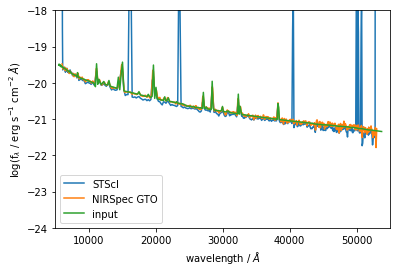

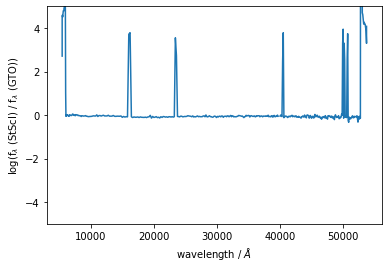

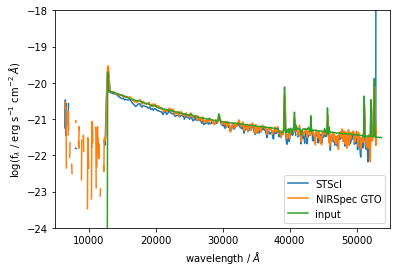

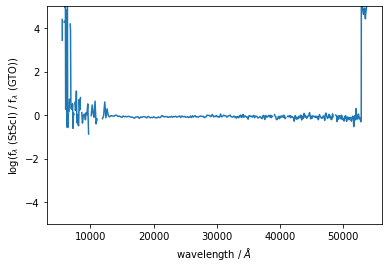

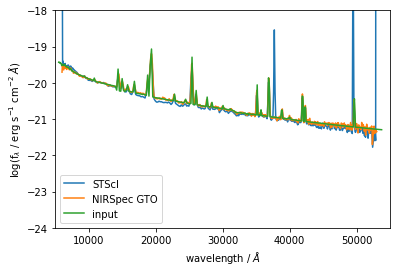

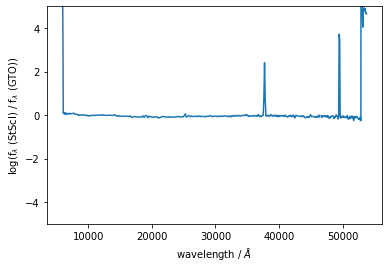

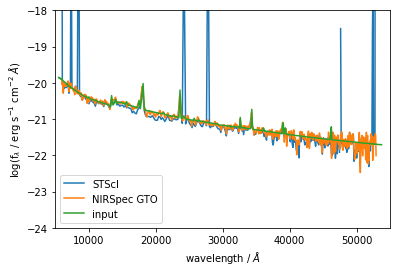

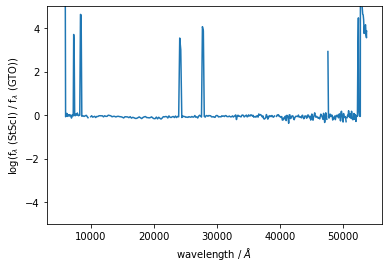

In [10]:
#Let's plot each of the centred sources (Warning, we're just cycling through all 
#the spectra in the calwebb_spec3 output file.  There will be a lot of plots if you have
#changed the RunFull flag)
catFile = "inputs/SF_and_quiescent_catalogue_mags.fits"
GTOredFolder = "final_products/prism_clear/"
fileList = os.listdir(stage3OutDir)
print(stage3OutDir)
for file in fileList:
    if 'x1d' in file:
        results = plot_comparison(stage3OutDir+'/'+file, catFile, GTOredFolder, plot=True, silent=True)
        


# R1000 observations


In [6]:
# Change which metafile the frames point to.  This is initally set up for RunFull = False so you do not have to 
# do anything the first time you use this notebook.  Please uncomment the next lines if you wish to change the 
# flag above!
if RunFull == False:
    stage2OutDir = "GRATINGS_spec2_reduction_centred_sources"
    stage3OutDir = "GRATINGS_spec3_reduction_centred_sources"
    metafileTest = "dither_01_n0.mos_metafile_msa_centred_sources.fits"
    metafileExtension = "_centred_sources.fits"
else:
    stage2OutDir = "GRATINGS_spec2_reduction"
    stage3OutDir = "GRATINGS_spec3_reduction"
    metafileTest = "dither_01_n0.mos_metafile_msa.fits"
    metafileExtension = ".fits"
    

#Check the MSAMETFL keyword points to the correct meta file and change if necessary.  Careful, it just checks the
#first file, so if you stop this part way it will
testData = fits.open('stready/Day2021277_stready/G235M_F170LP_n1_d1_NRS1_STready.fits')
if testData[0].header['MSAMETFL'] != metafileTest:
    print("changing meta file that is being pointed to")
    for folder in ['stready/Day2021277_stready/','stready/Day2022010_stready/']:
        for dither in ['1','2','3']:
            changeMetaFile(folder, \
                           'dither_0'+dither+'_n0.mos_metafile_msa'+metafileExtension, \
                           'd'+dither, gratings=True) 
else:
    print("meta file match, no change necessary")
testData.close()


changing meta file that is being pointed to


In [8]:
time1 = time.perf_counter()

if not os.path.exists(stage2OutDir):
    os.makedirs(stage2OutDir)
    
def run_spec2_gratings(args):
    flatsFolder = "calibration_files/"
    detector = args['detector']
    filt = args['filter']
    grating = args['grating']
    dither = args['dither'] 
    folder = args['folder']
    spec2 = Spec2Pipeline()
    spec2.save_results = True
    spec2.photom.skip = True
    spec2.pathloss.skip = True
    spec2.resample_spec.weight_type = 'exptime'
    spec2.output_dir = stage2OutDir
    spec2.flat_field.override_sflat = flatsFolder+'jwst_nirspec_sflat_'+detector+'_'+filt+'_'+grating+'.fits'
    spec2.flat_field.override_fflat = flatsFolder+'jwst_nirspec_fflat_'+filt+'_'+grating+'.fits'
    spec2.flat_field.override_dflat = flatsFolder+'jwst_nirspec_dflat_'+detector+'_IPS.fits'
    spec2.wavecorr.override_wavecorr = flatsFolder+'new_wavecorr_mos.asdf'
    result = spec2('stready/'+folder+'IPS_asn_dither_'+dither+'_'+detector+'_'+grating+'.json')
    

folderList = ['Day2022010_stready/','Day2021277_stready/','Day2022010_stready/']
gratingList = ['G140M','G235M','G395M']
inputs = []
for i,filt in enumerate(['F070LP','F170LP','F290LP']):
    for detector in ['NRS1','NRS2']:
        for dither in ['01','02','03']:
            inputs.append({'detector':detector,\
                           'filter':filt,\
                           'grating':gratingList[i],\
                           'dither':dither,\
                           'folder':folderList[i]})
            
if nProcesses > 1:
    pool = ProcessPool(nodes=nProcesses)
    pool.restart()
    pool.map(run_spec2_gratings, inputs)
    pool.close()
else:
    for i in range(len(inputs)):
        run_spec2_gratings(inputs[i])

time2 = time.perf_counter()

print('run time: ', time1-time2)

2022-06-14 14:19:28,487 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2022-06-14 14:19:28,490 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2022-06-14 14:19:28,493 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2022-06-14 14:19:28,496 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2022-06-14 14:19:28,497 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2022-06-14 14:19:28,499 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2022-06-14 14:19:28,503 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2022-06-14 14:19:28,505 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2022-06-14 14:19:28,503 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2022-06-14 14:19:28,504 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2022-06-14 14:19:28,510 - stpipe.Spec2Pip

2022-06-14 14:19:28,642 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.
2022-06-14 14:19:28,643 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.
2022-06-14 14:19:28,644 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2022-06-14 14:19:28,645 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.
2022-06-14 14:19:28,643 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2022-06-14 14:19:28,647 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.
2022-06-14 14:19:28,647 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2022-06-14 14:19:28,649 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.
2022-06-14 14:19:28,650 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.
2022-06-14 14:19:28,650 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.
2022-06-14 14:19:2

2022-06-14 14:19:28,815 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('stready/Day2022010_stready/IPS_asn_dither_02_NRS1_G140M.json',).
2022-06-14 14:19:28,816 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('stready/Day2022010_stready/IPS_asn_dither_03_NRS1_G140M.json',).
2022-06-14 14:19:28,834 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'GRATINGS_spec2_reduction_centred_sources_newNorm', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_outp

2022-06-14 14:19:28,837 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'GRATINGS_spec2_reduction_centred_sources_newNorm', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None

2022-06-14 14:19:28,848 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('stready/Day2022010_stready/IPS_asn_dither_01_NRS2_G140M.json',).
2022-06-14 14:19:28,849 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('stready/Day2022010_stready/IPS_asn_dither_02_NRS2_G140M.json',).
2022-06-14 14:19:28,850 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('stready/Day2022010_stready/IPS_asn_dither_03_NRS2_G140M.json',).
2022-06-14 14:19:28,864 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'GRATINGS_spec2_reduction_centred_sources_newNorm', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'o

2022-06-14 14:19:28,865 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'GRATINGS_spec2_reduction_centred_sources_newNorm', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None

2022-06-14 14:19:28,865 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'GRATINGS_spec2_reduction_centred_sources_newNorm', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None

2022-06-14 14:19:30,311 - stpipe.Spec2Pipeline - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/stdatamodels/validate.py:38: ValidationWarning: While validating meta.wcsinfo.vparity the following error occurred:
138.49234009 is not of type 'integer'

Failed validating 'type' in schema:
    OrderedDict([('title',
                  'Relative sense of rotation between Ideal xy and V2V3'),
                 ('type', 'integer'),
                 ('fits_keyword', 'VPARITY'),
                 ('fits_hdu', 'SCI'),
                 ('blend_table', True)])

On instance:
    138.49234009
  warnings.warn(errmsg, ValidationWarning)

2022-06-14 14:19:30,311 - stpipe.Spec2Pipeline - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/stdatamodels/validate.py:38: ValidationWarning: While validating meta.wcsinfo.vparity the following error occurred:
138.49234009 is not of type 'integer'

Failed validating 'type' in schema:
    Orde

2022-06-14 14:19:33,047 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.
2022-06-14 14:19:33,052 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0005.asdf'.
2022-06-14 14:19:33,062 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0001.json'.
2022-06-14 14:19:33,068 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0005.asdf'.
2022-06-14 14:19:33,075 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.
2022-06-14 14:19:33,082 - stpipe.Spec2Pipeline - INFO - Override for SFLAT reference file is '/Users/ec21abo/Documents/JWST/making_IPS_simulations_public/JADES_DEEP_JWST/calibration_files/jwst_nirspec_sflat_NRS1_F070LP_G140M.fits'.
2022-06-14 14:19:33,137 - stpipe.Spec2Pip

2022-06-14 14:19:34,856 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2022-06-14 14:19:35,310 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits'.
2022-06-14 14:19:35,319 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_barshadow_0001.fits'.
2022-06-14 14:19:35,326 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA refe

2022-06-14 14:19:36,671 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.
2022-06-14 14:19:36,675 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0026.asdf'.
2022-06-14 14:19:36,682 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0005.asdf'.
2022-06-14 14:19:36,690 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.
2022-06-14 14:19:36,695 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.
2022-06-14 14:19:36,701 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.
2022-06-14 14:19:36,705 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.
2022-06-14 14:19:36,710 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_n

2022-06-14 14:19:38,033 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVEMAP reference file is 'N/A'.
2022-06-14 14:19:38,039 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.
2022-06-14 14:19:38,049 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...
2022-06-14 14:19:38,129 - stpipe.Spec2Pipeline - INFO - Processing product G140M_F070LP_n1_d2_NRS1
2022-06-14 14:19:38,136 - stpipe.Spec2Pipeline - INFO - Working on input stready/Day2022010_stready/G140M_F070LP_n1_d2_NRS1_STready.fits ...
2022-06-14 14:19:38,445 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(2048, 2048) from G140M_F070LP_n1_d2_NRS1_STready.fits>,).
2022-06-14 14:19:38,453 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': N

2022-06-14 14:19:39,386 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1258982867 deg
2022-06-14 14:19:39,394 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0 deg
2022-06-14 14:19:39,397 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0 deg
2022-06-14 14:19:39,397 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.331874251366 deg
2022-06-14 14:19:39,404 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0 deg
2022-06-14 14:19:39,405 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0 deg
2022-06-14 14:19:39,414 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0 deg
2022-06-14 14:19:39,658 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(2048, 2048) from G140M_F070LP_n1_d2_NRS2_STready.fits>,).
2022-06-14 14:19:39,667 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, '

2022-06-14 14:19:41,523 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 2 open slits in quadrant 4
2022-06-14 14:19:41,528 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 4
2022-06-14 14:19:41,528 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 2 open slits in quadrant 4
2022-06-14 14:19:41,538 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 75 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-06-14 14:19:41,540 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 5
2022-06-14 14:19:41,549 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 5
2022-06-14 14:19:41,551 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slits projected on detector NRS2: [126, 63]
2022-06-14 14:19:41,555 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 5
2022-06-14 14:19:41,563 - stpipe.Spec2Pipeline.assign_wcs - INFO - Computing WCS for 2 o

2022-06-14 14:19:42,295 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'bsub', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}
2022-06-14 14:19:42,346 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(2048, 2048) from G140M_F070LP_n1_d3_NRS2_STready.fits>, ['stready/Day2022010_stready/G140M_F070LP_n2_d3_NRS2_STready.fits', 'stready/Day2022010_stready/G140M_F070LP_n3_d3_NRS2_STready.fits']).
2022-06-14 14:19:42,352 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_u

2022-06-14 14:19:45,364 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2022-06-14 14:19:45,384 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2022-06-14 14:19:45,391 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2022-06-14 14:19:45,398 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2022-06-14 14:19:45,421 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(2048, 2048) from G140M_F070LP_n1_d1_NRS2_STready.fits>,).
2022-06-14 14:19:45,424 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(2048, 2048) from G140M_F070LP_n1_d3_NRS2_STready.fits>,).
2022-06-14 14:19:45,435 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False

2022-06-14 14:19:45,903 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.1258982867 deg
2022-06-14 14:19:45,910 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.331874251366 deg
2022-06-14 14:19:45,916 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.0 deg
2022-06-14 14:19:45,925 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.1258982867 deg
2022-06-14 14:19:45,926 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 0.0 deg
2022-06-14 14:19:45,931 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.331874251366 deg
2022-06-14 14:19:45,938 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.0 deg
2022-06-14 14:19:45,950 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 0.0 deg
2022-06-14 14:19:45,951 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(2048, 2048) from G140M_F070LP_n1_d2_NRS2_STready.fits>,).
2022-06-14 14:19:45,954 - stpipe.Spe

2022-06-14 14:19:49,434 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -165.3366542257686 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:19:49,628 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -171.92327745832245 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:19:49,650 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -171.92327745832245 is strictly less than lower bound -0.5.
  warnings

2022-06-14 14:19:52,234 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -1316.1683868360356 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:19:52,246 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -1316.1683868360356 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:19:52,376 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -1188.0209306610122 is strictly less than lower bound -0.5.
  warning

2022-06-14 14:19:54,242 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 0 90
2022-06-14 14:19:54,250 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 416 435
2022-06-14 14:19:54,272 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 190
2022-06-14 14:19:54,278 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 0 488
2022-06-14 14:19:54,284 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 565 585
2022-06-14 14:19:54,304 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2022-06-14 14:19:54,316 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2022-06-14 14:19:54,316 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d running with args (<ImageModel(2048, 2048) from G140M_F070LP_n1_d3_NRS1_STready.fits>,).
2022-06-14 14:19:54,324 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None

2022-06-14 14:19:54,831 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:19:54,833 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:19:54,840 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  53.126278975 -27.804613709 53.125858692 -27.804843038 53.125890253 -27.804888802 53.126310538 -27.804659477
2022-06-14 14:19:54,843 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  53.124658707 -27.791896552 53.124237696 -27.792127664 53.124269242 -27.792173628 53.124690255 -27.791942521
2022-06-14 14:19:54,844 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 110
2022-06-14 14:19:54,846 - stpipe.Spec2Pipeline.extract_2d - INFO - Updated S_REGION to POLYGON ICRS  53.126278975 -27.804613709 53.125858692 -27.804843038 53.125890253 -27.804888802 53.126310538 -27.804659477
2022-06-14 14:19:54,848 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION

2022-06-14 14:19:55,142 - stpipe.Spec2Pipeline.master_background - INFO - Background subtraction has already occurred. Skipping.
2022-06-14 14:19:55,148 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background done
2022-06-14 14:19:55,187 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<MultiSlitModel from G140M_F070LP_n1_d3_NRS2_STready.fits>,).
2022-06-14 14:19:55,190 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:19:55,192 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready'}
2022-06-14 14:19:55,201 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  53.126278975 -27.804613709 53.125858692

2022-06-14 14:19:55,648 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 71
2022-06-14 14:19:55,651 - stpipe.Spec2Pipeline.wavecorr - INFO - slit name 190
2022-06-14 14:19:55,657 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<MultiSlitModel from G140M_F070LP_n1_d2_NRS2_STready.fits>,).
2022-06-14 14:19:55,659 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 617 1531
2022-06-14 14:19:55,660 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:19:55,664 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:19:55,674 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2022010_stread

2022-06-14 14:19:56,291 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit 63
2022-06-14 14:19:56,297 - stpipe.Spec2Pipeline.wavecorr - INFO - slit name 63
2022-06-14 14:19:56,301 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background running with args (<MultiSlitModel from G140M_F070LP_n1_d3_NRS1_STready.fits>,).
2022-06-14 14:19:56,308 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'force_subtract': False, 'save_background': False, 'user_background': None, 'inverse': False, 'steps': {'flat_field': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'out

2022-06-14 14:19:56,465 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for aperture MOS
2022-06-14 14:19:56,476 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done
2022-06-14 14:19:56,477 - stpipe.Spec2Pipeline.master_background - INFO - Background subtraction has already occurred. Skipping.
2022-06-14 14:19:56,477 - stpipe.Spec2Pipeline.master_background - INFO - Background subtraction has already occurred. Skipping.
2022-06-14 14:19:56,483 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background done
2022-06-14 14:19:56,484 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background done
2022-06-14 14:19:56,496 - stpipe.Spec2Pipeline.wavecorr - INFO - Using WAVECORR reference file /Users/ec21abo/Documents/JWST/making_IPS_simulations_public/JADES_DEEP_JWST/calibration_files/new_wavecorr_mos.asdf
2022-06-14 14:19:56,567 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<MultiSlitModel from G14

2022-06-14 14:19:58,749 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
2022-06-14 14:19:58,827 - stpipe.Spec2Pipeline.flat_field - INFO - Working on slit 190
2022-06-14 14:19:59,363 - stpipe.Spec2Pipeline.flat_field - INFO - Working on slit 60
2022-06-14 14:19:59,515 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:661: RuntimeWarning: overflow encountered in square
  sum_var += f_flat_err ** 2 / f_flat ** 2

2022-06-14 14:19:59,519 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/minifor

2022-06-14 14:20:01,613 - stpipe.Spec2Pipeline.barshadow - INFO - Using BARSHADOW reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_barshadow_0001.fits
2022-06-14 14:20:01,648 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<MultiSlitModel from G140M_F070LP_n1_d1_NRS2_STready.fits>,).
2022-06-14 14:20:01,659 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'inverse': False, 'source_type': None}
2022-06-14 14:20:01,665 - stpipe.Spec2Pipeline.photom - INFO - Step skipped.
2022-06-14 14:20:01,675 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2022-06-14 14:20:01,785 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running wit

2022-06-14 14:20:02,627 - stpipe.Spec2Pipeline.resample_spec - INFO - Reorganizing data from exposure GRATINGS_spec2_reduction_centred_sources_newNorm/G140M_F070LP_n1_d2_NRS2_cal.fits
2022-06-14 14:20:02,635 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (20, 488) --> (16, 488)
2022-06-14 14:20:02,647 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 14:20:02,670 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (20, 488) --> (16, 488)
2022-06-14 14:20:02,677 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 14:20:02,704 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (20, 488) --> (16, 488)
2022-06-14 14:20:02,711 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 14:20:02,742 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (20, 488) --> (16, 488)
2022-06-14 14:20:02,761 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.124257064 -27.79214

2022-06-14 14:20:03,697 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-14 14:20:03,704 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (19, 63) --> (15, 63)
2022-06-14 14:20:03,713 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 14:20:03,736 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (19, 63) --> (15, 63)
2022-06-14 14:20:03,753 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.125899984 -27.804851865 53.126287901 -27.804851865 53.126287901 -27.804640232 53.125899984 -27.804640232
2022-06-14 14:20:03,768 - stpipe.Spec2Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-14 14:20:03,786 - stpipe.Spec2Pipeline.extract_1d - INFO - Working on slit 190
2022-06-14 14:20:03,803 - stpipe.Spec2Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec2_reduction_c

2022-06-14 14:20:04,976 - stpipe.Spec2Pipeline.extract_1d - INFO - Working on slit 63
2022-06-14 14:20:04,985 - stpipe.Spec2Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-14 14:20:04,996 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying position offset of 0.22 to ystart and ystop
2022-06-14 14:20:05,010 - stpipe.Spec2Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-14 14:20:05,020 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0, xstop=62, ystart=3.718610361414589, ystop=10.718610361414589
2022-06-14 14:20:05,059 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec2_reduction_centred_sources_newNorm/G140M_F070LP_n1_d1_NRS2_x1d.fits
2022-06-14 14:20:05,067 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-14 14:20:05,073 - stpipe.Spec2Pipeline - INFO - Finished processing product G140M_F070LP_n1_d1_NRS2
2022-06-14 14:20:05,078 - stpipe.Spec2Pipeline - INFO - Processing product G140M_F070LP_n2_d1_NRS2


2022-06-14 14:20:06,509 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:426: RuntimeWarning: overflow encountered in square
  flat_data_squared = slit_flat.data ** 2

2022-06-14 14:20:06,511 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slits projected on detector NRS2: [190, 93]
2022-06-14 14:20:06,522 - stpipe.Spec2Pipeline.assign_wcs - INFO - Computing WCS for 2 open slitlets
2022-06-14 14:20:06,518 - stpipe.Spec2Pipeline.flat_field - INFO - Working on slit 71
2022-06-14 14:20:06,708 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1258982867 deg
2022-06-14 14:20:06,712 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.331874251366 deg
2022-06-14 14:20:06,727 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0 deg
2022-06-14 14:20:06,750 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 1 from the list of open slits because the WCS bounding_box i

2022-06-14 14:20:08,069 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<MultiSlitModel from G140M_F070LP_n1_d2_NRS1_STready.fits>,).
2022-06-14 14:20:08,077 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'inverse': False, 'source_type': None}
2022-06-14 14:20:08,082 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2022-06-14 14:20:08,088 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2022-06-14 14:20:08,146 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2022-06-14 14:20:08,151 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': No

2022-06-14 14:20:08,975 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 75
2022-06-14 14:20:08,990 - stpipe.Spec2Pipeline.barshadow - INFO - Bar shadow correction skipped for slitlet 75 (source not uniform)
2022-06-14 14:20:09,003 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done
2022-06-14 14:20:09,114 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<MultiSlitModel from G140M_F070LP_n1_d2_NRS1_STready.fits>,).
2022-06-14 14:20:09,119 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'inverse': False, 'source_type': None}
2022-06-14 14:20:09,125 - stpipe.Spec2Pipeline.photom - INFO - Step skipped.
2022-06-14 14:20:09,136 - stpipe.Spec2Pipeline.photom 

2022-06-14 14:20:09,921 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2022-06-14 14:20:09,924 - stpipe.Spec2Pipeline.resample_spec - INFO - Reorganizing data from exposure GRATINGS_spec2_reduction_centred_sources_newNorm/G140M_F070LP_n1_d3_NRS1_cal.fits
2022-06-14 14:20:09,921 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(2048, 2048) from G140M_F070LP_n2_d1_NRS2_STready.fits>,).
2022-06-14 14:20:09,937 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'msa_flagging', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready'}
2022-06-14 14:20:09,980 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0001.jso

2022-06-14 14:20:10,601 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 14:20:10,634 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (22, 707) --> (15, 707)
2022-06-14 14:20:10,644 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 14:20:10,667 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (22, 707) --> (15, 707)
2022-06-14 14:20:10,680 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data
2022-06-14 14:20:10,688 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 14:20:10,710 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (21, 679) --> (15, 679)
2022-06-14 14:20:10,724 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (22, 707) --> (15, 707)
2022-06-14 14:20:10,725 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 14:20:10,737 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.1258982867 deg
2022-06-14 14:20:10,748 

2022-06-14 14:20:11,726 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (26, 914) --> (16, 914)
2022-06-14 14:20:11,734 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 14:20:11,733 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (30, 817) --> (15, 817)
2022-06-14 14:20:11,748 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 14:20:11,764 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (26, 914) --> (16, 914)
2022-06-14 14:20:11,773 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (30, 817) --> (15, 817)
2022-06-14 14:20:11,780 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 14:20:11,783 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 14:20:11,806 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data
2022-06-14 14:20:11,808 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (26, 914) --> (16, 914)
2022-06-14 14:20:1

2022-06-14 14:20:12,976 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-14 14:20:13,014 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-14 14:20:13,033 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-14 14:20:13,067 - stpipe.Spec2Pipeline.extract_1d - INFO - Working on slit 63
2022-06-14 14:20:13,072 - stpipe.Spec2Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-14 14:20:13,087 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying position offset of 0.60 to ystart and ystop
2022-06-14 14:20:13,093 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<MultiSlitModel from G140M_F070LP_n1_d1_NRS1_s2d.fits>,).
2022-06-14 14:20:13,096 - stpipe.Spec2Pipeline.extract_1d - INFO - Using extraction limits

2022-06-14 14:20:14,180 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-14 14:20:14,193 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -165.3366542257686 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:20:14,199 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-14 14:20:14,449 - stpipe.Spec2Pipeline.extract_1d - INFO - Working on slit 1
2022-06-14 14:20:14,457 - stpipe.Spec2Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-14 14:20:14,468 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying position offset of -0.59 to ystart and ystop
2022-06-14 14:20:14,481 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages

2022-06-14 14:20:16,132 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -820.3405674747555 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:20:16,215 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -820.3405674747555 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:20:16,231 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -880.817210992685 is strictly less than lower bound -0.5.
  warnings.wa

2022-06-14 14:20:17,317 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1258982867 deg
2022-06-14 14:20:17,331 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.331874251366 deg
2022-06-14 14:20:17,329 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(2048, 2048) from G140M_F070LP_n2_d3_NRS1_STready.fits>,).
2022-06-14 14:20:17,341 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0 deg
2022-06-14 14:20:17,350 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0 deg
2022-06-14 14:20:17,346 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degre

2022-06-14 14:20:18,552 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.331874251366 deg
2022-06-14 14:20:18,567 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 1
2022-06-14 14:20:18,567 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0 deg
2022-06-14 14:20:18,579 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 2 open slits in quadrant 2
2022-06-14 14:20:18,588 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0 deg
2022-06-14 14:20:18,628 - stpipe.Spec2Pipeline.assign_wcs - INFO - SPORDER= -1, wrange=[7e-07, 1.27e-06]
2022-06-14 14:20:18,631 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 3
2022-06-14 14:20:18,654 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 2 open slits in quadrant 4
2022-06-14 14:20:18,680 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 5
2022-06-14 14:20:18,689 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1258

2022-06-14 14:20:19,417 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'extract_2d', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'slit_name': None, 'extract_orders': None, 'tsgrism_extract_height': None, 'wfss_extract_half_height': 5, 'grism_objects': None, 'mmag_extract': 99.0}
2022-06-14 14:20:19,426 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(2048, 2048) from G140M_F070LP_n2_d2_NRS1_STready.fits>, ['stready/Day2022010_stready/G140M_F070LP_n1_d2_NRS1_STready.fits', 'stready/Day2022010_stready/G140M_F070LP_n3_d2_NRS1_STready.fits']).
2022-06-14 14:20:19,437 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file':

2022-06-14 14:20:19,912 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_MSASPEC
2022-06-14 14:20:19,922 - stpipe.Spec2Pipeline.srctype - INFO - source_id=151823, stellarity=1.0000, type=POINT
2022-06-14 14:20:19,934 - stpipe.Spec2Pipeline.srctype - INFO - source_id=114927, stellarity=1.0000, type=POINT
2022-06-14 14:20:19,942 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(2048, 2048) from G140M_F070LP_n2_d1_NRS1_STready.fits>, ['stready/Day2022010_stready/G140M_F070LP_n1_d1_NRS1_STready.fits', 'stready/Day2022010_stready/G140M_F070LP_n3_d1_NRS1_STready.fits']).
2022-06-14 14:20:19,943 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2022-06-14 14:20:19,949 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': Fa

2022-06-14 14:20:20,404 - stpipe.Spec2Pipeline.master_background - INFO - Step skipped.
2022-06-14 14:20:20,414 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background done
2022-06-14 14:20:20,472 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background running with args (<MultiSlitModel from G140M_F070LP_n2_d2_NRS2_STready.fits>,).
2022-06-14 14:20:20,480 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'master_background', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'force_subtract': False, 'save_background': False, 'user_background': None, 'inverse': False, 'steps': {'flat_field': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_us

2022-06-14 14:20:21,481 - stpipe.JwstStep - INFO - JwstStep instance created.
2022-06-14 14:20:21,506 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2022-06-14 14:20:21,522 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<MultiSlitModel from G140M_F070LP_n2_d2_NRS2_STready.fits>,).
2022-06-14 14:20:21,531 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
2022-06-14 14:20:21,547 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<MultiSlitModel from G140M_F070LP_n2_d3_NRS2_STready.fits>,).
2022-06-14 14:20:21,557 - stpipe.Spec2

2022-06-14 14:20:24,423 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:664: RuntimeWarning: invalid value encountered in true_divide
  sum_var += s_flat_err ** 2 / s_flat ** 2

2022-06-14 14:20:24,442 - stpipe.Spec2Pipeline.flat_field - INFO - Working on slit 60
2022-06-14 14:20:24,585 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:661: RuntimeWarning: overflow encountered in square
  sum_var += f_flat_err ** 2 / f_flat ** 2

2022-06-14 14:20:24,593 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:664: RuntimeWarning: invalid value encountered in true_divide
  sum_var += s_flat_err ** 2 / s_flat ** 2

2022-06-14 14:20:24,595 - stpipe.Spec2Pipeline.flat_field - INFO - Working on sli

2022-06-14 14:20:26,103 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'barshadow', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'inverse': False, 'source_type': None}
2022-06-14 14:20:26,104 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'exptime', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': Non

2022-06-14 14:20:26,905 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-14 14:20:26,910 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-14 14:20:26,917 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-14 14:20:26,925 - stpipe.Spec2Pipeline.resample_spec - INFO - Reorganizing data from exposure GRATINGS_spec2_reduction_centred_sources_newNorm/G140M_F070LP_n2_d3_NRS2_cal.fits
2022-06-14 14:20:27,085 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data
2022-06-14 14:20:27,089 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data
2022-06-14 14:20:27,109 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (20, 477) --> (16, 477)
2022-06-14 14:20:27,110 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (19, 74) --> (15, 74)
2022-06-14 14:20:27,118 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 14:20:27,119 - stpipe.Spe

2022-06-14 14:20:28,056 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-14 14:20:28,077 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-14 14:20:28,119 - stpipe.Spec2Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-14 14:20:28,124 - stpipe.Spec2Pipeline.extract_1d - INFO - Working on slit 126
2022-06-14 14:20:28,132 - stpipe.Spec2Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-14 14:20:28,146 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying position offset of -5.38 to ystart and ystop
2022-06-14 14:20:28,153 - stpipe.Spec2Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-14 14:20:28,164 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0, xstop=476, ystart=0, ystop=5.62370673595

2022-06-14 14:20:29,767 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec2_reduction_centred_sources_newNorm/G140M_F070LP_n2_d3_NRS2_x1d.fits
2022-06-14 14:20:29,774 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-14 14:20:29,774 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1258982867 deg
2022-06-14 14:20:29,778 - stpipe.Spec2Pipeline - INFO - Finished processing product G140M_F070LP_n2_d3_NRS2
2022-06-14 14:20:29,780 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.331874251366 deg
2022-06-14 14:20:29,786 - stpipe.Spec2Pipeline - INFO - Processing product G140M_F070LP_n3_d3_NRS2
2022-06-14 14:20:29,787 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0 deg
2022-06-14 14:20:29,792 - stpipe.Spec2Pipeline - INFO - Working on input stready/Day2022010_stready/G140M_F070LP_n3_d3_NRS2_STready.fits ...
2022-06-14 14:20:29,795 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0 deg
2022-06-14 14:

2022-06-14 14:20:31,282 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 1 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-06-14 14:20:31,298 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 71 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-06-14 14:20:31,307 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slits projected on detector NRS2: [60, 110]
2022-06-14 14:20:31,317 - stpipe.Spec2Pipeline.assign_wcs - INFO - Computing WCS for 2 open slitlets
2022-06-14 14:20:31,372 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 60
2022-06-14 14:20:31,377 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 1369 2048
2022-06-14 14:20:31,382 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 416 437
2022-06-14 14:20:31,413 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d running with args (<ImageModel(2048, 2048) from G140M_

2022-06-14 14:20:31,959 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 0 789
2022-06-14 14:20:31,962 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 2 open slits in quadrant 2
2022-06-14 14:20:31,964 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  53.124792781 -27.791818790 53.124371560 -27.792050097 53.124403109 -27.792096079 53.124824332 -27.791864777
2022-06-14 14:20:31,964 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 767 796
2022-06-14 14:20:31,969 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0004.asdf', 'camera': '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0004.asdf', 'collimator': '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_

2022-06-14 14:20:32,712 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'bsub', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}
2022-06-14 14:20:32,747 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 113
2022-06-14 14:20:32,755 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 600 1514
2022-06-14 14:20:32,764 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 352 378
2022-06-14 14:20:32,792 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:20:32,803 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  53.138179998 -27.823216160 53.137758547 -27.823443844 5

2022-06-14 14:20:33,309 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<MultiSlitModel from G140M_F070LP_n2_d1_NRS1_STready.fits>,).
2022-06-14 14:20:33,313 - stpipe.Spec2Pipeline.master_background - INFO - Step skipped.
2022-06-14 14:20:33,314 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'srctype', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready'}
2022-06-14 14:20:33,319 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background done
2022-06-14 14:20:33,326 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_MSASPEC
2022-06-14 14:20:33,334 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<MultiSlitModel from G140M_F070LP_n2_d2_NRS1_STready.fits>,).
2022-06-14 14:20:33,33

2022-06-14 14:20:34,115 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(2048, 2048) from G140M_F070LP_n3_d2_NRS2_STready.fits>, []).
2022-06-14 14:20:34,119 - stpipe.Spec2Pipeline.wavecorr - INFO - slit name 60
2022-06-14 14:20:34,123 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready'}
2022-06-14 14:20:34,133 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2022-06-14 14:20:34,134 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= -1, wrange=[7e-07, 1.27e-06]
2022-06-14 14:20:34,141 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2022-06-14 14:20:34,216 - stpipe.Spec2P

2022-06-14 14:20:34,944 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 5 open slits in quadrant 1
2022-06-14 14:20:34,948 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done
2022-06-14 14:20:34,977 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2
2022-06-14 14:20:35,003 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 9 open slits in quadrant 3
2022-06-14 14:20:35,061 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 4
2022-06-14 14:20:35,070 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<MultiSlitModel from G140M_F070LP_n2_d2_NRS1_STready.fits>,).
2022-06-14 14:20:35,080 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5
2022-06-14 14:20:35,081 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': Fal

2022-06-14 14:20:38,736 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:664: RuntimeWarning: invalid value encountered in true_divide
  sum_var += s_flat_err ** 2 / s_flat ** 2

2022-06-14 14:20:38,792 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -171.92327745832245 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:20:38,916 - stpipe.Spec2Pipeline.flat_field - INFO - Working on slit 93
2022-06-14 14:20:39,047 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -587.8744420309254 is strictly less than lower bound

2022-06-14 14:20:41,214 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -1188.0209306610122 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:20:41,235 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -1079.5285595736923 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:20:41,422 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -1297.2413799879432 is strictly less than lower bound -0.5.
  warning

2022-06-14 14:20:43,353 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -1430.722560692545 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:20:43,369 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2022-06-14 14:20:43,384 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -1421.6531059191739 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:20:43,489 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:20:43,493 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done
2022-06-14 14:20:43,500 

2022-06-14 14:20:44,060 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'barshadow', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'inverse': False, 'source_type': None}
2022-06-14 14:20:44,082 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 63
2022-06-14 14:20:44,075 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_MSASPEC
2022-06-14 14:20:44,089 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 0 63
2022-06-14 14:20:44,093 - stpipe.Spec2Pipeline.srctype - INFO - source_id=151823, stellarity=1.0000, type=POINT
2022-06-14 14:20:44,095 - stpipe.Spec2Pipeline.barshadow - INFO - Using BARSHADOW reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_barshadow_0001.fits

2022-06-14 14:20:44,579 - stpipe.Spec2Pipeline.barshadow - INFO - Bar shadow correction skipped for slitlet 126 (source not uniform)
2022-06-14 14:20:44,592 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 63
2022-06-14 14:20:44,609 - stpipe.Spec2Pipeline.barshadow - INFO - Bar shadow correction skipped for slitlet 63 (source not uniform)
2022-06-14 14:20:44,618 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 1
2022-06-14 14:20:44,632 - stpipe.Spec2Pipeline.barshadow - INFO - Bar shadow correction skipped for slitlet 1 (source not uniform)
2022-06-14 14:20:44,644 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 75
2022-06-14 14:20:44,647 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:20:44,658 - stpipe.Spec2Pipeline.barshadow - INFO - Bar shadow correction skipped for slitlet 75 (source not uniform)
2022-06-14 14:20:44,661 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  53.124506088

2022-06-14 14:20:45,002 - stpipe.Spec2Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-14 14:20:45,010 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-14 14:20:45,011 - stpipe.Spec2Pipeline.barshadow - INFO - Bar shadow correction skipped for slitlet 190 (source not uniform)
2022-06-14 14:20:45,016 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-14 14:20:45,022 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 93
2022-06-14 14:20:45,022 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<MultiSlitModel from G140M_F070LP_n2_d3_NRS1_STready.fits>,).
2022-06-14 14:20:45,023 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-14 14:20:45,031 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background running with args (<MultiSlitModel from G140M_F070LP_n3_d3_NRS2_STready.fits>,).
2022-06-14 14:20:45,033 - stpipe.Spec2Pipeline.wavecorr - IN

2022-06-14 14:20:45,287 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done
2022-06-14 14:20:45,393 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<MultiSlitModel from GRATINGS_spec2_reduction_centred_sources_newNorm/G140M_F070LP_n2_d1_NRS1_cal.fits>,).
2022-06-14 14:20:45,401 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<MultiSlitModel from G140M_F070LP_n3_d1_NRS2_STready.fits>,).
2022-06-14 14:20:45,402 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'exptime', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'p

2022-06-14 14:20:46,309 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.124409503 -27.792067207 53.124798905 -27.792067207 53.124798905 -27.791853449 53.124409503 -27.791853449
2022-06-14 14:20:46,314 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (21, 707) --> (15, 707)
2022-06-14 14:20:46,348 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.126030989 -27.804781151 53.126418852 -27.804781151 53.126418852 -27.804569548 53.126030989 -27.804569548
2022-06-14 14:20:46,401 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data
2022-06-14 14:20:46,425 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (20, 267) --> (15, 267)
2022-06-14 14:20:46,432 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 14:20:46,452 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (20, 267) --> (15, 267)
2022-06-14 14:20:46,461 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling

2022-06-14 14:20:48,213 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 14:20:48,246 - stpipe.Spec2Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec2_reduction_centred_sources_newNorm/G140M_F070LP_n2_d2_NRS1_s2d.fits
2022-06-14 14:20:48,249 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (26, 914) --> (15, 914)
2022-06-14 14:20:48,257 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-14 14:20:48,274 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.137812523 -27.823440125 53.138200966 -27.823440125 53.138200966 -27.823230314 53.137812523 -27.823230314
2022-06-14 14:20:48,386 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<MultiSlitModel from G140M_F070LP_n2_d2_NRS1_s2d.fits>,).
2022-06-14 14:20:48,393 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None

2022-06-14 14:20:49,030 - stpipe.Spec2Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-14 14:20:49,041 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done
2022-06-14 14:20:49,043 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying position offset of -4.51 to ystart and ystop
2022-06-14 14:20:49,052 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-14 14:20:49,054 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-14 14:20:49,052 - stpipe.Spec2Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-14 14:20:49,062 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0, xstop=706, ystart=0, ystop=5.990975236953807
2022-06-14 14:20:49,094 - stpipe.Spec2Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-14 14:20:49,104 - stpipe.Spec2Pipeline.extract_1d - INFO - Working on 

2022-06-14 14:20:50,034 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'photom', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'inverse': False, 'source_type': None}
2022-06-14 14:20:50,047 - stpipe.Spec2Pipeline.photom - INFO - Step skipped.
2022-06-14 14:20:50,067 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2022-06-14 14:20:50,161 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<MultiSlitModel from G140M_F070LP_n3_d3_NRS2_STready.fits>,).
2022-06-14 14:20:50,167 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, '

2022-06-14 14:20:50,837 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-14 14:20:50,849 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done
2022-06-14 14:20:50,851 - stpipe.Spec2Pipeline.resample_spec - INFO - Reorganizing data from exposure GRATINGS_spec2_reduction_centred_sources_newNorm/G140M_F070LP_n3_d2_NRS2_cal.fits
2022-06-14 14:20:50,850 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 14:20:50,892 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (20, 488) --> (16, 488)
2022-06-14 14:20:50,911 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 14:20:50,950 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (20, 488) --> (16, 488)
2022-06-14 14:20:50,968 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<MultiSlitModel from G140M_F070LP_n3_d3_NRS2_STready.fits>,).
2022-06-14 14:20:50,975 - stpipe.Spec2Pipeline.photom - INFO - Step photom paramete

2022-06-14 14:20:51,851 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.125739748 -27.804939205 53.126128043 -27.804939205 53.126128043 -27.804727271 53.125739748 -27.804727271
2022-06-14 14:20:51,852 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-14 14:20:51,852 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (20, 63) --> (15, 63)
2022-06-14 14:20:51,871 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 14:20:51,878 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-14 14:20:51,895 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (20, 63) --> (15, 63)
2022-06-14 14:20:51,912 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 14:20:51,941 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (20, 63) --> (15, 63)
2022-06-14 14:20:51,952 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 14:20:

2022-06-14 14:20:52,800 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-14 14:20:52,803 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}
2022-06-14 14:20:52,804 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0, xstop=72, ystart=8.826250531162273, ystop=14
2022-06-14 14:20:52,808 - stpipe.Sp

2022-06-14 14:20:53,659 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1258982867 deg
2022-06-14 14:20:53,666 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.331874251366 deg
2022-06-14 14:20:53,680 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0 deg
2022-06-14 14:20:53,687 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0 deg
2022-06-14 14:20:53,810 - stpipe.Spec2Pipeline.assign_wcs - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1 and dither_index = 2
2022-06-14 14:20:53,841 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec2_reduction_centred_sources_newNorm/G140M_F070LP_n3_d2_NRS2_x1d.fits
2022-06-14 14:20:53,846 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-14 14:20:53,857 - stpipe.Spec2Pipeline - INFO - Finished processing product G140M_F070LP_n3_d2_NRS2
2022-06-14 14:20:53,868 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2022-06-14 14:20:53,986 - stpipe.Spe

2022-06-14 14:20:55,332 - stpipe.Spec2Pipeline - INFO - Saved model in GRATINGS_spec2_reduction_centred_sources_newNorm/G140M_F070LP_n3_d1_NRS2_cal.fits
2022-06-14 14:20:55,336 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2022-06-14 14:20:55,348 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2022-06-14 14:20:55,355 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2022-06-14 14:20:55,361 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2022-06-14 14:20:55,367 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2022-06-14 14:20:55,372 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2022-06-14 14:20:55,377 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2022-06-14 14:20:55,384 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.
2022-06-14 14:20:55,390 - stpipe.Spec2Pipeline.maste

2022-06-14 14:20:55,689 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(2048, 2048) from G140M_F070LP_n3_d3_NRS1_STready.fits>, ['stready/Day2022010_stready/G140M_F070LP_n1_d3_NRS1_STready.fits', 'stready/Day2022010_stready/G140M_F070LP_n2_d3_NRS1_STready.fits']).
2022-06-14 14:20:55,696 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'bsub', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}
2022-06-14 14:20:55,846 - stpipe.Spec2Pipeline - INFO - Saved model in GRATINGS_spec2_reduction_centred_sources_newNorm/G140M_F070LP_n3_d2_NRS2_cal.fits
2022-06-14 14:20:55,852 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2022-0

2022-06-14 14:20:56,212 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0037.asdf'.
2022-06-14 14:20:56,218 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.
2022-06-14 14:20:56,224 - stpipe.Spec2Pipeline - INFO - Prefetch for DRIZPARS reference file is 'N/A'.
2022-06-14 14:20:56,230 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json'.
2022-06-14 14:20:56,237 - stpipe.Spec2Pipeline - INFO - Override for FFLAT reference file is '/Users/ec21abo/Documents/JWST/making_IPS_simulations_public/JADES_DEEP_JWST/calibration_files/jwst_nirspec_fflat_F170LP_G235M.fits'.
2022-06-14 14:20:56,259 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.
2022-06-14 14:20:56,265 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 

2022-06-14 14:20:56,646 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'GRATINGS_spec2_reduction_centred_sources_newNorm', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None

2022-06-14 14:20:56,648 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0004.asdf'.
2022-06-14 14:20:56,659 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0004.asdf'.
2022-06-14 14:20:56,665 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.
2022-06-14 14:20:56,672 - stpipe.Spec2Pipeline - INFO - Override for DFLAT reference file is '/Users/ec21abo/Documents/JWST/making_IPS_simulations_public/JADES_DEEP_JWST/calibration_files/jwst_nirspec_dflat_NRS1_IPS.fits'.
2022-06-14 14:20:56,749 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0037.asdf'.
2022-06-14 14:20:56,761 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.
2022-06-14 14:20:56,779 -

2022-06-14 14:20:57,359 - stpipe.Spec2Pipeline - INFO - Processing product G235M_F170LP_n1_d2_NRS1
2022-06-14 14:20:57,372 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2022-06-14 14:20:57,379 - stpipe.Spec2Pipeline - INFO - Working on input stready/Day2021277_stready/G235M_F170LP_n1_d2_NRS1_STready.fits ...
2022-06-14 14:20:57,449 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.
2022-06-14 14:20:57,457 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.
2022-06-14 14:20:57,468 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0027.asdf'.
2022-06-14 14:20:57,483 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0005.asdf'.
2022-06-14 14:20:57,485 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<Ima

2022-06-14 14:20:57,973 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.0 deg
2022-06-14 14:20:57,980 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.331874251366 deg
2022-06-14 14:20:57,982 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 0.0 deg
2022-06-14 14:20:57,987 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.0 deg
2022-06-14 14:20:57,995 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 0.0 deg
2022-06-14 14:20:58,011 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= -1, wrange=[7e-07, 1.27e-06]
2022-06-14 14:20:58,022 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= -1, wrange=[7e-07, 1.27e-06]
2022-06-14 14:20:58,044 - stpipe.Spec2Pipeline.assign_wcs - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1 and dither_index = 1
2022-06-14 14:20:58,052 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(2048, 2048) from G140M_F070LP_

2022-06-14 14:20:59,087 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 4
2022-06-14 14:20:59,106 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5
2022-06-14 14:20:59,156 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 110 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-06-14 14:20:59,182 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slits projected on detector NRS1: [1, 60, 71]
2022-06-14 14:20:59,191 - stpipe.Spec2Pipeline.assign_wcs - INFO - Computing WCS for 3 open slitlets
2022-06-14 14:20:59,231 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0004.asdf', 'camera': '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0004.

2022-06-14 14:21:01,331 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2022-06-14 14:21:01,479 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(2048, 2048) from G235M_F170LP_n1_d1_NRS1_STready.fits>, []).
2022-06-14 14:21:01,496 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2021277_stready'}
2022-06-14 14:21:01,511 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2022-06-14 14:21:01,522 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2022-06-14 14:21:01,608 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(2048, 2048) from G235M_F170L

2022-06-14 14:21:04,283 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2091.0577247116926.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:21:04,416 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2369.852014099973.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:21:04,681 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2091.0577247116926.
  warni

2022-06-14 14:21:07,789 - stpipe.Spec2Pipeline.extract_2d - INFO - Updated S_REGION to POLYGON ICRS  53.124506088 -27.791974271 53.124084867 -27.792205577 53.124116417 -27.792251559 53.124537639 -27.792020258
2022-06-14 14:21:07,896 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:21:07,904 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 1
2022-06-14 14:21:07,908 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:21:07,909 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  53.126134197 -27.804692099 53.125713965 -27.804921364 53.125745526 -27.804967122 53.126165760 -27.804737862
2022-06-14 14:21:07,910 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 0 817
2022-06-14 14:21:07,923 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 812 842
2022-06-14 14:21:07,921 - stpipe.Spec2Pipeline.extract_2d - INFO - Updated S_REGION to POLYGON I

2022-06-14 14:21:13,048 - stpipe.Spec2Pipeline.srctype - INFO - source_id=166055, stellarity=1.0000, type=POINT
2022-06-14 14:21:13,057 - stpipe.Spec2Pipeline.srctype - INFO - source_id=166055, stellarity=1.0000, type=POINT
2022-06-14 14:21:13,059 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2022-06-14 14:21:13,066 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2022-06-14 14:21:13,141 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 113
2022-06-14 14:21:13,215 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background running with args (<MultiSlitModel from G140M_F070LP_n3_d2_NRS1_STready.fits>,).
2022-06-14 14:21:13,313 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background running with args (<MultiSlitModel from G140M_F070LP_n3_d3_NRS1_STready.fits>,).
2022-06-14 14:21:13,424 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 600 1514
2022-06-14 14:21:13,427 - stpipe.Spec2Pipeline.master_bac

2022-06-14 14:21:15,104 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2021277_stready', 'slit_name': None, 'extract_orders': None, 'tsgrism_extract_height': None, 'wfss_extract_half_height': 5, 'grism_objects': None, 'mmag_extract': 99.0}
2022-06-14 14:21:15,114 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d done
2022-06-14 14:21:15,118 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 93
2022-06-14 14:21:15,124 - stpipe.Spec2Pipeline.extract_2d - INFO - EXP_TYPE is NRS_MSASPEC
2022-06-14 14:21:15,126 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 1821 2048
2022-06-14 14:21:15,163 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type 

2022-06-14 14:21:16,455 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'wavecorr', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready'}
2022-06-14 14:21:16,502 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 353 1786
2022-06-14 14:21:16,512 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 343 1775
2022-06-14 14:21:16,517 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 772 802
2022-06-14 14:21:16,519 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 762 792
2022-06-14 14:21:16,750 - stpipe.Spec2Pipeline.wavecorr - INFO - Using WAVECORR reference file /Users/ec21abo/Documents/JWST/making_IPS_simulations_public/JADES_DEEP_JWST/calibration_files/new_wavecorr_mos.asdf
2022-06-14 1

2022-06-14 14:21:18,293 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d done
2022-06-14 14:21:18,300 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<MultiSlitModel from G235M_F170LP_n1_d2_NRS1_STready.fits>,).
2022-06-14 14:21:18,308 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2021277_stready'}
2022-06-14 14:21:18,319 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_MSASPEC
2022-06-14 14:21:18,326 - stpipe.Spec2Pipeline.srctype - INFO - source_id=114927, stellarity=1.0000, type=POINT
2022-06-14 14:21:18,331 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit 93
2022-06-14 14:21:18,332 - stpipe.Spec2Pipeline.srctype - INFO - source_i

2022-06-14 14:21:18,618 - stpipe.Spec2Pipeline.wavecorr - INFO - Using WAVECORR reference file /Users/ec21abo/Documents/JWST/making_IPS_simulations_public/JADES_DEEP_JWST/calibration_files/new_wavecorr_mos.asdf
2022-06-14 14:21:18,623 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<MultiSlitModel from G235M_F170LP_n1_d1_NRS1_STready.fits>,).
2022-06-14 14:21:18,629 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2021277_stready'}
2022-06-14 14:21:18,698 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d done
2022-06-14 14:21:18,705 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for aperture MOS
2022-06-14 14:21:18,733 - stpipe.Spec2Pipeline.

2022-06-14 14:21:21,005 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit 1
2022-06-14 14:21:21,017 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done
2022-06-14 14:21:21,023 - stpipe.Spec2Pipeline.wavecorr - INFO - slit name 1
2022-06-14 14:21:21,185 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<MultiSlitModel from G235M_F170LP_n1_d2_NRS1_STready.fits>,).
2022-06-14 14:21:21,705 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2021277_stready', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
2022-06-14 14:21:21,872 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for apertur

2022-06-14 14:22:15,289 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:427: RuntimeWarning: invalid value encountered in true_divide
  slit.var_poisson /= flat_data_squared

2022-06-14 14:22:15,298 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:428: RuntimeWarning: invalid value encountered in true_divide
  slit.var_rnoise /= flat_data_squared

2022-06-14 14:22:15,315 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:429: RuntimeWarning: overflow encountered in square
  slit.var_flat = slit.data ** 2 / flat_data_squared * slit_flat.err ** 2

2022-06-14 14:22:15,327 - stpipe.Spec2Pipeline.flat_field - INFO - Working on slit 1
2022-06-14 14:22:15,462 - stpipe.Spec2Pipeline.flat_field 

2022-06-14 14:22:19,413 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'barshadow', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'inverse': False, 'source_type': None}
2022-06-14 14:22:19,456 - stpipe.Spec2Pipeline.barshadow - INFO - Using BARSHADOW reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_barshadow_0001.fits
2022-06-14 14:22:19,877 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 60
2022-06-14 14:22:19,879 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 126
2022-06-14 14:22:19,905 - stpipe.Spec2Pipeline.barshadow - INFO - Bar shadow correction skipped for slitlet 60 (source not uniform)
2022-06-14 14:22:19,909 - stpipe.Spec2Pipeline.barshadow - INFO - Bar shadow correction sk

2022-06-14 14:22:20,826 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-14 14:22:20,826 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done
2022-06-14 14:22:20,851 - stpipe.Spec2Pipeline.resample_spec - INFO - Reorganizing data from exposure GRATINGS_spec2_reduction_centred_sources_newNorm/G140M_F070LP_n3_d2_NRS1_cal.fits
2022-06-14 14:22:20,851 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-14 14:22:20,913 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-14 14:22:21,008 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<MultiSlitModel from GRATINGS_spec2_reduction_centred_sources_newNorm/G140M_F070LP_n3_d1_NRS1_cal.fits>,).
2022-06-14 14:22:21,017 - stpipe.Spec2Pipeline.resample_spec - INFO - Reorganizing data from exposure GRATINGS_spec2_reduction_centred_sources_newNorm/G140M_F070LP_n3_d3_NRS1_cal.fits
2022-06-14 14:22:21,035 - stpipe.Sp

2022-06-14 14:22:22,050 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 14:22:22,118 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (21, 679) --> (15, 679)
2022-06-14 14:22:22,146 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 14:22:22,189 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data
2022-06-14 14:22:22,188 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (21, 679) --> (15, 679)
2022-06-14 14:22:22,216 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (19, 283) --> (15, 283)
2022-06-14 14:22:22,220 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 14:22:22,232 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 14:22:22,280 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (19, 283) --> (15, 283)
2022-06-14 14:22:22,299 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 14:22:22,290 - stpi

2022-06-14 14:22:22,929 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (20, 267) --> (15, 267)
2022-06-14 14:22:22,930 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 14:22:22,934 - stpipe.Spec2Pipeline.photom - INFO - Step skipped.
2022-06-14 14:22:22,942 - stpipe.Spec2Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-14 14:22:22,943 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 14:22:22,946 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2022-06-14 14:22:22,949 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<MultiSlitModel from G235M_F170LP_n1_d3_NRS1_STready.fits>,).
2022-06-14 14:22:22,950 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data
2022-06-14 14:22:22,950 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-14 14:22:22,958 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hoo

2022-06-14 14:22:23,530 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (29, 800) --> (16, 800)
2022-06-14 14:22:23,541 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (30, 817) --> (15, 817)
2022-06-14 14:22:23,557 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.161764031 -27.835051157 53.162185636 -27.835051157 53.162185636 -27.834825881 53.161764031 -27.834825881
2022-06-14 14:22:23,561 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (26, 914) --> (16, 914)
2022-06-14 14:22:23,568 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.161781123 -27.835050487 53.162174935 -27.835050487 53.162174935 -27.834840038 53.161781123 -27.834840038
2022-06-14 14:22:23,572 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 14:22:23,607 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (26, 914) --> (16, 914)
2022-06-14 14:22:23,623 - stpipe.Spec2Pipeline.resample_spec - INFO - 

2022-06-14 14:22:25,747 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (30, 1432) --> (15, 1432)
2022-06-14 14:22:25,780 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 14:22:25,806 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-14 14:22:25,874 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-14 14:22:25,838 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (30, 1433) --> (16, 1433)
2022-06-14 14:22:25,871 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.161908889 -27.834972117 53.162302986 -27.834972117 53.162302986 -27.834761563 53.161908889 -27.834761563
2022-06-14 14:22:25,917 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 14:22:25,951 - stpipe.Spec2Pipeline.

2022-06-14 14:22:27,857 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (22, 991) --> (16, 991)
2022-06-14 14:22:27,859 - stpipe.Spec2Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-14 14:22:27,868 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0, xstop=282, ystart=8.3535592222815, ystop=14
2022-06-14 14:22:27,869 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 14:22:27,903 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (22, 991) --> (16, 991)
2022-06-14 14:22:27,927 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.137639752 -27.823531694 53.138056113 -27.823531694 53.138056113 -27.823306832 53.137639752 -27.823306832
2022-06-14 14:22:27,998 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-14 14:22:28,040 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-14 14:22:28,050 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Apertur

2022-06-14 14:22:28,930 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-14 14:22:28,939 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-14 14:22:28,974 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<MultiSlitModel from G235M_F170LP_n1_d3_NRS1_s2d.fits>,).
2022-06-14 14:22:28,976 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-14 14:22:28,983 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'stready/Day2021277_stready', 'smoothing_length': 

2022-06-14 14:22:30,808 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-14 14:22:30,846 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-14 14:22:31,176 - stpipe.Spec2Pipeline.extract_1d - INFO - Working on slit 75
2022-06-14 14:22:31,196 - stpipe.Spec2Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-14 14:22:31,233 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying position offset of -0.18 to ystart and ystop
2022-06-14 14:22:31,252 - stpipe.Spec2Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-14 14:22:31,276 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0, xstop=990, ystart=3.8222901594551084, ystop=10.822290159455108
2022-06-14 14:22:31,555 - stpipe.Spec2Pipeline.extract_1d - INFO - Working on slit 113
2022-06-14 14:22:31,566 - stpipe.Spec2Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-14 14:22:31,572 - stpipe.Spec2Pipeline.extract_1d - INFO - Appl

2022-06-14 14:22:34,018 - stpipe.Spec2Pipeline.assign_wcs - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1 and dither_index = 3
2022-06-14 14:22:34,039 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(2048, 2048) from G235M_F170LP_n2_d3_NRS1_STready.fits>,).
2022-06-14 14:22:34,047 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': 'stready/Day2021277_stready', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2022-06-14 14:22:34,123 - stpipe.Spec2Pipeline.assign_wcs - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1

2022-06-14 14:22:36,416 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 1
2022-06-14 14:22:36,423 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 1 open slits in quadrant 2
2022-06-14 14:22:36,436 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 3
2022-06-14 14:22:36,447 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 2 open slits in quadrant 4
2022-06-14 14:22:36,467 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 5
2022-06-14 14:22:36,499 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 1
2022-06-14 14:22:36,509 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 1 open slits in quadrant 2
2022-06-14 14:22:36,543 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 3
2022-06-14 14:22:36,550 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 2 open slits in quadrant 4
2022-06-14 14:22:36,566 - stpipe.Spec2Pipeline.assign_wcs - INFO

2022-06-14 14:22:36,922 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.
2022-06-14 14:22:36,924 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2022-06-14 14:22:36,926 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.
2022-06-14 14:22:36,932 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0005.asdf'.
2022-06-14 14:22:36,934 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2022-06-14 14:22:36,935 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.
2022-06-14 14:22:36,941 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0001.json'.
2022-06-14 14:22:36,941 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2022-06-14 

2022-06-14 14:22:37,306 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'GRATINGS_spec2_reduction_centred_sources_newNorm', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'fail_on_exception': True, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None

2022-06-14 14:22:37,348 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(2048, 2048) from G235M_F170LP_n2_d1_NRS1_STready.fits>, ['stready/Day2021277_stready/G235M_F170LP_n1_d1_NRS1_STready.fits', 'stready/Day2021277_stready/G235M_F170LP_n3_d1_NRS1_STready.fits']).
2022-06-14 14:22:37,357 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'bsub', 'search_output_file': True, 'input_dir': 'stready/Day2021277_stready', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}
2022-06-14 14:22:37,370 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('stready/Day2021277_stready/IPS_asn_dither_03_NRS2_G235M.json',).
2022-06-14 14:22:37,385 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline para

2022-06-14 14:22:37,386 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2022-06-14 14:22:37,408 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done
2022-06-14 14:22:37,511 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(2048, 2048) from G235M_F170LP_n2_d3_NRS1_STready.fits>, ['stready/Day2021277_stready/G235M_F170LP_n1_d3_NRS1_STready.fits', 'stready/Day2021277_stready/G235M_F170LP_n3_d3_NRS1_STready.fits']).
2022-06-14 14:22:37,516 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'bsub', 'search_output_file': True, 'input_dir': 'stready/Day2021277_stready', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}
2022-06-14 14:22:37,613 - stpipe.Spec2Pipeline.assign_wcs - INF

2022-06-14 14:22:38,117 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.
2022-06-14 14:22:38,122 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.
2022-06-14 14:22:38,128 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.
2022-06-14 14:22:38,133 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.
2022-06-14 14:22:38,137 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0005.asdf'.
2022-06-14 14:22:38,145 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0001.json'.
2022-06-14 14:22:38,151 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0005.asdf'.
2022-06-14 14:22:38,157 - stpipe.Spec2Pipeline - INFO - Prefetch for R

2022-06-14 14:22:39,314 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2022-06-14 14:22:39,333 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2022-06-14 14:22:39,399 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2022-06-14 14:22:39,405 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 1 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-06-14 14:22:39,441 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(2048, 2048) from G235M_F170LP_n2_d2_NRS1_STready.fits>,).
2022-06-14 14:22:39,447 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2022-06-14 14:22:39,453 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slits projected on detector NRS2: [190, 93, 113]
2022-06-14 14:22:39,457 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, '

2022-06-14 14:22:40,302 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 1 open slits in quadrant 4
2022-06-14 14:22:40,305 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2
2022-06-14 14:22:40,308 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 1 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-06-14 14:22:40,310 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 1 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-06-14 14:22:40,318 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 5
2022-06-14 14:22:40,333 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 9 open slits in quadrant 3
2022-06-14 14:22:40,335 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slits projected on detector NRS2: [60, 110, 71]
2022-06-14 14:22:40,340 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slits projected on detector NRS2: [75, 126, 63

2022-06-14 14:22:41,883 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2022-06-14 14:22:41,884 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2022-06-14 14:22:41,897 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done
2022-06-14 14:22:41,898 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done
2022-06-14 14:22:41,984 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(2048, 2048) from G235M_F170LP_n1_d3_NRS2_STready.fits>, ['stready/Day2021277_stready/G235M_F170LP_n2_d3_NRS2_STready.fits', 'stready/Day2021277_stready/G235M_F170LP_n3_d3_NRS2_STready.fits']).
2022-06-14 14:22:41,987 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(2048, 2048) from G235M_F170LP_n1_d2_NRS2_STready.fits>, ['stready/Day2021277_stready/G235M_F170LP_n2_d2_NRS2_STready.fits', 'stready/Day2021277_stready/G235M_F170LP_n3_d2_NRS2_STready.fits']).
2022-06-14 14:22:41,991 - 

2022-06-14 14:22:44,256 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(2048, 2048) from G235M_F170LP_n1_d3_NRS2_STready.fits>,).
2022-06-14 14:22:44,269 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 5 open slits in quadrant 1
2022-06-14 14:22:44,281 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2021277_stready'}
2022-06-14 14:22:44,290 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(2048, 2048) from G235M_F170LP_n1_d2_NRS2_STready.fits>,).
2022-06-14 14:22:44,301 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, '

2022-06-14 14:22:57,173 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 60
2022-06-14 14:22:57,183 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 1837 2048
2022-06-14 14:22:57,191 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 93
2022-06-14 14:22:57,196 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 417 436
2022-06-14 14:22:57,203 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 1821 2048
2022-06-14 14:22:57,226 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 381 401
2022-06-14 14:22:57,285 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:22:57,299 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -198.84086454588987 is strictly less than lower bound -0.5.
  warnings.warn(

2022-06-14 14:23:00,352 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -328.1809003409612 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:23:00,363 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -328.1809003409612 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:23:00,397 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:23:00,416 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  53.138188511 -27.823203700 53.137767315 -27.823431175 53.137799032 -27.823476808 53.138220232 -27.8232493

2022-06-14 14:23:01,013 - stpipe.Spec2Pipeline.srctype - INFO - source_id=166055, stellarity=1.0000, type=POINT
2022-06-14 14:23:01,021 - stpipe.Spec2Pipeline.master_background - INFO - Step skipped.
2022-06-14 14:23:01,029 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2022-06-14 14:23:01,036 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background done
2022-06-14 14:23:01,050 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background running with args (<MultiSlitModel from G235M_F170LP_n2_d3_NRS1_STready.fits>,).
2022-06-14 14:23:01,063 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'master_background', 'search_output_file': True, 'input_dir': 'stready/Day2021277_stready', 'force_subtract': False, 'save_bac

2022-06-14 14:23:01,424 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -445.0203714695167 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:23:01,433 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -406.7277065571402 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:23:01,443 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2022-06-14 14:23:01,578 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d running with args (<ImageModel(2048, 2048) from G235M_F170LP_n1_d1_NRS2_STready.fits>,).
2022-06-14 14:23:01,585 - stpipe.Spec2

2022-06-14 14:23:05,200 - stpipe.Spec2Pipeline.wavecorr - INFO - slit name 71
2022-06-14 14:23:05,224 - stpipe.Spec2Pipeline.wavecorr - INFO - slit name 75
2022-06-14 14:23:05,267 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 29 1472
2022-06-14 14:23:05,277 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit 113
2022-06-14 14:23:05,279 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 556 584
2022-06-14 14:23:05,293 - stpipe.Spec2Pipeline.wavecorr - INFO - slit name 113
2022-06-14 14:23:05,461 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:23:05,484 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:23:05,489 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  53.126278975 -27.804613709 53.125858692 -27.804843038 53.125890253 -27.804888802 53.126310538 -27.804659477
2022-06-14 14:23:05,503 - stpipe.Spec2Pipeline.extract_2d -

2022-06-14 14:23:07,134 - stpipe.Spec2Pipeline.extract_2d - INFO - Updated S_REGION to POLYGON ICRS  53.126277255 -27.804614183 53.125857023 -27.804843448 53.125888583 -27.804889205 53.126308817 -27.804659945
2022-06-14 14:23:07,194 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background running with args (<MultiSlitModel from G235M_F170LP_n1_d1_NRS2_STready.fits>,).
2022-06-14 14:23:07,202 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2021277_stready', 'force_subtract': False, 'save_background': False, 'user_background': None, 'inverse': False, 'steps': {'flat_field': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'outp

2022-06-14 14:23:07,975 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2021277_stready'}
2022-06-14 14:23:07,973 - stpipe.Spec2Pipeline.wavecorr - INFO - slit name 190
2022-06-14 14:23:08,023 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<MultiSlitModel from G235M_F170LP_n1_d2_NRS2_STready.fits>,).
2022-06-14 14:23:08,269 - stpipe.Spec2Pipeline.wavecorr - INFO - Using WAVECORR reference file /Users/ec21abo/Documents/JWST/making_IPS_simulations_public/JADES_DEEP_JWST/calibration_files/new_wavecorr_mos.asdf
2022-06-14 14:23:08,513 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_e

2022-06-14 14:23:11,075 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<MultiSlitModel from G235M_F170LP_n1_d3_NRS2_STready.fits>,).
2022-06-14 14:23:11,091 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2021277_stready', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
2022-06-14 14:23:11,152 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:661: RuntimeWarning: overflow encountered in square
  sum_var += f_flat_err ** 2 / f_flat ** 2

2022-06-14 14:23:11,194 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/e

2022-06-14 14:23:17,879 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:428: RuntimeWarning: invalid value encountered in true_divide
  slit.var_rnoise /= flat_data_squared

2022-06-14 14:23:17,947 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:664: RuntimeWarning: invalid value encountered in true_divide
  sum_var += s_flat_err ** 2 / s_flat ** 2

2022-06-14 14:23:17,953 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:429: RuntimeWarning: overflow encountered in square
  slit.var_flat = slit.data ** 2 / flat_data_squared * slit_flat.err ** 2

2022-06-14 14:23:17,986 - stpipe.Spec2Pipeline.flat_field - INFO - Working on slit 93
2022-06-14 14:23:18,030 - stpipe.Spec2Pipeline.flat_fi

2022-06-14 14:23:19,133 - stpipe.Spec2Pipeline.barshadow - INFO - Bar shadow correction skipped for slitlet 93 (source not uniform)
2022-06-14 14:23:19,140 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 60
2022-06-14 14:23:19,144 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 1
2022-06-14 14:23:19,147 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 63
2022-06-14 14:23:19,157 - stpipe.Spec2Pipeline.barshadow - INFO - Bar shadow correction skipped for slitlet 60 (source not uniform)
2022-06-14 14:23:19,158 - stpipe.Spec2Pipeline.barshadow - INFO - Bar shadow correction skipped for slitlet 1 (source not uniform)
2022-06-14 14:23:19,171 - stpipe.Spec2Pipeline.barshadow - INFO - Bar shadow correction skipped for slitlet 63 (source not uniform)
2022-06-14 14:23:19,171 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 1
2022-06-14 14:23:19,175 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 113
2022-06-14 14:23:19,181 - stpipe.S

2022-06-14 14:23:19,678 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-14 14:23:19,683 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-14 14:23:19,684 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-14 14:23:19,691 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-14 14:23:19,692 - stpipe.Spec2Pipeline.resample_spec - INFO - Reorganizing data from exposure GRATINGS_spec2_reduction_centred_sources_newNorm/G235M_F170LP_n2_d3_NRS1_cal.fits
2022-06-14 14:23:19,709 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-14 14:23:19,733 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-14 14:23:19,751 - stpipe.Spec2Pipeline.resample_spec - INFO - Reorganizing data from exposure GRATINGS_spec2_reduction_centred_sources_newNorm/G235M_F170LP_n2_d2_NRS1_cal.fits
2022-06-14 14:23:20,055 - stpipe.Spec2Pipeli

2022-06-14 14:23:23,929 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (30, 1433) --> (15, 1433)
2022-06-14 14:23:23,774 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done
2022-06-14 14:23:24,064 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (30, 1432) --> (15, 1432)
2022-06-14 14:23:23,792 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done
2022-06-14 14:23:24,281 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (30, 1433) --> (15, 1433)
2022-06-14 14:23:24,370 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.162070454 -27.834895094 53.162464962 -27.834895094 53.162464962 -27.834684273 53.162070454 -27.834684273
2022-06-14 14:23:24,457 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 14:23:24,480 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.162050895 -27.834897098 53.162445070 -27.834897098 53.162445070 -27.834686478 53.162050895 -27.8

2022-06-14 14:23:25,665 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (22, 991) --> (15, 991)
2022-06-14 14:23:25,682 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 14:23:25,723 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (22, 991) --> (15, 991)
2022-06-14 14:23:25,736 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 14:23:25,758 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<MultiSlitModel from GRATINGS_spec2_reduction_centred_sources_newNorm/G235M_F170LP_n1_d1_NRS2_cal.fits>,).
2022-06-14 14:23:25,766 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'stready/Day2021277_stready', 'pixfrac': 

2022-06-14 14:23:26,197 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-14 14:23:26,206 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-14 14:23:26,222 - stpipe.Spec2Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-14 14:23:26,328 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<MultiSlitModel from GRATINGS_spec2_reduction_centred_sources_newNorm/G235M_F170LP_n1_d2_NRS2_cal.fits>,).
2022-06-14 14:23:26,317 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<MultiSlitModel from GRATINGS_spec2_reduction_centred_sources_newNorm/G235M_F170LP_n1_d3_NRS2_cal.fits>,).
2022-06-14 14:23:26,393 - stpipe.Spec2Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-14 14:23:26,348 - stpipe.Spec2Pipeline.

2022-06-14 14:23:27,823 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 14:23:27,875 - stpipe.Spec2Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-14 14:23:27,878 - stpipe.Spec2Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-14 14:23:27,880 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0, xstop=1432, ystart=0, ystop=4.654950403736765
2022-06-14 14:23:27,885 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0, xstop=1432, ystart=0, ystop=5.350618440363516
2022-06-14 14:23:27,889 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying position offset of -5.13 to ystart and ystop
2022-06-14 14:23:27,990 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (28, 1443) --> (16, 1443)
2022-06-14 14:23:28,241 - stpipe.Spec2Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-14 14:23:28,248 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 14:23:28,249 - stpipe.Spec2Pipeline.extract

2022-06-14 14:23:32,683 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.124264683 -27.792138946 53.124654223 -27.792138946 53.124654223 -27.791925039 53.124264683 -27.791925039
2022-06-14 14:23:32,684 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (20, 307) --> (15, 307)
2022-06-14 14:23:32,691 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-14 14:23:32,694 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 14:23:32,717 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (20, 307) --> (15, 307)
2022-06-14 14:23:32,729 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 14:23:32,751 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (20, 307) --> (15, 307)
2022-06-14 14:23:32,767 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 14:23:32,790 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (20, 307) --> (15, 307)
2

2022-06-14 14:23:33,755 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'stready/Day2021277_stready', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}
2022-06-14 14:23:33,764 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<MultiSlitModel from G235M_F170LP_n1_d2_NRS2_s2d.fits>,).
2022-06-14 14:23:33,772 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d pa

2022-06-14 14:23:34,665 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.321180671453 deg
2022-06-14 14:23:34,672 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0 deg
2022-06-14 14:23:34,684 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0 deg
2022-06-14 14:23:34,728 - stpipe.Spec2Pipeline.assign_wcs - INFO - SPORDER= -1, wrange=[1.66e-06, 3.17e-06]
2022-06-14 14:23:34,740 - stpipe.Spec2Pipeline.assign_wcs - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1 and dither_index = 2
2022-06-14 14:23:34,761 - stpipe.Spec2Pipeline.assign_wcs - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1 and dither_index = 2
2022-06-14 14:23:34,928 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1389814019 deg
2022-06-14 14:23:34,934 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.321180671453 deg
2022-06-14 14:23:34,936 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1389814019 deg
2022-06-14 14:23:34,944 - st

2022-06-14 14:23:36,431 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 2 open slits in quadrant 4
2022-06-14 14:23:36,462 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 3
2022-06-14 14:23:36,468 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 2 open slits in quadrant 4
2022-06-14 14:23:36,485 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 5
2022-06-14 14:23:36,509 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 5
2022-06-14 14:23:36,832 - stpipe.Spec2Pipeline.extract_1d - INFO - Working on slit 113
2022-06-14 14:23:36,840 - stpipe.Spec2Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-14 14:23:36,858 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying position offset of -0.16 to ystart and ystop
2022-06-14 14:23:36,869 - stpipe.Spec2Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-14 14:23:36,878 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0

2022-06-14 14:23:37,966 - stpipe.Spec2Pipeline - INFO - Finished processing product G235M_F170LP_n1_d3_NRS2
2022-06-14 14:23:37,993 - stpipe.Spec2Pipeline - INFO - Processing product G235M_F170LP_n2_d3_NRS2
2022-06-14 14:23:38,002 - stpipe.Spec2Pipeline - INFO - Working on input stready/Day2021277_stready/G235M_F170LP_n2_d3_NRS2_STready.fits ...
2022-06-14 14:23:38,044 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec2_reduction_centred_sources_newNorm/G235M_F170LP_n1_d2_NRS2_x1d.fits
2022-06-14 14:23:38,050 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-14 14:23:38,051 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(2048, 2048) from G235M_F170LP_n3_d3_NRS1_STready.fits>,).
2022-06-14 14:23:38,056 - stpipe.Spec2Pipeline - INFO - Finished processing product G235M_F170LP_n1_d2_NRS2
2022-06-14 14:23:38,060 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks':

2022-06-14 14:23:39,301 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(2048, 2048) from G235M_F170LP_n3_d2_NRS1_STready.fits>, []).
2022-06-14 14:23:39,307 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slits projected on detector NRS2: [190, 93, 113]
2022-06-14 14:23:39,313 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': 'stready/Day2021277_stready'}
2022-06-14 14:23:39,329 - stpipe.Spec2Pipeline.assign_wcs - INFO - Computing WCS for 3 open slitlets
2022-06-14 14:23:39,338 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2022-06-14 14:23:39,343 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with

2022-06-14 14:23:40,331 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 5 open slits in quadrant 1
2022-06-14 14:23:40,331 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 5 open slits in quadrant 1
2022-06-14 14:23:40,362 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2
2022-06-14 14:23:40,364 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2
2022-06-14 14:23:40,384 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 9 open slits in quadrant 3
2022-06-14 14:23:40,387 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 9 open slits in quadrant 3
2022-06-14 14:23:40,433 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 4
2022-06-14 14:23:40,440 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 4
2022-06-14 14:23:40,453 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5
2022-06-14 14:23:40,460 - stpipe.Spec2Pipeline

2022-06-14 14:23:41,897 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2369.852014099973.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:23:42,331 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2091.0577247116926.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:23:42,338 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2091.0577247116926.
  warni

2022-06-14 14:23:43,640 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 4
2022-06-14 14:23:43,658 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5
2022-06-14 14:23:43,685 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2289.7551604150735.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:23:43,696 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2289.7551604150735.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:23:43,747 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 5 open 

2022-06-14 14:23:54,378 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -198.84086454588987 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:23:54,429 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:23:54,440 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  53.137893330 -27.823371607 53.137471879 -27.823599290 53.137503599 -27.823644935 53.137925053 -27.823417256
2022-06-14 14:23:54,449 - stpipe.Spec2Pipeline.extract_2d - INFO - Updated S_REGION to POLYGON ICRS  53.137893330 -27.823371607 53.137471879 -27.823599290 53.137503599 -27.823644935 53.137925053 -27.823417256
2022-06-14 14:23:54,489 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:23:54,502 - stpipe.Spec2P

2022-06-14 14:23:56,115 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  53.162168722 -27.834804488 53.161742953 -27.835031991 53.161775076 -27.835077782 53.162200850 -27.834850282
2022-06-14 14:23:56,119 - stpipe.Spec2Pipeline.extract_2d - INFO - Updated S_REGION to POLYGON ICRS  53.162166658 -27.834803951 53.161740940 -27.835031402 53.161773065 -27.835077192 53.162198788 -27.834849745
2022-06-14 14:23:56,120 - stpipe.Spec2Pipeline.master_background - INFO - Step skipped.
2022-06-14 14:23:56,122 - stpipe.Spec2Pipeline.extract_2d - INFO - Updated S_REGION to POLYGON ICRS  53.162168722 -27.834804488 53.161742953 -27.835031991 53.161775076 -27.835077782 53.162200850 -27.834850282
2022-06-14 14:23:56,129 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background done
2022-06-14 14:23:56,232 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 113
2022-06-14 14:23:56,233 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray e

2022-06-14 14:23:56,910 - stpipe.Spec2Pipeline.master_background - INFO - Step skipped.
2022-06-14 14:23:56,911 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background running with args (<MultiSlitModel from G235M_F170LP_n3_d2_NRS1_STready.fits>,).
2022-06-14 14:23:56,917 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background done
2022-06-14 14:23:56,921 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'master_background', 'search_output_file': True, 'input_dir': 'stready/Day2021277_stready', 'force_subtract': False, 'save_background': False, 'user_background': None, 'inverse': False, 'steps': {'flat_field': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_us

2022-06-14 14:23:57,735 - stpipe.Spec2Pipeline.extract_2d - INFO - EXP_TYPE is NRS_MSASPEC
2022-06-14 14:23:57,762 - stpipe.Spec2Pipeline.extract_2d - INFO - EXP_TYPE is NRS_MSASPEC
2022-06-14 14:23:57,777 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for aperture MOS
2022-06-14 14:23:57,790 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done
2022-06-14 14:23:57,922 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 126
2022-06-14 14:23:57,942 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<MultiSlitModel from G235M_F170LP_n3_d3_NRS1_STready.fits>,).
2022-06-14 14:23:58,128 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 190
2022-06-14 14:23:58,162 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -445.0203714695167 i

2022-06-14 14:24:00,581 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 56 1500
2022-06-14 14:24:00,591 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 0 296
2022-06-14 14:24:00,597 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 352 372
2022-06-14 14:24:00,599 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 601 630
2022-06-14 14:24:00,602 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 342 361
2022-06-14 14:24:00,813 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for aperture MOS
2022-06-14 14:24:00,978 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for aperture MOS
2022-06-14 14:24:00,984 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done
2022-06-14 14:24:01,000 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done
2022-06-14 14:24:01,089 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed


2022-06-14 14:24:01,698 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background running with args (<MultiSlitModel from G235M_F170LP_n2_d1_NRS2_STready.fits>,).
2022-06-14 14:24:01,699 - stpipe.Spec2Pipeline.master_background - INFO - Step skipped.
2022-06-14 14:24:01,706 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'master_background', 'search_output_file': True, 'input_dir': 'stready/Day2021277_stready', 'force_subtract': False, 'save_background': False, 'user_background': None, 'inverse': False, 'steps': {'flat_field': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'sear

2022-06-14 14:24:02,477 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit 190
2022-06-14 14:24:02,488 - stpipe.Spec2Pipeline.wavecorr - INFO - slit name 190
2022-06-14 14:24:02,494 - stpipe.Spec2Pipeline.wavecorr - INFO - Using WAVECORR reference file /Users/ec21abo/Documents/JWST/making_IPS_simulations_public/JADES_DEEP_JWST/calibration_files/new_wavecorr_mos.asdf
2022-06-14 14:24:02,497 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit 126
2022-06-14 14:24:02,729 - stpipe.Spec2Pipeline.wavecorr - INFO - slit name 126
2022-06-14 14:24:02,740 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:427: RuntimeWarning: invalid value encountered in true_divide
  slit.var_poisson /= flat_data_squared

2022-06-14 14:24:02,995 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-pack

2022-06-14 14:24:05,433 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:427: RuntimeWarning: invalid value encountered in true_divide
  slit.var_poisson /= flat_data_squared

2022-06-14 14:24:05,444 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:428: RuntimeWarning: invalid value encountered in true_divide
  slit.var_rnoise /= flat_data_squared

2022-06-14 14:24:05,458 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:429: RuntimeWarning: overflow encountered in square
  slit.var_flat = slit.data ** 2 / flat_data_squared * slit_flat.err ** 2

2022-06-14 14:24:05,471 - stpipe.Spec2Pipeline.flat_field - INFO - Working on slit 1
2022-06-14 14:24:06,252 - stpipe.Spec2Pipeline.flat_field 

2022-06-14 14:24:10,788 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2022-06-14 14:24:10,795 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2022-06-14 14:24:10,872 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data
2022-06-14 14:24:10,894 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (20, 211) --> (15, 211)
2022-06-14 14:24:10,902 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 14:24:10,922 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (20, 211) --> (15, 211)
2022-06-14 14:24:10,930 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 14:24:10,941 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<MultiSlitModel from G235M_F170LP_n3_d1_NRS1_STready.fits>,).
2022-06-14 14:24:10,950 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': 

2022-06-14 14:24:12,643 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 63
2022-06-14 14:24:12,668 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (30, 1433) --> (15, 1433)
2022-06-14 14:24:12,672 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<MultiSlitModel from G235M_F170LP_n3_d1_NRS1_STready.fits>,).
2022-06-14 14:24:12,725 - stpipe.Spec2Pipeline.barshadow - INFO - Bar shadow correction skipped for slitlet 63 (source not uniform)
2022-06-14 14:24:12,786 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'photom', 'search_output_file': True, 'input_dir': 'stready/Day2021277_stready', 'inverse': False, 'source_type': None}
2022-06-14 14:24:12,743 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 14:24:

2022-06-14 14:24:14,081 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (20, 227) --> (15, 227)
2022-06-14 14:24:14,091 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 14:24:14,111 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (20, 227) --> (15, 227)
2022-06-14 14:24:14,121 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 14:24:14,125 - stpipe.Spec2Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec2_reduction_centred_sources_newNorm/G235M_F170LP_n3_d3_NRS1_s2d.fits
2022-06-14 14:24:14,137 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-14 14:24:14,142 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (20, 227) --> (15, 227)
2022-06-14 14:24:14,173 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.125738101 -27.804940088 53.126126095 -27.804940088 53.126126095 -27.804728381 53.125738101 -27.804728381
2022-06-14 14:24:14,299 - stpipe.

2022-06-14 14:24:17,460 - stpipe.Spec2Pipeline.barshadow - INFO - Using BARSHADOW reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_barshadow_0001.fits
2022-06-14 14:24:17,625 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-14 14:24:17,626 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'pathloss', 'search_output_file': True, 'input_dir': 'stready/Day2021277_stready', 'inverse': False, 'source_type': None}
2022-06-14 14:24:17,633 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 14:24:17,639 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2022-06-14 14:24:17,647 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2022-06-14 14:24:17,809 - stpipe.Spec2Pipeline.fla

2022-06-14 14:24:18,916 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.137498442 -27.823608662 53.137914803 -27.823608662 53.137914803 -27.823383800 53.137498442 -27.823383800
2022-06-14 14:24:18,941 - stpipe.Spec2Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-14 14:24:18,950 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-14 14:24:18,956 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-14 14:24:18,957 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 60
2022-06-14 14:24:18,963 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-14 14:24:18,971 - stpipe.Spec2Pipeline.barshadow - INFO - Bar shadow correction skipped for slitlet 60 (source not uniform)
2022-06-14 14:24:18,971 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-14 14:24:18,980 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: psca

2022-06-14 14:24:19,673 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 113
2022-06-14 14:24:19,673 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-14 14:24:19,678 - stpipe.Spec2Pipeline.resample_spec - INFO - Reorganizing data from exposure GRATINGS_spec2_reduction_centred_sources_newNorm/G235M_F170LP_n2_d3_NRS2_cal.fits
2022-06-14 14:24:19,683 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-14 14:24:19,687 - stpipe.Spec2Pipeline.barshadow - INFO - Bar shadow correction skipped for slitlet 113 (source not uniform)
2022-06-14 14:24:19,694 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-14 14:24:19,701 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done
2022-06-14 14:24:19,747 - stpipe.Spec2Pipeline.extract_1d - INFO 

2022-06-14 14:24:23,188 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2
2022-06-14 14:24:23,228 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data
2022-06-14 14:24:23,329 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (28, 1443) --> (15, 1443)
2022-06-14 14:24:23,510 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (24, 1054) --> (15, 1054)
2022-06-14 14:24:23,593 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 14:24:23,600 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 14:24:23,631 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (24, 1054) --> (15, 1054)
2022-06-14 14:24:23,678 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (28, 1443) --> (15, 1443)
2022-06-14 14:24:23,754 - stpipe.Spec2Pipeline.extract_1d - INFO - Working on slit 75
2022-06-14 14:24:23,947 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 14:24:23,948 - stpipe.Spec2Pipeli

2022-06-14 14:24:26,237 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 14:24:26,259 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (20, 307) --> (15, 307)
2022-06-14 14:24:26,279 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.137794655 -27.823450369 53.138183414 -27.823450369 53.138183414 -27.823240387 53.137794655 -27.823240387
2022-06-14 14:24:26,310 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<MultiSlitModel from G235M_F170LP_n2_d2_NRS2_s2d.fits>,).
2022-06-14 14:24:26,319 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'stready/Day2021277_stready', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': 

2022-06-14 14:24:27,355 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2022-06-14 14:24:27,367 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2022-06-14 14:24:27,515 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2022-06-14 14:24:27,522 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.
2022-06-14 14:24:27,532 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.
2022-06-14 14:24:27,544 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.
2022-06-14 14:24:27,554 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.
2022-06-14 14:24:27,568 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.
2022-06-14 14:24:27,580 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.
2022-06-14 14:24:27,5

2022-06-14 14:24:27,841 - stpipe.Spec2Pipeline - INFO - Saved model in GRATINGS_spec2_reduction_centred_sources_newNorm/G235M_F170LP_n1_d1_NRS1_cal.fits
2022-06-14 14:24:28,016 - stpipe.Spec2Pipeline.extract_1d - INFO - Working on slit 110
2022-06-14 14:24:28,021 - stpipe.Spec2Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-14 14:24:28,035 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying position offset of -5.21 to ystart and ystop
2022-06-14 14:24:28,044 - stpipe.Spec2Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-14 14:24:28,052 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0, xstop=1443, ystart=0, ystop=5.287682512967766
2022-06-14 14:24:28,087 - stpipe.Spec2Pipeline.extract_1d - INFO - Working on slit 63
2022-06-14 14:24:28,101 - stpipe.Spec2Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-14 14:24:28,115 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying position offset of -4.67 to ystart and ystop
2022-06-

2022-06-14 14:24:28,768 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.
2022-06-14 14:24:28,777 - stpipe.Spec2Pipeline - INFO - Saved model in GRATINGS_spec2_reduction_centred_sources_newNorm/G235M_F170LP_n2_d1_NRS1_cal.fits
2022-06-14 14:24:28,779 - stpipe.Spec2Pipeline.master_background.flat_field - INFO - FlatFieldStep instance created.
2022-06-14 14:24:28,788 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-14 14:24:28,787 - stpipe.Spec2Pipeline.master_background.pathloss - INFO - PathLossStep instance created.
2022-06-14 14:24:28,796 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.
2022-06-14 14:24:28,818 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.
2022-06-14 14:24:28,833 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.
2022-06-14 14:24:28,847 - stpipe.Spec2Pipeline.flat_field - INFO - FlatField

2022-06-14 14:24:29,155 - stpipe.Spec2Pipeline.assign_wcs - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1 and dither_index = 1
2022-06-14 14:24:29,268 - stpipe.Spec2Pipeline - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/stdatamodels/validate.py:38: ValidationWarning: While validating meta.wcsinfo.vparity the following error occurred:
138.49234009 is not of type 'integer'

Failed validating 'type' in schema:
    OrderedDict([('title',
                  'Relative sense of rotation between Ideal xy and V2V3'),
                 ('type', 'integer'),
                 ('fits_keyword', 'VPARITY'),
                 ('fits_hdu', 'SCI'),
                 ('blend_table', True)])

On instance:
    138.49234009
  warnings.warn(errmsg, ValidationWarning)

2022-06-14 14:24:29,328 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1781745106 deg
2022-06-14 14:24:29,333 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.28645208478 de

2022-06-14 14:24:29,837 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 190 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-06-14 14:24:29,839 - stpipe.Spec2Pipeline.master_background.barshadow - INFO - BarShadowStep instance created.
2022-06-14 14:24:29,844 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0004.asdf'.
2022-06-14 14:24:29,852 - stpipe.Spec2Pipeline.master_background.photom - INFO - PhotomStep instance created.
2022-06-14 14:24:29,854 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVEMAP reference file is 'N/A'.
2022-06-14 14:24:29,861 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.
2022-06-14 14:24:29,861 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.
2022-06-14 14:24:29,871 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...
2022-06-14 14:24:2

2022-06-14 14:24:30,090 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1781745106 deg
2022-06-14 14:24:30,100 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.28645208478 deg
2022-06-14 14:24:30,114 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-14 14:24:30,125 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0 deg
2022-06-14 14:24:30,137 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0 deg
2022-06-14 14:24:30,177 - stpipe.Spec2Pipeline.assign_wcs - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]
2022-06-14 14:24:30,208 - stpipe.Spec2Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec2_reduction_centred_sources_newNorm/G235M_F170LP_n2_d2_NRS2_x1d.fits
2022-06-14 14:24:30,214 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-14 14:24:30,226 - stpipe.Spec2Pipeline - INFO - Finished processing product G235M_F170LP_n2_d2_NRS2
2022-06-14 14:24:30,234 - stpipe.Spec2Pipeline - I

2022-06-14 14:24:30,684 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.
2022-06-14 14:24:30,688 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1781745106 deg
2022-06-14 14:24:30,689 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.
2022-06-14 14:24:30,694 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.28645208478 deg
2022-06-14 14:24:30,695 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.
2022-06-14 14:24:30,701 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0 deg
2022-06-14 14:24:30,702 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0005.asdf'.
2022-06-14 14:24:30,707 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0 deg
2022-06-14 14:24:30,710 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/Users/ec21abo/crds_cache/references/jws

2022-06-14 14:24:31,287 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done
2022-06-14 14:24:31,341 - stpipe.Spec2Pipeline.assign_wcs - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1 and dither_index = 2
2022-06-14 14:24:31,369 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(2048, 2048) from G395M_F290LP_n1_d1_NRS1_STready.fits>, ['stready/Day2022010_stready/G395M_F290LP_n2_d1_NRS1_STready.fits', 'stready/Day2022010_stready/G395M_F290LP_n3_d1_NRS1_STready.fits']).
2022-06-14 14:24:31,374 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'bsub', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}
2022-06-14

2022-06-14 14:24:32,494 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0 deg
2022-06-14 14:24:32,493 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done
2022-06-14 14:24:32,505 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0 deg
2022-06-14 14:24:32,548 - stpipe.Spec2Pipeline.assign_wcs - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]
2022-06-14 14:24:32,588 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(2048, 2048) from G395M_F290LP_n1_d2_NRS1_STready.fits>, ['stready/Day2022010_stready/G395M_F290LP_n2_d2_NRS1_STready.fits', 'stready/Day2022010_stready/G395M_F290LP_n3_d2_NRS1_STready.fits']).
2022-06-14 14:24:32,593 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix':

2022-06-14 14:24:33,307 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2022-06-14 14:24:33,324 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done
2022-06-14 14:24:33,371 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0004.asdf', 'camera': '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0004.asdf', 'collimator': '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0004.asdf', 'disperser': '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0036.asdf', 'fore': '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0022.asdf', 'fpa': '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0005.asdf', 'msa': '/Users/ec21abo/crds_cache/references/

2022-06-14 14:24:35,294 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2022-06-14 14:24:35,301 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0001.json
2022-06-14 14:24:35,311 - stpipe.JwstStep - INFO - JwstStep instance created.
2022-06-14 14:24:35,428 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(2048, 2048) from G235M_F170LP_n3_d3_NRS2_STready.fits>, []).
2022-06-14 14:24:35,435 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': 'stready/Day2021277_stready'}
2022-06-14 14:24:35,445 - stpipe.Spec2Pipeline.imprint_subtract - INFO

2022-06-14 14:24:36,061 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2
2022-06-14 14:24:36,082 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2172.8028377319124.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:24:36,086 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 9 open slits in quadrant 3
2022-06-14 14:24:36,134 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 4
2022-06-14 14:24:36,154 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5
2022-06-14 14:24:36,297 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 5 open slits in quadrant 1
2022-06-14 14:24:36,335 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2
2022-06-14 14

2022-06-14 14:24:43,812 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -198.84086454588987 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:24:43,940 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:24:43,961 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  53.126278975 -27.804613709 53.125858692 -27.804843038 53.125890253 -27.804888802 53.126310538 -27.804659477
2022-06-14 14:24:43,977 - stpipe.Spec2Pipeline.extract_2d - INFO - Updated S_REGION to POLYGON ICRS  53.126278975 -27.804613709 53.125858692 -27.804843038 53.125890253 -27.804888802 53.126310538 -27.804659477
2022-06-14 14:24:44,064 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/si

2022-06-14 14:24:46,287 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 1
2022-06-14 14:24:46,522 - stpipe.Spec2Pipeline.extract_2d - INFO - Updated S_REGION to POLYGON ICRS  53.138046731 -27.823282715 53.137625486 -27.823510245 53.137657203 -27.823555881 53.138078451 -27.823328354
2022-06-14 14:24:46,529 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done
2022-06-14 14:24:46,530 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 425 1780
2022-06-14 14:24:46,551 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 748 777
2022-06-14 14:24:46,670 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d done
2022-06-14 14:24:46,747 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d running with args (<ImageModel(2048, 2048) from G235M_F170LP_n3_d2_NRS2_STready.fits>,).
2022-06-14 14:24:46,753 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-pack

2022-06-14 14:24:47,619 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background done
2022-06-14 14:24:47,619 - stpipe.Spec2Pipeline.extract_2d - INFO - EXP_TYPE is NRS_MSASPEC
2022-06-14 14:24:47,617 - stpipe.Spec2Pipeline.extract_2d - INFO - EXP_TYPE is NRS_MSASPEC
2022-06-14 14:24:47,721 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 75
2022-06-14 14:24:47,846 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<MultiSlitModel from G395M_F290LP_n1_d1_NRS1_STready.fits>,).
2022-06-14 14:24:47,898 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 60
2022-06-14 14:24:47,847 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d running with args (<ImageModel(2048, 2048) from G235M_F170LP_n3_d1_NRS2_STready.fits>,).
2022-06-14 14:24:47,913 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 60
2022-06-14 14:24:48,044 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are:

2022-06-14 14:24:51,246 - stpipe.Spec2Pipeline.srctype - INFO - source_id=300570, stellarity=1.0000, type=POINT
2022-06-14 14:24:51,257 - stpipe.Spec2Pipeline.srctype - INFO - source_id=166055, stellarity=1.0000, type=POINT
2022-06-14 14:24:51,270 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2022-06-14 14:24:51,287 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for aperture MOS
2022-06-14 14:24:51,300 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit 1
2022-06-14 14:24:51,306 - stpipe.Spec2Pipeline.wavecorr - INFO - slit name 1
2022-06-14 14:24:51,353 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 75
2022-06-14 14:24:51,370 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background running with args (<MultiSlitModel from G395M_F290LP_n1_d2_NRS1_STready.fits>,).
2022-06-14 14:24:51,543 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:24:51

2022-06-14 14:24:52,236 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:24:52,244 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d done
2022-06-14 14:24:52,253 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  53.138036692 -27.823293747 53.137615241 -27.823521430 53.137646961 -27.823567075 53.138068416 -27.823339395
2022-06-14 14:24:52,265 - stpipe.Spec2Pipeline.extract_2d - INFO - Updated S_REGION to POLYGON ICRS  53.138036692 -27.823293747 53.137615241 -27.823521430 53.137646961 -27.823567075 53.138068416 -27.823339395
2022-06-14 14:24:52,269 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:24:52,292 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  53.137903370 -27.823360575 53.137482126 -27.823588105 53.137513843 -27.823633740 53.137935090 -27.823406214
2022-06-14 14:24:52,302 - stpipe.Spec2Pipeline.extract_2d - INFO - Updated S_REGION to POLYGO

2022-06-14 14:24:52,669 - stpipe.Spec2Pipeline.master_background - INFO - Background subtraction has already occurred. Skipping.
2022-06-14 14:24:52,675 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background done
2022-06-14 14:24:52,681 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for aperture MOS
2022-06-14 14:24:52,695 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit 1
2022-06-14 14:24:52,709 - stpipe.Spec2Pipeline.wavecorr - INFO - slit name 1
2022-06-14 14:24:52,713 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<MultiSlitModel from G235M_F170LP_n3_d1_NRS2_STready.fits>,).
2022-06-14 14:24:52,723 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'srctype', 'sea

2022-06-14 14:24:53,199 - stpipe.Spec2Pipeline.master_background - INFO - Step skipped.
2022-06-14 14:24:53,206 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background done
2022-06-14 14:24:53,257 - stpipe.Spec2Pipeline.wavecorr - INFO - Using WAVECORR reference file /Users/ec21abo/Documents/JWST/making_IPS_simulations_public/JADES_DEEP_JWST/calibration_files/new_wavecorr_mos.asdf
2022-06-14 14:24:53,339 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<MultiSlitModel from G235M_F170LP_n3_d1_NRS2_STready.fits>,).
2022-06-14 14:24:53,351 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'wavecorr', 'search_output_file': True, 'input_dir': 'stready/Day2021277_stready'}
2022-06-14 14:24:53,376 - stpipe.Spec2Pipeline.wavecorr - IN

2022-06-14 14:24:56,170 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:427: RuntimeWarning: invalid value encountered in true_divide
  slit.var_poisson /= flat_data_squared

2022-06-14 14:24:56,175 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:428: RuntimeWarning: invalid value encountered in true_divide
  slit.var_rnoise /= flat_data_squared

2022-06-14 14:24:56,177 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for aperture MOS
2022-06-14 14:24:56,182 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:429: RuntimeWarning: overflow encountered in square
  slit.var_flat = slit.data ** 2 / flat_data_squared * slit_flat.err ** 2

2022-06-14 14:24:56,19

2022-06-14 14:25:02,318 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 113
2022-06-14 14:25:02,335 - stpipe.Spec2Pipeline.barshadow - INFO - Bar shadow correction skipped for slitlet 113 (source not uniform)
2022-06-14 14:25:02,349 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done
2022-06-14 14:25:02,486 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<MultiSlitModel from G395M_F290LP_n1_d1_NRS1_STready.fits>,).
2022-06-14 14:25:02,492 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'inverse': False, 'source_type': None}
2022-06-14 14:25:02,500 - stpipe.Spec2Pipeline.photom - INFO - Step skipped.
2022-06-14 14:25:02,516 - stpipe.Spec2Pipeline.photo

2022-06-14 14:25:03,377 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 14:25:03,390 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:664: RuntimeWarning: invalid value encountered in true_divide
  sum_var += s_flat_err ** 2 / s_flat ** 2

2022-06-14 14:25:03,403 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (19, 145) --> (15, 145)
2022-06-14 14:25:03,432 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 14:25:03,457 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (19, 145) --> (15, 145)
2022-06-14 14:25:03,477 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.125892366 -27.804855664 53.126280360 -27.804855664 53.126280360 -27.804643956 53.125892366 -27.804643956
2022-06-14 14:25:04,127 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst

2022-06-14 14:25:06,701 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 14:25:06,733 - stpipe.Spec2Pipeline.barshadow - INFO - Using BARSHADOW reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_barshadow_0001.fits
2022-06-14 14:25:06,739 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (22, 898) --> (15, 898)
2022-06-14 14:25:06,759 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 14:25:06,788 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (22, 898) --> (15, 898)
2022-06-14 14:25:06,812 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.137658149 -27.823524469 53.138046837 -27.823524469 53.138046837 -27.823314526 53.137658149 -27.823314526
2022-06-14 14:25:06,886 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data
2022-06-14 14:25:06,906 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (19, 156) --> (15, 156)
2022-06-14 14:25:06,

2022-06-14 14:25:08,273 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<MultiSlitModel from G395M_F290LP_n1_d3_NRS1_STready.fits>,).
2022-06-14 14:25:08,306 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2022-06-14 14:25:08,320 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (29, 1355) --> (15, 1355)
2022-06-14 14:25:08,405 - stpipe.Spec2Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-14 14:25:08,442 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2022-06-14 14:25:08,477 - stpipe.Spec2Pipeline.extract_1d - INFO - Working on slit 93
2022-06-14 14:25:08,452 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day20

2022-06-14 14:25:09,497 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (22, 909) --> (15, 909)
2022-06-14 14:25:09,502 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-14 14:25:09,508 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 14:25:09,522 - stpipe.Spec2Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-14 14:25:09,529 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-14 14:25:09,536 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-14 14:25:09,536 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (22, 909) --> (15, 909)
2022-06-14 14:25:09,542 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-14 14:25:09,547 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 14:25:09,547 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-14 14:25:09,555 - 

2022-06-14 14:25:10,854 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-14 14:25:10,854 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-14 14:25:10,861 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-14 14:25:10,863 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-14 14:25:10,869 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-14 14:25:10,870 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-14 14:25:10,876 - stpipe.Spec2Pipeline.resample_spec - INFO - Reorganizing data from exposure GRATINGS_spec2_reduction_centred_sources_newNorm/G235M_F170LP_n3_d3_NRS2_cal.fits
2022-06-14 14:25:10,879 - stpipe.Spec2Pipeline.resample_spec - INFO - Reorganizing data from exposure GRATINGS_spec2_reduction_centred_sources_newNorm/G235M_F170LP_n3_d1_NRS2_cal.fits
2022-06-14 14:25:10,903 - stpipe.Spec2Pipeli

2022-06-14 14:25:15,312 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data
2022-06-14 14:25:15,714 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (24, 1054) --> (15, 1054)
2022-06-14 14:25:15,725 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 14:25:15,756 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (24, 1054) --> (15, 1054)
2022-06-14 14:25:15,762 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data
2022-06-14 14:25:15,765 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 14:25:15,792 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (23, 881) --> (15, 881)
2022-06-14 14:25:15,796 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (24, 1054) --> (15, 1054)
2022-06-14 14:25:15,803 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 14:25:15,809 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 14:25:15,833

2022-06-14 14:25:17,657 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (19, 307) --> (15, 307)
2022-06-14 14:25:17,660 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (20, 324) --> (15, 324)
2022-06-14 14:25:17,665 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 14:25:17,670 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 14:25:17,671 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-14 14:25:17,689 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (19, 307) --> (15, 307)
2022-06-14 14:25:17,692 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-14 14:25:17,692 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (20, 324) --> (15, 324)
2022-06-14 14:25:17,699 - stpipe.Spec2Pipeline.resampl

2022-06-14 14:25:18,296 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 190 from the list of open slits because the WCS bounding_box is completely outside the detector.
2022-06-14 14:25:18,309 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-14 14:25:18,317 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-14 14:25:18,327 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-14 14:25:18,344 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-14 14:25:18,353 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-14 14:25:18,353 - stpipe.

2022-06-14 14:25:19,737 - stpipe.Spec2Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-14 14:25:19,753 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying position offset of 4.97 to ystart and ystop
2022-06-14 14:25:19,761 - stpipe.Spec2Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-14 14:25:19,770 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0, xstop=1443, ystart=8.466041965778796, ystop=14
2022-06-14 14:25:19,799 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(2048, 2048) from G395M_F290LP_n2_d1_NRS1_STready.fits>, ['stready/Day2022010_stready/G395M_F290LP_n1_d1_NRS1_STready.fits', 'stready/Day2022010_stready/G395M_F290LP_n3_d1_NRS1_STready.fits']).
2022-06-14 14:25:19,808 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index'

2022-06-14 14:25:21,507 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(2048, 2048) from G395M_F290LP_n2_d3_NRS1_STready.fits>,).
2022-06-14 14:25:21,509 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying position offset of 4.94 to ystart and ystop
2022-06-14 14:25:21,510 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2022-06-14 14:25:21,516 - stpipe.Spec2Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-14 14:25:21,517 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2022-06-14 14:25:21,516 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'sip_approx': True, 'sip_max_pix_error': 0.

2022-06-14 14:25:23,320 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready'}
2022-06-14 14:25:23,329 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2022-06-14 14:25:23,343 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2022-06-14 14:25:23,432 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(2048, 2048) from G395M_F290LP_n2_d2_NRS1_STready.fits>,).
2022-06-14 14:25:23,437 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'outp

2022-06-14 14:25:24,900 - stpipe.Spec2Pipeline - INFO - Saved model in GRATINGS_spec2_reduction_centred_sources_newNorm/G235M_F170LP_n3_d3_NRS2_cal.fits
2022-06-14 14:25:24,908 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2022-06-14 14:25:24,937 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2022-06-14 14:25:24,950 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2022-06-14 14:25:24,964 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2022-06-14 14:25:24,979 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2022-06-14 14:25:24,988 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2022-06-14 14:25:25,013 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2022-06-14 14:25:25,026 - stpipe.Spec2Pipeline.master_background - INFO - MasterBackgroundNrsSlitsStep instance created.
2022-06-14 14:25:25,045 - stpipe.Spec2Pipeline.maste

2022-06-14 14:25:25,100 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2022-06-14 14:25:25,114 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.
2022-06-14 14:25:25,124 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.
2022-06-14 14:25:25,139 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.
2022-06-14 14:25:25,160 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.
2022-06-14 14:25:25,179 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.
2022-06-14 14:25:25,191 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.
2022-06-14 14:25:25,200 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.
2022-06-14 14:25:25,201 - stpipe.Spec2Pipeline - INFO - Saved model in GRATINGS_spec2_reduction_centred_sources_newNorm/G235M_F170LP_n3_d1_NRS2_cal.fits
2022-06-14 14:25:25,213 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeli

2022-06-14 14:25:25,446 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.
2022-06-14 14:25:25,451 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.
2022-06-14 14:25:25,462 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.
2022-06-14 14:25:25,472 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.
2022-06-14 14:25:25,482 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.
2022-06-14 14:25:25,482 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'G395M_F290LP_n1_d1_NRS2_STready.fits' reftypes = ['apcorr', 'barshadow', 'camera', 'collimator', 'cubepar', 'disperser', 'distortion', 'drizpars', 'extract1d', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'regions', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavelengthrange', 'wavemap', 'wfssbkg']
2022-06-14 14:25:25,493 - stpipe.Spec2Pipeline.re

2022-06-14 14:25:25,710 - stpipe.Spec2Pipeline - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/stdatamodels/validate.py:38: ValidationWarning: While validating meta.wcsinfo.vparity the following error occurred:
138.49234009 is not of type 'integer'

Failed validating 'type' in schema:
    OrderedDict([('title',
                  'Relative sense of rotation between Ideal xy and V2V3'),
                 ('type', 'integer'),
                 ('fits_keyword', 'VPARITY'),
                 ('fits_hdu', 'SCI'),
                 ('blend_table', True)])

On instance:
    138.49234009
  warnings.warn(errmsg, ValidationWarning)

2022-06-14 14:25:25,719 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(2048, 2048) from G395M_F290LP_n2_d3_NRS1_STready.fits>, []).
2022-06-14 14:25:25,738 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 

2022-06-14 14:25:26,064 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.
2022-06-14 14:25:26,072 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'G395M_F290LP_n1_d3_NRS2_STready.fits' reftypes = ['apcorr', 'barshadow', 'camera', 'collimator', 'cubepar', 'disperser', 'distortion', 'drizpars', 'extract1d', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'msaoper', 'ote', 'regions', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavelengthrange', 'wavemap', 'wfssbkg']
2022-06-14 14:25:26,069 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.
2022-06-14 14:25:26,078 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0004.asdf'.
2022-06-14 14:25:26,078 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/Users/ec21abo/crds_cache/referenc

2022-06-14 14:25:26,331 - stpipe.Spec2Pipeline - INFO - Working on input stready/Day2022010_stready/G395M_F290LP_n1_d2_NRS2_STready.fits ...
2022-06-14 14:25:26,382 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.
2022-06-14 14:25:26,386 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.
2022-06-14 14:25:26,393 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECTRACE reference file is 'N/A'.
2022-06-14 14:25:26,398 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.
2022-06-14 14:25:26,410 - stpipe.Spec2Pipeline - INFO - Override for WAVECORR reference file is '/Users/ec21abo/Documents/JWST/making_IPS_simulations_public/JADES_DEEP_JWST/calibration_files/new_wavecorr_mos.asdf'.
2022-06-14 14:25:26,441 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bo

2022-06-14 14:25:27,889 - stpipe.Spec2Pipeline.assign_wcs - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]
2022-06-14 14:25:27,896 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slits projected on detector NRS2: [60, 110, 71]
2022-06-14 14:25:27,904 - stpipe.Spec2Pipeline.assign_wcs - INFO - Computing WCS for 3 open slitlets
2022-06-14 14:25:28,079 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1781745106 deg
2022-06-14 14:25:28,084 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.28645208478 deg
2022-06-14 14:25:28,091 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0 deg
2022-06-14 14:25:28,103 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0 deg
2022-06-14 14:25:28,152 - stpipe.Spec2Pipeline.assign_wcs - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]
2022-06-14 14:25:28,198 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 1
2022-06-14 14:25:28,203 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 2 

2022-06-14 14:25:29,161 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2022-06-14 14:25:29,176 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done
2022-06-14 14:25:29,280 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(2048, 2048) from G395M_F290LP_n1_d3_NRS2_STready.fits>, ['stready/Day2022010_stready/G395M_F290LP_n2_d3_NRS2_STready.fits', 'stready/Day2022010_stready/G395M_F290LP_n3_d3_NRS2_STready.fits']).
2022-06-14 14:25:29,288 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'bsub', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}
2022-06-14 14:25:30,251 - stpipe.Spec2Pipeline.msa_flagging - W

2022-06-14 14:25:31,913 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.1781745106 deg
2022-06-14 14:25:31,951 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 1903 2048
2022-06-14 14:25:31,952 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.28645208478 deg
2022-06-14 14:25:31,960 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 368 387
2022-06-14 14:25:31,961 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.0 deg
2022-06-14 14:25:31,968 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 0.0 deg
2022-06-14 14:25:32,002 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]
2022-06-14 14:25:32,151 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:25:32,165 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  53.126422288 -27.804536113 53.126002005 -27.804765443 53.126033565 -27.804811207 53.126453850 -27.80

2022-06-14 14:25:33,901 - stpipe.Spec2Pipeline.master_background - INFO - Step skipped.
2022-06-14 14:25:33,908 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background done
2022-06-14 14:25:33,989 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:25:34,002 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  53.126420567 -27.804536588 53.126000335 -27.804765853 53.126031895 -27.804811611 53.126452129 -27.804582350
2022-06-14 14:25:34,008 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<MultiSlitModel from G395M_F290LP_n2_d1_NRS1_STready.fits>,).
2022-06-14 14:25:34,009 - stpipe.Spec2Pipeline.extract_2d - INFO - Updated S_REGION to POLYGON ICRS  53.126420567 -27.804536588 53.126000335 -27.804765853 53.126031895 -27.804811611 53.126452129 -27.804582350
2022-06-14 14:25:34,013 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr parameters are: {'pre_hooks': [], 'post_hooks': [], 'outp

2022-06-14 14:25:38,100 - stpipe.Spec2Pipeline.master_background - INFO - Step skipped.
2022-06-14 14:25:38,108 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background done
2022-06-14 14:25:38,222 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<MultiSlitModel from G395M_F290LP_n2_d2_NRS1_STready.fits>,).
2022-06-14 14:25:38,229 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'wavecorr', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready'}
2022-06-14 14:25:38,248 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:25:38,256 - stpipe.Spec2Pipeline.wavecorr - INFO - Using WAVECORR reference file /Users/ec21abo/Documents/JWST/making_IPS_simulations_public/JADES_DEEP_JWST/cal

2022-06-14 14:25:40,843 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'wavecorr', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready'}
2022-06-14 14:25:40,986 - stpipe.Spec2Pipeline.wavecorr - INFO - Using WAVECORR reference file /Users/ec21abo/Documents/JWST/making_IPS_simulations_public/JADES_DEEP_JWST/calibration_files/new_wavecorr_mos.asdf
2022-06-14 14:25:41,422 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit 60
2022-06-14 14:25:41,438 - stpipe.Spec2Pipeline.wavecorr - INFO - slit name 60
2022-06-14 14:25:41,485 - stpipe.Spec2Pipeline.flat_field - INFO - Working on slit 93
2022-06-14 14:25:41,670 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-pa

2022-06-14 14:25:43,459 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -324.6934327496715 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:25:43,738 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -324.6934327496715 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:25:43,739 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:661: RuntimeWarning: overflow encountered in square
  sum_var += f_flat_err ** 2 / f_flat ** 2

2022-06-14 14:25:43,756 - stpip

2022-06-14 14:25:45,107 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 122 1487
2022-06-14 14:25:45,265 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 552 580
2022-06-14 14:25:45,276 - stpipe.Spec2Pipeline.extract_2d - INFO - EXP_TYPE is NRS_MSASPEC
2022-06-14 14:25:45,698 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 126
2022-06-14 14:25:45,942 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 111 1476
2022-06-14 14:25:45,947 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:25:45,959 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 542 570
2022-06-14 14:25:45,965 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  53.126267920 -27.804619409 53.125847434 -27.804848917 53.125878997 -27.804894695 53.126299486 -27.804665192
2022-06-14 14:25:45,973 - stpipe.Spec2Pipeline.extract_2d - INFO - Updated S_REGION to POLYGON ICRS  53.126

2022-06-14 14:25:47,764 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:25:47,774 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  53.138046731 -27.823282715 53.137625486 -27.823510245 53.137657203 -27.823555881 53.138078451 -27.823328354
2022-06-14 14:25:47,782 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done
2022-06-14 14:25:47,785 - stpipe.Spec2Pipeline.extract_2d - INFO - Updated S_REGION to POLYGON ICRS  53.138046731 -27.823282715 53.137625486 -27.823510245 53.137657203 -27.823555881 53.138078451 -27.823328354
2022-06-14 14:25:47,796 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d done
2022-06-14 14:25:47,874 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<MultiSlitModel from G395M_F290LP_n1_d3_NRS2_STready.fits>,).
2022-06-14 14:25:47,882 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'o

2022-06-14 14:25:48,177 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<MultiSlitModel from G395M_F290LP_n1_d2_NRS2_STready.fits>,).
2022-06-14 14:25:48,186 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready'}
2022-06-14 14:25:48,189 - stpipe.Spec2Pipeline.master_background - INFO - Background subtraction has already occurred. Skipping.
2022-06-14 14:25:48,198 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_MSASPEC
2022-06-14 14:25:48,202 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background done
2022-06-14 14:25:48,212 - stpipe.Spec2Pipeline.srctype - INFO - source_id=151823, stellarity=1.0000, type=POINT
2022-06-14 14:25:48,221 - stpipe.S

2022-06-14 14:25:49,406 - stpipe.Spec2Pipeline.wavecorr - INFO - slit name 93
2022-06-14 14:25:49,415 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit 126
2022-06-14 14:25:49,562 - stpipe.Spec2Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-14 14:25:49,616 - stpipe.Spec2Pipeline.wavecorr - INFO - slit name 126
2022-06-14 14:25:49,680 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-14 14:25:49,837 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done
2022-06-14 14:25:49,961 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-14 14:25:50,125 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-14 14:25:50,135 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-14 14:25:50,145 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for aperture MOS
2022-06-14 14:25:50,148 - stpipe.Spec2Pipeli

2022-06-14 14:25:51,419 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done
2022-06-14 14:25:51,554 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<MultiSlitModel from G395M_F290LP_n2_d2_NRS1_STready.fits>,).
2022-06-14 14:25:51,565 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'photom', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'inverse': False, 'source_type': None}
2022-06-14 14:25:51,581 - stpipe.Spec2Pipeline.photom - INFO - Step skipped.
2022-06-14 14:25:51,611 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2022-06-14 14:25:51,704 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data
2022-06-14 14:25:51,807 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running

2022-06-14 14:25:54,770 - stpipe.Spec2Pipeline.barshadow - INFO - Bar shadow correction skipped for slitlet 71 (source not uniform)
2022-06-14 14:25:54,780 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 14:25:54,797 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done
2022-06-14 14:25:54,897 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<MultiSlitModel from G395M_F290LP_n2_d1_NRS1_s2d.fits>,).
2022-06-14 14:25:54,992 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (29, 1355) --> (15, 1355)
2022-06-14 14:25:55,247 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'smoothing_length': None, 'bkg_fit': 'poly', 'b

2022-06-14 14:25:56,950 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:428: RuntimeWarning: invalid value encountered in true_divide
  slit.var_rnoise /= flat_data_squared

2022-06-14 14:25:56,956 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:429: RuntimeWarning: overflow encountered in square
  slit.var_flat = slit.data ** 2 / flat_data_squared * slit_flat.err ** 2

2022-06-14 14:25:56,966 - stpipe.Spec2Pipeline.flat_field - INFO - Working on slit 110
2022-06-14 14:25:56,982 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:427: RuntimeWarning: invalid value encountered in true_divide
  slit.var_poisson /= flat_data_squared

2022-06-14 14:25:56,987 - stpipe.Spec2Pipeline.resample_

2022-06-14 14:25:59,279 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.162041811 -27.834912146 53.162464529 -27.834912146 53.162464529 -27.834686249 53.162041811 -27.834686249
2022-06-14 14:25:59,454 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-14 14:25:59,503 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-14 14:25:59,530 - stpipe.Spec2Pipeline.flat_field - INFO - Working on slit 113
2022-06-14 14:25:59,578 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data
2022-06-14 14:25:59,604 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (23, 881) --> (15, 881)
2022-06-14 14:25:59,613 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 14:25:59,641 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (23, 881) --> (15, 881)
2022-06-14 14:25:59,653 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 14:25:59,6

2022-06-14 14:26:01,055 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'inverse': False, 'source_type': None}
2022-06-14 14:26:01,065 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2022-06-14 14:26:01,0

2022-06-14 14:26:01,944 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<MultiSlitModel from G395M_F290LP_n1_d3_NRS2_STready.fits>,).
2022-06-14 14:26:01,953 - stpipe.Spec2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'inverse': False, 'source_type': None}
2022-06-14 14:26:01,958 - stpipe.Spec2Pipeline.photom - INFO - Step skipped.
2022-06-14 14:26:01,965 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2022-06-14 14:26:02,088 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<MultiSlitModel from GRATINGS_spec2_reduction_centred_sources_newNorm/G395M_F290LP_n1_d3_NRS2_cal.fits>,).
2022-06-14 14:26:02,215 - stpipe.Spec2Pipeline.assign_wcs - INFO 

2022-06-14 14:26:03,865 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (28, 1365) --> (15, 1365)
2022-06-14 14:26:03,952 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-14 14:26:03,992 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.124262703 -27.792143634 53.124651912 -27.792143634 53.124651912 -27.791929984 53.124262703 -27.791929984
2022-06-14 14:26:03,945 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(2048, 2048) from G395M_F290LP_n3_d2_NRS1_STready.fits>,).
2022-06-14 14:26:03,957 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data
2022-06-14 14:26:04,033 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-14 14:26:04,070 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, '

2022-06-14 14:26:06,739 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 14:26:06,783 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (28, 1365) --> (15, 1365)
2022-06-14 14:26:06,994 - stpipe.Spec2Pipeline.assign_wcs - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1 and dither_index = 2
2022-06-14 14:26:07,054 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 14:26:07,079 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (28, 1365) --> (15, 1365)
2022-06-14 14:26:07,273 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (28, 1365) --> (15, 1365)
2022-06-14 14:26:07,382 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.124245645 -27.792147818 53.124635156 -27.792147818 53.124635156 -27.791933928 53.124245645 -27.791933928
2022-06-14 14:26:07,421 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data
2022-06-14 14:26:07,456 - stpipe.Spec2Pipeline.resample_

2022-06-14 14:26:08,408 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slits projected on detector NRS1: [1, 60, 71]
2022-06-14 14:26:08,412 - stpipe.Spec2Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec2_reduction_centred_sources_newNorm/G395M_F290LP_n1_d3_NRS2_s2d.fits
2022-06-14 14:26:08,417 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 14:26:08,417 - stpipe.Spec2Pipeline.assign_wcs - INFO - Computing WCS for 3 open slitlets
2022-06-14 14:26:08,422 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-14 14:26:08,433 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-14 14:26:08,440 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (19, 301) --> (15, 301)
2022-06-14 14:26:08,451 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_ap

2022-06-14 14:26:09,124 - stpipe.Spec2Pipeline.extract_1d - INFO - Working on slit 126
2022-06-14 14:26:09,127 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 5
2022-06-14 14:26:09,130 - stpipe.Spec2Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-14 14:26:09,144 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying position offset of -0.05 to ystart and ystop
2022-06-14 14:26:09,150 - stpipe.Spec2Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-14 14:26:09,157 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0, xstop=1364, ystart=3.454195753494096, ystop=10.454195753494096
2022-06-14 14:26:09,229 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2022-06-14 14:26:09,243 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done
2022-06-14 14:26:09,333 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2022-06-14 14:26:09,347 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtr

2022-06-14 14:26:10,959 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2022-06-14 14:26:11,001 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-14 14:26:11,094 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(2048, 2048) from G395M_F290LP_n3_d2_NRS1_STready.fits>, []).
2022-06-14 14:26:11,103 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'imprint_subtract', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready'}
2022-06-14 14:26:11,108 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.
2022-06-14 14:26:11,118 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract done
2022-06-14 14:26:11,219 - stpipe.Sp

2022-06-14 14:26:12,419 - stpipe.Spec2Pipeline - INFO - Processing product G395M_F290LP_n2_d3_NRS2
2022-06-14 14:26:12,425 - stpipe.Spec2Pipeline - INFO - Working on input stready/Day2022010_stready/G395M_F290LP_n2_d3_NRS2_STready.fits ...
2022-06-14 14:26:12,430 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 5 open slits in quadrant 1
2022-06-14 14:26:12,436 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2172.8028377319124.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:26:12,479 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2
2022-06-14 14:26:12,499 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 9 open slits in quadrant 3
2022-06-14 14:26:12,554 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits

2022-06-14 14:26:13,741 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0 deg
2022-06-14 14:26:13,910 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1781745106 deg
2022-06-14 14:26:13,917 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.28645208478 deg
2022-06-14 14:26:13,926 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0 deg
2022-06-14 14:26:13,941 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.1781745106 deg
2022-06-14 14:26:13,944 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0 deg
2022-06-14 14:26:13,951 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.28645208478 deg
2022-06-14 14:26:13,961 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.0 deg
2022-06-14 14:26:13,965 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound

2022-06-14 14:26:15,171 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'bsub', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}
2022-06-14 14:26:15,246 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound 2047.5 is strictly less than lower bound 2372.169418833923.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:26:15,322 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, '

2022-06-14 14:26:17,989 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 0.0 deg
2022-06-14 14:26:18,024 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]
2022-06-14 14:26:18,026 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(2048, 2048) from G395M_F290LP_n2_d2_NRS2_STready.fits>,).
2022-06-14 14:26:18,034 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'msa_flagging', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready'}
2022-06-14 14:26:18,052 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0001.json
2022-06-14 14:26:18,067 - stpipe.JwstStep - INFO - Jwst

2022-06-14 14:26:23,882 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 338 360
2022-06-14 14:26:23,907 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:26:23,926 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  53.126134197 -27.804692099 53.125713965 -27.804921364 53.125745526 -27.804967122 53.126165760 -27.804737862
2022-06-14 14:26:23,940 - stpipe.Spec2Pipeline.extract_2d - INFO - Updated S_REGION to POLYGON ICRS  53.126134197 -27.804692099 53.125713965 -27.804921364 53.125745526 -27.804967122 53.126165760 -27.804737862
2022-06-14 14:26:24,072 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:26:24,122 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 1
2022-06-14 14:26:24,385 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 425 1780
2022-06-14 14:26:24,391 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON

2022-06-14 14:26:26,121 - stpipe.Spec2Pipeline.extract_2d - INFO - Updated S_REGION to POLYGON ICRS  53.137902156 -27.823359193 53.137480960 -27.823586668 53.137512678 -27.823632301 53.137933877 -27.823404829
2022-06-14 14:26:26,126 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:26:26,147 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  53.137893330 -27.823371607 53.137471879 -27.823599290 53.137503599 -27.823644935 53.137925053 -27.823417256
2022-06-14 14:26:26,157 - stpipe.Spec2Pipeline.extract_2d - INFO - Updated S_REGION to POLYGON ICRS  53.137893330 -27.823371607 53.137471879 -27.823599290 53.137503599 -27.823644935 53.137925053 -27.823417256
2022-06-14 14:26:26,240 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d done
2022-06-14 14:26:26,283 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d done
2022-06-14 14:26:26,383 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<Mult

2022-06-14 14:26:26,735 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit 1
2022-06-14 14:26:26,747 - stpipe.Spec2Pipeline.wavecorr - INFO - slit name 1
2022-06-14 14:26:26,813 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<MultiSlitModel from G395M_F290LP_n3_d3_NRS1_STready.fits>,).
2022-06-14 14:26:27,016 - stpipe.Spec2Pipeline.wavecorr - INFO - Using WAVECORR reference file /Users/ec21abo/Documents/JWST/making_IPS_simulations_public/JADES_DEEP_JWST/calibration_files/new_wavecorr_mos.asdf
2022-06-14 14:26:27,512 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'wavecorr', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready'}
2022-06-14 14:26:27,633 - stpipe.Spec2Pipeline.wavecorr - INFO - Usin

2022-06-14 14:26:30,296 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'flat_field', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
2022-06-14 14:26:30,504 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -303.7469626695806 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:26:30,530 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: Ru

2022-06-14 14:26:32,285 - stpipe.Spec2Pipeline.extract_2d - INFO - EXP_TYPE is NRS_MSASPEC
2022-06-14 14:26:32,309 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d running with args (<ImageModel(2048, 2048) from G395M_F290LP_n2_d1_NRS2_STready.fits>,).
2022-06-14 14:26:32,316 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'extract_2d', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'slit_name': None, 'extract_orders': None, 'tsgrism_extract_height': None, 'wfss_extract_half_height': 5, 'grism_objects': None, 'mmag_extract': 99.0}
2022-06-14 14:26:32,323 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d running with args (<ImageModel(2048, 2048) from G395M_F290LP_n2_d2_NRS2_STready.fits>,).
2022-06-14 14:26:32,331 - stp

2022-06-14 14:26:34,525 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 75
2022-06-14 14:26:34,532 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 0 301
2022-06-14 14:26:34,537 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 328 347
2022-06-14 14:26:34,617 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed
2022-06-14 14:26:34,628 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  53.138179998 -27.823216160 53.137758547 -27.823443844 53.137790267 -27.823489489 53.138211722 -27.823261809
2022-06-14 14:26:34,636 - stpipe.Spec2Pipeline.extract_2d - INFO - Updated S_REGION to POLYGON ICRS  53.138179998 -27.823216160 53.137758547 -27.823443844 53.137790267 -27.823489489 53.138211722 -27.823261809
2022-06-14 14:26:34,643 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:427: RuntimeWarni

2022-06-14 14:26:35,168 - stpipe.Spec2Pipeline.srctype - INFO - source_id=114927, stellarity=1.0000, type=POINT
2022-06-14 14:26:35,175 - stpipe.Spec2Pipeline.master_background - INFO - Step skipped.
2022-06-14 14:26:35,176 - stpipe.Spec2Pipeline.srctype - INFO - source_id=166055, stellarity=1.0000, type=POINT
2022-06-14 14:26:35,182 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background done
2022-06-14 14:26:35,184 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2022-06-14 14:26:35,230 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background running with args (<MultiSlitModel from G395M_F290LP_n2_d1_NRS2_STready.fits>,).
2022-06-14 14:26:35,241 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'master_backgr

2022-06-14 14:26:37,450 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit 93
2022-06-14 14:26:37,501 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for aperture MOS
2022-06-14 14:26:37,518 - stpipe.Spec2Pipeline.wavecorr - INFO - slit name 93
2022-06-14 14:26:37,536 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit 63
2022-06-14 14:26:37,615 - stpipe.Spec2Pipeline.wavecorr - INFO - slit name 63
2022-06-14 14:26:37,682 - stpipe.Spec2Pipeline.wavecorr - INFO - Using wavelength zero-point correction for aperture MOS
2022-06-14 14:26:37,727 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a POINT source type in slit 71
2022-06-14 14:26:37,728 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:426: RuntimeWarning: overflow encountered in square
  flat_data_squared = slit_flat.data ** 2

2022-06-14 14:26:

2022-06-14 14:26:40,225 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done
2022-06-14 14:26:40,227 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done
2022-06-14 14:26:40,277 - stpipe.Spec2Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-14 14:26:40,329 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-14 14:26:40,481 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-14 14:26:40,642 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<MultiSlitModel from G395M_F290LP_n3_d2_NRS1_STready.fits>,).
2022-06-14 14:26:40,662 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<MultiSlitModel from G395M_F290LP_n3_d3_NRS1_STready.fits>,).
2022-06-14 14:26:40,683 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': F

2022-06-14 14:26:42,976 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2022-06-14 14:26:42,979 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'exptime', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': False, 'allowed_memory': None}
2022-06-14 14:26:43,011 - stpipe.Spec2Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-14 14:26:43,026 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-14 14:26:43,038 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: ke

2022-06-14 14:26:46,516 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 14:26:46,550 - stpipe.Spec2Pipeline.flat_field - INFO - Working on slit 110
2022-06-14 14:26:46,549 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (22, 898) --> (15, 898)
2022-06-14 14:26:46,569 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data
2022-06-14 14:26:46,574 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.137516529 -27.823601389 53.137905217 -27.823601389 53.137905217 -27.823391446 53.137516529 -27.823391446
2022-06-14 14:26:46,724 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (29, 1356) --> (15, 1356)
2022-06-14 14:26:46,889 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 14:26:47,054 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (29, 1356) --> (15, 1356)
2022-06-14 14:26:47,320 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 14:26:

2022-06-14 14:26:49,980 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.137496929 -27.823617599 53.137885910 -27.823617599 53.137885910 -27.823407460 53.137496929 -27.823407460
2022-06-14 14:26:50,008 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-14 14:26:50,035 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data
2022-06-14 14:26:50,066 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (22, 909) --> (15, 909)
2022-06-14 14:26:50,080 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 14:26:50,116 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (22, 909) --> (15, 909)
2022-06-14 14:26:50,129 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 14:26:50,156 - stpipe.Spec2Pipeline.extract_1d - INFO - Working on slit 1
2022-06-14 14:26:50,158 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (22, 909) --> (15, 909)
2022-06-14 14:26

2022-06-14 14:26:51,051 - stpipe.Spec2Pipeline.pathloss - INFO - Step skipped.
2022-06-14 14:26:51,061 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done
2022-06-14 14:26:51,158 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<MultiSlitModel from G395M_F290LP_n2_d3_NRS2_STready.fits>,).
2022-06-14 14:26:51,163 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'barshadow', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'inverse': False, 'source_type': None}
2022-06-14 14:26:51,189 - stpipe.Spec2Pipeline.barshadow - INFO - Using BARSHADOW reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_barshadow_0001.fits
2022-06-14 14:26:51,191 - stpipe.Spec2Pipeline.extract_1d - INFO - Working

2022-06-14 14:26:52,161 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-14 14:26:52,166 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-14 14:26:52,167 - stpipe.Spec2Pipeline.barshadow - INFO - Bar shadow correction skipped for slitlet 126 (source not uniform)
2022-06-14 14:26:52,173 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-14 14:26:52,177 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 63
2022-06-14 14:26:52,182 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-14 14:26:52,189 - stpipe.Spec2Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-14 14:26:52,191 - stpipe.Spec2Pipeline.barshadow - INFO - Bar shadow correction skipped for slitlet 63 (source not uniform)
2022-06-14 14:26:52,199 - stpipe.Spec2Pipeline.resample_spec - INFO - Reorganizing data from exposure GRATINGS_spec2_reduction_centred_sources_newNorm/G395M_F290LP

2022-06-14 14:26:53,580 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (24, 1087) --> (16, 1087)
2022-06-14 14:26:53,731 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 14:26:53,794 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (24, 1087) --> (16, 1087)
2022-06-14 14:26:53,805 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 14:26:53,821 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-14 14:26:53,841 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (24, 1087) --> (16, 1087)
2022-06-14 14:26:53,868 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.126005600 -27.804793513 53.126421543 -27.804793513 53.126421543 -27.804566489 53.126005600 -27.804566489
2022-06-14 14:26:54,251 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data
2022-06-14 14:26:54,253 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data
202

2022-06-14 14:26:58,954 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data
2022-06-14 14:26:58,976 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (19, 301) --> (15, 301)
2022-06-14 14:26:58,981 - stpipe.Spec2Pipeline - INFO - Saved model in GRATINGS_spec2_reduction_centred_sources_newNorm/G395M_F290LP_n1_d3_NRS1_cal.fits
2022-06-14 14:26:58,983 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-14 14:26:59,006 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (19, 301) --> (15, 301)
2022-06-14 14:26:59,015 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 14:26:59,045 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data
2022-06-14 14:26:59,046 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (19, 301) --> (15, 301)
2022-06-14 14:26:59,057 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 14:26:59,069 - stpipe.Spec2Pipeline.resample_spec - INFO - Dr

2022-06-14 14:26:59,772 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-14 14:26:59,810 - stpipe.Spec2Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-14 14:26:59,816 - stpipe.Spec2Pipeline.extract_1d - INFO - Working on slit 190
2022-06-14 14:26:59,824 - stpipe.Spec2Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-14 14:26:59,842 - stpipe.Spec2Pipeline.extract_1d - INFO - Applying position offset of -5.14 to ystart and ystop
2022-06-14 14:26:59,852 - stpipe.Spec2Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-14 14:26:59,858 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0, xstop=1364, ystart=0, ystop=5.360477281132116
2022-06-14 14:26:59,964 - stpipe.Spec2Pipeline - INFO - Saved model in GRATINGS_spec2_reduction_centred_sources_newNorm/G395M_F290LP_n2_d3_NRS1_cal.fits
2022-06-14 14:27:00,01

2022-06-14 14:27:03,442 - stpipe.Spec2Pipeline - INFO - Finished processing product G395M_F290LP_n2_d1_NRS2
2022-06-14 14:27:03,446 - stpipe.Spec2Pipeline - INFO - Processing product G395M_F290LP_n3_d1_NRS2
2022-06-14 14:27:03,450 - stpipe.Spec2Pipeline - INFO - Working on input stready/Day2022010_stready/G395M_F290LP_n3_d1_NRS2_STready.fits ...
2022-06-14 14:27:03,462 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(2048, 2048) from G395M_F290LP_n3_d3_NRS2_STready.fits>,).
2022-06-14 14:27:03,468 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_wcs', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.2

2022-06-14 14:27:05,256 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 5
2022-06-14 14:27:05,293 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0004.asdf', 'camera': '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0004.asdf', 'collimator': '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0004.asdf', 'disperser': '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0036.asdf', 'fore': '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0022.asdf', 'fpa': '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0005.asdf', 'msa': '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0005.asdf', 'ote': '/Users/ec21abo/crds_ca

2022-06-14 14:27:07,415 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done
2022-06-14 14:27:07,422 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0001.json
2022-06-14 14:27:07,428 - stpipe.JwstStep - INFO - JwstStep instance created.
2022-06-14 14:27:07,489 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(2048, 2048) from G395M_F290LP_n3_d2_NRS2_STready.fits>,).
2022-06-14 14:27:07,497 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'msa_flagging', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready'}
2022-06-14 14:27:07,514 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /U

2022-06-14 14:27:15,042 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -324.08688870512105 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:27:15,161 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -324.08688870512105 is strictly less than lower bound -0.5.
  warnings.warn(f"Invalid interval: upper bound {upper} "

2022-06-14 14:27:15,186 - stpipe.Spec2Pipeline.msa_flagging - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/astropy/modeling/bounding_box.py:85: RuntimeWarning: Invalid interval: upper bound -303.7469626695806 is strictly less than lower bound -0.5.
  warnings

2022-06-14 14:27:16,970 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  53.126124551 -27.804697278 53.125704065 -27.804926786 53.125735628 -27.804972564 53.126156117 -27.804743061
2022-06-14 14:27:16,976 - stpipe.Spec2Pipeline.extract_2d - INFO - Updated S_REGION to POLYGON ICRS  53.126124551 -27.804697278 53.125704065 -27.804926786 53.125735628 -27.804972564 53.126156117 -27.804743061
2022-06-14 14:27:16,979 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d running with args (<ImageModel(2048, 2048) from G395M_F290LP_n3_d1_NRS2_STready.fits>,).
2022-06-14 14:27:16,985 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'extract_2d', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'slit_name': None, 'extrac

2022-06-14 14:27:19,014 - stpipe.Spec2Pipeline.srctype - INFO - source_id=114927, stellarity=1.0000, type=POINT
2022-06-14 14:27:19,018 - stpipe.Spec2Pipeline.extract_2d - INFO - Updated S_REGION to POLYGON ICRS  53.137903370 -27.823360575 53.137482126 -27.823588105 53.137513843 -27.823633740 53.137935090 -27.823406214
2022-06-14 14:27:19,021 - stpipe.Spec2Pipeline.srctype - INFO - source_id=151823, stellarity=1.0000, type=POINT
2022-06-14 14:27:19,026 - stpipe.Spec2Pipeline.srctype - INFO - source_id=166055, stellarity=1.0000, type=POINT
2022-06-14 14:27:19,032 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2022-06-14 14:27:19,152 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background running with args (<MultiSlitModel from G395M_F290LP_n3_d3_NRS2_STready.fits>,).
2022-06-14 14:27:19,162 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'outp

2022-06-14 14:27:19,518 - stpipe.Spec2Pipeline.master_background - INFO - Step master_background parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'master_background', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'force_subtract': False, 'save_background': False, 'user_background': None, 'inverse': False, 'steps': {'flat_field': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}, 'pathloss': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_

2022-06-14 14:27:24,050 - stpipe.Spec2Pipeline.flat_field - INFO - Working on slit 60
2022-06-14 14:27:24,408 - stpipe.Spec2Pipeline.flat_field - INFO - Working on slit 126
2022-06-14 14:27:24,709 - stpipe.Spec2Pipeline.flat_field - INFO - Working on slit 190
2022-06-14 14:27:25,577 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:661: RuntimeWarning: overflow encountered in square
  sum_var += f_flat_err ** 2 / f_flat ** 2

2022-06-14 14:27:25,585 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:664: RuntimeWarning: invalid value encountered in true_divide
  sum_var += s_flat_err ** 2 / s_flat ** 2

2022-06-14 14:27:25,751 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:427: RuntimeW

2022-06-14 14:27:29,386 - stpipe.Spec2Pipeline.barshadow - INFO - Using BARSHADOW reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_barshadow_0001.fits
2022-06-14 14:27:29,413 - stpipe.Spec2Pipeline.flat_field - WARNING - /opt/homebrew/Caskroom/miniforge/base/envs/jwst/lib/python3.8/site-packages/jwst/flatfield/flat_field.py:426: RuntimeWarning: overflow encountered in square
  flat_data_squared = slit_flat.data ** 2

2022-06-14 14:27:29,496 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 60
2022-06-14 14:27:29,511 - stpipe.Spec2Pipeline.barshadow - INFO - Bar shadow correction skipped for slitlet 60 (source not uniform)
2022-06-14 14:27:29,518 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done
2022-06-14 14:27:29,520 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 110
2022-06-14 14:27:29,535 - stpipe.Spec2Pipeline.barshadow - INFO - Bar shadow correction skipped for slitlet 110 (source not uniform)
2022-06-14 14:27:29,

2022-06-14 14:27:30,360 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 190
2022-06-14 14:27:30,375 - stpipe.Spec2Pipeline.barshadow - INFO - Bar shadow correction skipped for slitlet 190 (source not uniform)
2022-06-14 14:27:30,384 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 93
2022-06-14 14:27:30,402 - stpipe.Spec2Pipeline.barshadow - INFO - Bar shadow correction skipped for slitlet 93 (source not uniform)
2022-06-14 14:27:30,413 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 113
2022-06-14 14:27:30,437 - stpipe.Spec2Pipeline.barshadow - INFO - Bar shadow correction skipped for slitlet 113 (source not uniform)
2022-06-14 14:27:30,448 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done
2022-06-14 14:27:30,509 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science data
2022-06-14 14:27:30,541 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (24, 1087) --> (15, 1087)
2022-06-14 14:27:30,552 - stpipe.Spec2Pipeline.res

2022-06-14 14:27:35,327 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-14 14:27:35,332 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (23, 1059) --> (15, 1059)
2022-06-14 14:27:35,347 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (20, 329) --> (16, 329)
2022-06-14 14:27:35,355 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-14 14:27:35,356 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.125743000 -27.804935859 53.126130839 -27.804935859 53.126130839 -27.804724271 53.125743000 -27.804724271
2022-06-14 14:27:35,374 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (20, 329) --> (16, 329)
2022-06-14 14:27:35,393 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.137485689 -27.823624043 53.137902535 -27.823624043 53.137902535 -27.823398850 53.137485689 -27.823398850
2022-06-14 14:27:35,501 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling 

2022-06-14 14:27:36,301 - stpipe.Spec2Pipeline.extract_1d - INFO - xstart=0, xstop=1364, ystart=8.538585874040987, ystop=14
2022-06-14 14:27:36,387 - stpipe.Spec2Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec2_reduction_centred_sources_newNorm/G395M_F290LP_n3_d1_NRS2_s2d.fits
2022-06-14 14:27:36,392 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-14 14:27:36,511 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<MultiSlitModel from G395M_F290LP_n3_d1_NRS2_s2d.fits>,).
2022-06-14 14:27:36,519 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'stready/Day2022010_stready', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_cli

2022-06-14 14:27:41,849 - stpipe.Spec2Pipeline - INFO - Saved model in GRATINGS_spec2_reduction_centred_sources_newNorm/G395M_F290LP_n2_d1_NRS2_cal.fits
2022-06-14 14:27:42,030 - stpipe.Spec2Pipeline - INFO - Saved model in GRATINGS_spec2_reduction_centred_sources_newNorm/G395M_F290LP_n3_d3_NRS2_cal.fits
2022-06-14 14:27:42,037 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2022-06-14 14:27:42,310 - stpipe.Spec2Pipeline - INFO - Saved model in GRATINGS_spec2_reduction_centred_sources_newNorm/G395M_F290LP_n3_d2_NRS2_cal.fits
2022-06-14 14:27:42,317 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done
2022-06-14 14:27:42,720 - stpipe.Spec2Pipeline - INFO - Saved model in GRATINGS_spec2_reduction_centred_sources_newNorm/G395M_F290LP_n3_d1_NRS2_cal.fits
2022-06-14 14:27:42,726 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


run time:  -446.82756558299997


In [7]:
gratingList = ['G140M','G235M','G395M']
for i in range(3):
    outfilename = gratingList[i]
    calfilelist = [os.path.basename(f) for f in glob.glob(stage2OutDir+'/'+gratingList[i]+'*_cal.fits')]
    calfilelist.sort()
    print(calfilelist)

    asn = asn_from_list.asn_from_list(calfilelist, product_name=outfilename)

    asn_file_l3 = stage2OutDir+'/stage3_'+gratingList[i]+'_combined_asn.json'
    with open(asn_file_l3, 'w') as outfile:
        name, serialized = asn.dump(format='json')
        outfile.write(serialized)

['G140M_F070LP_n1_d1_NRS1_cal.fits', 'G140M_F070LP_n1_d1_NRS2_cal.fits', 'G140M_F070LP_n1_d2_NRS1_cal.fits', 'G140M_F070LP_n1_d2_NRS2_cal.fits', 'G140M_F070LP_n1_d3_NRS1_cal.fits', 'G140M_F070LP_n1_d3_NRS2_cal.fits', 'G140M_F070LP_n2_d1_NRS1_cal.fits', 'G140M_F070LP_n2_d1_NRS2_cal.fits', 'G140M_F070LP_n2_d2_NRS1_cal.fits', 'G140M_F070LP_n2_d2_NRS2_cal.fits', 'G140M_F070LP_n2_d3_NRS1_cal.fits', 'G140M_F070LP_n2_d3_NRS2_cal.fits', 'G140M_F070LP_n3_d1_NRS1_cal.fits', 'G140M_F070LP_n3_d1_NRS2_cal.fits', 'G140M_F070LP_n3_d2_NRS1_cal.fits', 'G140M_F070LP_n3_d2_NRS2_cal.fits', 'G140M_F070LP_n3_d3_NRS1_cal.fits', 'G140M_F070LP_n3_d3_NRS2_cal.fits']
['G235M_F170LP_n1_d1_NRS1_cal.fits', 'G235M_F170LP_n1_d1_NRS2_cal.fits', 'G235M_F170LP_n1_d2_NRS1_cal.fits', 'G235M_F170LP_n1_d2_NRS2_cal.fits', 'G235M_F170LP_n1_d3_NRS1_cal.fits', 'G235M_F170LP_n1_d3_NRS2_cal.fits', 'G235M_F170LP_n2_d1_NRS1_cal.fits', 'G235M_F170LP_n2_d1_NRS2_cal.fits', 'G235M_F170LP_n2_d2_NRS1_cal.fits', 'G235M_F170LP_n2_d2_NRS2_c

In [ ]:
if not os.path.exists(stage3OutDir):
    os.makedirs(stage3OutDir)

gratingList = ['G140M','G235M','G395M']
for i in range(3):
    spec3 = Spec3Pipeline()
    spec3.save_results = True
    spec3.outlier_detection.skip = True
    spec3.output_dir = stage3OutDir  
    result = spec3(stage2OutDir+'/stage3_'+gratingList[i]+'_combined_asn.json')

2022-06-16 10:56:31,642 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2022-06-16 10:56:31,643 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2022-06-16 10:56:31,644 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2022-06-16 10:56:31,645 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2022-06-16 10:56:31,646 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2022-06-16 10:56:31,648 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2022-06-16 10:56:31,649 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.
2022-06-16 10:56:31,651 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.
2022-06-16 10:56:31,652 - stpipe.Spec3Pipeline.combine_1d - INFO - Combine1dStep instance created.
2022-06-16 10:56:32,623 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline running

2022-06-16 11:17:17,295 - stpipe.Spec3Pipeline - INFO - Reorganizing data from exposure G140M_F070LP_n3_d2_NRS2_cal.fits
2022-06-16 11:17:21,840 - stpipe.Spec3Pipeline - INFO - Reorganizing data from exposure G140M_F070LP_n3_d3_NRS1_cal.fits
2022-06-16 11:18:07,032 - stpipe.Spec3Pipeline - INFO - Reorganizing data from exposure G140M_F070LP_n3_d3_NRS2_cal.fits
2022-06-16 11:18:32,743 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s301142_cal.fits
2022-06-16 11:19:09,304 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 11:19:09,307 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATIN

2022-06-16 11:19:51,063 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 199) --> (26, 777)
2022-06-16 11:19:51,079 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 575) --> (26, 777)
2022-06-16 11:19:51,093 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 210) --> (26, 777)
2022-06-16 11:19:51,109 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 564) --> (26, 777)
2022-06-16 11:19:51,123 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 182) --> (26, 777)
2022-06-16 11:19:51,139 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 592) --> (26, 777)
2022-06-16 11:19:51,141 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 11:19:51,154 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 199) --> (26, 777)
2022-06-16 11:19:51,171 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 575) --> (26, 777)
2022-06-16 11:19:51,186 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzlin

2022-06-16 11:21:53,941 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 350) --> (26, 773)
2022-06-16 11:21:53,965 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 422) --> (26, 773)
2022-06-16 11:21:53,986 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 323) --> (26, 773)
2022-06-16 11:21:54,002 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 450) --> (26, 773)
2022-06-16 11:21:54,022 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 340) --> (26, 773)
2022-06-16 11:21:54,042 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 433) --> (26, 773)
2022-06-16 11:21:54,058 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 350) --> (26, 773)
2022-06-16 11:21:54,076 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 422) --> (26, 773)
2022-06-16 11:21:54,091 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 323) --> (26, 773)
2022-06-16 11:21:54,109 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-16 11:22:33,255 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-16 11:22:33,382 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-16 11:22:33,424 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-16 11:22:33,424 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 11:22:33,424 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 11:22:33,433 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -3.92 to ystart and ystop
2022-06-16 11:22:33,434 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 11:22:33,434 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=772, ystart=5.08231652807

2022-06-16 11:23:57,235 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 342) --> (26, 777)
2022-06-16 11:23:57,253 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 443) --> (26, 777)
2022-06-16 11:23:57,271 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 331) --> (26, 777)
2022-06-16 11:23:57,289 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 432) --> (26, 777)
2022-06-16 11:23:57,306 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 342) --> (26, 777)
2022-06-16 11:23:57,321 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 443) --> (26, 777)
2022-06-16 11:23:57,336 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 331) --> (26, 777)
2022-06-16 11:23:57,352 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 432) --> (26, 777)
2022-06-16 11:23:57,367 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 342) --> (26, 777)
2022-06-16 11:23:57,383 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-16 11:26:00,362 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 427) --> (26, 776)
2022-06-16 11:26:00,382 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 346) --> (26, 776)
2022-06-16 11:26:00,383 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-16 11:26:00,401 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 444) --> (26, 776)
2022-06-16 11:26:00,417 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 329) --> (26, 776)
2022-06-16 11:26:00,435 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 455) --> (26, 776)
2022-06-16 11:26:00,450 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 318) --> (26, 776)
2022-06-16 11:26:00,468 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 427) --> (26, 776)
2022-06-16 11:26:00,483 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 346) --> (26, 776)
2022-06-16 11:26:00,501 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzl

2022-06-16 11:26:40,444 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 11:26:40,444 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=775, ystart=3.0726068671388607, ystop=10.07260686713886
2022-06-16 11:26:40,625 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-16 11:26:41,563 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s116267_x1d.fits
2022-06-16 11:26:41,564 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 11:26:43,276 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s120115_cal.fits
2022-06-16 11:27:22,164 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 11:27:22,171 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-06-16 11:28:40,673 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 11:28:40,673 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=775, ystart=5.338013034270718, ystop=12.338013034270718
2022-06-16 11:28:40,851 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-16 11:28:41,816 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s120115_x1d.fits
2022-06-16 11:28:41,816 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 11:28:47,067 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s136951_cal.fits
2022-06-16 11:29:25,181 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 11:29:25,185 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-06-16 11:30:05,754 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 524) --> (26, 777)
2022-06-16 11:30:05,770 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 248) --> (26, 777)
2022-06-16 11:30:05,786 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 541) --> (26, 777)
2022-06-16 11:30:05,802 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 231) --> (26, 777)
2022-06-16 11:30:05,822 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 552) --> (26, 777)
2022-06-16 11:30:05,840 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 220) --> (26, 777)
2022-06-16 11:30:05,856 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 524) --> (26, 777)
2022-06-16 11:30:05,872 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 248) --> (26, 777)
2022-06-16 11:30:05,874 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 11:30:05,889 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzlin

2022-06-16 11:32:07,801 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 527) --> (26, 776)
2022-06-16 11:32:07,821 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 247) --> (26, 776)
2022-06-16 11:32:07,839 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 510) --> (26, 776)
2022-06-16 11:32:07,860 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 264) --> (26, 776)
2022-06-16 11:32:07,878 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 527) --> (26, 776)
2022-06-16 11:32:07,897 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 247) --> (26, 776)
2022-06-16 11:32:07,918 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 510) --> (26, 776)
2022-06-16 11:32:07,934 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 264) --> (26, 776)
2022-06-16 11:32:07,956 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 527) --> (26, 776)
2022-06-16 11:32:07,972 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-16 11:33:31,233 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-16 11:33:31,233 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-16 11:33:31,249 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 11:34:09,202 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-16 11:34:12,327 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 11:34:12,342 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 435) --> (26, 776)
2022-06-16 11:34:12,359 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 340) --> (26, 776)
2022-06-16 11:34:12,377 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 445) --> (26, 776)
2022-06-16 11:34:12,394 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 329) --> (26, 776)
2022-06-16 11:34:12,412 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 418) --> (26, 776)
2022-06-16 11:34:12,428 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 357) --> (26, 776)
2022-06-16 11:34:12,447 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 435) --> (26, 776)
2022-06-16 11:34:12,463 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 340) --> (26, 776)
2022-06-16 11:34:12,482 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzlin

2022-06-16 11:36:13,602 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 277) --> (26, 777)
2022-06-16 11:36:13,626 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 496) --> (26, 777)
2022-06-16 11:36:13,644 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 250) --> (26, 777)
2022-06-16 11:36:13,668 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 524) --> (26, 777)
2022-06-16 11:36:13,686 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 267) --> (26, 777)
2022-06-16 11:36:13,713 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 507) --> (26, 777)
2022-06-16 11:36:13,731 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 277) --> (26, 777)
2022-06-16 11:36:13,757 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 496) --> (26, 777)
2022-06-16 11:36:13,773 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 250) --> (26, 777)
2022-06-16 11:36:13,798 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-16 11:36:53,859 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-16 11:36:53,976 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-16 11:36:54,019 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-16 11:36:54,020 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 11:36:54,020 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 11:36:54,030 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -4.88 to ystart and ystop
2022-06-16 11:36:54,030 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 11:36:54,031 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=776, ystart=4.11804567483

2022-06-16 11:38:18,967 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 491) --> (26, 776)
2022-06-16 11:38:18,984 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 282) --> (26, 776)
2022-06-16 11:38:19,013 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 464) --> (26, 776)
2022-06-16 11:38:19,029 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 310) --> (26, 776)
2022-06-16 11:38:19,050 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 481) --> (26, 776)
2022-06-16 11:38:19,067 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 293) --> (26, 776)
2022-06-16 11:38:19,091 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 491) --> (26, 776)
2022-06-16 11:38:19,110 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 282) --> (26, 776)
2022-06-16 11:38:19,132 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 464) --> (26, 776)
2022-06-16 11:38:19,152 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-16 11:40:22,238 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-16 11:40:22,239 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-16 11:40:22,239 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-16 11:40:22,239 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-16 11:40:22,240 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-16 11:40:22,240 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-16 11:40:23,370 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-16 11:40:24,072 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-16 11:40:24,088 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 189) --> (26, 777)
2022-06-16 11:40:24,112 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 586) --> (26, 777)
2022-06-16 11:40:24

2022-06-16 11:40:25,410 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 575) --> (26, 777)
2022-06-16 11:40:25,426 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 172) --> (26, 777)
2022-06-16 11:40:25,447 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 603) --> (26, 777)
2022-06-16 11:40:25,474 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.156875470 -27.772377302 53.157591299 -27.772377302 53.157591299 -27.771982505 53.156875470 -27.771982505
2022-06-16 11:40:25,977 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s278008_s2d.fits
2022-06-16 11:40:25,977 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-16 11:41:04,158 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 777) from G140M_s278008_s2d.fits>,).
2022-06-16 11:41:04,161 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d param

2022-06-16 11:42:28,264 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 180) --> (26, 774)
2022-06-16 11:42:28,265 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-16 11:42:28,283 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 609) --> (26, 774)
2022-06-16 11:42:28,304 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 163) --> (26, 774)
2022-06-16 11:42:28,324 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 592) --> (26, 774)
2022-06-16 11:42:28,340 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 180) --> (26, 774)
2022-06-16 11:42:28,363 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 609) --> (26, 774)
2022-06-16 11:42:28,380 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 163) --> (26, 774)
2022-06-16 11:42:28,405 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 592) --> (26, 774)
2022-06-16 11:42:28,422 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizz

2022-06-16 11:44:30,758 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 363) --> (26, 774)
2022-06-16 11:44:30,777 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 410) --> (26, 774)
2022-06-16 11:44:30,796 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 373) --> (26, 774)
2022-06-16 11:44:30,814 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 399) --> (26, 774)
2022-06-16 11:44:30,833 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 346) --> (26, 774)
2022-06-16 11:44:30,850 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 427) --> (26, 774)
2022-06-16 11:44:30,885 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 363) --> (26, 774)
2022-06-16 11:44:30,904 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 410) --> (26, 774)
2022-06-16 11:44:30,923 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 373) --> (26, 774)
2022-06-16 11:44:30,943 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-16 11:45:10,737 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 774) from G140M_s282683_s2d.fits>,).
2022-06-16 11:45:10,739 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}
2022-06-16 11:45:10,999 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D re

2022-06-16 11:46:36,639 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 326) --> (26, 777)
2022-06-16 11:46:36,660 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 448) --> (26, 777)
2022-06-16 11:46:36,676 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 337) --> (26, 777)
2022-06-16 11:46:36,706 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 437) --> (26, 777)
2022-06-16 11:46:36,723 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 309) --> (26, 777)
2022-06-16 11:46:36,748 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 465) --> (26, 777)
2022-06-16 11:46:36,751 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-16 11:46:36,767 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 326) --> (26, 777)
2022-06-16 11:46:36,791 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 448) --> (26, 777)
2022-06-16 11:46:36,809 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizz

2022-06-16 11:48:00,219 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-16 11:48:00,233 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 11:48:37,541 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 11:48:37,548 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 11:48:37,785 - stp

2022-06-16 11:49:18,839 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-16 11:49:18,970 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-16 11:49:19,008 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-16 11:49:19,009 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 11:49:19,009 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 11:49:19,018 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -6.90 to ystart and ystop
2022-06-16 11:49:19,019 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 11:49:19,019 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=771, ystart=2.09765074914

2022-06-16 11:50:47,290 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 130) --> (26, 778)
2022-06-16 11:50:47,312 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 644) --> (26, 778)
2022-06-16 11:50:47,330 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 102) --> (26, 778)
2022-06-16 11:50:47,350 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 672) --> (26, 778)
2022-06-16 11:50:47,368 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 119) --> (26, 778)
2022-06-16 11:50:47,387 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 655) --> (26, 778)
2022-06-16 11:50:47,404 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 130) --> (26, 778)
2022-06-16 11:50:47,424 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 644) --> (26, 778)
2022-06-16 11:50:47,441 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 102) --> (26, 778)
2022-06-16 11:50:47,461 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-16 11:52:49,686 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-16 11:52:49,687 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-16 11:52:49,687 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-16 11:52:49,688 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-16 11:52:49,688 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-16 11:52:49,688 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-16 11:52:50,609 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-16 11:52:51,300 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-16 11:52:51,317 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 251) --> (26, 778)
2022-06-16 11:52:51,351 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 523) --> (26, 778)
2022-06-16 11:52:51

2022-06-16 11:53:32,320 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 11:53:32,321 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=777, ystart=2.976874673717071, ystop=9.97687467371707
2022-06-16 11:53:32,507 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-16 11:53:33,482 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s100825_x1d.fits
2022-06-16 11:53:33,482 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 11:53:38,740 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s105858_cal.fits
2022-06-16 11:54:16,835 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 11:54:16,838 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_

2022-06-16 11:54:57,680 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 117) --> (26, 776)
2022-06-16 11:54:57,701 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 657) --> (26, 776)
2022-06-16 11:54:57,715 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 134) --> (26, 776)
2022-06-16 11:54:57,743 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 640) --> (26, 776)
2022-06-16 11:54:57,757 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 145) --> (26, 776)
2022-06-16 11:54:57,778 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 629) --> (26, 776)
2022-06-16 11:54:57,792 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 117) --> (26, 776)
2022-06-16 11:54:57,811 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 657) --> (26, 776)
2022-06-16 11:54:57,817 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 11:54:57,829 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzlin

2022-06-16 11:57:15,878 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 541) --> (26, 776)
2022-06-16 11:57:15,900 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 232) --> (26, 776)
2022-06-16 11:57:15,925 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 551) --> (26, 776)
2022-06-16 11:57:15,947 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 222) --> (26, 776)
2022-06-16 11:57:15,971 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 524) --> (26, 776)
2022-06-16 11:57:15,989 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 250) --> (26, 776)
2022-06-16 11:57:16,010 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 541) --> (26, 776)
2022-06-16 11:57:16,028 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 232) --> (26, 776)
2022-06-16 11:57:16,045 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 551) --> (26, 776)
2022-06-16 11:57:16,065 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-16 11:57:57,136 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 776) from G140M_s107602_s2d.fits>,).
2022-06-16 11:57:57,139 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}
2022-06-16 11:57:57,407 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D re

2022-06-16 11:59:23,987 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 245) --> (26, 775)
2022-06-16 11:59:24,010 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 511) --> (26, 775)
2022-06-16 11:59:24,028 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 262) --> (26, 775)
2022-06-16 11:59:24,052 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 528) --> (26, 775)
2022-06-16 11:59:24,069 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 245) --> (26, 775)
2022-06-16 11:59:24,090 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 511) --> (26, 775)
2022-06-16 11:59:24,110 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 262) --> (26, 775)
2022-06-16 11:59:24,112 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 11:59:24,131 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 528) --> (26, 775)
2022-06-16 11:59:24,151 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzlin

2022-06-16 12:01:30,991 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 292) --> (26, 776)
2022-06-16 12:01:31,015 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 470) --> (26, 776)
2022-06-16 12:01:31,033 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 303) --> (26, 776)
2022-06-16 12:01:31,056 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 481) --> (26, 776)
2022-06-16 12:01:31,075 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 292) --> (26, 776)
2022-06-16 12:01:31,076 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-16 12:01:31,102 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 470) --> (26, 776)
2022-06-16 12:01:31,125 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 303) --> (26, 776)
2022-06-16 12:01:31,158 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 481) --> (26, 776)
2022-06-16 12:01:31,178 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzl

2022-06-16 12:02:59,029 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-16 12:02:59,049 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 12:03:40,594 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 12:03:40,626 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 12:03:40,900 - stp

2022-06-16 12:03:44,211 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 138) --> (26, 778)
2022-06-16 12:03:44,230 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 636) --> (26, 778)
2022-06-16 12:03:44,246 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 149) --> (26, 778)
2022-06-16 12:03:44,266 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 625) --> (26, 778)
2022-06-16 12:03:44,283 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 122) --> (26, 778)
2022-06-16 12:03:44,309 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 653) --> (26, 778)
2022-06-16 12:03:44,325 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 138) --> (26, 778)
2022-06-16 12:03:44,347 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 636) --> (26, 778)
2022-06-16 12:03:44,362 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 149) --> (26, 778)
2022-06-16 12:03:44,384 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-16 12:05:52,669 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 346) --> (26, 777)
2022-06-16 12:05:52,694 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 439) --> (26, 777)
2022-06-16 12:05:52,711 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 335) --> (26, 777)
2022-06-16 12:05:52,734 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 429) --> (26, 777)
2022-06-16 12:05:52,755 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 346) --> (26, 777)
2022-06-16 12:05:52,774 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 439) --> (26, 777)
2022-06-16 12:05:52,797 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 335) --> (26, 777)
2022-06-16 12:05:52,815 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 429) --> (26, 777)
2022-06-16 12:05:52,835 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 345) --> (26, 777)
2022-06-16 12:05:52,852 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-16 12:07:56,433 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-16 12:07:56,434 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-16 12:07:56,434 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-16 12:07:56,434 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-16 12:07:56,435 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-16 12:07:56,435 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-16 12:07:57,149 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-16 12:07:57,930 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-16 12:07:57,950 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 237) --> (26, 777)
2022-06-16 12:07:57,983 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 538) --> (26, 777)
2022-06-16 12:07:58

2022-06-16 12:10:04,758 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-16 12:10:04,759 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-16 12:10:04,759 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-16 12:10:04,759 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-16 12:10:04,759 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-16 12:10:04,759 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-16 12:10:05,766 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-16 12:10:06,446 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-16 12:10:06,463 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 506) --> (26, 774)
2022-06-16 12:10:06,481 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 267) --> (26, 774)
2022-06-16 12:10:06

2022-06-16 12:10:07,773 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 256) --> (26, 774)
2022-06-16 12:10:07,790 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 489) --> (26, 774)
2022-06-16 12:10:07,808 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 284) --> (26, 774)
2022-06-16 12:10:07,831 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.155956575 -27.783362697 53.156669054 -27.783362697 53.156669054 -27.782971892 53.155956575 -27.782971892
2022-06-16 12:10:08,315 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s206640_s2d.fits
2022-06-16 12:10:08,315 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-16 12:10:40,182 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 774) from G140M_s206640_s2d.fits>,).
2022-06-16 12:10:40,183 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d param

2022-06-16 12:11:50,359 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 685) --> (26, 777)
2022-06-16 12:11:50,362 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-16 12:11:50,378 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 81) --> (26, 777)
2022-06-16 12:11:50,401 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 695) --> (26, 777)
2022-06-16 12:11:50,418 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 91) --> (26, 777)
2022-06-16 12:11:50,435 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 685) --> (26, 777)
2022-06-16 12:11:50,452 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 81) --> (26, 777)
2022-06-16 12:11:50,471 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 695) --> (26, 777)
2022-06-16 12:11:50,491 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 91) --> (26, 777)
2022-06-16 12:11:50,507 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling

2022-06-16 12:13:57,764 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 384) --> (26, 775)
2022-06-16 12:13:57,785 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 390) --> (26, 775)
2022-06-16 12:13:57,807 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 384) --> (26, 775)
2022-06-16 12:13:57,825 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 390) --> (26, 775)
2022-06-16 12:13:57,846 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 384) --> (26, 775)
2022-06-16 12:13:57,863 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 390) --> (26, 775)
2022-06-16 12:13:57,865 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-16 12:13:57,879 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 384) --> (26, 775)
2022-06-16 12:13:57,899 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 390) --> (26, 775)
2022-06-16 12:13:57,915 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzl

2022-06-16 12:16:08,276 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 138) --> (26, 774)
2022-06-16 12:16:08,297 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 636) --> (26, 774)
2022-06-16 12:16:08,319 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 148) --> (26, 774)
2022-06-16 12:16:08,338 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 625) --> (26, 774)
2022-06-16 12:16:08,358 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 121) --> (26, 774)
2022-06-16 12:16:08,379 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 653) --> (26, 774)
2022-06-16 12:16:08,399 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 138) --> (26, 774)
2022-06-16 12:16:08,421 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 636) --> (26, 774)
2022-06-16 12:16:08,437 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 148) --> (26, 774)
2022-06-16 12:16:08,460 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-16 12:16:53,248 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 774) from G140M_s02686_s2d.fits>,).
2022-06-16 12:16:53,259 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}
2022-06-16 12:16:53,526 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D ref

2022-06-16 12:18:55,065 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 775) from G140M_s07817_s2d.fits>,).
2022-06-16 12:18:55,068 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}
2022-06-16 12:18:55,337 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D ref

2022-06-16 12:20:23,278 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 197) --> (26, 778)
2022-06-16 12:20:23,310 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 578) --> (26, 778)
2022-06-16 12:20:23,325 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 208) --> (26, 778)
2022-06-16 12:20:23,348 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 567) --> (26, 778)
2022-06-16 12:20:23,363 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 180) --> (26, 778)
2022-06-16 12:20:23,387 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 595) --> (26, 778)
2022-06-16 12:20:23,392 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-16 12:20:23,407 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 197) --> (26, 778)
2022-06-16 12:20:23,425 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 578) --> (26, 778)
2022-06-16 12:20:23,446 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizz

2022-06-16 12:22:00,683 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-16 12:22:00,697 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 12:22:46,497 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 12:22:46,503 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 12:22:46,753 - stp

2022-06-16 12:23:34,150 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-16 12:23:34,267 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-16 12:23:34,304 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-16 12:23:34,305 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 12:23:34,305 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 12:23:34,315 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -6.50 to ystart and ystop
2022-06-16 12:23:34,316 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 12:23:34,316 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=779, ystart=2.49507543978

2022-06-16 12:25:49,889 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-16 12:25:50,013 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-16 12:25:50,056 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-16 12:25:50,057 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 12:25:50,057 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 12:25:50,066 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -6.83 to ystart and ystop
2022-06-16 12:25:50,067 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 12:25:50,067 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=778, ystart=1.66834496475

2022-06-16 12:27:28,818 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 212) --> (26, 776)
2022-06-16 12:27:28,837 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 546) --> (26, 776)
2022-06-16 12:27:28,858 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 229) --> (26, 776)
2022-06-16 12:27:28,878 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 563) --> (26, 776)
2022-06-16 12:27:28,899 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 212) --> (26, 776)
2022-06-16 12:27:28,920 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 546) --> (26, 776)
2022-06-16 12:27:28,940 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 229) --> (26, 776)
2022-06-16 12:27:28,962 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 563) --> (26, 776)
2022-06-16 12:27:28,980 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 212) --> (26, 776)
2022-06-16 12:27:29,001 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-16 12:29:45,494 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 545) --> (26, 776)
2022-06-16 12:29:45,520 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 227) --> (26, 776)
2022-06-16 12:29:45,521 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-16 12:29:45,543 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 562) --> (26, 776)
2022-06-16 12:29:45,560 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 210) --> (26, 776)
2022-06-16 12:29:45,588 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 573) --> (26, 776)
2022-06-16 12:29:45,605 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 199) --> (26, 776)
2022-06-16 12:29:45,628 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 545) --> (26, 776)
2022-06-16 12:29:45,648 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 227) --> (26, 776)
2022-06-16 12:29:45,673 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzl

2022-06-16 12:30:26,103 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 12:30:26,103 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=775, ystart=4.539978247152979, ystop=11.539978247152979
2022-06-16 12:30:26,283 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-16 12:30:27,249 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s139460_x1d.fits
2022-06-16 12:30:27,249 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 12:30:29,153 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s148553_cal.fits
2022-06-16 12:31:07,066 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 12:31:07,070 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-06-16 12:32:29,606 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 12:32:29,606 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=778, ystart=5.398201239766591, ystop=12.39820123976659
2022-06-16 12:32:29,782 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-16 12:32:30,735 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s148553_x1d.fits
2022-06-16 12:32:30,735 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 12:32:34,312 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s33240_cal.fits
2022-06-16 12:33:14,162 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 12:33:14,167 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_

2022-06-16 12:33:56,184 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 426) --> (26, 776)
2022-06-16 12:33:56,202 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 357) --> (26, 776)
2022-06-16 12:33:56,218 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 415) --> (26, 776)
2022-06-16 12:33:56,240 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.143686751 -27.784307977 53.144393060 -27.784307977 53.144393060 -27.783919787 53.143686751 -27.783919787
2022-06-16 12:33:56,730 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s33240_s2d.fits
2022-06-16 12:33:56,731 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-16 12:34:36,273 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 776) from G140M_s33240_s2d.fits>,).
2022-06-16 12:34:36,276 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d paramet

2022-06-16 12:36:02,425 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 544) --> (26, 775)
2022-06-16 12:36:02,447 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 248) --> (26, 775)
2022-06-16 12:36:02,466 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 527) --> (26, 775)
2022-06-16 12:36:02,495 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 258) --> (26, 775)
2022-06-16 12:36:02,513 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 516) --> (26, 775)
2022-06-16 12:36:02,534 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 231) --> (26, 775)
2022-06-16 12:36:02,555 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 544) --> (26, 775)
2022-06-16 12:36:02,572 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 248) --> (26, 775)
2022-06-16 12:36:02,591 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 527) --> (26, 775)
2022-06-16 12:36:02,607 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-16 12:37:25,026 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-16 12:37:25,026 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-16 12:37:25,038 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 12:38:03,336 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-16 12:38:45,424 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}
2022-06-16 12:38:45,679 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-16 12:38:45,804 - stpipe.Spec3Pipeline.extract_1d 

2022-06-16 12:40:11,844 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 664) --> (26, 774)
2022-06-16 12:40:11,861 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 106) --> (26, 774)
2022-06-16 12:40:11,878 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 637) --> (26, 774)
2022-06-16 12:40:11,898 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 133) --> (26, 774)
2022-06-16 12:40:11,899 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-16 12:40:11,917 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 653) --> (26, 774)
2022-06-16 12:40:11,935 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 116) --> (26, 774)
2022-06-16 12:40:11,952 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 664) --> (26, 774)
2022-06-16 12:40:11,968 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 106) --> (26, 774)
2022-06-16 12:40:11,987 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizz

2022-06-16 12:42:16,189 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 12:42:16,194 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 12:42:16,444 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-16 12:42:16,453 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-16 12:42:16,454 - st

2022-06-16 12:42:19,307 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 496) --> (26, 773)
2022-06-16 12:42:19,324 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 273) --> (26, 773)
2022-06-16 12:42:19,342 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 469) --> (26, 773)
2022-06-16 12:42:19,358 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 301) --> (26, 773)
2022-06-16 12:42:19,375 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 486) --> (26, 773)
2022-06-16 12:42:19,390 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 284) --> (26, 773)
2022-06-16 12:42:19,407 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 496) --> (26, 773)
2022-06-16 12:42:19,422 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 273) --> (26, 773)
2022-06-16 12:42:19,438 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 469) --> (26, 773)
2022-06-16 12:42:19,454 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-16 12:44:24,593 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 475) --> (26, 775)
2022-06-16 12:44:24,595 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-16 12:44:24,615 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 313) --> (26, 775)
2022-06-16 12:44:24,634 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 458) --> (26, 775)
2022-06-16 12:44:24,657 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 324) --> (26, 775)
2022-06-16 12:44:24,675 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 447) --> (26, 775)
2022-06-16 12:44:24,699 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 296) --> (26, 775)
2022-06-16 12:44:24,718 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 475) --> (26, 775)
2022-06-16 12:44:24,743 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 313) --> (26, 775)
2022-06-16 12:44:24,763 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzl

2022-06-16 12:45:05,528 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=774, ystart=3.948042065156768, ystop=10.948042065156768
2022-06-16 12:45:05,710 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-16 12:45:06,634 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s301124_x1d.fits
2022-06-16 12:45:06,635 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 12:45:08,523 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s276847_cal.fits
2022-06-16 12:45:46,688 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 12:45:46,691 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'sa

2022-06-16 12:47:07,617 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=770, ystart=1.751131588841207, ystop=8.751131588841208
2022-06-16 12:47:07,795 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-16 12:47:08,735 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s276847_x1d.fits
2022-06-16 12:47:08,736 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 12:47:09,787 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s279131_cal.fits
2022-06-16 12:47:49,208 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 12:47:49,211 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'sav

2022-06-16 12:49:53,798 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-16 12:49:53,816 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 12:50:31,784 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 12:50:31,788 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 12:50:32,044 - stp

2022-06-16 12:50:35,128 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 326) --> (27, 775)
2022-06-16 12:50:35,147 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 444) --> (27, 775)
2022-06-16 12:50:35,167 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 337) --> (27, 775)
2022-06-16 12:50:35,185 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 433) --> (27, 775)
2022-06-16 12:50:35,205 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 310) --> (27, 775)
2022-06-16 12:50:35,224 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 461) --> (27, 775)
2022-06-16 12:50:35,243 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 326) --> (27, 775)
2022-06-16 12:50:35,262 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 444) --> (27, 775)
2022-06-16 12:50:35,282 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 337) --> (27, 775)
2022-06-16 12:50:35,300 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-16 12:52:38,404 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 355) --> (26, 775)
2022-06-16 12:52:38,425 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 417) --> (26, 775)
2022-06-16 12:52:38,447 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 344) --> (26, 775)
2022-06-16 12:52:38,472 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 428) --> (26, 775)
2022-06-16 12:52:38,490 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 355) --> (26, 775)
2022-06-16 12:52:38,513 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 417) --> (26, 775)
2022-06-16 12:52:38,531 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 344) --> (26, 775)
2022-06-16 12:52:38,555 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 428) --> (26, 775)
2022-06-16 12:52:38,573 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 355) --> (26, 775)
2022-06-16 12:52:38,597 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-16 12:54:39,143 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-16 12:54:39,144 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-16 12:54:39,144 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-16 12:54:39,145 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-16 12:54:39,145 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-16 12:54:39,145 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-16 12:54:39,997 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-16 12:54:40,701 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-16 12:54:40,719 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 761) --> (26, 770)
2022-06-16 12:54:40,735 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 8) --> (26, 770)
2022-06-16 12:54:40,7

2022-06-16 12:56:03,045 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-16 12:56:03,052 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 12:56:41,356 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 12:56:41,359 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 12:56:41,613 - stp

2022-06-16 12:58:08,514 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-16 12:58:08,530 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 12:58:47,121 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 12:58:47,128 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 12:58:47,385 - stp

2022-06-16 12:58:50,345 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 753) --> (26, 774)
2022-06-16 12:58:50,359 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 16) --> (26, 774)
2022-06-16 12:58:50,377 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 764) --> (26, 774)
2022-06-16 12:58:50,395 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 5) --> (26, 774)
2022-06-16 12:58:50,414 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 737) --> (26, 774)
2022-06-16 12:58:50,430 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 33) --> (26, 774)
2022-06-16 12:58:50,451 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 753) --> (26, 774)
2022-06-16 12:58:50,468 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 16) --> (26, 774)
2022-06-16 12:58:50,489 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 764) --> (26, 774)
2022-06-16 12:58:50,507 - stpipe.Spec3Pipeline.resample_spec - INFO -

2022-06-16 13:00:52,624 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 779) --> (26, 798)
2022-06-16 13:00:52,644 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 795) --> (26, 798)
2022-06-16 13:00:52,665 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 779) --> (26, 798)
2022-06-16 13:00:52,688 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 795) --> (26, 798)
2022-06-16 13:00:52,706 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 779) --> (26, 798)
2022-06-16 13:00:52,709 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 13:00:52,730 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 795) --> (26, 798)
2022-06-16 13:00:52,750 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 779) --> (26, 798)
2022-06-16 13:00:52,775 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 795) --> (26, 798)
2022-06-16 13:00:52,795 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzlin

2022-06-16 13:02:57,159 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 183) --> (26, 775)
2022-06-16 13:02:57,180 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 589) --> (26, 775)
2022-06-16 13:02:57,204 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 200) --> (26, 775)
2022-06-16 13:02:57,228 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 572) --> (26, 775)
2022-06-16 13:02:57,246 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 183) --> (26, 775)
2022-06-16 13:02:57,270 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 589) --> (26, 775)
2022-06-16 13:02:57,286 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 200) --> (26, 775)
2022-06-16 13:02:57,309 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 572) --> (26, 775)
2022-06-16 13:02:57,325 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 183) --> (26, 775)
2022-06-16 13:02:57,351 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-16 13:05:02,686 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-16 13:05:02,690 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-16 13:05:02,691 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-16 13:05:02,691 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-16 13:05:02,691 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-16 13:05:02,691 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-16 13:05:03,445 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-16 13:05:04,106 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-16 13:05:04,125 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 282) --> (26, 772)
2022-06-16 13:05:04,148 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 489) --> (26, 772)
2022-06-16 13:05:04

2022-06-16 13:05:45,428 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 13:05:45,428 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=771, ystart=3.6922996331084095, ystop=10.692299633108409
2022-06-16 13:05:45,605 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-16 13:05:46,542 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s279348_x1d.fits
2022-06-16 13:05:46,543 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 13:05:48,437 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s279448_cal.fits
2022-06-16 13:06:26,861 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 13:06:26,864 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outp

2022-06-16 13:07:48,020 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 13:07:48,020 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=813, ystart=4.759299989562722, ystop=11.759299989562722
2022-06-16 13:07:48,203 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-16 13:07:49,211 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s279448_x1d.fits
2022-06-16 13:07:49,211 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 13:07:53,188 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s283482_cal.fits
2022-06-16 13:08:32,211 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 13:08:32,214 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-06-16 13:09:12,620 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 230) --> (26, 772)
2022-06-16 13:09:12,647 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 551) --> (26, 772)
2022-06-16 13:09:12,664 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 220) --> (26, 772)
2022-06-16 13:09:12,686 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.127701652 -27.798817403 53.128396720 -27.798817403 53.128396720 -27.798437201 53.127701652 -27.798437201
2022-06-16 13:09:13,162 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s283482_s2d.fits
2022-06-16 13:09:13,162 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-16 13:09:50,795 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 772) from G140M_s283482_s2d.fits>,).
2022-06-16 13:09:50,807 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d param

2022-06-16 13:11:06,762 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 597) --> (26, 773)
2022-06-16 13:11:06,764 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-16 13:11:06,777 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 163) --> (26, 773)
2022-06-16 13:11:06,798 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 607) --> (26, 773)
2022-06-16 13:11:06,814 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 174) --> (26, 773)
2022-06-16 13:11:06,832 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 597) --> (26, 773)
2022-06-16 13:11:06,849 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 163) --> (26, 773)
2022-06-16 13:11:06,866 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 607) --> (26, 773)
2022-06-16 13:11:06,883 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 174) --> (26, 773)
2022-06-16 13:11:06,919 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizz

2022-06-16 13:13:12,590 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 348) --> (27, 774)
2022-06-16 13:13:12,611 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 422) --> (27, 774)
2022-06-16 13:13:12,631 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 359) --> (27, 774)
2022-06-16 13:13:12,651 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 411) --> (27, 774)
2022-06-16 13:13:12,678 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 332) --> (27, 774)
2022-06-16 13:13:12,696 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 439) --> (27, 774)
2022-06-16 13:13:12,717 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 348) --> (27, 774)
2022-06-16 13:13:12,740 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 422) --> (27, 774)
2022-06-16 13:13:12,759 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 359) --> (27, 774)
2022-06-16 13:13:12,780 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-16 13:13:52,756 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(27, 774) from G140M_s296287_s2d.fits>,).
2022-06-16 13:13:52,764 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}
2022-06-16 13:13:53,012 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D re

2022-06-16 13:15:16,129 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 718) --> (27, 771)
2022-06-16 13:15:16,148 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 51) --> (27, 771)
2022-06-16 13:15:16,175 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 735) --> (27, 771)
2022-06-16 13:15:16,189 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 34) --> (27, 771)
2022-06-16 13:15:16,210 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 718) --> (27, 771)
2022-06-16 13:15:16,225 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 51) --> (27, 771)
2022-06-16 13:15:16,226 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 13:15:16,245 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 735) --> (27, 771)
2022-06-16 13:15:16,261 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 34) --> (27, 771)
2022-06-16 13:15:16,278 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (2

2022-06-16 13:17:17,696 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 29) --> (26, 771)
2022-06-16 13:17:17,717 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 741) --> (26, 771)
2022-06-16 13:17:17,738 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 29) --> (26, 771)
2022-06-16 13:17:17,758 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 741) --> (26, 771)
2022-06-16 13:17:17,777 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 29) --> (26, 771)
2022-06-16 13:17:17,778 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-16 13:17:17,800 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 741) --> (26, 771)
2022-06-16 13:17:17,820 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 29) --> (26, 771)
2022-06-16 13:17:17,843 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 741) --> (26, 771)
2022-06-16 13:17:17,862 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling

2022-06-16 13:19:26,644 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 370) --> (27, 773)
2022-06-16 13:19:26,674 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 400) --> (27, 773)
2022-06-16 13:19:26,692 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 343) --> (27, 773)
2022-06-16 13:19:26,716 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 427) --> (27, 773)
2022-06-16 13:19:26,734 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 360) --> (27, 773)
2022-06-16 13:19:26,756 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 410) --> (27, 773)
2022-06-16 13:19:26,774 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 370) --> (27, 773)
2022-06-16 13:19:26,798 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 400) --> (27, 773)
2022-06-16 13:19:26,818 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 343) --> (27, 773)
2022-06-16 13:19:26,841 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-16 13:20:06,790 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-16 13:20:06,910 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-16 13:20:06,958 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-16 13:20:06,959 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 13:20:06,959 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 13:20:06,969 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -5.45 to ystart and ystop
2022-06-16 13:20:06,970 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 13:20:06,970 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=772, ystart=4.05462781065

2022-06-16 13:21:36,761 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 346) --> (27, 773)
2022-06-16 13:21:36,779 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 408) --> (27, 773)
2022-06-16 13:21:36,800 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 362) --> (27, 773)
2022-06-16 13:21:36,822 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 424) --> (27, 773)
2022-06-16 13:21:36,842 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 346) --> (27, 773)
2022-06-16 13:21:36,862 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 408) --> (27, 773)
2022-06-16 13:21:36,883 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 362) --> (27, 773)
2022-06-16 13:21:36,904 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 424) --> (27, 773)
2022-06-16 13:21:36,921 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 346) --> (27, 773)
2022-06-16 13:21:36,942 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-16 13:23:46,321 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 794) --> (27, 807)
2022-06-16 13:23:46,344 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 805) --> (27, 807)
2022-06-16 13:23:46,385 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 777) --> (27, 807)
2022-06-16 13:23:46,389 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-16 13:23:46,411 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 794) --> (27, 807)
2022-06-16 13:23:46,443 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 805) --> (27, 807)
2022-06-16 13:23:46,468 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 777) --> (27, 807)
2022-06-16 13:23:46,494 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 794) --> (27, 807)
2022-06-16 13:23:46,523 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 805) --> (27, 807)
2022-06-16 13:23:46,543 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizz

2022-06-16 13:26:02,069 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 253) --> (26, 775)
2022-06-16 13:26:02,089 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 519) --> (26, 775)
2022-06-16 13:26:02,110 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 270) --> (26, 775)
2022-06-16 13:26:02,132 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 502) --> (26, 775)
2022-06-16 13:26:02,148 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 280) --> (26, 775)
2022-06-16 13:26:02,172 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 491) --> (26, 775)
2022-06-16 13:26:02,190 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 253) --> (26, 775)
2022-06-16 13:26:02,214 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 519) --> (26, 775)
2022-06-16 13:26:02,232 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 270) --> (26, 775)
2022-06-16 13:26:02,255 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-16 13:26:49,778 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-16 13:26:49,900 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-16 13:26:49,948 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-16 13:26:49,949 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 13:26:49,949 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 13:26:49,965 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -4.21 to ystart and ystop
2022-06-16 13:26:49,966 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 13:26:49,966 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=774, ystart=4.78786810045

2022-06-16 13:29:12,263 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-16 13:29:12,398 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-16 13:29:12,436 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-16 13:29:12,436 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 13:29:12,437 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 13:29:12,447 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -5.58 to ystart and ystop
2022-06-16 13:29:12,448 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 13:29:12,448 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=772, ystart=3.41901072432

2022-06-16 13:30:43,158 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 749) --> (26, 772)
2022-06-16 13:30:43,177 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 20) --> (26, 772)
2022-06-16 13:30:43,198 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 738) --> (26, 772)
2022-06-16 13:30:43,219 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 31) --> (26, 772)
2022-06-16 13:30:43,239 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 749) --> (26, 772)
2022-06-16 13:30:43,255 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 20) --> (26, 772)
2022-06-16 13:30:43,280 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 738) --> (26, 772)
2022-06-16 13:30:43,296 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 31) --> (26, 772)
2022-06-16 13:30:43,319 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 749) --> (26, 772)
2022-06-16 13:30:43,333 - stpipe.Spec3Pipeline.resample_spec - INFO 

2022-06-16 13:32:57,496 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 90) --> (26, 772)
2022-06-16 13:32:57,497 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-16 13:32:57,522 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 696) --> (26, 772)
2022-06-16 13:32:57,539 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 73) --> (26, 772)
2022-06-16 13:32:57,566 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 707) --> (26, 772)
2022-06-16 13:32:57,583 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 63) --> (26, 772)
2022-06-16 13:32:57,611 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 679) --> (26, 772)
2022-06-16 13:32:57,629 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 90) --> (26, 772)
2022-06-16 13:32:57,663 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 696) --> (26, 772)
2022-06-16 13:32:57,686 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling 

2022-06-16 13:33:43,292 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=771, ystart=4.155493108790909, ystop=11.155493108790909
2022-06-16 13:33:43,480 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-16 13:33:44,471 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s114927_x1d.fits
2022-06-16 13:33:44,472 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 13:33:48,551 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s124695_cal.fits
2022-06-16 13:34:28,189 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 13:34:28,198 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'sa

2022-06-16 13:35:12,383 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 143) --> (26, 774)
2022-06-16 13:35:12,404 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 628) --> (26, 774)
2022-06-16 13:35:12,428 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.110387223 -27.794348695 53.111076475 -27.794348695 53.111076475 -27.793970292 53.110387223 -27.793970292
2022-06-16 13:35:12,943 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s124695_s2d.fits
2022-06-16 13:35:12,943 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-16 13:35:53,438 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 774) from G140M_s124695_s2d.fits>,).
2022-06-16 13:35:53,441 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.

2022-06-16 13:37:19,558 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 608) --> (26, 773)
2022-06-16 13:37:19,576 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 162) --> (26, 773)
2022-06-16 13:37:19,600 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.135423840 -27.797123833 53.136122836 -27.797123833 53.136122836 -27.796741635 53.135423840 -27.796741635
2022-06-16 13:37:20,105 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s145856_s2d.fits
2022-06-16 13:37:20,105 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-16 13:38:00,693 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 773) from G140M_s145856_s2d.fits>,).
2022-06-16 13:38:00,697 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.

2022-06-16 13:39:26,820 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 124) --> (26, 774)
2022-06-16 13:39:26,841 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 648) --> (26, 774)
2022-06-16 13:39:26,864 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.126466957 -27.785770717 53.127165075 -27.785770717 53.127165075 -27.785386422 53.126466957 -27.785386422
2022-06-16 13:39:27,402 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s151489_s2d.fits
2022-06-16 13:39:27,403 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-16 13:40:07,011 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 774) from G140M_s151489_s2d.fits>,).
2022-06-16 13:40:07,019 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.

2022-06-16 13:41:34,883 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-16 13:41:34,900 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 161) --> (26, 773)
2022-06-16 13:41:34,922 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 611) --> (26, 773)
2022-06-16 13:41:34,944 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 171) --> (26, 773)
2022-06-16 13:41:34,966 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 600) --> (26, 773)
2022-06-16 13:41:34,988 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 161) --> (26, 773)
2022-06-16 13:41:35,010 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 611) --> (26, 773)
2022-06-16 13:41:35,034 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 171) --> (26, 773)
2022-06-16 13:41:35,054 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 600) --> (26, 773)
2022-06-16 13:41:35,074 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizz

2022-06-16 13:43:45,075 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 190) --> (27, 775)
2022-06-16 13:43:45,098 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 590) --> (27, 775)
2022-06-16 13:43:45,116 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 179) --> (27, 775)
2022-06-16 13:43:45,141 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 563) --> (27, 775)
2022-06-16 13:43:45,160 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 207) --> (27, 775)
2022-06-16 13:43:45,182 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 579) --> (27, 775)
2022-06-16 13:43:45,201 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 190) --> (27, 775)
2022-06-16 13:43:45,220 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 590) --> (27, 775)
2022-06-16 13:43:45,240 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 179) --> (27, 775)
2022-06-16 13:43:45,259 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-16 13:44:26,251 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}
2022-06-16 13:44:26,584 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-16 13:44:26,723 - stpipe.Spec3Pipeline.extract_1d 

2022-06-16 13:46:32,646 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}
2022-06-16 13:46:32,937 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-16 13:46:33,057 - stpipe.Spec3Pipeline.extract_1d 

2022-06-16 13:48:07,082 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 164) --> (26, 776)
2022-06-16 13:48:07,105 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 607) --> (26, 776)
2022-06-16 13:48:07,122 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 137) --> (26, 776)
2022-06-16 13:48:07,145 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 635) --> (26, 776)
2022-06-16 13:48:07,151 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-16 13:48:07,168 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 153) --> (26, 776)
2022-06-16 13:48:07,191 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 618) --> (26, 776)
2022-06-16 13:48:07,213 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 164) --> (26, 776)
2022-06-16 13:48:07,236 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 607) --> (26, 776)
2022-06-16 13:48:07,257 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizz

2022-06-16 13:50:17,889 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 13:50:17,893 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 13:50:18,187 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-16 13:50:18,188 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-16 13:50:18,189 - st

2022-06-16 13:50:21,333 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 750) --> (26, 774)
2022-06-16 13:50:21,348 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 20) --> (26, 774)
2022-06-16 13:50:21,369 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 722) --> (26, 774)
2022-06-16 13:50:21,391 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 48) --> (26, 774)
2022-06-16 13:50:21,413 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 739) --> (26, 774)
2022-06-16 13:50:21,431 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 31) --> (26, 774)
2022-06-16 13:50:21,452 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 750) --> (26, 774)
2022-06-16 13:50:21,467 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 20) --> (26, 774)
2022-06-16 13:50:21,490 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 722) --> (26, 774)
2022-06-16 13:50:21,508 - stpipe.Spec3Pipeline.resample_spec - INFO 

2022-06-16 13:52:33,347 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 573) --> (27, 775)
2022-06-16 13:52:33,349 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-16 13:52:33,368 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 214) --> (27, 775)
2022-06-16 13:52:33,388 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 556) --> (27, 775)
2022-06-16 13:52:33,410 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 225) --> (27, 775)
2022-06-16 13:52:33,429 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 546) --> (27, 775)
2022-06-16 13:52:33,449 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 198) --> (27, 775)
2022-06-16 13:52:33,469 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 573) --> (27, 775)
2022-06-16 13:52:33,492 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 214) --> (27, 775)
2022-06-16 13:52:33,512 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzl

2022-06-16 13:53:15,762 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=774, ystart=4.408748638631911, ystop=11.408748638631911
2022-06-16 13:53:15,954 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-16 13:53:16,901 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s189905_x1d.fits
2022-06-16 13:53:16,901 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 13:53:19,035 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s190702_cal.fits
2022-06-16 13:54:00,591 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 13:54:00,595 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'sa

2022-06-16 13:55:22,751 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=770, ystart=2.7573267578015956, ystop=9.757326757801597
2022-06-16 13:55:22,931 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-16 13:55:23,861 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s190702_x1d.fits
2022-06-16 13:55:23,861 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 13:55:30,080 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s204883_cal.fits
2022-06-16 13:56:09,638 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 13:56:09,641 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'sa

2022-06-16 13:56:54,241 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 361) --> (26, 775)
2022-06-16 13:56:54,260 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 427) --> (26, 775)
2022-06-16 13:56:54,279 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 344) --> (26, 775)
2022-06-16 13:56:54,299 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 437) --> (26, 775)
2022-06-16 13:56:54,325 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 333) --> (26, 775)
2022-06-16 13:56:54,344 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 410) --> (26, 775)
2022-06-16 13:56:54,366 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 361) --> (26, 775)
2022-06-16 13:56:54,368 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 13:56:54,386 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 427) --> (26, 775)
2022-06-16 13:56:54,405 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzlin

2022-06-16 13:59:02,489 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 788) --> (26, 799)
2022-06-16 13:59:02,515 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 761) --> (26, 799)
2022-06-16 13:59:02,537 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 9) --> (26, 799)
2022-06-16 13:59:02,560 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 778) --> (26, 799)
2022-06-16 13:59:02,587 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 788) --> (26, 799)
2022-06-16 13:59:02,613 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 761) --> (26, 799)
2022-06-16 13:59:02,630 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 9) --> (26, 799)
2022-06-16 13:59:02,658 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 778) --> (26, 799)
2022-06-16 13:59:02,683 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 788) --> (26, 799)
2022-06-16 13:59:02,711 - stpipe.Spec3Pipeline.resample_spec - INFO 

2022-06-16 14:00:27,949 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-16 14:00:27,961 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 14:01:07,224 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 14:01:07,229 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 14:01:07,504 - stp

2022-06-16 14:02:35,652 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-16 14:02:35,663 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 14:03:18,872 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 14:03:18,894 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 14:03:19,185 - stp

2022-06-16 14:04:49,012 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-16 14:04:49,033 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 14:05:28,512 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 14:05:28,525 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 14:05:28,841 - stp

2022-06-16 14:06:11,789 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-16 14:06:11,924 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-16 14:06:11,962 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-16 14:06:11,962 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 14:06:11,963 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 14:06:11,975 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -3.96 to ystart and ystop
2022-06-16 14:06:11,975 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 14:06:11,976 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=800, ystart=5.03779732999

2022-06-16 14:08:19,730 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-16 14:08:19,844 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-16 14:08:19,896 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-16 14:08:19,897 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 14:08:19,897 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 14:08:19,907 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -5.02 to ystart and ystop
2022-06-16 14:08:19,908 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 14:08:19,909 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=809, ystart=3.98255495998

2022-06-16 14:09:44,491 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s35504_s2d.fits
2022-06-16 14:09:44,491 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-16 14:10:23,086 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(27, 845) from G140M_s35504_s2d.fits>,).
2022-06-16 14:10:23,089 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_

2022-06-16 14:11:51,679 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 178) --> (27, 774)
2022-06-16 14:11:51,699 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 593) --> (27, 774)
2022-06-16 14:11:51,715 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 195) --> (27, 774)
2022-06-16 14:11:51,734 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 577) --> (27, 774)
2022-06-16 14:11:51,748 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 205) --> (27, 774)
2022-06-16 14:11:51,768 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 566) --> (27, 774)
2022-06-16 14:11:51,782 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 178) --> (27, 774)
2022-06-16 14:11:51,803 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 593) --> (27, 774)
2022-06-16 14:11:51,806 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-16 14:11:51,820 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizz

2022-06-16 14:13:20,461 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-16 14:13:20,477 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 14:14:00,187 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 14:14:00,191 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 14:14:00,473 - stp

2022-06-16 14:14:43,326 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-16 14:14:43,449 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-16 14:14:43,498 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-16 14:14:43,498 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 14:14:43,499 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 14:14:43,510 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -6.36 to ystart and ystop
2022-06-16 14:14:43,510 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 14:14:43,511 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=772, ystart=2.64167040155

2022-06-16 14:16:20,981 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 329) --> (26, 774)
2022-06-16 14:16:21,000 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 425) --> (26, 774)
2022-06-16 14:16:21,021 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 346) --> (26, 774)
2022-06-16 14:16:21,041 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 442) --> (26, 774)
2022-06-16 14:16:21,063 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 329) --> (26, 774)
2022-06-16 14:16:21,081 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 425) --> (26, 774)
2022-06-16 14:16:21,101 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 346) --> (26, 774)
2022-06-16 14:16:21,120 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 442) --> (26, 774)
2022-06-16 14:16:21,138 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 329) --> (26, 774)
2022-06-16 14:16:21,159 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-16 14:18:38,330 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 305) --> (26, 772)
2022-06-16 14:18:38,349 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 466) --> (26, 772)
2022-06-16 14:18:38,365 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 305) --> (26, 772)
2022-06-16 14:18:38,383 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 466) --> (26, 772)
2022-06-16 14:18:38,385 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 14:18:38,401 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 305) --> (26, 772)
2022-06-16 14:18:38,419 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 466) --> (26, 772)
2022-06-16 14:18:38,437 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 305) --> (26, 772)
2022-06-16 14:18:38,453 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 466) --> (26, 772)
2022-06-16 14:18:38,472 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzlin

2022-06-16 14:20:54,744 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 143) --> (26, 775)
2022-06-16 14:20:54,768 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 629) --> (26, 775)
2022-06-16 14:20:54,771 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-16 14:20:54,792 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 160) --> (26, 775)
2022-06-16 14:20:54,814 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 612) --> (26, 775)
2022-06-16 14:20:54,836 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 170) --> (26, 775)
2022-06-16 14:20:54,856 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 601) --> (26, 775)
2022-06-16 14:20:54,879 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 143) --> (26, 775)
2022-06-16 14:20:54,899 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 629) --> (26, 775)
2022-06-16 14:20:54,922 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzl

2022-06-16 14:21:37,902 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 14:21:37,902 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=774, ystart=4.593141968916598, ystop=11.593141968916598
2022-06-16 14:21:38,097 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-16 14:21:39,094 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s131752_x1d.fits
2022-06-16 14:21:39,095 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 14:21:45,574 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s151823_cal.fits
2022-06-16 14:22:27,639 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 14:22:27,642 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'outpu

2022-06-16 14:23:13,448 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 267) --> (26, 775)
2022-06-16 14:23:13,468 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 505) --> (26, 775)
2022-06-16 14:23:13,485 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 283) --> (26, 775)
2022-06-16 14:23:13,505 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 488) --> (26, 775)
2022-06-16 14:23:13,521 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 294) --> (26, 775)
2022-06-16 14:23:13,545 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 477) --> (26, 775)
2022-06-16 14:23:13,563 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 267) --> (26, 775)
2022-06-16 14:23:13,583 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 505) --> (26, 775)
2022-06-16 14:23:13,588 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 14:23:13,603 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzlin

2022-06-16 14:25:33,698 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 734) --> (26, 773)
2022-06-16 14:25:33,716 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 35) --> (26, 773)
2022-06-16 14:25:33,737 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 745) --> (26, 773)
2022-06-16 14:25:33,752 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 25) --> (26, 773)
2022-06-16 14:25:33,774 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 717) --> (26, 773)
2022-06-16 14:25:33,789 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 52) --> (26, 773)
2022-06-16 14:25:33,808 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 734) --> (26, 773)
2022-06-16 14:25:33,825 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 35) --> (26, 773)
2022-06-16 14:25:33,842 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 745) --> (26, 773)
2022-06-16 14:25:33,864 - stpipe.Spec3Pipeline.resample_spec - INFO 

2022-06-16 14:26:18,361 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}
2022-06-16 14:26:18,631 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-16 14:26:18,746 - stpipe.Spec3Pipeline.extract_1d 

2022-06-16 14:27:51,655 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 286) --> (26, 775)
2022-06-16 14:27:51,678 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 485) --> (26, 775)
2022-06-16 14:27:51,695 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 258) --> (26, 775)
2022-06-16 14:27:51,720 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 513) --> (26, 775)
2022-06-16 14:27:51,722 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-16 14:27:51,739 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 275) --> (26, 775)
2022-06-16 14:27:51,763 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 496) --> (26, 775)
2022-06-16 14:27:51,781 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 286) --> (26, 775)
2022-06-16 14:27:51,801 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 485) --> (26, 775)
2022-06-16 14:27:51,821 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizz

2022-06-16 14:30:01,753 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 14:30:01,761 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 14:30:02,015 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-16 14:30:02,016 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-16 14:30:02,017 - st

2022-06-16 14:30:45,864 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-16 14:30:45,898 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-16 14:30:45,898 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 14:30:45,898 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 14:30:45,924 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -6.00 to ystart and ystop
2022-06-16 14:30:45,925 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 14:30:45,926 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=773, ystart=2.9976273930109087, ystop=9.997627393010909
2022-06-16 14:30:46,115 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-16 14:30:47,076 - stpipe.Spec3Pipeline.extrac

2022-06-16 14:32:55,350 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-16 14:32:55,392 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-16 14:32:55,392 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 14:32:55,392 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 14:32:55,402 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -6.55 to ystart and ystop
2022-06-16 14:32:55,403 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 14:32:55,403 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=773, ystart=2.4519852305907213, ystop=9.451985230590722
2022-06-16 14:32:55,568 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-16 14:32:56,516 - stpipe.Spec3Pipeline.extrac

2022-06-16 14:35:46,228 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 14:35:46,231 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-16 14:35:46,231 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-16 14:35:46,241 - stpipe.Spec3Pipeline.outlier_de

2022-06-16 14:37:21,878 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-16 14:37:21,878 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 14:37:21,879 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 14:37:21,891 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -7.00 to ystart and ystop
2022-06-16 14:37:21,892 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 14:37:21,892 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=804, ystart=1.998195353812017, ystop=8.998195353812017
2022-06-16 14:37:22,065 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-16 14:37:23,070 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s270721_x1d.fits
2022-06-16 14:37:23,071 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1

2022-06-16 14:39:30,315 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-16 14:39:30,315 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 14:39:30,315 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 14:39:30,328 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -7.57 to ystart and ystop
2022-06-16 14:39:30,329 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 14:39:30,330 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=771, ystart=1.4282737542044899, ystop=8.42827375420449
2022-06-16 14:39:30,508 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-16 14:39:31,469 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s273201_x1d.fits
2022-06-16 14:39:31,469 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1

2022-06-16 14:41:05,484 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 650) --> (26, 773)
2022-06-16 14:41:05,501 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 133) --> (26, 773)
2022-06-16 14:41:05,521 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 639) --> (26, 773)
2022-06-16 14:41:05,540 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 122) --> (26, 773)
2022-06-16 14:41:05,560 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 650) --> (26, 773)
2022-06-16 14:41:05,578 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 133) --> (26, 773)
2022-06-16 14:41:05,597 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 639) --> (26, 773)
2022-06-16 14:41:05,622 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.120869224 -27.788589152 53.121564174 -27.788589152 53.121564174 -27.788206896 53.120869224 -27.788206896
2022-06-16 14:41:06,130 - stpipe.Spec3Pipeline.resample_spec 

2022-06-16 14:43:14,805 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 872) --> (26, 892)
2022-06-16 14:43:14,936 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 862) --> (26, 892)
2022-06-16 14:43:15,085 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 890) --> (26, 892)
2022-06-16 14:43:15,206 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 872) --> (26, 892)
2022-06-16 14:43:15,239 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 862) --> (26, 892)
2022-06-16 14:43:15,316 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 890) --> (26, 892)
2022-06-16 14:43:15,390 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 872) --> (26, 892)
2022-06-16 14:43:15,427 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 862) --> (26, 892)
2022-06-16 14:43:15,470 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 890) --> (26, 892)
2022-06-16 14:43:15,480 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-16 14:45:26,811 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 917) --> (26, 920)
2022-06-16 14:45:26,814 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-16 14:45:26,843 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 917) --> (26, 920)
2022-06-16 14:45:26,873 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 917) --> (26, 920)
2022-06-16 14:45:26,906 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 917) --> (26, 920)
2022-06-16 14:45:26,932 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 917) --> (26, 920)
2022-06-16 14:45:26,970 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 917) --> (26, 920)
2022-06-16 14:45:26,998 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 917) --> (26, 920)
2022-06-16 14:45:27,032 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 917) --> (26, 920)
2022-06-16 14:45:27,059 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzl

2022-06-16 14:47:35,720 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-16 14:47:35,720 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-16 14:47:37,480 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-16 14:47:38,151 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-16 14:47:38,200 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 887) --> (26, 907)
2022-06-16 14:47:38,279 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 876) --> (26, 907)
2022-06-16 14:47:38,351 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 904) --> (26, 907)
2022-06-16 14:47:38,458 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 887) --> (26, 907)
2022-06-16 14:47:38,508 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 876) --> (26, 907)
2022-06-16 14:47:38,546 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 904) --

2022-06-16 14:49:11,799 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 14:49:52,034 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 14:49:52,042 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 14:49:52,295 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-16 14:49:52

2022-06-16 14:50:35,838 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 14:50:38,191 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s138055_cal.fits
2022-06-16 14:51:16,941 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 14:51:16,944 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bi

2022-06-16 14:52:53,135 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 14:52:54,510 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s164118_cal.fits
2022-06-16 14:53:39,886 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 14:53:39,891 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bi

2022-06-16 14:56:31,976 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 14:56:31,986 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 14:56:32,281 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-16 14:56:32,283 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-16 14:56:32,284 - st

2022-06-16 14:58:50,645 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 14:58:50,649 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 14:58:50,924 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-16 14:58:50,925 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-16 14:58:50,925 - st

2022-06-16 14:59:37,569 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 14:59:41,048 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s273965_cal.fits
2022-06-16 15:00:19,532 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 15:00:19,543 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bi

2022-06-16 15:01:47,169 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-16 15:01:47,293 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-16 15:01:47,341 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-16 15:01:47,342 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 15:01:47,342 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 15:01:47,358 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -4.86 to ystart and ystop
2022-06-16 15:01:47,358 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 15:01:47,359 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=919, ystart=4.14050152358

2022-06-16 15:03:59,342 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-16 15:03:59,462 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-16 15:03:59,517 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-16 15:03:59,518 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 15:03:59,518 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 15:03:59,534 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -5.82 to ystart and ystop
2022-06-16 15:03:59,535 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 15:03:59,535 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=918, ystart=3.17813908046

2022-06-16 15:06:08,532 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-16 15:06:08,677 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-16 15:06:08,715 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-16 15:06:08,717 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 15:06:08,717 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 15:06:08,730 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -7.28 to ystart and ystop
2022-06-16 15:06:08,731 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 15:06:08,732 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=815, ystart=1.72316509160

2022-06-16 15:08:23,825 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-16 15:08:23,939 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-16 15:08:23,976 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-16 15:08:23,976 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 15:08:23,977 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 15:08:23,996 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -3.50 to ystart and ystop
2022-06-16 15:08:23,997 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 15:08:23,997 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=916, ystart=5.50035656461

2022-06-16 15:10:38,517 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 15:10:39,960 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s286964_cal.fits
2022-06-16 15:11:19,349 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 15:11:19,352 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bi

2022-06-16 15:14:18,932 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 15:14:18,939 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 15:14:19,195 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-16 15:14:19,196 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-16 15:14:19,197 - st

2022-06-16 15:15:07,941 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 15:15:10,335 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s293955_cal.fits
2022-06-16 15:15:55,779 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 15:15:55,782 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bi

2022-06-16 15:17:31,686 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 15:17:35,500 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s86781_cal.fits
2022-06-16 15:18:20,334 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 15:18:20,341 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bit

2022-06-16 15:19:49,033 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-16 15:19:49,068 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-16 15:19:49,068 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 15:19:49,069 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 15:19:49,088 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -6.40 to ystart and ystop
2022-06-16 15:19:49,089 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 15:19:49,089 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=922, ystart=2.597875630501979, ystop=9.597875630501978
2022-06-16 15:19:49,282 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-16 15:19:50,366 - stpipe.Spec3Pipeline.extract

2022-06-16 15:21:23,154 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-16 15:22:06,599 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 863) from G140M_s87599_s2d.fits>,).
2022-06-16 15:22:06,603 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname'

2022-06-16 15:23:41,018 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-16 15:24:23,430 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 859) from G140M_s93507_s2d.fits>,).
2022-06-16 15:24:23,434 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname'

2022-06-16 15:25:58,582 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 917) --> (26, 920)
2022-06-16 15:25:58,612 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 917) --> (26, 920)
2022-06-16 15:25:58,637 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 917) --> (26, 920)
2022-06-16 15:25:58,667 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 917) --> (26, 920)
2022-06-16 15:25:58,693 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 917) --> (26, 920)
2022-06-16 15:25:58,726 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 917) --> (26, 920)
2022-06-16 15:25:58,755 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 917) --> (26, 920)
2022-06-16 15:25:58,785 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 917) --> (26, 920)
2022-06-16 15:25:58,810 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.168517894 -27.805809822 53.169231005 -27.805809822 53.16923100

2022-06-16 15:29:02,856 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 922) from G140M_s95335_s2d.fits>,).
2022-06-16 15:29:02,860 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}
2022-06-16 15:29:03,177 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D ref

2022-06-16 15:31:13,136 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 919) from G140M_s95961_s2d.fits>,).
2022-06-16 15:31:13,139 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}
2022-06-16 15:31:13,418 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D ref

2022-06-16 15:33:28,889 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-16 15:33:28,889 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 15:33:28,890 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 15:33:28,901 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -4.09 to ystart and ystop
2022-06-16 15:33:28,902 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 15:33:28,903 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=916, ystart=4.909417734418007, ystop=11.909417734418007
2022-06-16 15:33:29,095 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-16 15:33:30,248 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s96292_x1d.fits
2022-06-16 15:33:30,248 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1

2022-06-16 15:36:20,125 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-16 15:36:20,125 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-16 15:36:20,136 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 15:36:58,965 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-16 15:37:43,944 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 15:37:43,945 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 15:37:43,957 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -6.82 to ystart and ystop
2022-06-16 15:37:43,958 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 15:37:43,958 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=918, ystart=2.1754164754397447, ystop=9.175416475439745
2022-06-16 15:37:44,145 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-16 15:37:45,254 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s104095_x1d.fits
2022-06-16 15:37:45,254 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 15:37:48,978 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s106000_cal.fi

2022-06-16 15:39:58,607 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}
2022-06-16 15:39:58,888 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-16 15:39:59,009 - stpipe.Spec3Pipeline.extract_1d 

2022-06-16 15:42:01,327 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 15:42:01,327 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 15:42:01,337 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -6.16 to ystart and ystop
2022-06-16 15:42:01,338 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 15:42:01,338 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=864, ystart=2.340290644449709, ystop=9.34029064444971
2022-06-16 15:42:01,524 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-16 15:42:02,582 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s112071_x1d.fits
2022-06-16 15:42:02,583 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 15:42:04,979 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s309814_cal.fits

2022-06-16 15:44:09,298 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 15:44:09,298 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 15:44:09,309 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -5.03 to ystart and ystop
2022-06-16 15:44:09,310 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 15:44:09,310 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=917, ystart=3.970848272341218, ystop=10.970848272341218
2022-06-16 15:44:09,500 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-16 15:44:10,569 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s309814_x1d.fits
2022-06-16 15:44:10,570 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 15:44:14,195 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s118118_cal.fi

2022-06-16 15:46:16,719 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}
2022-06-16 15:46:16,994 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-16 15:46:17,110 - stpipe.Spec3Pipeline.extract_1d 

2022-06-16 15:48:22,875 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}
2022-06-16 15:48:23,154 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-16 15:48:23,265 - stpipe.Spec3Pipeline.extract_1d 

2022-06-16 15:49:48,882 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 918) --> (26, 924)
2022-06-16 15:49:48,916 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 918) --> (26, 924)
2022-06-16 15:49:48,939 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 919) --> (26, 924)
2022-06-16 15:49:48,965 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 918) --> (26, 924)
2022-06-16 15:49:48,990 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 918) --> (26, 924)
2022-06-16 15:49:49,018 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 919) --> (26, 924)
2022-06-16 15:49:49,040 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.177573683 -27.802668340 53.178292053 -27.802668340 53.178292053 -27.802280519 53.177573683 -27.802280519
2022-06-16 15:49:49,560 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s120221_s2d.fits
2022-06-16 15:49:49,560 

2022-06-16 15:51:57,133 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 917) --> (26, 920)
2022-06-16 15:51:57,248 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 917) --> (26, 920)
2022-06-16 15:51:57,281 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 917) --> (26, 920)
2022-06-16 15:51:57,350 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (31, 917) --> (26, 920)
2022-06-16 15:51:57,391 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 917) --> (26, 920)
2022-06-16 15:51:57,475 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 917) --> (26, 920)
2022-06-16 15:51:57,562 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 917) --> (26, 920)
2022-06-16 15:51:57,642 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 917) --> (26, 920)
2022-06-16 15:51:57,658 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 15:51:57,717 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzlin

2022-06-16 15:54:00,889 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (31, 917) --> (26, 918)
2022-06-16 15:54:00,920 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (31, 917) --> (26, 918)
2022-06-16 15:54:00,924 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 15:54:00,950 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (31, 917) --> (26, 918)
2022-06-16 15:54:00,983 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (31, 917) --> (26, 918)
2022-06-16 15:54:01,010 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (31, 917) --> (26, 918)
2022-06-16 15:54:01,032 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.172991886 -27.820946609 53.173703387 -27.820946609 53.173703387 -27.820565435 53.172991886 -27.820565435
2022-06-16 15:54:01,554 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s172801_s2d.fits
2022-06-16 15:54:01,554 - stpipe.Spec3

2022-06-16 15:56:04,596 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 917) --> (26, 921)
2022-06-16 15:56:04,625 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 918) --> (26, 921)
2022-06-16 15:56:04,649 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 918) --> (26, 921)
2022-06-16 15:56:04,677 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 917) --> (26, 921)
2022-06-16 15:56:04,703 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 918) --> (26, 921)
2022-06-16 15:56:04,730 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 918) --> (26, 921)
2022-06-16 15:56:04,753 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 917) --> (26, 921)
2022-06-16 15:56:04,778 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 918) --> (26, 921)
2022-06-16 15:56:04,782 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 15:56:04,803 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzlin

2022-06-16 15:58:07,660 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 866) --> (26, 869)
2022-06-16 15:58:07,691 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 866) --> (26, 869)
2022-06-16 15:58:07,695 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 15:58:07,718 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 866) --> (26, 869)
2022-06-16 15:58:07,746 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 866) --> (26, 869)
2022-06-16 15:58:07,771 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 866) --> (26, 869)
2022-06-16 15:58:07,790 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.187930755 -27.820296773 53.188649781 -27.820296773 53.188649781 -27.819913071 53.187930755 -27.819913071
2022-06-16 15:58:08,313 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s187197_s2d.fits
2022-06-16 15:58:08,313 - stpipe.Spec3

2022-06-16 16:00:11,638 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 871) --> (26, 872)
2022-06-16 16:00:11,662 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 860) --> (26, 872)
2022-06-16 16:00:11,689 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 871) --> (26, 872)
2022-06-16 16:00:11,712 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 860) --> (26, 872)
2022-06-16 16:00:11,738 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 871) --> (26, 872)
2022-06-16 16:00:11,763 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 860) --> (26, 872)
2022-06-16 16:00:11,783 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.182956771 -27.822514284 53.183672873 -27.822514284 53.183672873 -27.822132003 53.182956771 -27.822132003
2022-06-16 16:00:12,298 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s188511_s2d.fits
2022-06-16 16:00:12,298 

2022-06-16 16:02:21,241 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 917) --> (26, 921)
2022-06-16 16:02:21,314 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 917) --> (26, 921)
2022-06-16 16:02:21,412 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 917) --> (26, 921)
2022-06-16 16:02:21,514 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 917) --> (26, 921)
2022-06-16 16:02:21,578 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 917) --> (26, 921)
2022-06-16 16:02:21,659 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 917) --> (26, 921)
2022-06-16 16:02:21,707 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 917) --> (26, 921)
2022-06-16 16:02:21,769 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 917) --> (26, 921)
2022-06-16 16:02:21,781 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 16:02:21,821 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzlin

2022-06-16 16:04:28,547 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-16 16:04:28,577 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 918) --> (26, 921)
2022-06-16 16:04:28,604 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 918) --> (26, 921)
2022-06-16 16:04:28,640 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 918) --> (26, 921)
2022-06-16 16:04:28,669 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 918) --> (26, 921)
2022-06-16 16:04:28,700 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 918) --> (26, 921)
2022-06-16 16:04:28,727 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 918) --> (26, 921)
2022-06-16 16:04:28,757 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 918) --> (26, 921)
2022-06-16 16:04:28,781 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 918) --> (26, 921)
2022-06-16 16:04:28,807 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzl

2022-06-16 16:06:30,620 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-16 16:06:31,581 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-16 16:06:32,294 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-16 16:06:32,322 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (31, 917) --> (26, 919)
2022-06-16 16:06:32,354 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (31, 917) --> (26, 919)
2022-06-16 16:06:32,387 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (31, 917) --> (26, 919)
2022-06-16 16:06:32,417 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (31, 917) --> (26, 919)
2022-06-16 16:06:32,451 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (31, 917) --> (26, 919)
2022-06-16 16:06:32,484 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (31, 917) --> (26, 919)
2022-06-16 16:06:32,488 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rn

2022-06-16 16:08:36,986 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-16 16:08:37,832 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-16 16:08:38,509 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-16 16:08:38,532 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 918) --> (26, 922)
2022-06-16 16:08:38,558 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 918) --> (26, 922)
2022-06-16 16:08:38,586 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 918) --> (26, 922)
2022-06-16 16:08:38,626 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 918) --> (26, 922)
2022-06-16 16:08:38,657 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 918) --> (26, 922)
2022-06-16 16:08:38,690 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 918) --> (26, 922)
2022-06-16 16:08:38,694 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rn

2022-06-16 16:10:41,713 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-16 16:10:42,593 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-16 16:10:43,286 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-16 16:10:43,311 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 918) --> (26, 923)
2022-06-16 16:10:43,341 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 918) --> (26, 923)
2022-06-16 16:10:43,372 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 918) --> (26, 923)
2022-06-16 16:10:43,397 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 918) --> (26, 923)
2022-06-16 16:10:43,427 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 918) --> (26, 923)
2022-06-16 16:10:43,454 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 918) --> (26, 923)
2022-06-16 16:10:43,458 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rn

2022-06-16 16:12:37,381 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-16 16:12:38,144 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-16 16:12:38,854 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-16 16:12:38,878 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 918) --> (26, 923)
2022-06-16 16:12:38,906 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 918) --> (26, 923)
2022-06-16 16:12:38,937 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 918) --> (26, 923)
2022-06-16 16:12:38,964 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 918) --> (26, 923)
2022-06-16 16:12:38,994 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 918) --> (26, 923)
2022-06-16 16:12:39,023 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 918) --> (26, 923)
2022-06-16 16:12:39,026 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rn

2022-06-16 16:14:46,698 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-16 16:14:47,628 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-16 16:14:48,306 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-16 16:14:48,329 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 917) --> (26, 920)
2022-06-16 16:14:48,356 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 918) --> (26, 920)
2022-06-16 16:14:48,385 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 917) --> (26, 920)
2022-06-16 16:14:48,410 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 917) --> (26, 920)
2022-06-16 16:14:48,445 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 918) --> (26, 920)
2022-06-16 16:14:48,474 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 917) --> (26, 920)
2022-06-16 16:14:48,505 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 91

2022-06-16 16:16:51,217 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 16:16:51,226 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 16:16:51,475 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-16 16:16:51,477 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-16 16:16:51,477 - st

2022-06-16 16:18:56,646 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 16:18:56,650 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 16:18:56,892 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-16 16:18:56,893 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-16 16:18:56,894 - st

2022-06-16 16:20:59,116 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 16:20:59,123 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 16:20:59,380 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-16 16:20:59,381 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-16 16:20:59,382 - st

2022-06-16 16:23:04,779 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-16 16:23:05,711 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-16 16:23:06,398 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-16 16:23:06,429 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 919) --> (26, 921)
2022-06-16 16:23:06,456 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 919) --> (26, 921)
2022-06-16 16:23:06,483 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 919) --> (26, 921)
2022-06-16 16:23:06,508 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 919) --> (26, 921)
2022-06-16 16:23:06,536 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 919) --> (26, 921)
2022-06-16 16:23:06,560 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 919) --> (26, 921)
2022-06-16 16:23:06,588 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 91

2022-06-16 16:25:08,509 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 16:25:08,783 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-16 16:25:08,784 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-16 16:25:08,785 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-16 16:25:08,785 - stpipe.Spec3Pipeline.resample_spec - IN

2022-06-16 16:27:13,538 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 16:27:13,798 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-16 16:27:13,799 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-16 16:27:13,800 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-16 16:27:13,800 - stpipe.Spec3Pipeline.resample_spec - IN

2022-06-16 16:29:20,883 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 16:29:21,135 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-16 16:29:21,136 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-16 16:29:21,136 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-16 16:29:21,136 - stpipe.Spec3Pipeline.resample_spec - IN

2022-06-16 16:30:46,592 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 16:30:46,599 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-16 16:30:46,599 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-16 16:30:46,608 - stpipe.Spec3Pipeline.outlier_de

2022-06-16 16:32:13,650 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-16 16:32:13,650 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 16:32:13,650 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 16:32:13,669 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -4.43 to ystart and ystop
2022-06-16 16:32:13,670 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 16:32:13,670 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=918, ystart=4.565453579577094, ystop=11.565453579577094
2022-06-16 16:32:13,854 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-16 16:32:14,940 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s47970_x1d.fits
2022-06-16 16:32:14,940 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1

2022-06-16 16:35:02,653 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-16 16:35:02,654 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-16 16:35:02,663 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 16:35:41,298 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-16 16:36:23,817 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 16:36:23,818 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 16:36:23,829 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -4.42 to ystart and ystop
2022-06-16 16:36:23,830 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 16:36:23,830 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=919, ystart=4.575630275371356, ystop=11.575630275371356
2022-06-16 16:36:24,019 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-16 16:36:25,194 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s105906_x1d.fits
2022-06-16 16:36:25,195 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 16:36:27,744 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s124984_cal.fi

2022-06-16 16:38:30,202 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 16:38:30,207 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 16:38:30,224 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -5.37 to ystart and ystop
2022-06-16 16:38:30,225 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 16:38:30,226 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=832, ystart=3.6322533737247698, ystop=10.632253373724769
2022-06-16 16:38:30,435 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-16 16:38:31,457 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s124984_x1d.fits
2022-06-16 16:38:31,457 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 16:38:32,902 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s189019_cal.f

2022-06-16 16:41:19,640 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-16 16:41:19,647 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 16:41:59,394 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 16:41:59,398 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 16:41:59,652 - stp

2022-06-16 16:43:25,771 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-16 16:43:25,781 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 16:44:05,231 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 16:44:05,235 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 16:44:05,495 - stp

2022-06-16 16:45:29,609 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-16 16:45:29,616 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 16:46:08,799 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 16:46:08,806 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 16:46:09,052 - stp

2022-06-16 16:47:35,718 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-16 16:47:35,732 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 16:48:14,485 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 16:48:14,499 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 16:48:14,745 - stp

2022-06-16 16:50:18,430 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-16 16:50:18,430 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-16 16:50:18,431 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-16 16:50:19,803 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-16 16:50:20,495 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-16 16:50:20,535 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 878) --> (26, 896)
2022-06-16 16:50:20,565 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 867) --> (26, 896)
2022-06-16 16:50:20,594 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 895) --> (26, 896)
2022-06-16 16:50:20,648 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 878) --> (26, 896)
2022-06-16 16:50:20,717 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 867) --> (26, 

2022-06-16 16:51:44,717 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-16 16:51:44,724 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 16:52:23,107 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 16:52:23,115 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 16:52:23,362 - stp

2022-06-16 16:53:48,873 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-16 16:53:48,882 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 16:54:28,028 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 16:54:28,032 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 16:54:28,282 - stp

2022-06-16 16:55:19,704 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s188420_x1d.fits
2022-06-16 16:55:19,704 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 16:55:21,270 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s204764_cal.fits
2022-06-16 19:19:16,745 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 19:19:16,783 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt

2022-06-16 21:23:19,948 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 21:23:55,037 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 21:23:55,044 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 21:23:55,293 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-16 21:23:55

2022-06-16 21:24:39,943 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 21:24:43,958 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s301524_cal.fits
2022-06-16 21:25:25,803 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 21:25:25,807 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bi

2022-06-16 21:26:47,857 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-16 21:26:47,981 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-16 21:26:48,019 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-16 21:26:48,020 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 21:26:48,020 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 21:26:48,031 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -7.53 to ystart and ystop
2022-06-16 21:26:48,032 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 21:26:48,032 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=919, ystart=1.47378953873

2022-06-16 21:28:15,889 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s301605_s2d.fits
2022-06-16 21:28:15,889 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-16 21:28:54,595 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 918) from G140M_s301605_s2d.fits>,).
2022-06-16 21:28:54,599 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'sos

2022-06-16 21:30:19,614 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s300553_s2d.fits
2022-06-16 21:30:19,614 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-16 21:30:59,794 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 917) from G140M_s300553_s2d.fits>,).
2022-06-16 21:30:59,801 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'sos

2022-06-16 21:32:24,053 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s301804_s2d.fits
2022-06-16 21:32:24,053 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-16 21:33:05,443 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(27, 916) from G140M_s301804_s2d.fits>,).
2022-06-16 21:33:05,446 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'sos

2022-06-16 21:35:08,740 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-16 21:35:08,779 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-16 21:35:08,780 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 21:35:08,780 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 21:35:08,790 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -5.03 to ystart and ystop
2022-06-16 21:35:08,790 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 21:35:08,790 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=890, ystart=3.9679992210525894, ystop=10.96799922105259
2022-06-16 21:35:08,984 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-16 21:35:10,025 - stpipe.Spec3Pipeline.extrac

2022-06-16 21:36:32,889 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-16 21:37:11,640 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 918) from G140M_s123881_s2d.fits>,).
2022-06-16 21:37:11,647 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname

2022-06-16 21:38:39,208 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-16 21:39:19,653 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 918) from G140M_s275489_s2d.fits>,).
2022-06-16 21:39:19,657 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname

2022-06-16 21:40:43,749 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-16 21:41:22,900 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 918) from G140M_s277491_s2d.fits>,).
2022-06-16 21:41:22,908 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname

2022-06-16 21:42:50,508 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-16 21:43:30,012 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 917) from G140M_s280053_s2d.fits>,).
2022-06-16 21:43:30,015 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname

2022-06-16 21:44:55,697 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 915) --> (26, 918)
2022-06-16 21:44:55,722 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 915) --> (26, 918)
2022-06-16 21:44:55,750 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 915) --> (26, 918)
2022-06-16 21:44:55,778 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 915) --> (26, 918)
2022-06-16 21:44:55,804 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 915) --> (26, 918)
2022-06-16 21:44:55,831 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 915) --> (26, 918)
2022-06-16 21:44:55,855 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 915) --> (26, 918)
2022-06-16 21:44:55,882 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 915) --> (26, 918)
2022-06-16 21:44:55,905 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.148885052 -27.817984087 53.149585276 -27.817984087 53.14958527

2022-06-16 21:47:03,962 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 917)
2022-06-16 21:47:03,966 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 21:47:03,992 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 914) --> (26, 917)
2022-06-16 21:47:04,016 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 914) --> (26, 917)
2022-06-16 21:47:04,042 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 914) --> (26, 917)
2022-06-16 21:47:04,066 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 914) --> (26, 917)
2022-06-16 21:47:04,093 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 914) --> (26, 917)
2022-06-16 21:47:04,117 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 917)
2022-06-16 21:47:04,138 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.149862504 -27.832480626 53.150559779 -27.832480626 53.150559779 -27.83210641

2022-06-16 21:49:07,618 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-16 21:49:07,641 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 918)
2022-06-16 21:49:07,668 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 915) --> (26, 918)
2022-06-16 21:49:07,696 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 918)
2022-06-16 21:49:07,722 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 918)
2022-06-16 21:49:07,750 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 915) --> (26, 918)
2022-06-16 21:49:07,777 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 918)
2022-06-16 21:49:07,805 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 918)
2022-06-16 21:49:07,829 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 915) --> (26, 918)
2022-06-16 21:49:07,852 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizz

2022-06-16 21:51:15,197 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 914) --> (26, 918)
2022-06-16 21:51:15,229 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 914) --> (26, 918)
2022-06-16 21:51:15,232 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-16 21:51:15,258 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 914) --> (26, 918)
2022-06-16 21:51:15,284 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 914) --> (26, 918)
2022-06-16 21:51:15,312 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 914) --> (26, 918)
2022-06-16 21:51:15,338 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 914) --> (26, 918)
2022-06-16 21:51:15,367 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 914) --> (26, 918)
2022-06-16 21:51:15,394 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 914) --> (26, 918)
2022-06-16 21:51:15,422 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzl

2022-06-16 21:53:20,545 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-16 21:53:20,545 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-16 21:53:20,545 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-16 21:53:21,382 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-16 21:53:22,046 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-16 21:53:22,068 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 915) --> (26, 918)
2022-06-16 21:53:22,095 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 915) --> (26, 918)
2022-06-16 21:53:22,122 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 915) --> (26, 918)
2022-06-16 21:53:22,148 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 915) --> (26, 918)
2022-06-16 21:53:22,176 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 915) --> (26, 

2022-06-16 21:55:25,653 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-16 21:55:25,653 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-16 21:55:25,653 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-16 21:55:26,595 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-16 21:55:27,265 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-16 21:55:27,288 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 918)
2022-06-16 21:55:27,315 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 918)
2022-06-16 21:55:27,342 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 918)
2022-06-16 21:55:27,366 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 918)
2022-06-16 21:55:27,394 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 

2022-06-16 21:56:50,978 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-16 21:56:50,985 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 21:57:29,959 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 21:57:29,966 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 21:57:30,204 - stp

2022-06-16 21:58:55,400 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-16 21:58:55,407 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 21:59:34,409 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 21:59:34,414 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 21:59:34,646 - stp

2022-06-16 22:00:58,323 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-16 22:00:58,330 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 22:01:38,250 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 22:01:38,259 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 22:01:38,556 - stp

2022-06-16 22:03:04,407 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-16 22:03:04,414 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 22:03:43,474 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 22:03:43,483 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 22:03:43,729 - stp

2022-06-16 22:05:08,107 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-16 22:05:08,116 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 22:05:46,398 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 22:05:46,407 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 22:05:46,646 - stp

2022-06-16 22:06:30,707 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s111329_x1d.fits
2022-06-16 22:06:30,707 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 22:06:32,357 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s118343_cal.fits
2022-06-16 22:07:13,176 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 22:07:13,183 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt

2022-06-16 22:09:15,208 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 22:09:53,837 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 22:09:53,841 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 22:09:54,081 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-16 22:09:54

2022-06-16 22:11:18,768 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 22:11:57,948 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 22:11:57,956 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 22:11:58,212 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-16 22:11:58

2022-06-16 22:13:25,295 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-16 22:14:04,392 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-16 22:14:04,400 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-16 22:14:04,635 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-16 22:14:04

2022-06-16 22:14:48,461 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 22:14:51,169 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s151755_cal.fits
2022-06-16 22:15:29,172 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 22:15:29,175 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bi

2022-06-16 22:16:51,769 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 22:16:54,754 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s158801_cal.fits
2022-06-16 22:17:33,515 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 22:17:33,518 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bi

2022-06-16 22:18:55,442 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 22:18:58,171 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s163173_cal.fits
2022-06-16 22:19:37,398 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 22:19:37,401 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bi

2022-06-16 22:21:02,241 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 22:21:06,290 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s166055_cal.fits
2022-06-16 22:21:44,914 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 22:21:44,918 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bi

2022-06-16 22:23:07,395 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-16 22:23:07,517 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-16 22:23:07,564 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-16 22:23:07,564 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 22:23:07,564 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 22:23:07,576 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -5.71 to ystart and ystop
2022-06-16 22:23:07,576 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 22:23:07,577 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=917, ystart=3.28800640008

2022-06-16 22:25:10,235 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-16 22:25:10,349 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-16 22:25:10,385 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-16 22:25:10,385 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 22:25:10,385 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 22:25:10,396 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -3.99 to ystart and ystop
2022-06-16 22:25:10,396 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 22:25:10,397 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=916, ystart=5.00718752653

2022-06-16 22:27:16,513 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-16 22:27:16,622 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-16 22:27:16,664 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-16 22:27:16,664 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 22:27:16,664 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 22:27:16,675 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -3.45 to ystart and ystop
2022-06-16 22:27:16,676 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 22:27:16,676 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=916, ystart=5.55093420885

2022-06-16 22:29:20,252 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-16 22:29:20,371 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-16 22:29:20,425 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-16 22:29:20,426 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-16 22:29:20,426 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-16 22:29:20,437 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -6.13 to ystart and ystop
2022-06-16 22:29:20,438 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-16 22:29:20,438 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=917, ystart=2.86683184344

2022-06-16 22:30:45,581 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s191238_s2d.fits
2022-06-16 22:30:45,582 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-16 22:31:24,504 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 918) from G140M_s191238_s2d.fits>,).
2022-06-16 22:31:24,511 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'sos

2022-06-16 22:32:50,087 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s193143_s2d.fits
2022-06-16 22:32:50,088 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-16 22:33:28,921 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 916) from G140M_s193143_s2d.fits>,).
2022-06-16 22:33:28,924 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'sos

2022-06-16 22:34:52,856 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s193325_s2d.fits
2022-06-16 22:34:52,856 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-16 22:35:32,606 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 917) from G140M_s193325_s2d.fits>,).
2022-06-16 22:35:32,609 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'sos

2022-06-16 22:36:58,898 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s196678_s2d.fits
2022-06-16 22:36:58,899 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-16 22:37:38,558 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 901) from G140M_s196678_s2d.fits>,).
2022-06-16 22:37:38,562 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'sos

2022-06-16 22:39:03,217 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s197628_s2d.fits
2022-06-16 22:39:03,217 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-16 22:39:42,786 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 916) from G140M_s197628_s2d.fits>,).
2022-06-16 22:39:42,789 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'sos

2022-06-16 22:41:07,576 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s220059_s2d.fits
2022-06-16 22:41:07,577 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-16 22:41:47,350 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 916) from G140M_s220059_s2d.fits>,).
2022-06-16 22:41:47,354 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'sos

2022-06-16 22:43:13,663 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s231071_s2d.fits
2022-06-16 22:43:13,663 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-16 22:43:52,493 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 916) from G140M_s231071_s2d.fits>,).
2022-06-16 22:43:52,500 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'sos

2022-06-16 22:45:19,180 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 22:45:19,203 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 914) --> (26, 917)
2022-06-16 22:45:19,228 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 914) --> (26, 917)
2022-06-16 22:45:19,255 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 914) --> (26, 917)
2022-06-16 22:45:19,279 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 914) --> (26, 917)
2022-06-16 22:45:19,304 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 914) --> (26, 917)
2022-06-16 22:45:19,328 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 914) --> (26, 917)
2022-06-16 22:45:19,352 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 914) --> (26, 917)
2022-06-16 22:45:19,376 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 914) --> (26, 917)
2022-06-16 22:45:19,400 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzlin

2022-06-16 22:47:25,596 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 915)
2022-06-16 22:47:25,628 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 915)
2022-06-16 22:47:25,655 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 915)
2022-06-16 22:47:25,659 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 22:47:25,687 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 915)
2022-06-16 22:47:25,714 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 915)
2022-06-16 22:47:25,742 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 915)
2022-06-16 22:47:25,770 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 915)
2022-06-16 22:47:25,798 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 915)
2022-06-16 22:47:25,826 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzlin

2022-06-16 22:49:28,916 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 915) --> (26, 918)
2022-06-16 22:49:28,942 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 915) --> (26, 918)
2022-06-16 22:49:28,965 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 915) --> (26, 918)
2022-06-16 22:49:28,969 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 22:49:28,993 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 915) --> (26, 918)
2022-06-16 22:49:29,018 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 915) --> (26, 918)
2022-06-16 22:49:29,045 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 915) --> (26, 918)
2022-06-16 22:49:29,068 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 915) --> (26, 918)
2022-06-16 22:49:29,092 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 915) --> (26, 918)
2022-06-16 22:49:29,114 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzlin

2022-06-16 22:51:34,627 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 905) --> (26, 917)
2022-06-16 22:51:34,653 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 917)
2022-06-16 22:51:34,657 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-16 22:51:34,678 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 917)
2022-06-16 22:51:34,704 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 905) --> (26, 917)
2022-06-16 22:51:34,731 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 917)
2022-06-16 22:51:34,754 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 917)
2022-06-16 22:51:34,782 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 905) --> (26, 917)
2022-06-16 22:51:34,807 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 917)
2022-06-16 22:51:34,832 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizz

2022-06-16 22:53:41,875 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 914) --> (26, 918)
2022-06-16 22:53:41,905 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 914) --> (26, 918)
2022-06-16 22:53:41,933 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 915) --> (26, 918)
2022-06-16 22:53:41,961 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 914) --> (26, 918)
2022-06-16 22:53:41,964 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-16 22:53:41,988 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 914) --> (26, 918)
2022-06-16 22:53:42,014 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 915) --> (26, 918)
2022-06-16 22:53:42,039 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 914) --> (26, 918)
2022-06-16 22:53:42,065 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 914) --> (26, 918)
2022-06-16 22:53:42,094 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzl

2022-06-16 22:55:42,025 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-16 22:55:42,026 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-16 22:55:42,026 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-16 22:55:42,026 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-16 22:55:42,026 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-16 22:55:42,591 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-16 22:55:43,244 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-16 22:55:43,265 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 915) --> (26, 917)
2022-06-16 22:55:43,309 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 915) --> (26, 917)
2022-06-16 22:55:43,337 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 915) --> (26, 917)
2022-06-16 22

2022-06-16 22:57:49,103 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 805) --> (26, 825)
2022-06-16 22:57:49,128 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 794) --> (26, 825)
2022-06-16 22:57:49,156 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 822) --> (26, 825)
2022-06-16 22:57:49,159 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-16 22:57:49,183 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 805) --> (26, 825)
2022-06-16 22:57:49,206 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 794) --> (26, 825)
2022-06-16 22:57:49,233 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 822) --> (26, 825)
2022-06-16 22:57:49,257 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 805) --> (26, 825)
2022-06-16 22:57:49,281 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 794) --> (26, 825)
2022-06-16 22:57:49,304 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzl

2022-06-16 22:59:50,840 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-16 22:59:50,841 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-16 22:59:50,841 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-16 22:59:50,841 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-16 22:59:51,548 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-16 22:59:52,215 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-16 22:59:52,240 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 914) --> (26, 918)
2022-06-16 22:59:52,268 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 915) --> (26, 918)
2022-06-16 22:59:52,308 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 914) --> (26, 918)
2022-06-16 22:59:52,334 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 915) --> (26, 918)
20

2022-06-16 23:01:56,517 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-16 23:01:56,517 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-16 23:01:56,517 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-16 23:01:56,517 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-16 23:01:57,254 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-16 23:01:57,929 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-16 23:01:57,950 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 913) --> (26, 917)
2022-06-16 23:01:57,984 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 913) --> (26, 917)
2022-06-16 23:01:58,011 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 913) --> (26, 917)
2022-06-16 23:01:58,035 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 913) --> (26, 917)
20

2022-06-16 23:03:59,968 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-16 23:03:59,969 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-16 23:03:59,969 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-16 23:03:59,969 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-16 23:04:00,654 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-16 23:04:01,307 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-16 23:04:01,330 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 907) --> (26, 910)
2022-06-16 23:04:01,357 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 907) --> (26, 910)
2022-06-16 23:04:01,383 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 907) --> (26, 910)
2022-06-16 23:04:01,387 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-16 23:

2022-06-16 23:06:02,906 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-16 23:06:02,930 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 913) --> (26, 914)
2022-06-16 23:06:02,955 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 913) --> (26, 914)
2022-06-16 23:06:02,984 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 913) --> (26, 914)
2022-06-16 23:06:02,992 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 23:06:03,016 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 913) --> (26, 914)
2022-06-16 23:06:03,044 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 913) --> (26, 914)
2022-06-16 23:06:03,071 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 913) --> (26, 914)
2022-06-16 23:06:03,092 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.130927685 -27.826293545 53.131617782 -27.826293545 53.131617782 -27.825920633 53.130927

2022-06-16 23:08:07,914 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 913) --> (26, 914)
2022-06-16 23:08:07,918 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 23:08:07,942 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 914) --> (26, 914)
2022-06-16 23:08:07,967 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 913) --> (26, 914)
2022-06-16 23:08:07,994 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 914) --> (26, 914)
2022-06-16 23:08:08,020 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 913) --> (26, 914)
2022-06-16 23:08:08,047 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 914) --> (26, 914)
2022-06-16 23:08:08,074 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 913) --> (26, 914)
2022-06-16 23:08:08,098 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.135497731 -27.825122930 53.136190056 -27.825122930 53.136190056 -27.82474902

2022-06-16 23:10:10,296 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 771) --> (26, 783)
2022-06-16 23:10:10,300 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 23:10:10,323 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 782) --> (26, 783)
2022-06-16 23:10:10,347 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 771) --> (26, 783)
2022-06-16 23:10:10,372 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 782) --> (26, 783)
2022-06-16 23:10:10,393 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 771) --> (26, 783)
2022-06-16 23:10:10,416 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 782) --> (26, 783)
2022-06-16 23:10:10,439 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 771) --> (26, 783)
2022-06-16 23:10:10,458 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.141471164 -27.845558416 53.142162049 -27.845558416 53.142162049 -27.84518827

2022-06-16 23:12:17,416 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-16 23:12:17,444 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 914) --> (26, 918)
2022-06-16 23:12:17,481 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 914) --> (26, 918)
2022-06-16 23:12:17,519 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 915) --> (26, 918)
2022-06-16 23:12:17,552 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 914) --> (26, 918)
2022-06-16 23:12:17,582 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 914) --> (26, 918)
2022-06-16 23:12:17,611 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 914) --> (26, 918)
2022-06-16 23:12:17,639 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 914) --> (26, 918)
2022-06-16 23:12:17,667 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 914) --> (26, 918)
2022-06-16 23:12:17,698 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizz

2022-06-16 23:14:23,889 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-16 23:14:23,914 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 779) --> (26, 780)
2022-06-16 23:14:23,939 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 779) --> (26, 780)
2022-06-16 23:14:23,970 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 779) --> (26, 780)
2022-06-16 23:14:23,974 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 23:14:23,998 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 779) --> (26, 780)
2022-06-16 23:14:24,027 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 779) --> (26, 780)
2022-06-16 23:14:24,059 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 779) --> (26, 780)
2022-06-16 23:14:24,081 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.143660152 -27.844560572 53.144352178 -27.844560572 53.144352178 -27.844189957 53.143660

2022-06-16 23:16:30,682 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 913) --> (26, 916)
2022-06-16 23:16:30,686 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 23:16:30,714 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 913) --> (26, 916)
2022-06-16 23:16:30,743 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 913) --> (26, 916)
2022-06-16 23:16:30,770 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 913) --> (26, 916)
2022-06-16 23:16:30,797 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 913) --> (26, 916)
2022-06-16 23:16:30,827 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 913) --> (26, 916)
2022-06-16 23:16:30,856 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 913) --> (26, 916)
2022-06-16 23:16:30,879 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.141846774 -27.827336302 53.142541462 -27.827336302 53.142541462 -27.82696199

2022-06-16 23:18:35,907 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 914) --> (26, 918)
2022-06-16 23:18:35,911 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 23:18:35,943 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 914) --> (26, 918)
2022-06-16 23:18:35,967 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 914) --> (26, 918)
2022-06-16 23:18:35,994 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 914) --> (26, 918)
2022-06-16 23:18:36,019 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 914) --> (26, 918)
2022-06-16 23:18:36,045 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 914) --> (26, 918)
2022-06-16 23:18:36,067 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 914) --> (26, 918)
2022-06-16 23:18:36,088 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.141701857 -27.819342924 53.142398324 -27.819342924 53.142398324 -27.81896645

2022-06-16 23:20:39,091 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 225) --> (25, 775)
2022-06-16 23:20:39,093 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 23:20:39,114 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 549) --> (25, 775)
2022-06-16 23:20:39,131 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 225) --> (25, 775)
2022-06-16 23:20:39,160 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 549) --> (25, 775)
2022-06-16 23:20:39,176 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 225) --> (25, 775)
2022-06-16 23:20:39,196 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 549) --> (25, 775)
2022-06-16 23:20:39,211 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 225) --> (25, 775)
2022-06-16 23:20:39,231 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.163650917 -27.780555590 53.164339002 -27.780555590 53.164339002 -27.78017834

2022-06-16 23:22:44,016 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 237) --> (25, 777)
2022-06-16 23:22:44,018 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 23:22:44,038 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 538) --> (25, 777)
2022-06-16 23:22:44,054 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 237) --> (25, 777)
2022-06-16 23:22:44,074 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 538) --> (25, 777)
2022-06-16 23:22:44,090 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 237) --> (25, 777)
2022-06-16 23:22:44,109 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 538) --> (25, 777)
2022-06-16 23:22:44,123 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 237) --> (25, 777)
2022-06-16 23:22:44,143 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.165810817 -27.779107216 53.166500233 -27.779107216 53.166500233 -27.77872914

2022-06-16 23:24:47,447 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 651) --> (25, 777)
2022-06-16 23:24:47,450 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 23:24:47,463 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 125) --> (25, 777)
2022-06-16 23:24:47,482 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 651) --> (25, 777)
2022-06-16 23:24:47,500 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 125) --> (25, 777)
2022-06-16 23:24:47,519 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 651) --> (25, 777)
2022-06-16 23:24:47,537 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 125) --> (25, 777)
2022-06-16 23:24:47,556 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 651) --> (25, 777)
2022-06-16 23:24:47,577 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.158972018 -27.768844599 53.159660893 -27.768844599 53.159660893 -27.76846422

2022-06-16 23:26:51,137 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 216) --> (25, 775)
2022-06-16 23:26:51,140 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 23:26:51,161 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 558) --> (25, 775)
2022-06-16 23:26:51,179 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 216) --> (25, 775)
2022-06-16 23:26:51,201 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 558) --> (25, 775)
2022-06-16 23:26:51,217 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 216) --> (25, 775)
2022-06-16 23:26:51,237 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 558) --> (25, 775)
2022-06-16 23:26:51,252 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 216) --> (25, 775)
2022-06-16 23:26:51,272 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.164685852 -27.780340229 53.165374463 -27.780340229 53.165374463 -27.77996274

2022-06-16 23:28:53,713 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 140) --> (26, 774)
2022-06-16 23:28:53,715 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 23:28:53,736 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 633) --> (26, 774)
2022-06-16 23:28:53,753 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 140) --> (26, 774)
2022-06-16 23:28:53,773 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 633) --> (26, 774)
2022-06-16 23:28:53,790 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 140) --> (26, 774)
2022-06-16 23:28:53,810 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 633) --> (26, 774)
2022-06-16 23:28:53,825 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 140) --> (26, 774)
2022-06-16 23:28:53,843 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.156597548 -27.786879304 53.157309275 -27.786879304 53.157309275 -27.78648975

2022-06-16 23:30:57,446 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 389) --> (25, 776)
2022-06-16 23:30:57,448 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 23:30:57,467 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 386) --> (25, 776)
2022-06-16 23:30:57,485 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 389) --> (25, 776)
2022-06-16 23:30:57,504 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 386) --> (25, 776)
2022-06-16 23:30:57,521 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 389) --> (25, 776)
2022-06-16 23:30:57,540 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 386) --> (25, 776)
2022-06-16 23:30:57,557 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 389) --> (25, 776)
2022-06-16 23:30:57,581 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.166172666 -27.773884113 53.166863473 -27.773884113 53.166863473 -27.77350428

2022-06-16 23:33:01,994 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 446) --> (25, 776)
2022-06-16 23:33:01,997 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 23:33:02,016 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 329) --> (25, 776)
2022-06-16 23:33:02,035 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 446) --> (25, 776)
2022-06-16 23:33:02,056 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 329) --> (25, 776)
2022-06-16 23:33:02,075 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 446) --> (25, 776)
2022-06-16 23:33:02,094 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 329) --> (25, 776)
2022-06-16 23:33:02,112 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 446) --> (25, 776)
2022-06-16 23:33:02,133 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.163155062 -27.773514857 53.163844611 -27.773514857 53.163844611 -27.77313537

2022-06-16 23:35:04,676 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 403) --> (25, 776)
2022-06-16 23:35:04,679 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 23:35:04,697 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 372) --> (25, 776)
2022-06-16 23:35:04,714 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 403) --> (25, 776)
2022-06-16 23:35:04,733 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 372) --> (25, 776)
2022-06-16 23:35:04,749 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 403) --> (25, 776)
2022-06-16 23:35:04,765 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 372) --> (25, 776)
2022-06-16 23:35:04,780 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 403) --> (25, 776)
2022-06-16 23:35:04,799 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.164761544 -27.774130720 53.165451669 -27.774130720 53.165451669 -27.77375118

2022-06-16 23:37:07,922 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 90) --> (26, 774)
2022-06-16 23:37:07,924 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 23:37:07,945 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 682) --> (26, 774)
2022-06-16 23:37:07,963 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 90) --> (26, 774)
2022-06-16 23:37:07,984 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 682) --> (26, 774)
2022-06-16 23:37:08,000 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 90) --> (26, 774)
2022-06-16 23:37:08,021 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 682) --> (26, 774)
2022-06-16 23:37:08,036 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 90) --> (26, 774)
2022-06-16 23:37:08,056 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.149721645 -27.791955009 53.150428666 -27.791955009 53.150428666 -27.791568462 53

2022-06-16 23:39:10,501 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 187) --> (26, 775)
2022-06-16 23:39:10,503 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 23:39:10,524 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 586) --> (26, 775)
2022-06-16 23:39:10,540 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 187) --> (26, 775)
2022-06-16 23:39:10,560 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 586) --> (26, 775)
2022-06-16 23:39:10,576 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 187) --> (26, 775)
2022-06-16 23:39:10,595 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 586) --> (26, 775)
2022-06-16 23:39:10,610 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 187) --> (26, 775)
2022-06-16 23:39:10,629 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.153913690 -27.786682082 53.154624155 -27.786682082 53.154624155 -27.78629295

2022-06-16 23:41:13,692 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 665) --> (26, 777)
2022-06-16 23:41:13,695 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 23:41:13,709 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 110) --> (26, 777)
2022-06-16 23:41:13,727 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 665) --> (26, 777)
2022-06-16 23:41:13,742 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 110) --> (26, 777)
2022-06-16 23:41:13,759 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 665) --> (26, 777)
2022-06-16 23:41:13,774 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 110) --> (26, 777)
2022-06-16 23:41:13,791 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 665) --> (26, 777)
2022-06-16 23:41:13,810 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.156234320 -27.769737796 53.156950411 -27.769737796 53.156950411 -27.76934234

2022-06-16 23:43:19,532 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 677) --> (26, 777)
2022-06-16 23:43:19,534 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 23:43:19,548 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 98) --> (26, 777)
2022-06-16 23:43:19,565 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 677) --> (26, 777)
2022-06-16 23:43:19,581 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 98) --> (26, 777)
2022-06-16 23:43:19,598 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 677) --> (26, 777)
2022-06-16 23:43:19,617 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 98) --> (26, 777)
2022-06-16 23:43:19,636 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 677) --> (26, 777)
2022-06-16 23:43:19,657 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.149324089 -27.772847253 53.150036142 -27.772847253 53.150036142 -27.772454104 5

2022-06-16 23:45:22,210 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 151) --> (26, 773)
2022-06-16 23:45:22,211 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 23:45:22,230 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 621) --> (26, 773)
2022-06-16 23:45:22,245 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 151) --> (26, 773)
2022-06-16 23:45:22,264 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 621) --> (26, 773)
2022-06-16 23:45:22,279 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 151) --> (26, 773)
2022-06-16 23:45:22,297 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 621) --> (26, 773)
2022-06-16 23:45:22,312 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 151) --> (26, 773)
2022-06-16 23:45:22,332 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.155096530 -27.787262276 53.155807422 -27.787262276 53.155807422 -27.78687312

2022-06-16 23:47:26,947 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 578) --> (26, 773)
2022-06-16 23:47:26,949 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-16 23:47:26,967 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 194) --> (26, 773)
2022-06-16 23:47:26,985 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 578) --> (26, 773)
2022-06-16 23:47:27,004 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 194) --> (26, 773)
2022-06-16 23:47:27,023 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 578) --> (26, 773)
2022-06-16 23:47:27,041 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 194) --> (26, 773)
2022-06-16 23:47:27,060 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 578) --> (26, 773)
2022-06-16 23:47:27,080 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.128168821 -27.786852296 53.128867201 -27.786852296 53.128867201 -27.78646820

2022-06-16 23:49:33,622 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 211) --> (27, 773)
2022-06-16 23:49:33,643 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 560) --> (27, 773)
2022-06-16 23:49:33,660 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 238) --> (27, 773)
2022-06-16 23:49:33,678 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 532) --> (27, 773)
2022-06-16 23:49:33,692 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 211) --> (27, 773)
2022-06-16 23:49:33,709 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 560) --> (27, 773)
2022-06-16 23:49:33,712 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-16 23:49:33,725 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 238) --> (27, 773)
2022-06-16 23:49:33,741 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 532) --> (27, 773)
2022-06-16 23:49:33,761 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizz

2022-06-16 23:51:42,882 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-16 23:51:42,883 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-16 23:51:42,883 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-16 23:51:43,720 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-16 23:51:44,415 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-16 23:51:44,435 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 754) --> (27, 770)
2022-06-16 23:51:44,454 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 14) --> (27, 770)
2022-06-16 23:51:44,481 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 727) --> (27, 770)
2022-06-16 23:51:44,500 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 42) --> (27, 770)
2022-06-16 23:51:44,521 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 754) --> (27, 77

2022-06-16 23:52:26,980 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s122151_x1d.fits
2022-06-16 23:52:26,981 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 23:52:29,051 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s151222_cal.fits
2022-06-16 23:53:09,274 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 23:53:09,277 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt

2022-06-16 23:54:30,935 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s151222_x1d.fits
2022-06-16 23:54:30,935 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 23:54:33,049 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s166686_cal.fits
2022-06-16 23:55:11,980 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 23:55:11,984 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt

2022-06-16 23:56:33,915 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s166686_x1d.fits
2022-06-16 23:56:33,916 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 23:56:36,065 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s195603_cal.fits
2022-06-16 23:57:16,730 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 23:57:16,733 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt

2022-06-16 23:58:39,461 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s195603_x1d.fits
2022-06-16 23:58:39,461 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-16 23:58:41,609 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s218475_cal.fits
2022-06-16 23:59:20,615 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-16 23:59:20,618 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt

2022-06-17 00:00:43,996 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-17 00:00:46,197 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s229332_cal.fits
2022-06-17 00:01:24,977 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 00:01:24,980 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bi

2022-06-17 00:02:47,866 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-17 00:02:52,116 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s231195_cal.fits
2022-06-17 00:03:31,420 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 00:03:31,423 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bi

2022-06-17 00:04:13,495 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s231195_s2d.fits
2022-06-17 00:04:13,496 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 00:04:52,231 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(27, 772) from G140M_s231195_s2d.fits>,).
2022-06-17 00:04:52,234 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'sos

2022-06-17 00:06:16,243 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s241894_s2d.fits
2022-06-17 00:06:16,243 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 00:06:57,354 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 771) from G140M_s241894_s2d.fits>,).
2022-06-17 00:06:57,358 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'sos

2022-06-17 00:08:21,530 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s02877_s2d.fits
2022-06-17 00:08:21,530 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 00:09:00,441 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 772) from G140M_s02877_s2d.fits>,).
2022-06-17 00:09:00,444 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_

2022-06-17 00:10:24,099 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s305235_s2d.fits
2022-06-17 00:10:24,099 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 00:11:03,062 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 771) from G140M_s305235_s2d.fits>,).
2022-06-17 00:11:03,065 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'sos

2022-06-17 00:13:06,760 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 00:13:06,796 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 00:13:06,796 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 00:13:06,797 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 00:13:06,814 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -3.92 to ystart and ystop
2022-06-17 00:13:06,815 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 00:13:06,815 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=780, ystart=5.078744983799792, ystop=12.078744983799792
2022-06-17 00:13:06,991 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 00:13:07,954 - stpipe.Spec3Pipeline.extrac

2022-06-17 00:15:09,985 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 00:15:10,023 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 00:15:10,023 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 00:15:10,024 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 00:15:10,034 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -6.53 to ystart and ystop
2022-06-17 00:15:10,035 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 00:15:10,035 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=772, ystart=2.4665975503881565, ystop=9.466597550388157
2022-06-17 00:15:10,210 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 00:15:11,163 - stpipe.Spec3Pipeline.extrac

2022-06-17 00:16:36,684 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 127) --> (26, 773)
2022-06-17 00:16:36,701 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 671) --> (26, 773)
2022-06-17 00:16:36,716 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 100) --> (26, 773)
2022-06-17 00:16:36,732 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 643) --> (26, 773)
2022-06-17 00:16:36,746 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 127) --> (26, 773)
2022-06-17 00:16:36,763 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 671) --> (26, 773)
2022-06-17 00:16:36,776 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 100) --> (26, 773)
2022-06-17 00:16:36,793 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 643) --> (26, 773)
2022-06-17 00:16:36,807 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 127) --> (26, 773)
2022-06-17 00:16:36,828 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-17 00:18:42,850 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 132) --> (26, 774)
2022-06-17 00:18:42,870 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 640) --> (26, 774)
2022-06-17 00:18:42,873 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 00:18:42,888 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 132) --> (26, 774)
2022-06-17 00:18:42,906 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 640) --> (26, 774)
2022-06-17 00:18:42,924 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 132) --> (26, 774)
2022-06-17 00:18:42,941 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 640) --> (26, 774)
2022-06-17 00:18:42,957 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 132) --> (26, 774)
2022-06-17 00:18:42,973 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 640) --> (26, 774)
2022-06-17 00:18:42,993 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S

2022-06-17 00:20:47,981 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 253) --> (26, 773)
2022-06-17 00:20:47,999 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 518) --> (26, 773)
2022-06-17 00:20:48,001 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 00:20:48,026 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 253) --> (26, 773)
2022-06-17 00:20:48,042 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 518) --> (26, 773)
2022-06-17 00:20:48,059 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 253) --> (26, 773)
2022-06-17 00:20:48,076 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 518) --> (26, 773)
2022-06-17 00:20:48,095 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 253) --> (26, 773)
2022-06-17 00:20:48,113 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 518) --> (26, 773)
2022-06-17 00:20:48,136 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S

2022-06-17 00:22:56,246 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 261) --> (26, 774)
2022-06-17 00:22:56,269 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 511) --> (26, 774)
2022-06-17 00:22:56,271 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 00:22:56,289 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 261) --> (26, 774)
2022-06-17 00:22:56,307 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 511) --> (26, 774)
2022-06-17 00:22:56,325 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 261) --> (26, 774)
2022-06-17 00:22:56,342 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 511) --> (26, 774)
2022-06-17 00:22:56,359 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 261) --> (26, 774)
2022-06-17 00:22:56,377 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 511) --> (26, 774)
2022-06-17 00:22:56,398 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S

2022-06-17 00:24:48,019 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 236) --> (26, 772)
2022-06-17 00:24:48,038 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 536) --> (26, 772)
2022-06-17 00:24:48,040 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 00:24:48,056 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 236) --> (26, 772)
2022-06-17 00:24:48,072 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 536) --> (26, 772)
2022-06-17 00:24:48,089 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 236) --> (26, 772)
2022-06-17 00:24:48,105 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 536) --> (26, 772)
2022-06-17 00:24:48,124 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 236) --> (26, 772)
2022-06-17 00:24:48,139 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 536) --> (26, 772)
2022-06-17 00:24:48,168 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S

2022-06-17 00:26:41,155 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 00:27:20,509 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 916) from G140M_s279215_s2d.fits>,).
2022-06-17 00:27:20,513 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname

2022-06-17 00:29:28,043 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 00:29:28,044 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 00:29:28,044 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 00:29:28,058 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -5.97 to ystart and ystop
2022-06-17 00:29:28,059 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 00:29:28,059 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=863, ystart=2.5259094876078514, ystop=9.525909487607851
2022-06-17 00:29:28,251 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 00:29:29,272 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s87542_x1d.fits
2022-06-17 00:29:29,273 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1

2022-06-17 00:32:12,082 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 00:32:12,082 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 00:32:12,091 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 00:32:52,085 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 00:34:55,896 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 00:34:55,897 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 00:34:55,897 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 00:34:55,898 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 00:34:55,898 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 00:34:55,898 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 00:34:56,528 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 00:34:57,188 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 00:34:57,216 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 919) --> (25, 920)
2022-06-17 00:34:57,248 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 919) --> (25, 920)
2022-06-17 00:34:57

2022-06-17 00:36:59,535 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 854) --> (25, 855)
2022-06-17 00:36:59,566 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 854) --> (25, 855)
2022-06-17 00:36:59,570 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 00:36:59,596 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 854) --> (25, 855)
2022-06-17 00:36:59,623 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 854) --> (25, 855)
2022-06-17 00:36:59,650 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 854) --> (25, 855)
2022-06-17 00:36:59,653 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 00:36:59,676 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 854) --> (25, 855)
2022-06-17 00:36:59,703 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 854) --> (25, 855)
2022-06-17 00:36:59,728 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 854)

2022-06-17 00:39:03,346 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 00:39:42,555 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 855) from G140M_s152917_s2d.fits>,).
2022-06-17 00:39:42,559 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname

2022-06-17 00:41:06,871 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 00:41:45,645 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 919) from G140M_s157265_s2d.fits>,).
2022-06-17 00:41:45,648 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname

2022-06-17 00:43:50,841 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 00:43:50,841 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 00:43:50,841 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 00:43:50,851 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -3.54 to ystart and ystop
2022-06-17 00:43:50,851 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 00:43:50,852 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=798, ystart=5.463360368288761, ystop=12.463360368288761
2022-06-17 00:43:51,026 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 00:43:52,002 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s166480_x1d.fits
2022-06-17 00:43:52,003 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_

2022-06-17 00:45:55,199 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 00:45:55,199 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 00:45:55,199 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 00:45:55,210 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -3.89 to ystart and ystop
2022-06-17 00:45:55,211 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 00:45:55,211 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=918, ystart=5.1050239058966635, ystop=12.105023905896664
2022-06-17 00:45:55,415 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 00:45:56,507 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s170541_x1d.fits
2022-06-17 00:45:56,507 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract

2022-06-17 00:48:41,356 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 00:48:41,357 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 00:48:41,365 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 00:49:20,672 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 00:50:47,026 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 00:50:47,026 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 00:50:47,031 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 00:51:26,353 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 00:53:31,923 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 00:53:31,925 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 00:53:31,925 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 00:53:31,925 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 00:53:31,925 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 00:53:31,925 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 00:53:32,580 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 00:53:33,238 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 00:53:33,260 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (31, 826) --> (26, 827)
2022-06-17 00:53:33,287 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (31, 826) --> (26, 827)
2022-06-17 00:53:33

2022-06-17 00:55:36,416 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 919) --> (25, 921)
2022-06-17 00:55:36,441 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 919) --> (25, 921)
2022-06-17 00:55:36,445 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 00:55:36,468 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 919) --> (25, 921)
2022-06-17 00:55:36,491 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 919) --> (25, 921)
2022-06-17 00:55:36,517 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 919) --> (25, 921)
2022-06-17 00:55:36,520 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 00:55:36,541 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 919) --> (25, 921)
2022-06-17 00:55:36,567 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 919) --> (25, 921)
2022-06-17 00:55:36,589 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 919)

2022-06-17 00:57:43,423 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 00:58:22,321 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 918) from G140M_s305319_s2d.fits>,).
2022-06-17 00:58:22,325 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname

2022-06-17 01:00:26,097 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 01:00:26,097 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 01:00:26,097 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 01:00:26,107 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -4.64 to ystart and ystop
2022-06-17 01:00:26,108 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 01:00:26,108 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=919, ystart=3.857714980377633, ystop=10.857714980377633
2022-06-17 01:00:26,304 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 01:00:27,364 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s186506_x1d.fits
2022-06-17 01:00:27,365 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_

2022-06-17 01:03:11,931 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 01:03:11,932 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 01:03:11,937 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 01:03:51,068 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 01:05:53,690 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 01:05:53,691 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 01:05:53,691 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 01:05:53,692 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 01:05:53,692 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 01:05:53,692 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 01:05:54,310 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 01:05:54,973 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 01:05:54,995 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 913) --> (26, 916)
2022-06-17 01:05:55,022 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 913) --> (26, 916)
2022-06-17 01:05:55

2022-06-17 01:07:58,347 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 917)
2022-06-17 01:07:58,375 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 917)
2022-06-17 01:07:58,380 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 01:07:58,408 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 917)
2022-06-17 01:07:58,435 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 917)
2022-06-17 01:07:58,464 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 917)
2022-06-17 01:07:58,468 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 01:07:58,490 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 917)
2022-06-17 01:07:58,517 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 917)
2022-06-17 01:07:58,541 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914)

2022-06-17 01:10:02,767 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 01:10:42,325 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 788) from G140M_s106002_s2d.fits>,).
2022-06-17 01:10:42,330 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname

2022-06-17 01:12:47,314 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 01:12:47,314 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 01:12:47,314 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 01:12:47,330 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -6.46 to ystart and ystop
2022-06-17 01:12:47,331 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 01:12:47,332 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=914, ystart=2.5414462105323485, ystop=9.54144621053235
2022-06-17 01:12:47,506 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 01:12:48,606 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s114790_x1d.fits
2022-06-17 01:12:48,606 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1

2022-06-17 01:15:30,946 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 01:15:30,947 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 01:15:30,962 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 01:16:09,844 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 01:18:13,341 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 01:18:13,342 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 01:18:13,342 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 01:18:13,343 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 01:18:13,343 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 01:18:13,343 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 01:18:14,023 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 01:18:14,676 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 01:18:14,700 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 914) --> (26, 916)
2022-06-17 01:18:14,729 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 914) --> (26, 916)
2022-06-17 01:18:14

2022-06-17 01:20:20,406 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 914) --> (26, 916)
2022-06-17 01:20:20,432 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 914) --> (26, 916)
2022-06-17 01:20:20,436 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 01:20:20,458 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 914) --> (26, 916)
2022-06-17 01:20:20,481 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 914) --> (26, 916)
2022-06-17 01:20:20,506 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 914) --> (26, 916)
2022-06-17 01:20:20,510 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 01:20:20,529 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 914) --> (26, 916)
2022-06-17 01:20:20,554 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 914) --> (26, 916)
2022-06-17 01:20:20,577 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 914)

2022-06-17 01:22:27,871 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 01:23:07,349 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 916) from G140M_s189529_s2d.fits>,).
2022-06-17 01:23:07,363 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname

2022-06-17 01:25:01,885 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 01:25:01,886 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 01:25:01,886 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 01:25:01,904 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -4.35 to ystart and ystop
2022-06-17 01:25:01,905 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 01:25:01,906 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=914, ystart=4.645706087669854, ystop=11.645706087669854
2022-06-17 01:25:02,090 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 01:25:03,138 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s224506_x1d.fits
2022-06-17 01:25:03,138 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_

2022-06-17 01:27:31,666 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 01:27:31,667 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 01:27:31,671 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 01:28:13,587 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 01:30:20,233 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 01:30:20,234 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 01:30:20,235 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 01:30:20,235 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 01:30:20,235 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 01:30:20,235 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 01:30:20,827 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 01:30:21,477 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 01:30:21,500 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 914) --> (26, 915)
2022-06-17 01:30:21,530 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 914) --> (26, 915)
2022-06-17 01:30:21

2022-06-17 01:32:25,194 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 915)
2022-06-17 01:32:25,221 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 915)
2022-06-17 01:32:25,225 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 01:32:25,251 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 915)
2022-06-17 01:32:25,279 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 915)
2022-06-17 01:32:25,309 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 915)
2022-06-17 01:32:25,314 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 01:32:25,338 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 915)
2022-06-17 01:32:25,369 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914) --> (26, 915)
2022-06-17 01:32:25,395 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 914)

2022-06-17 01:34:30,290 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 01:35:09,617 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 803) from G140M_s229135_s2d.fits>,).
2022-06-17 01:35:09,625 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname

2022-06-17 01:37:12,187 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 01:37:12,188 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 01:37:12,188 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 01:37:12,198 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -7.00 to ystart and ystop
2022-06-17 01:37:12,198 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 01:37:12,199 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=842, ystart=2.004273887109611, ystop=9.004273887109612
2022-06-17 01:37:12,381 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 01:37:13,405 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s249742_x1d.fits
2022-06-17 01:37:13,405 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1

2022-06-17 01:39:58,369 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 01:39:58,370 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 01:39:58,377 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 01:40:37,736 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 01:42:02,508 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 01:42:02,509 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 01:42:02,613 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 01:42:42,172 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 01:44:06,882 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 01:44:06,882 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 01:44:06,889 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 01:44:46,177 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 01:46:12,869 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 01:46:12,870 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 01:46:12,877 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 01:46:53,301 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 01:48:19,217 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 01:48:19,217 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 01:48:19,223 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 01:48:58,538 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 01:50:24,755 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 01:50:24,756 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 01:50:24,763 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 01:51:04,060 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 01:52:29,813 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 01:52:29,813 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 01:52:29,822 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 01:53:08,458 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 01:54:32,270 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 01:54:32,271 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 01:54:32,278 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 01:55:11,299 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 01:56:35,309 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 01:56:35,309 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 01:56:35,321 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 01:57:17,257 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 01:58:42,104 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 01:58:42,104 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 01:58:42,115 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 01:59:21,140 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 02:00:44,141 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 02:00:44,142 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 02:00:44,149 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 02:01:24,709 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 02:02:50,607 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 02:02:50,607 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 02:02:50,619 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 02:03:29,746 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 02:04:54,452 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 02:04:54,453 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 02:04:54,460 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 02:05:33,279 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 02:06:57,519 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 02:06:57,519 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 02:06:57,529 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 02:07:37,327 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 02:09:03,152 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 02:09:03,152 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 02:09:03,159 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 02:09:41,953 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 02:11:05,951 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 02:11:05,951 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 02:11:05,961 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 02:11:45,539 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 02:13:09,639 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 02:13:09,639 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 02:13:09,646 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 02:13:48,637 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 02:15:12,477 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 02:15:12,478 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 02:15:12,485 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 02:15:51,406 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 02:17:17,984 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 02:17:17,984 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 02:17:17,997 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 02:17:56,695 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 02:19:21,416 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 02:19:21,421 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 02:19:21,428 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 02:20:03,816 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 02:21:27,931 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 02:21:27,931 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 02:21:27,939 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 02:22:08,079 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 02:23:33,267 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 02:23:33,268 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 02:23:33,275 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 02:24:12,531 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 02:26:15,845 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 02:26:15,847 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 02:26:15,848 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 02:26:15,848 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 02:26:15,848 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 02:26:15,848 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 02:26:16,557 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 02:26:17,229 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 02:26:17,244 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 290) --> (26, 772)
2022-06-17 02:26:17,262 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 480) --> (26, 772)
2022-06-17 02:26:17

2022-06-17 02:28:21,797 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 02:28:21,798 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 02:28:21,798 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 02:28:21,799 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 02:28:21,799 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 02:28:21,799 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 02:28:22,418 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 02:28:23,102 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 02:28:23,126 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 770) --> (26, 772)
2022-06-17 02:28:23,152 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 770) --> (26, 772)
2022-06-17 02:28:23

2022-06-17 02:30:25,673 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 792) --> (26, 796)
2022-06-17 02:30:25,697 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 792) --> (26, 796)
2022-06-17 02:30:25,700 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 02:30:25,723 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 792) --> (26, 796)
2022-06-17 02:30:25,746 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 792) --> (26, 796)
2022-06-17 02:30:25,770 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 792) --> (26, 796)
2022-06-17 02:30:25,774 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 02:30:25,794 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 792) --> (26, 796)
2022-06-17 02:30:25,819 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 792) --> (26, 796)
2022-06-17 02:30:25,841 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 792)

2022-06-17 02:32:29,975 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 307) --> (26, 772)
2022-06-17 02:32:29,992 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 463) --> (26, 772)
2022-06-17 02:32:30,008 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 307) --> (26, 772)
2022-06-17 02:32:30,011 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 02:32:30,031 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 463) --> (26, 772)
2022-06-17 02:32:30,049 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 307) --> (26, 772)
2022-06-17 02:32:30,069 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 463) --> (26, 772)
2022-06-17 02:32:30,086 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 307) --> (26, 772)
2022-06-17 02:32:30,105 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 463) --> (26, 772)
2022-06-17 02:32:30,121 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzlin

2022-06-17 02:34:34,341 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 618) --> (26, 773)
2022-06-17 02:34:34,357 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 154) --> (26, 773)
2022-06-17 02:34:34,376 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 618) --> (26, 773)
2022-06-17 02:34:34,379 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 02:34:34,395 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 154) --> (26, 773)
2022-06-17 02:34:34,414 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 618) --> (26, 773)
2022-06-17 02:34:34,431 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 154) --> (26, 773)
2022-06-17 02:34:34,449 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 618) --> (26, 773)
2022-06-17 02:34:34,464 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 154) --> (26, 773)
2022-06-17 02:34:34,483 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzlin

2022-06-17 02:36:36,959 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 549) --> (26, 773)
2022-06-17 02:36:36,976 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 223) --> (26, 773)
2022-06-17 02:36:36,994 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 549) --> (26, 773)
2022-06-17 02:36:36,997 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 02:36:37,013 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 223) --> (26, 773)
2022-06-17 02:36:37,031 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 549) --> (26, 773)
2022-06-17 02:36:37,048 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 223) --> (26, 773)
2022-06-17 02:36:37,066 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 549) --> (26, 773)
2022-06-17 02:36:37,083 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 223) --> (26, 773)
2022-06-17 02:36:37,101 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzlin

2022-06-17 02:38:43,123 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 535) --> (26, 774)
2022-06-17 02:38:43,139 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 237) --> (26, 774)
2022-06-17 02:38:43,157 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 535) --> (26, 774)
2022-06-17 02:38:43,159 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 02:38:43,175 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 237) --> (26, 774)
2022-06-17 02:38:43,191 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 535) --> (26, 774)
2022-06-17 02:38:43,206 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 237) --> (26, 774)
2022-06-17 02:38:43,222 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 535) --> (26, 774)
2022-06-17 02:38:43,237 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 237) --> (26, 774)
2022-06-17 02:38:43,253 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzlin

2022-06-17 02:40:47,102 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s145525_s2d.fits
2022-06-17 02:40:47,103 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 02:41:26,605 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 852) from G140M_s145525_s2d.fits>,).
2022-06-17 02:41:26,613 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'sos

2022-06-17 02:42:52,867 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s189735_s2d.fits
2022-06-17 02:42:52,867 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 02:43:32,939 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 776) from G140M_s189735_s2d.fits>,).
2022-06-17 02:43:32,943 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'sos

2022-06-17 02:44:56,779 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s196443_s2d.fits
2022-06-17 02:44:56,779 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 02:45:36,321 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 773) from G140M_s196443_s2d.fits>,).
2022-06-17 02:45:36,324 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'sos

2022-06-17 02:47:02,164 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s98338_s2d.fits
2022-06-17 02:47:02,164 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 02:47:41,433 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 772) from G140M_s98338_s2d.fits>,).
2022-06-17 02:47:41,437 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_

2022-06-17 02:49:05,304 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s125045_s2d.fits
2022-06-17 02:49:05,305 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 02:49:45,265 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 773) from G140M_s125045_s2d.fits>,).
2022-06-17 02:49:45,274 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'sos

2022-06-17 02:51:11,467 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s164800_s2d.fits
2022-06-17 02:51:11,467 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 02:51:51,309 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 770) from G140M_s164800_s2d.fits>,).
2022-06-17 02:51:51,312 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'sos

2022-06-17 02:53:17,167 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s180815_s2d.fits
2022-06-17 02:53:17,167 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 02:53:56,225 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 773) from G140M_s180815_s2d.fits>,).
2022-06-17 02:53:56,229 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'sos

2022-06-17 02:55:21,302 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s190597_s2d.fits
2022-06-17 02:55:21,303 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 02:56:00,347 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 773) from G140M_s190597_s2d.fits>,).
2022-06-17 02:56:00,351 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'sos

2022-06-17 02:58:06,752 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 02:58:06,797 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 02:58:06,798 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 02:58:06,798 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 02:58:06,807 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -4.98 to ystart and ystop
2022-06-17 02:58:06,808 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 02:58:06,808 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=771, ystart=4.017235143998956, ystop=11.017235143998956
2022-06-17 02:58:06,996 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 02:58:07,962 - stpipe.Spec3Pipeline.extrac

2022-06-17 03:00:53,978 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 03:00:53,981 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 03:00:53,981 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 03:00:53,990 - stpipe.Spec3Pipeline.outlier_de

2022-06-17 03:03:43,333 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 03:03:43,334 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 03:03:43,334 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 03:03:43,334 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 03:03:43,335 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 03:03:43,335 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 03:03:43,938 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 03:03:44,583 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 03:03:44,605 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 916) --> (26, 917)
2022-06-17 03:03:44,646 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 916) --> (26, 917)
2022-06-17 03:03:44

2022-06-17 03:05:47,106 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 916) --> (26, 918)
2022-06-17 03:05:47,132 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 916) --> (26, 918)
2022-06-17 03:05:47,136 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 03:05:47,159 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 916) --> (26, 918)
2022-06-17 03:05:47,183 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 916) --> (26, 918)
2022-06-17 03:05:47,218 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 916) --> (26, 918)
2022-06-17 03:05:47,222 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 03:05:47,251 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 916) --> (26, 918)
2022-06-17 03:05:47,279 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 916) --> (26, 918)
2022-06-17 03:05:47,308 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 916)

2022-06-17 03:07:52,913 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 03:08:32,201 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 918) from G140M_s85268_s2d.fits>,).
2022-06-17 03:08:32,209 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname'

2022-06-17 03:10:36,497 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 03:10:36,497 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 03:10:36,498 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 03:10:36,513 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -5.37 to ystart and ystop
2022-06-17 03:10:36,514 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 03:10:36,514 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=919, ystart=3.6313957528418133, ystop=10.631395752841813
2022-06-17 03:10:36,694 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 03:10:37,759 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s85989_x1d.fits
2022-06-17 03:10:37,760 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_

2022-06-17 03:13:23,290 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 03:13:23,290 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 03:13:23,295 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 03:14:03,234 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 03:16:09,010 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 03:16:09,012 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 03:16:09,012 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 03:16:09,012 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 03:16:09,012 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 03:16:09,012 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 03:16:09,596 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 03:16:10,237 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 03:16:10,278 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 893) --> (26, 896)
2022-06-17 03:16:10,310 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 893) --> (26, 896)
2022-06-17 03:16:10

2022-06-17 03:18:15,104 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 837) --> (25, 839)
2022-06-17 03:18:15,131 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 837) --> (25, 839)
2022-06-17 03:18:15,135 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 03:18:15,158 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 837) --> (25, 839)
2022-06-17 03:18:15,182 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 837) --> (25, 839)
2022-06-17 03:18:15,210 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 837) --> (25, 839)
2022-06-17 03:18:15,214 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 03:18:15,235 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 837) --> (25, 839)
2022-06-17 03:18:15,262 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 837) --> (25, 839)
2022-06-17 03:18:15,286 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 837)

2022-06-17 03:20:22,564 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 03:21:02,730 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(25, 921) from G140M_s169131_s2d.fits>,).
2022-06-17 03:21:02,735 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname

2022-06-17 03:23:07,494 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 03:23:07,494 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 03:23:07,494 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 03:23:07,509 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -5.59 to ystart and ystop
2022-06-17 03:23:07,510 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 03:23:07,510 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=920, ystart=3.408935019221299, ystop=10.4089350192213
2022-06-17 03:23:07,703 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 03:23:08,773 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s202325_x1d.fits
2022-06-17 03:23:08,774 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d

2022-06-17 03:25:42,049 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 03:25:42,049 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 03:25:42,053 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 03:26:15,247 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 03:28:23,610 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 03:28:23,611 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 03:28:23,612 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 03:28:23,612 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 03:28:23,612 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 03:28:23,612 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 03:28:24,077 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 03:28:24,733 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 03:28:24,757 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 918) --> (26, 920)
2022-06-17 03:28:24,785 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 918) --> (26, 920)
2022-06-17 03:28:24

2022-06-17 03:30:28,433 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 895) --> (26, 897)
2022-06-17 03:30:28,619 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 895) --> (26, 897)
2022-06-17 03:30:28,635 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 03:30:28,673 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 895) --> (26, 897)
2022-06-17 03:30:28,712 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 895) --> (26, 897)
2022-06-17 03:30:28,768 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 895) --> (26, 897)
2022-06-17 03:30:28,775 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 03:30:28,809 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 895) --> (26, 897)
2022-06-17 03:30:28,874 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 895) --> (26, 897)
2022-06-17 03:30:28,939 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 895)

2022-06-17 03:32:32,745 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 03:33:12,318 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 821) from G140M_s268447_s2d.fits>,).
2022-06-17 03:33:12,323 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname

2022-06-17 03:35:16,925 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 03:35:16,926 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 03:35:16,926 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 03:35:16,937 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -6.90 to ystart and ystop
2022-06-17 03:35:16,938 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 03:35:16,939 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=920, ystart=1.595983560100942, ystop=8.595983560100942
2022-06-17 03:35:17,133 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 03:35:18,217 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s00694_x1d.fits
2022-06-17 03:35:18,217 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d

2022-06-17 03:38:03,147 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 03:38:03,148 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 03:38:03,153 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 03:38:42,284 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 03:40:47,040 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 03:40:47,041 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 03:40:47,041 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 03:40:47,042 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 03:40:47,042 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 03:40:47,042 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 03:40:47,675 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 03:40:48,343 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 03:40:48,368 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 851) --> (25, 853)
2022-06-17 03:40:48,396 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 851) --> (25, 853)
2022-06-17 03:40:48

2022-06-17 03:42:55,413 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 915) --> (26, 918)
2022-06-17 03:42:55,441 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 915) --> (26, 918)
2022-06-17 03:42:55,445 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 03:42:55,473 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 915) --> (26, 918)
2022-06-17 03:42:55,499 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 915) --> (26, 918)
2022-06-17 03:42:55,524 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 915) --> (26, 918)
2022-06-17 03:42:55,528 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 03:42:55,550 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 915) --> (26, 918)
2022-06-17 03:42:55,577 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 915) --> (26, 918)
2022-06-17 03:42:55,602 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 915)

2022-06-17 03:45:00,708 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 03:45:40,099 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(25, 921) from G140M_s74028_s2d.fits>,).
2022-06-17 03:45:40,103 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname'

2022-06-17 03:47:44,969 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 03:47:44,970 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 03:47:44,970 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 03:47:44,981 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -2.92 to ystart and ystop
2022-06-17 03:47:44,981 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 03:47:44,982 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=916, ystart=6.081796832605715, ystop=13.081796832605715
2022-06-17 03:47:45,181 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 03:47:46,272 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s78745_x1d.fits
2022-06-17 03:47:46,272 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1

2022-06-17 03:50:32,016 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 03:50:32,017 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 03:50:32,022 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 03:51:11,146 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 03:53:17,381 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 03:53:17,391 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 03:53:17,392 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 03:53:17,392 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 03:53:17,392 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 03:53:17,393 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 03:53:18,251 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 03:53:18,927 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 03:53:19,046 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 919) --> (25, 921)
2022-06-17 03:53:19,150 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 919) --> (25, 921)
2022-06-17 03:53:19

2022-06-17 03:55:24,199 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 918) --> (25, 920)
2022-06-17 03:55:24,228 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 918) --> (25, 920)
2022-06-17 03:55:24,232 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 03:55:24,257 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 918) --> (25, 920)
2022-06-17 03:55:24,284 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 918) --> (25, 920)
2022-06-17 03:55:24,312 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 918) --> (25, 920)
2022-06-17 03:55:24,316 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 03:55:24,339 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 918) --> (25, 920)
2022-06-17 03:55:24,366 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 918) --> (25, 920)
2022-06-17 03:55:24,392 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 918)

2022-06-17 03:57:28,708 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 03:58:08,068 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 918) from G140M_s76079_s2d.fits>,).
2022-06-17 03:58:08,075 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname'

2022-06-17 04:00:12,075 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 04:00:12,076 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 04:00:12,076 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 04:00:12,086 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -5.41 to ystart and ystop
2022-06-17 04:00:12,087 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 04:00:12,087 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=914, ystart=3.5887042843706016, ystop=10.588704284370602
2022-06-17 04:00:12,276 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 04:00:13,347 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s109570_x1d.fits
2022-06-17 04:00:13,347 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract

2022-06-17 04:03:00,919 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 04:03:00,919 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 04:03:00,928 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 04:03:40,590 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 04:05:42,905 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 04:05:42,906 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 04:05:42,906 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 04:05:42,907 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 04:05:42,907 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 04:05:42,907 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 04:05:43,528 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 04:05:44,179 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 04:05:44,201 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 872) --> (26, 874)
2022-06-17 04:05:44,228 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 872) --> (26, 874)
2022-06-17 04:05:44

2022-06-17 04:07:49,690 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 792) --> (26, 792)
2022-06-17 04:07:49,713 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 792) --> (26, 792)
2022-06-17 04:07:49,717 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 04:07:49,740 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 792) --> (26, 792)
2022-06-17 04:07:49,763 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 792) --> (26, 792)
2022-06-17 04:07:49,787 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 792) --> (26, 792)
2022-06-17 04:07:49,791 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 04:07:49,811 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 792) --> (26, 792)
2022-06-17 04:07:49,835 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 792) --> (26, 792)
2022-06-17 04:07:49,858 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 792)

2022-06-17 04:09:53,419 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 04:10:32,135 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 916) from G140M_s169556_s2d.fits>,).
2022-06-17 04:10:32,142 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname

2022-06-17 04:12:41,576 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 04:12:41,576 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 04:12:41,577 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 04:12:41,595 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -3.87 to ystart and ystop
2022-06-17 04:12:41,596 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 04:12:41,596 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=915, ystart=5.1258665003286445, ystop=12.125866500328645
2022-06-17 04:12:41,782 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 04:12:42,837 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s184781_x1d.fits
2022-06-17 04:12:42,837 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract

2022-06-17 04:15:29,150 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 04:15:29,150 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 04:15:29,159 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 04:16:09,861 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 04:18:15,794 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 04:18:15,795 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 04:18:15,796 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 04:18:15,796 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 04:18:15,796 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 04:18:15,797 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 04:18:16,453 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 04:18:17,098 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 04:18:17,120 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 905) --> (26, 907)
2022-06-17 04:18:17,148 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 905) --> (26, 907)
2022-06-17 04:18:17

2022-06-17 04:20:22,411 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 913) --> (26, 914)
2022-06-17 04:20:22,437 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 913) --> (26, 914)
2022-06-17 04:20:22,441 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 04:20:22,464 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 913) --> (26, 914)
2022-06-17 04:20:22,491 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 913) --> (26, 914)
2022-06-17 04:20:22,519 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 913) --> (26, 914)
2022-06-17 04:20:22,524 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 04:20:22,547 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 913) --> (26, 914)
2022-06-17 04:20:22,573 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 913) --> (26, 914)
2022-06-17 04:20:22,598 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 913)

2022-06-17 04:22:30,406 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 04:23:09,395 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 916) from G140M_s223580_s2d.fits>,).
2022-06-17 04:23:09,398 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname

2022-06-17 04:25:11,966 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 04:25:11,966 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 04:25:11,967 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 04:25:11,979 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -6.42 to ystart and ystop
2022-06-17 04:25:11,980 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 04:25:11,980 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=817, ystart=2.5777559931560434, ystop=9.577755993156043
2022-06-17 04:25:12,172 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 04:25:13,174 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s39734_x1d.fits
2022-06-17 04:25:13,174 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1

2022-06-17 04:27:50,891 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 04:27:50,891 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 04:27:50,896 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 04:28:30,119 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 04:30:34,535 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 04:30:34,536 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 04:30:34,537 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 04:30:34,537 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 04:30:34,537 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 04:30:34,538 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 04:30:35,228 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 04:30:35,880 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 04:30:35,902 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 914) --> (26, 916)
2022-06-17 04:30:35,928 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 914) --> (26, 916)
2022-06-17 04:30:35

2022-06-17 04:32:40,048 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 913) --> (26, 914)
2022-06-17 04:32:40,075 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 913) --> (26, 914)
2022-06-17 04:32:40,079 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 04:32:40,103 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 913) --> (26, 914)
2022-06-17 04:32:40,126 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 913) --> (26, 914)
2022-06-17 04:32:40,149 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 913) --> (26, 914)
2022-06-17 04:32:40,153 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 04:32:40,173 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 913) --> (26, 914)
2022-06-17 04:32:40,197 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 913) --> (26, 914)
2022-06-17 04:32:40,218 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 913)

2022-06-17 04:34:45,096 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 04:35:24,765 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 917) from G140M_s186680_s2d.fits>,).
2022-06-17 04:35:24,769 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname

2022-06-17 04:37:29,593 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 04:37:29,594 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 04:37:29,594 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 04:37:29,609 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -5.30 to ystart and ystop
2022-06-17 04:37:29,610 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 04:37:29,611 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=859, ystart=3.6988239770380016, ystop=10.698823977038002
2022-06-17 04:37:29,795 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 04:37:30,857 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G140M_s224273_x1d.fits
2022-06-17 04:37:30,858 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract

2022-06-17 04:40:16,262 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 04:40:16,263 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 04:40:16,271 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 04:40:55,392 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 04:43:32,532 - stpipe.Spec3Pipeline - INFO - Prefetching reference files for dataset: 'G235M_F170LP_n1_d1_NRS1_cal.fits' reftypes = ['apcorr', 'cubepar', 'drizpars', 'extract1d', 'speckernel', 'specprofile', 'spectrace', 'wavemap']
2022-06-17 04:43:32,699 - stpipe.Spec3Pipeline - INFO - Prefetch for APCORR reference file is '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits'.
2022-06-17 04:43:32,703 - stpipe.Spec3Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.
2022-06-17 04:43:32,703 - stpipe.Spec3Pipeline - INFO - Prefetch for DRIZPARS reference file is 'N/A'.
2022-06-17 04:43:32,704 - stpipe.Spec3Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json'.
2022-06-17 04:43:32,706 - stpipe.Spec3Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.
2022-06-17 04:43:32,706 - stpipe.Spec3Pipeline - INFO - Prefetch for SPECPROFILE refere

2022-06-17 05:05:45,759 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-17 05:05:45,781 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 71) --> (26, 1299)
2022-06-17 05:05:45,821 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1226) --> (26, 1299)
2022-06-17 05:05:45,873 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 82) --> (26, 1299)
2022-06-17 05:05:45,958 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1215) --> (26, 1299)
2022-06-17 05:05:45,977 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 54) --> (26, 1299)
2022-06-17 05:05:46,071 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1243) --> (26, 1299)
2022-06-17 05:05:46,104 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 71) --> (26, 1299)
2022-06-17 05:05:46,143 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1226) --> (26, 1299)
2022-06-17 05:05:46,162 - stpipe.Spec3Pipeline.resample_spec - INFO 

2022-06-17 05:06:30,932 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1298, ystart=5.000393644194586, ystop=12.000393644194586
2022-06-17 05:06:31,270 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 05:06:32,887 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s136951_x1d.fits
2022-06-17 05:06:32,887 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-17 05:06:36,180 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s170768_cal.fits
2022-06-17 05:07:18,541 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 05:07:18,549 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 's

2022-06-17 05:08:04,188 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 40) --> (26, 1302)
2022-06-17 05:08:04,230 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1261) --> (26, 1302)
2022-06-17 05:08:04,267 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.163915159 -27.780049538 53.164632430 -27.780049538 53.164632430 -27.779656141 53.163915159 -27.779656141
2022-06-17 05:08:04,889 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s170768_s2d.fits
2022-06-17 05:08:04,890 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 05:08:44,464 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 1302) from G235M_s170768_s2d.fits>,).
2022-06-17 05:08:44,467 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext':

2022-06-17 05:10:15,622 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1307) --> (26, 1304)
2022-06-17 05:10:15,649 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 10) --> (26, 1304)
2022-06-17 05:10:15,700 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1290) --> (26, 1304)
2022-06-17 05:10:15,738 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 21) --> (26, 1304)
2022-06-17 05:10:15,807 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1279) --> (26, 1304)
2022-06-17 05:10:15,948 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1307) --> (26, 1304)
2022-06-17 05:10:15,965 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 05:10:15,981 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 10) --> (26, 1304)
2022-06-17 05:10:16,018 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1290) --> (26, 1304)
2022-06-17 05:10:16,050 - stpipe.Spec3Pipeline.resample_spec - IN

2022-06-17 05:12:25,197 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 05:12:25,198 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 05:12:25,199 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 05:12:25,199 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 05:12:25,199 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 05:12:25,199 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 05:12:26,674 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 05:12:27,353 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 05:12:27,367 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 139) --> (26, 1298)
2022-06-17 05:12:27,395 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1157) --> (26, 1298)
2022-06-17 05:12

2022-06-17 05:13:12,825 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 05:13:12,826 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1297, ystart=6.282244381289891, ystop=13.28224438128989
2022-06-17 05:13:13,126 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 05:13:14,535 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s282173_x1d.fits
2022-06-17 05:13:14,535 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-17 05:13:17,902 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s97177_cal.fits
2022-06-17 05:13:57,700 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 05:13:57,705 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output

2022-06-17 05:14:43,923 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1209) --> (26, 1299)
2022-06-17 05:14:43,957 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 71) --> (26, 1299)
2022-06-17 05:14:44,000 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1227) --> (26, 1299)
2022-06-17 05:14:44,037 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.150852157 -27.787650840 53.151561135 -27.787650840 53.151561135 -27.787262393 53.150852157 -27.787262393
2022-06-17 05:14:44,697 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s97177_s2d.fits
2022-06-17 05:14:44,697 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 05:15:24,662 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 1299) from G235M_s97177_s2d.fits>,).
2022-06-17 05:15:24,665 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d pa

2022-06-17 05:16:57,399 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1245) --> (26, 1301)
2022-06-17 05:16:57,450 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 71) --> (26, 1301)
2022-06-17 05:16:57,550 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1228) --> (26, 1301)
2022-06-17 05:16:57,584 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 81) --> (26, 1301)
2022-06-17 05:16:57,655 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1217) --> (26, 1301)
2022-06-17 05:16:57,688 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 54) --> (26, 1301)
2022-06-17 05:16:57,731 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1245) --> (26, 1301)
2022-06-17 05:16:57,758 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 71) --> (26, 1301)
2022-06-17 05:16:57,800 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1228) --> (26, 1301)
2022-06-17 05:16:57,822 - stpipe.Spec3Pipeline.resampl

2022-06-17 05:18:29,240 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 05:18:29,241 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 05:18:29,263 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 05:19:09,776 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 05:19:56,347 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 1299) from G235M_s138342_s2d.fits>,).
2022-06-17 05:19:56,350 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}
2022-06-17 05:19:56,615 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D r

2022-06-17 05:21:32,793 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 36) --> (26, 1303)
2022-06-17 05:21:32,897 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1263) --> (26, 1303)
2022-06-17 05:21:32,921 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 47) --> (26, 1303)
2022-06-17 05:21:33,144 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1252) --> (26, 1303)
2022-06-17 05:21:33,251 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 19) --> (26, 1303)
2022-06-17 05:21:33,445 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1280) --> (26, 1303)
2022-06-17 05:21:33,462 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 05:21:33,480 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 36) --> (26, 1303)
2022-06-17 05:21:33,522 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1263) --> (26, 1303)
2022-06-17 05:21:33,561 - stpipe.Spec3Pipeline.resample_spec - INFO

2022-06-17 05:23:04,203 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 05:23:04,210 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 05:23:44,904 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-17 05:23:44,912 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-17 05:23:45,162 - stp

2022-06-17 05:25:17,752 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 05:25:17,764 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 05:25:58,252 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-17 05:25:58,266 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-17 05:25:58,519 - stp

2022-06-17 05:26:45,576 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 05:26:45,689 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 05:26:45,734 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 05:26:45,734 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 05:26:45,735 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 05:26:45,777 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -4.47 to ystart and ystop
2022-06-17 05:26:45,804 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 05:26:45,805 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1302, ystart=4.5317430502

2022-06-17 05:28:22,452 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 103) --> (26, 1299)
2022-06-17 05:28:22,547 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1194) --> (26, 1299)
2022-06-17 05:28:22,591 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 76) --> (26, 1299)
2022-06-17 05:28:22,720 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1222) --> (26, 1299)
2022-06-17 05:28:22,771 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 93) --> (26, 1299)
2022-06-17 05:28:22,974 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1205) --> (26, 1299)
2022-06-17 05:28:23,017 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 103) --> (26, 1299)
2022-06-17 05:28:23,076 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1194) --> (26, 1299)
2022-06-17 05:28:23,114 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 76) --> (26, 1299)
2022-06-17 05:28:23,152 - stpipe.Spec3Pipeline.resampl

2022-06-17 05:30:33,238 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 05:30:33,239 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 05:30:33,240 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 05:30:33,240 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 05:30:33,240 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 05:30:33,240 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 05:30:34,643 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 05:30:35,361 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 05:30:35,378 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 185) --> (26, 1295)
2022-06-17 05:30:35,405 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1108) --> (26, 1295)
2022-06-17 05:30

2022-06-17 05:30:36,898 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 196) --> (26, 1295)
2022-06-17 05:30:36,922 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1097) --> (26, 1295)
2022-06-17 05:30:36,938 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 168) --> (26, 1295)
2022-06-17 05:30:36,963 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1125) --> (26, 1295)
2022-06-17 05:30:36,991 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.126011050 -27.803398358 53.126704318 -27.803398358 53.126704318 -27.803019839 53.126011050 -27.803019839
2022-06-17 05:30:37,606 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s301188_s2d.fits
2022-06-17 05:30:37,606 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 05:31:17,912 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 1295) from G235

2022-06-17 05:32:50,880 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 28) --> (27, 1297)
2022-06-17 05:32:51,001 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1266) --> (27, 1297)
2022-06-17 05:32:51,113 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1294) --> (27, 1297)
2022-06-17 05:32:51,184 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 17) --> (27, 1297)
2022-06-17 05:32:51,221 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1277) --> (27, 1297)
2022-06-17 05:32:51,253 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 28) --> (27, 1297)
2022-06-17 05:32:51,292 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1266) --> (27, 1297)
2022-06-17 05:32:51,383 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1294) --> (27, 1297)
2022-06-17 05:32:51,395 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 05:32:51,421 - stpipe.Spec3Pipeline.resample_spec - IN

2022-06-17 05:34:57,927 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-17 05:34:58,198 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 05:34:58,199 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 05:34:58,200 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 05:34:58,200 - stpipe.Spec3Pipeline.resample_spec - IN

2022-06-17 05:37:09,679 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-17 05:37:09,928 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 05:37:09,929 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 05:37:09,929 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 05:37:09,930 - stpipe.Spec3Pipeline.resample_spec - IN

2022-06-17 05:37:54,935 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 05:37:54,978 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 05:37:54,978 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 05:37:54,979 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 05:37:55,002 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -3.30 to ystart and ystop
2022-06-17 05:37:55,018 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 05:37:55,051 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1293, ystart=5.69711663050658, ystop=12.69711663050658
2022-06-17 05:37:55,339 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 05:37:56,774 - stpipe.Spec3Pipeline.extract

2022-06-17 05:39:25,366 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 268) --> (26, 1295)
2022-06-17 05:39:25,390 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1024) --> (26, 1295)
2022-06-17 05:39:25,408 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 285) --> (26, 1295)
2022-06-17 05:39:25,432 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1007) --> (26, 1295)
2022-06-17 05:39:25,452 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 296) --> (26, 1295)
2022-06-17 05:39:25,476 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 996) --> (26, 1295)
2022-06-17 05:39:25,497 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 268) --> (26, 1295)
2022-06-17 05:39:25,522 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 1024) --> (26, 1295)
2022-06-17 05:39:25,542 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 285) --> (26, 1295)
2022-06-17 05:39:25,569 - stpipe.Spec3Pipeline.resam

2022-06-17 05:41:32,875 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 05:41:32,876 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 05:41:32,876 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 05:41:32,876 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 05:41:32,876 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 05:41:34,035 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 05:41:34,706 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 05:41:34,724 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 327) --> (26, 1294)
2022-06-17 05:41:34,752 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 965) --> (26, 1294)
2022-06-17 05:41:34,772 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 310) --> (26, 1294)
2022-06-17

2022-06-17 05:42:18,935 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1293, ystart=4.020043962710948, ystop=11.020043962710947
2022-06-17 05:42:19,217 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 05:42:20,636 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s279024_x1d.fits
2022-06-17 05:42:20,637 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-17 05:42:24,299 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s279448_cal.fits
2022-06-17 05:43:04,759 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 05:43:04,762 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 's

2022-06-17 05:43:48,027 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 328) --> (27, 1295)
2022-06-17 05:43:48,048 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 964) --> (27, 1295)
2022-06-17 05:43:48,083 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.125985110 -27.808631727 53.126704795 -27.808631727 53.126704795 -27.808239679 53.125985110 -27.808239679
2022-06-17 05:43:48,673 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s279448_s2d.fits
2022-06-17 05:43:48,674 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 05:44:28,590 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(27, 1295) from G235M_s279448_s2d.fits>,).
2022-06-17 05:44:28,593 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext':

2022-06-17 05:45:58,776 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 05:45:58,789 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 71) --> (26, 1297)
2022-06-17 05:45:58,850 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1223) --> (26, 1297)
2022-06-17 05:45:58,896 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 82) --> (26, 1297)
2022-06-17 05:45:59,042 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1212) --> (26, 1297)
2022-06-17 05:45:59,078 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 71) --> (26, 1297)
2022-06-17 05:45:59,129 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1223) --> (26, 1297)
2022-06-17 05:45:59,167 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 82) --> (26, 1297)
2022-06-17 05:45:59,309 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1212) --> (26, 1297)
2022-06-17 05:45:59,354 - stpipe.Spec3Pipeline.resample_spec - INFO

2022-06-17 05:48:15,270 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 1025) --> (27, 1293)
2022-06-17 05:48:15,300 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 250) --> (27, 1293)
2022-06-17 05:48:15,331 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1041) --> (27, 1293)
2022-06-17 05:48:15,351 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 267) --> (27, 1293)
2022-06-17 05:48:15,378 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 1025) --> (27, 1293)
2022-06-17 05:48:15,403 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 250) --> (27, 1293)
2022-06-17 05:48:15,428 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1041) --> (27, 1293)
2022-06-17 05:48:15,453 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 267) --> (27, 1293)
2022-06-17 05:48:15,477 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 1025) --> (27, 1293)
2022-06-17 05:48:15,500 - stpipe.Spec3Pipeline.res

2022-06-17 05:49:42,293 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 05:49:42,293 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 05:49:42,305 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 05:50:23,926 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 05:51:57,572 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 05:51:57,573 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 05:51:57,593 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 05:52:38,189 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 05:52:41,844 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 982) --> (27, 1296)
2022-06-17 05:52:41,848 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 05:52:41,867 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 326) --> (27, 1296)
2022-06-17 05:52:41,890 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 965) --> (27, 1296)
2022-06-17 05:52:41,909 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 337) --> (27, 1296)
2022-06-17 05:52:41,932 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 954) --> (27, 1296)
2022-06-17 05:52:41,951 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 309) --> (27, 1296)
2022-06-17 05:52:41,974 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 982) --> (27, 1296)
2022-06-17 05:52:41,995 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 326) --> (27, 1296)
2022-06-17 05:52:42,017 - stpipe.Spec3Pipeline.resample_spec - INFO - 

2022-06-17 05:54:52,726 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 1011) --> (26, 1295)
2022-06-17 05:54:52,747 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 270) --> (26, 1295)
2022-06-17 05:54:52,781 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 1022) --> (26, 1295)
2022-06-17 05:54:52,803 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 280) --> (26, 1295)
2022-06-17 05:54:52,826 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1011) --> (26, 1295)
2022-06-17 05:54:52,829 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-17 05:54:52,850 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 270) --> (26, 1295)
2022-06-17 05:54:52,874 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 1022) --> (26, 1295)
2022-06-17 05:54:52,900 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 280) --> (26, 1295)
2022-06-17 05:54:52,925 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-17 05:56:22,514 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 05:56:22,532 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 05:57:06,547 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-17 05:57:06,551 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-17 05:57:06,814 - stp

2022-06-17 05:57:10,306 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1082) --> (27, 1296)
2022-06-17 05:57:10,326 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 227) --> (27, 1296)
2022-06-17 05:57:10,348 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1065) --> (27, 1296)
2022-06-17 05:57:10,367 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 238) --> (27, 1296)
2022-06-17 05:57:10,391 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1054) --> (27, 1296)
2022-06-17 05:57:10,408 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 211) --> (27, 1296)
2022-06-17 05:57:10,432 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1082) --> (27, 1296)
2022-06-17 05:57:10,448 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 227) --> (27, 1296)
2022-06-17 05:57:10,473 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1065) --> (27, 1296)
2022-06-17 05:57:10,491 - stpipe.Spec3Pipeline.res

2022-06-17 05:59:18,831 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 139) --> (26, 1296)
2022-06-17 05:59:18,862 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1155) --> (26, 1296)
2022-06-17 05:59:18,879 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 139) --> (26, 1296)
2022-06-17 05:59:18,909 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1155) --> (26, 1296)
2022-06-17 05:59:18,926 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 139) --> (26, 1296)
2022-06-17 05:59:18,957 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1155) --> (26, 1296)
2022-06-17 05:59:18,961 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 05:59:18,977 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 139) --> (26, 1296)
2022-06-17 05:59:19,001 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1155) --> (26, 1296)
2022-06-17 05:59:19,028 - stpipe.Spec3Pipeline.resample_spec - INF

2022-06-17 06:01:32,647 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 122) --> (27, 1296)
2022-06-17 06:01:32,691 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1171) --> (27, 1296)
2022-06-17 06:01:32,735 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 94) --> (27, 1296)
2022-06-17 06:01:32,787 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1199) --> (27, 1296)
2022-06-17 06:01:32,819 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-17 06:01:32,864 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 111) --> (27, 1296)
2022-06-17 06:01:32,942 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1182) --> (27, 1296)
2022-06-17 06:01:32,983 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 122) --> (27, 1296)
2022-06-17 06:01:33,040 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1171) --> (27, 1296)
2022-06-17 06:01:33,090 - stpipe.Spec3Pipeline.resample_spec - IN

2022-06-17 06:02:19,958 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 06:02:19,958 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 06:02:20,001 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -6.26 to ystart and ystop
2022-06-17 06:02:20,101 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 06:02:20,102 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1295, ystart=3.242403307252525, ystop=10.242403307252525
2022-06-17 06:02:20,397 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 06:02:21,809 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s160825_x1d.fits
2022-06-17 06:02:21,809 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-17 06:02:25,612 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s168206_cal.f

2022-06-17 06:03:49,264 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 387) --> (26, 1293)
2022-06-17 06:03:49,286 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 903) --> (26, 1293)
2022-06-17 06:03:49,307 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 377) --> (26, 1293)
2022-06-17 06:03:49,330 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 914) --> (26, 1293)
2022-06-17 06:03:49,349 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 387) --> (26, 1293)
2022-06-17 06:03:49,371 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 903) --> (26, 1293)
2022-06-17 06:03:49,411 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.123259067 -27.811070610 53.123949359 -27.811070610 53.123949359 -27.810694806 53.123259067 -27.810694806
2022-06-17 06:03:50,104 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s168206_s2d.fits
2022-06-17 06:03:5

2022-06-17 06:06:00,419 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 281) --> (26, 1295)
2022-06-17 06:06:00,441 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1012) --> (26, 1295)
2022-06-17 06:06:00,463 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 253) --> (26, 1295)
2022-06-17 06:06:00,485 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1040) --> (26, 1295)
2022-06-17 06:06:00,509 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 270) --> (26, 1295)
2022-06-17 06:06:00,531 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1023) --> (26, 1295)
2022-06-17 06:06:00,572 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 281) --> (26, 1295)
2022-06-17 06:06:00,595 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1012) --> (26, 1295)
2022-06-17 06:06:00,620 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 253) --> (26, 1295)
2022-06-17 06:06:00,653 - stpipe.Spec3Pipeline.resa

2022-06-17 06:06:45,755 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-17 06:06:47,780 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s190702_cal.fits
2022-06-17 06:07:27,501 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 06:07:27,504 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bi

2022-06-17 06:08:53,776 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-17 06:08:59,747 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s207856_cal.fits
2022-06-17 06:09:39,551 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 06:09:39,559 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bi

2022-06-17 06:10:23,082 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 320) --> (26, 1296)
2022-06-17 06:10:23,111 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 972) --> (26, 1296)
2022-06-17 06:10:23,129 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 292) --> (26, 1296)
2022-06-17 06:10:23,153 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1000) --> (26, 1296)
2022-06-17 06:10:23,155 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 06:10:23,170 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 309) --> (26, 1296)
2022-06-17 06:10:23,195 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 983) --> (26, 1296)
2022-06-17 06:10:23,213 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 320) --> (26, 1296)
2022-06-17 06:10:23,238 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 972) --> (26, 1296)
2022-06-17 06:10:23,256 - stpipe.Spec3Pipeline.resample_spec - INFO -

2022-06-17 06:12:33,077 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 361) --> (26, 1292)
2022-06-17 06:12:33,099 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 930) --> (26, 1292)
2022-06-17 06:12:33,122 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 344) --> (26, 1292)
2022-06-17 06:12:33,145 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 947) --> (26, 1292)
2022-06-17 06:12:33,169 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 361) --> (26, 1292)
2022-06-17 06:12:33,190 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 930) --> (26, 1292)
2022-06-17 06:12:33,212 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 344) --> (26, 1292)
2022-06-17 06:12:33,235 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 947) --> (26, 1292)
2022-06-17 06:12:33,238 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-17 06:12:33,259 - stpipe.Spec3Pipeline.resample_spec - INFO 

2022-06-17 06:13:59,388 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 06:13:59,399 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 06:14:39,835 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-17 06:14:39,840 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-17 06:14:40,087 - stp

2022-06-17 06:16:13,778 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 06:16:13,794 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 06:16:55,445 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-17 06:16:55,456 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-17 06:16:55,712 - stp

2022-06-17 06:16:59,034 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 999) --> (26, 1296)
2022-06-17 06:16:59,053 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 310) --> (26, 1296)
2022-06-17 06:16:59,074 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 982) --> (26, 1296)
2022-06-17 06:16:59,093 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 321) --> (26, 1296)
2022-06-17 06:16:59,116 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 971) --> (26, 1296)
2022-06-17 06:16:59,133 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 294) --> (26, 1296)
2022-06-17 06:16:59,155 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 999) --> (26, 1296)
2022-06-17 06:16:59,175 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 310) --> (26, 1296)
2022-06-17 06:16:59,197 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 982) --> (26, 1296)
2022-06-17 06:16:59,214 - stpipe.Spec3Pipeline.resample

2022-06-17 06:19:09,653 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 953) --> (26, 1295)
2022-06-17 06:19:09,679 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 322) --> (26, 1295)
2022-06-17 06:19:09,703 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 970) --> (26, 1295)
2022-06-17 06:19:09,728 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 339) --> (26, 1295)
2022-06-17 06:19:09,753 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 953) --> (26, 1295)
2022-06-17 06:19:09,773 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 322) --> (26, 1295)
2022-06-17 06:19:09,800 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 970) --> (26, 1295)
2022-06-17 06:19:09,821 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 339) --> (26, 1295)
2022-06-17 06:19:09,848 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 953) --> (26, 1295)
2022-06-17 06:19:09,866 - stpipe.Spec3Pipeline.resample

2022-06-17 06:21:24,926 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 06:21:24,927 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 06:21:24,927 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 06:21:24,927 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 06:21:24,928 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 06:21:24,928 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 06:21:26,285 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 06:21:26,991 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 06:21:27,008 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 363) --> (27, 1294)
2022-06-17 06:21:27,033 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 928) --> (27, 1294)
2022-06-17 06:21:

2022-06-17 06:21:28,640 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 917) --> (27, 1294)
2022-06-17 06:21:28,660 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 346) --> (27, 1294)
2022-06-17 06:21:28,683 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 945) --> (27, 1294)
2022-06-17 06:21:28,723 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.123592843 -27.810455755 53.124311036 -27.810455755 53.124311036 -27.810064681 53.123592843 -27.810064681
2022-06-17 06:21:29,392 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s35504_s2d.fits
2022-06-17 06:21:29,393 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 06:22:13,957 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(27, 1294) from G235M_s35504_s2d.fits>,).
2022-06-17 06:22:13,963 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d par

2022-06-17 06:23:44,605 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1044) --> (26, 1294)
2022-06-17 06:23:44,646 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 266) --> (26, 1294)
2022-06-17 06:23:44,669 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 1027) --> (26, 1294)
2022-06-17 06:23:44,697 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 276) --> (26, 1294)
2022-06-17 06:23:44,723 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 1016) --> (26, 1294)
2022-06-17 06:23:44,750 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 249) --> (26, 1294)
2022-06-17 06:23:44,777 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1044) --> (26, 1294)
2022-06-17 06:23:44,796 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 266) --> (26, 1294)
2022-06-17 06:23:44,820 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1027) --> (26, 1294)
2022-06-17 06:23:44,838 - stpipe.Spec3Pipeline.res

2022-06-17 06:25:11,282 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 06:25:11,285 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 06:25:11,285 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 06:25:11,292 - stpipe.Spec3Pipeline.outlier_de

2022-06-17 06:27:23,237 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 06:27:23,244 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 06:27:23,245 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 06:27:23,261 - stpipe.Spec3Pipeline.outlier_de

2022-06-17 06:28:09,917 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 305) --> (26, 1295)
2022-06-17 06:28:09,940 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 987) --> (26, 1295)
2022-06-17 06:28:09,943 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 06:28:09,958 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 322) --> (26, 1295)
2022-06-17 06:28:09,979 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 970) --> (26, 1295)
2022-06-17 06:28:09,996 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 333) --> (26, 1295)
2022-06-17 06:28:10,020 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 959) --> (26, 1295)
2022-06-17 06:28:10,036 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 305) --> (26, 1295)
2022-06-17 06:28:10,058 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 987) --> (26, 1295)
2022-06-17 06:28:10,075 - stpipe.Spec3Pipeline.resample_spec - INFO - 

2022-06-17 06:30:18,182 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-17 06:30:18,197 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 289) --> (26, 1295)
2022-06-17 06:30:18,229 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1004) --> (26, 1295)
2022-06-17 06:30:18,249 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 289) --> (26, 1295)
2022-06-17 06:30:18,276 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1004) --> (26, 1295)
2022-06-17 06:30:18,295 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 289) --> (26, 1295)
2022-06-17 06:30:18,322 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1004) --> (26, 1295)
2022-06-17 06:30:18,325 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 06:30:18,342 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 289) --> (26, 1295)
2022-06-17 06:30:18,371 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzli

2022-06-17 06:32:28,560 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1437) --> (26, 1443)
2022-06-17 06:32:28,710 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1438) --> (26, 1443)
2022-06-17 06:32:28,810 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1438) --> (26, 1443)
2022-06-17 06:32:28,823 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-17 06:32:28,883 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1437) --> (26, 1443)
2022-06-17 06:32:28,954 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1438) --> (26, 1443)
2022-06-17 06:32:29,041 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1438) --> (26, 1443)
2022-06-17 06:32:29,113 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1437) --> (26, 1443)
2022-06-17 06:32:29,199 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1438) --> (26, 1443)
2022-06-17 06:32:29,251 - stpipe.Spec3Pipeline.resample_spec

2022-06-17 06:34:42,281 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 06:34:42,281 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 06:34:42,281 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 06:34:42,281 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 06:34:42,282 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 06:34:43,562 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 06:34:44,284 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 06:34:44,313 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 962) --> (26, 1295)
2022-06-17 06:34:44,333 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 330) --> (26, 1295)
2022-06-17 06:34:44,357 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 973) --> (26, 1295)
2022-06-17

2022-06-17 06:34:45,884 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 319) --> (26, 1295)
2022-06-17 06:34:45,908 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 945) --> (26, 1295)
2022-06-17 06:34:45,929 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 347) --> (26, 1295)
2022-06-17 06:34:45,967 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.168444353 -27.807684622 53.169157619 -27.807684622 53.169157619 -27.807299592 53.168444353 -27.807299592
2022-06-17 06:34:46,625 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s302401_s2d.fits
2022-06-17 06:34:46,626 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 06:35:26,398 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 1295) from G235M_s302401_s2d.fits>,).
2022-06-17 06:35:26,402 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d p

2022-06-17 06:36:59,689 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1438) --> (26, 1439)
2022-06-17 06:36:59,735 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1438) --> (26, 1439)
2022-06-17 06:36:59,820 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1438) --> (26, 1439)
2022-06-17 06:36:59,881 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1438) --> (26, 1439)
2022-06-17 06:36:59,931 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1438) --> (26, 1439)
2022-06-17 06:36:59,949 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 06:37:00,005 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1438) --> (26, 1439)
2022-06-17 06:37:00,086 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1438) --> (26, 1439)
2022-06-17 06:37:00,216 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1438) --> (26, 1439)
2022-06-17 06:37:00,294 - stpipe.Spec3Pipeline.resample_spec -

2022-06-17 06:39:14,227 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1084) --> (26, 1293)
2022-06-17 06:39:14,254 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 207) --> (26, 1293)
2022-06-17 06:39:14,280 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1095) --> (26, 1293)
2022-06-17 06:39:14,305 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 196) --> (26, 1293)
2022-06-17 06:39:14,328 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1067) --> (26, 1293)
2022-06-17 06:39:14,361 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 224) --> (26, 1293)
2022-06-17 06:39:14,362 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-17 06:39:14,390 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1084) --> (26, 1293)
2022-06-17 06:39:14,409 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 207) --> (26, 1293)
2022-06-17 06:39:14,440 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-17 06:39:58,320 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 06:39:58,320 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 06:39:58,320 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 06:39:58,364 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -5.56 to ystart and ystop
2022-06-17 06:39:58,376 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 06:39:58,399 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1292, ystart=3.4392150350492727, ystop=10.439215035049273
2022-06-17 06:39:58,726 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 06:40:00,149 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s128116_x1d.fits
2022-06-17 06:40:00,149 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extrac

2022-06-17 06:42:09,814 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 06:42:09,815 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 06:42:09,815 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 06:42:09,863 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -4.84 to ystart and ystop
2022-06-17 06:42:09,872 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 06:42:09,884 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1439, ystart=4.158451413830742, ystop=11.158451413830742
2022-06-17 06:42:10,217 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 06:42:11,731 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s138055_x1d.fits
2022-06-17 06:42:11,732 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract

2022-06-17 06:44:23,777 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 06:44:23,777 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 06:44:23,778 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 06:44:23,805 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -3.15 to ystart and ystop
2022-06-17 06:44:23,832 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 06:44:23,834 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1295, ystart=5.34944117179454, ystop=12.34944117179454
2022-06-17 06:44:24,166 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 06:44:25,606 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s164118_x1d.fits
2022-06-17 06:44:25,606 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1

2022-06-17 06:46:33,740 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 06:46:33,740 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 06:46:33,741 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 06:46:33,827 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -6.31 to ystart and ystop
2022-06-17 06:46:33,829 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 06:46:33,830 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1440, ystart=2.6921210945111707, ystop=9.69212109451117
2022-06-17 06:46:34,199 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 06:46:35,726 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s270830_x1d.fits
2022-06-17 06:46:35,727 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_

2022-06-17 06:48:08,858 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 376) --> (26, 1295)
2022-06-17 06:48:08,882 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 935) --> (26, 1295)
2022-06-17 06:48:08,901 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 358) --> (26, 1295)
2022-06-17 06:48:08,933 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 945) --> (26, 1295)
2022-06-17 06:48:08,953 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 347) --> (26, 1295)
2022-06-17 06:48:08,978 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 918) --> (26, 1295)
2022-06-17 06:48:08,998 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 376) --> (26, 1295)
2022-06-17 06:48:09,025 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 935) --> (26, 1295)
2022-06-17 06:48:09,044 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 358) --> (26, 1295)
2022-06-17 06:48:09,067 - stpipe.Spec3Pipeline.resample

2022-06-17 06:50:23,081 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 06:50:23,081 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 06:50:23,082 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 06:50:23,082 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 06:50:24,526 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 06:50:25,258 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 06:50:25,283 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 918) --> (26, 1297)
2022-06-17 06:50:25,303 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 375) --> (26, 1297)
2022-06-17 06:50:25,330 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 929) --> (26, 1297)
2022-06-17 06:50:25,349 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 364) --> (26, 1297

2022-06-17 06:50:26,867 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 901) --> (26, 1297)
2022-06-17 06:50:26,885 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 392) --> (26, 1297)
2022-06-17 06:50:26,913 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.169452316 -27.805742352 53.170166540 -27.805742352 53.170166540 -27.805356534 53.169452316 -27.805356534
2022-06-17 06:50:27,565 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s273965_s2d.fits
2022-06-17 06:50:27,566 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 06:51:09,201 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 1297) from G235M_s273965_s2d.fits>,).
2022-06-17 06:51:09,211 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext':

2022-06-17 06:52:39,095 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1436) --> (26, 1440)
2022-06-17 06:52:39,161 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1437) --> (26, 1440)
2022-06-17 06:52:39,198 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.178047798 -27.819461902 53.178763668 -27.819461902 53.178763668 -27.819078674 53.178047798 -27.819078674
2022-06-17 06:52:39,870 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s277758_s2d.fits
2022-06-17 06:52:39,870 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 06:53:25,021 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 1440) from G235M_s277758_s2d.fits>,).
2022-06-17 06:53:25,024 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext

2022-06-17 06:54:56,166 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (31, 1435) --> (26, 1438)
2022-06-17 06:54:56,219 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (31, 1435) --> (26, 1438)
2022-06-17 06:54:56,262 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.176260904 -27.827573557 53.176974035 -27.827573557 53.176974035 -27.827192981 53.176260904 -27.827192981
2022-06-17 06:54:56,868 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s282698_s2d.fits
2022-06-17 06:54:56,868 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 06:55:37,325 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 1438) from G235M_s282698_s2d.fits>,).
2022-06-17 06:55:37,328 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext

2022-06-17 06:57:08,988 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 06:57:09,035 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1217) --> (26, 1293)
2022-06-17 06:57:09,085 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 74) --> (26, 1293)
2022-06-17 06:57:09,119 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1227) --> (26, 1293)
2022-06-17 06:57:09,144 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 63) --> (26, 1293)
2022-06-17 06:57:09,178 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1217) --> (26, 1293)
2022-06-17 06:57:09,211 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 74) --> (26, 1293)
2022-06-17 06:57:09,254 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1227) --> (26, 1293)
2022-06-17 06:57:09,292 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 63) --> (26, 1293)
2022-06-17 06:57:09,372 - stpipe.Spec3Pipeline.resample_spec - INFO

2022-06-17 06:59:17,454 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1292) --> (26, 1295)
2022-06-17 06:59:17,534 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1292) --> (26, 1295)
2022-06-17 06:59:17,558 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-17 06:59:17,637 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1292) --> (26, 1295)
2022-06-17 06:59:17,864 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1292) --> (26, 1295)
2022-06-17 06:59:17,972 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1292) --> (26, 1295)
2022-06-17 06:59:17,983 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 06:59:18,117 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1292) --> (26, 1295)
2022-06-17 06:59:18,164 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1292) --> (26, 1295)
2022-06-17 06:59:18,284 - stpipe.Spec3Pipeline.resample_spec - INFO - Dri

2022-06-17 07:01:27,207 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 07:01:27,228 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 804) --> (26, 1293)
2022-06-17 07:01:27,254 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 489) --> (26, 1293)
2022-06-17 07:01:27,280 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 804) --> (26, 1293)
2022-06-17 07:01:27,305 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 489) --> (26, 1293)
2022-06-17 07:01:27,331 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 804) --> (26, 1293)
2022-06-17 07:01:27,356 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 489) --> (26, 1293)
2022-06-17 07:01:27,359 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 07:01:27,390 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 804) --> (26, 1293)
2022-06-17 07:01:27,414 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (2

2022-06-17 07:03:44,398 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 119) --> (26, 1296)
2022-06-17 07:03:44,434 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1186) --> (26, 1296)
2022-06-17 07:03:44,484 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 108) --> (26, 1296)
2022-06-17 07:03:44,528 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1158) --> (26, 1296)
2022-06-17 07:03:44,569 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 136) --> (26, 1296)
2022-06-17 07:03:44,572 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-17 07:03:44,672 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1175) --> (26, 1296)
2022-06-17 07:03:44,732 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 119) --> (26, 1296)
2022-06-17 07:03:44,819 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1186) --> (26, 1296)
2022-06-17 07:03:44,854 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-17 07:04:29,924 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 07:04:29,924 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 07:04:29,925 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 07:04:30,027 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -6.53 to ystart and ystop
2022-06-17 07:04:30,200 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 07:04:30,201 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1295, ystart=2.4675381904557705, ystop=9.46753819045577
2022-06-17 07:04:30,430 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 07:04:31,826 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s289040_x1d.fits
2022-06-17 07:04:31,827 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_

2022-06-17 07:06:39,356 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 07:06:39,357 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 07:06:39,357 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 07:06:39,426 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -7.17 to ystart and ystop
2022-06-17 07:06:39,474 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 07:06:39,475 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1441, ystart=1.8314801789745285, ystop=8.831480178974529
2022-06-17 07:06:39,763 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 07:06:41,297 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s293955_x1d.fits
2022-06-17 07:06:41,298 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract

2022-06-17 07:08:13,802 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 453) --> (26, 1296)
2022-06-17 07:08:13,827 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 858) --> (26, 1296)
2022-06-17 07:08:13,846 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 436) --> (26, 1296)
2022-06-17 07:08:13,868 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 869) --> (26, 1296)
2022-06-17 07:08:13,888 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 425) --> (26, 1296)
2022-06-17 07:08:13,910 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 841) --> (26, 1296)
2022-06-17 07:08:13,932 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 453) --> (26, 1296)
2022-06-17 07:08:13,955 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 858) --> (26, 1296)
2022-06-17 07:08:13,977 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 436) --> (26, 1296)
2022-06-17 07:08:13,998 - stpipe.Spec3Pipeline.resample

2022-06-17 07:10:23,385 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 07:10:23,385 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 07:10:23,385 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 07:10:23,386 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 07:10:25,441 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 07:10:26,131 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 07:10:26,162 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1437) --> (26, 1441)
2022-06-17 07:10:26,246 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1437) --> (26, 1441)
2022-06-17 07:10:26,331 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1437) --> (26, 1441)
2022-06-17 07:10:26,391 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1437) --> (26, 

2022-06-17 07:11:59,248 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 07:11:59,255 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 07:12:40,871 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-17 07:12:40,885 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-17 07:12:41,143 - stp

2022-06-17 07:14:15,744 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 07:14:15,762 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 07:14:55,483 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-17 07:14:55,487 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-17 07:14:55,750 - stp

2022-06-17 07:14:59,018 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 404) --> (26, 1297)
2022-06-17 07:14:59,039 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 906) --> (26, 1297)
2022-06-17 07:14:59,057 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 386) --> (26, 1297)
2022-06-17 07:14:59,079 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 917) --> (26, 1297)
2022-06-17 07:14:59,098 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 376) --> (26, 1297)
2022-06-17 07:14:59,125 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 889) --> (26, 1297)
2022-06-17 07:14:59,143 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 404) --> (26, 1297)
2022-06-17 07:14:59,165 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 906) --> (26, 1297)
2022-06-17 07:14:59,185 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 386) --> (26, 1297)
2022-06-17 07:14:59,208 - stpipe.Spec3Pipeline.resample

2022-06-17 07:17:12,330 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1438) --> (25, 1441)
2022-06-17 07:17:12,360 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.187631417 -27.818183153 53.188323674 -27.818183153 53.188323674 -27.817813336 53.187631417 -27.817813336
2022-06-17 07:17:12,982 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s95335_s2d.fits
2022-06-17 07:17:12,983 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 07:17:53,566 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(25, 1441) from G235M_s95335_s2d.fits>,).
2022-06-17 07:17:53,570 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffi

2022-06-17 07:19:23,886 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 808) --> (26, 1296)
2022-06-17 07:19:23,910 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 486) --> (26, 1296)
2022-06-17 07:19:23,935 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 819) --> (26, 1296)
2022-06-17 07:19:23,956 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 475) --> (26, 1296)
2022-06-17 07:19:23,981 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 808) --> (26, 1296)
2022-06-17 07:19:24,001 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 486) --> (26, 1296)
2022-06-17 07:19:24,027 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 819) --> (26, 1296)
2022-06-17 07:19:24,047 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 475) --> (26, 1296)
2022-06-17 07:19:24,073 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 808) --> (26, 1296)
2022-06-17 07:19:24,093 - stpipe.Spec3Pipeline.resample

2022-06-17 07:21:36,376 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 851) --> (26, 1295)
2022-06-17 07:21:36,398 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 441) --> (26, 1295)
2022-06-17 07:21:36,426 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 851) --> (26, 1295)
2022-06-17 07:21:36,447 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 441) --> (26, 1295)
2022-06-17 07:21:36,448 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-17 07:21:36,468 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 851) --> (26, 1295)
2022-06-17 07:21:36,490 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 441) --> (26, 1295)
2022-06-17 07:21:36,511 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 851) --> (26, 1295)
2022-06-17 07:21:36,533 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 441) --> (26, 1295)
2022-06-17 07:21:36,553 - stpipe.Spec3Pipeline.resample_spec - INFO 

2022-06-17 07:23:50,487 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1155) --> (25, 1296)
2022-06-17 07:23:50,536 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 140) --> (25, 1296)
2022-06-17 07:23:50,629 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1155) --> (25, 1296)
2022-06-17 07:23:50,668 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 140) --> (25, 1296)
2022-06-17 07:23:50,673 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-17 07:23:50,706 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1155) --> (25, 1296)
2022-06-17 07:23:50,745 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 140) --> (25, 1296)
2022-06-17 07:23:50,805 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1155) --> (25, 1296)
2022-06-17 07:23:50,844 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 140) --> (25, 1296)
2022-06-17 07:23:50,973 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-17 07:26:04,741 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1027) --> (26, 1296)
2022-06-17 07:26:04,761 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 266) --> (26, 1296)
2022-06-17 07:26:04,790 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 999) --> (26, 1296)
2022-06-17 07:26:04,811 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 294) --> (26, 1296)
2022-06-17 07:26:04,837 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1016) --> (26, 1296)
2022-06-17 07:26:04,861 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 277) --> (26, 1296)
2022-06-17 07:26:04,885 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1027) --> (26, 1296)
2022-06-17 07:26:04,907 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 266) --> (26, 1296)
2022-06-17 07:26:04,931 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 999) --> (26, 1296)
2022-06-17 07:26:04,954 - stpipe.Spec3Pipeline.resam

2022-06-17 07:26:49,202 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}
2022-06-17 07:26:49,460 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 07:26:49,586 - stpipe.Spec3Pipeline.extract_1d 

2022-06-17 07:28:22,163 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1438) --> (26, 1442)
2022-06-17 07:28:22,243 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1438) --> (26, 1442)
2022-06-17 07:28:22,486 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1438) --> (26, 1442)
2022-06-17 07:28:22,572 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1438) --> (26, 1442)
2022-06-17 07:28:22,645 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1438) --> (26, 1442)
2022-06-17 07:28:22,715 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1438) --> (26, 1442)
2022-06-17 07:28:22,754 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.189827903 -27.818763582 53.190549982 -27.818763582 53.190549982 -27.818378172 53.189827903 -27.818378172
2022-06-17 07:28:23,389 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s106000_s2d.fits
2022-06-17 0

2022-06-17 07:31:15,245 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelname': None}
2022-06-17 07:31:15,537 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 07:31:15,659 - stpipe.Spec3Pipeline.extract_1d 

2022-06-17 07:32:48,614 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 379) --> (26, 1292)
2022-06-17 07:32:48,642 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 930) --> (26, 1292)
2022-06-17 07:32:48,662 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 361) --> (26, 1292)
2022-06-17 07:32:48,687 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 913) --> (26, 1292)
2022-06-17 07:32:48,708 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 379) --> (26, 1292)
2022-06-17 07:32:48,710 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 07:32:48,731 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 930) --> (26, 1292)
2022-06-17 07:32:48,753 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 361) --> (26, 1292)
2022-06-17 07:32:48,775 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 913) --> (26, 1292)
2022-06-17 07:32:48,799 - stpipe.Spec3Pipeline.resample_spec - INFO - 

2022-06-17 07:35:01,647 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 19) --> (26, 1292)
2022-06-17 07:35:01,817 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1243) --> (26, 1292)
2022-06-17 07:35:01,864 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 48) --> (26, 1292)
2022-06-17 07:35:01,899 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1260) --> (26, 1292)
2022-06-17 07:35:01,976 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 30) --> (26, 1292)
2022-06-17 07:35:02,068 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1271) --> (26, 1292)
2022-06-17 07:35:02,098 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 19) --> (26, 1292)
2022-06-17 07:35:02,154 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1243) --> (26, 1292)
2022-06-17 07:35:02,175 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 48) --> (26, 1292)
2022-06-17 07:35:02,177 - stpipe.Spec3Pipeline.resample_

2022-06-17 07:35:47,586 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 07:35:47,715 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 07:35:47,752 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 07:35:47,753 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 07:35:47,753 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 07:35:47,786 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -6.12 to ystart and ystop
2022-06-17 07:35:47,795 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 07:35:47,797 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1291, ystart=2.8750111940

2022-06-17 07:38:01,249 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 07:38:01,365 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 07:38:01,416 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 07:38:01,416 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 07:38:01,416 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 07:38:01,477 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -7.40 to ystart and ystop
2022-06-17 07:38:01,485 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 07:38:01,485 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1310, ystart=1.5982864597

2022-06-17 07:39:32,286 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 956) --> (26, 1297)
2022-06-17 07:39:32,307 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 338) --> (26, 1297)
2022-06-17 07:39:32,334 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 928) --> (26, 1297)
2022-06-17 07:39:32,354 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 366) --> (26, 1297)
2022-06-17 07:39:32,383 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 945) --> (26, 1297)
2022-06-17 07:39:32,404 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 349) --> (26, 1297)
2022-06-17 07:39:32,429 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 956) --> (26, 1297)
2022-06-17 07:39:32,451 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 338) --> (26, 1297)
2022-06-17 07:39:32,471 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 928) --> (26, 1297)
2022-06-17 07:39:32,493 - stpipe.Spec3Pipeline.resample

2022-06-17 07:41:38,924 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 07:41:38,925 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 07:41:38,925 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 07:41:38,925 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 07:41:38,925 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 07:41:38,926 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 07:41:40,973 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 07:41:41,612 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 07:41:41,647 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1408) --> (26, 1423)
2022-06-17 07:41:41,751 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1419) --> (26, 1423)
2022-06-17 07:4

2022-06-17 07:43:15,529 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 07:43:15,534 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 07:43:56,730 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-17 07:43:56,740 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-17 07:43:56,992 - stp

2022-06-17 07:46:13,135 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 07:46:13,135 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 07:46:13,136 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 07:46:14,540 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 07:46:15,245 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 07:46:15,265 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 894) --> (26, 1295)
2022-06-17 07:46:15,289 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 399) --> (26, 1295)
2022-06-17 07:46:15,314 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 904) --> (26, 1295)
2022-06-17 07:46:15,333 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 388) --> (26, 1295)
2022-06-17 07:46:15,357 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 877) --> (

2022-06-17 07:46:16,770 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 417) --> (26, 1295)
2022-06-17 07:46:16,804 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.169769766 -27.804784060 53.170484368 -27.804784060 53.170484368 -27.804397884 53.169769766 -27.804397884
2022-06-17 07:46:17,442 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s178114_s2d.fits
2022-06-17 07:46:17,442 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 07:47:01,869 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 1295) from G235M_s178114_s2d.fits>,).
2022-06-17 07:47:01,873 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suff

2022-06-17 07:49:12,652 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 07:49:12,786 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 07:49:12,824 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 07:49:12,825 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 07:49:12,825 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 07:49:12,850 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -5.57 to ystart and ystop
2022-06-17 07:49:12,865 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 07:49:12,878 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1437, ystart=2.9256404727

2022-06-17 07:51:30,862 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 07:51:30,977 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 07:51:31,012 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 07:51:31,012 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 07:51:31,013 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 07:51:31,065 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -7.02 to ystart and ystop
2022-06-17 07:51:31,075 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 07:51:31,076 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1439, ystart=1.9826036547

2022-06-17 07:53:07,046 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s201544_s2d.fits
2022-06-17 07:53:07,047 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 07:53:47,789 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 1418) from G235M_s201544_s2d.fits>,).
2022-06-17 07:53:47,793 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'so

2022-06-17 07:55:19,218 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 887) --> (26, 1298)
2022-06-17 07:55:19,241 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 407) --> (26, 1298)
2022-06-17 07:55:19,263 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 904) --> (26, 1298)
2022-06-17 07:55:19,286 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 390) --> (26, 1298)
2022-06-17 07:55:19,308 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 915) --> (26, 1298)
2022-06-17 07:55:19,331 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 379) --> (26, 1298)
2022-06-17 07:55:19,351 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 887) --> (26, 1298)
2022-06-17 07:55:19,372 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 407) --> (26, 1298)
2022-06-17 07:55:19,374 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 07:55:19,396 - stpipe.Spec3Pipeline.resample_spec - INFO

2022-06-17 07:56:46,374 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 07:56:46,381 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 07:57:27,491 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-17 07:57:27,495 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-17 07:57:27,731 - stp

2022-06-17 07:59:01,866 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 07:59:01,879 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 07:59:42,546 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-17 07:59:42,556 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-17 07:59:42,815 - stp

2022-06-17 08:00:31,187 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 08:00:31,317 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 08:00:31,351 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 08:00:31,351 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 08:00:31,352 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 08:00:31,382 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -5.94 to ystart and ystop
2022-06-17 08:00:31,423 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 08:00:31,431 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1294, ystart=3.0560819979

2022-06-17 08:02:04,477 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 272) --> (26, 1296)
2022-06-17 08:02:04,498 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1032) --> (26, 1296)
2022-06-17 08:02:04,517 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 261) --> (26, 1296)
2022-06-17 08:02:04,538 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1022) --> (26, 1296)
2022-06-17 08:02:04,557 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 272) --> (26, 1296)
2022-06-17 08:02:04,577 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1032) --> (26, 1296)
2022-06-17 08:02:04,594 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 261) --> (26, 1296)
2022-06-17 08:02:04,616 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1022) --> (26, 1296)
2022-06-17 08:02:04,632 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 272) --> (26, 1296)
2022-06-17 08:02:04,655 - stpipe.Spec3Pipeline.resa

2022-06-17 08:04:16,555 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 479) --> (26, 1296)
2022-06-17 08:04:16,582 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 804) --> (26, 1296)
2022-06-17 08:04:16,604 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 490) --> (26, 1296)
2022-06-17 08:04:16,627 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 814) --> (26, 1296)
2022-06-17 08:04:16,651 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 479) --> (26, 1296)
2022-06-17 08:04:16,673 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 804) --> (26, 1296)
2022-06-17 08:04:16,696 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 490) --> (26, 1296)
2022-06-17 08:04:16,717 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 814) --> (26, 1296)
2022-06-17 08:04:16,742 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 479) --> (26, 1296)
2022-06-17 08:04:16,744 - stpipe.Spec3Pipeline.resample

2022-06-17 08:06:28,267 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 08:06:28,271 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 08:06:28,272 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 08:06:28,273 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 08:06:28,273 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 08:06:28,273 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 08:06:29,721 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 08:06:30,464 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 08:06:30,486 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 942) --> (26, 1297)
2022-06-17 08:06:30,507 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 351) --> (26, 1297)
2022-06-17 08:06:

2022-06-17 08:06:32,299 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 340) --> (26, 1297)
2022-06-17 08:06:32,321 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 925) --> (26, 1297)
2022-06-17 08:06:32,342 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 368) --> (26, 1297)
2022-06-17 08:06:32,385 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.171182432 -27.805682123 53.171897574 -27.805682123 53.171897574 -27.805295976 53.171182432 -27.805295976
2022-06-17 08:06:33,044 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s255114_s2d.fits
2022-06-17 08:06:33,044 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 08:07:15,707 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 1297) from G235M_s255114_s2d.fits>,).
2022-06-17 08:07:15,715 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d p

2022-06-17 08:08:48,044 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 128) --> (26, 1293)
2022-06-17 08:08:48,048 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 08:08:48,220 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1153) --> (26, 1293)
2022-06-17 08:08:48,377 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 139) --> (26, 1293)
2022-06-17 08:08:48,523 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1164) --> (26, 1293)
2022-06-17 08:08:48,591 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 128) --> (26, 1293)
2022-06-17 08:08:48,751 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1153) --> (26, 1293)
2022-06-17 08:08:48,858 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 139) --> (26, 1293)
2022-06-17 08:08:48,895 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1164) --> (26, 1293)
2022-06-17 08:08:48,923 - stpipe.Spec3Pipeline.resample_spec - 

2022-06-17 08:11:00,730 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1225) --> (26, 1296)
2022-06-17 08:11:00,785 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 68) --> (26, 1296)
2022-06-17 08:11:00,877 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1208) --> (26, 1296)
2022-06-17 08:11:00,907 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 86) --> (26, 1296)
2022-06-17 08:11:00,977 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1225) --> (26, 1296)
2022-06-17 08:11:01,042 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 68) --> (26, 1296)
2022-06-17 08:11:01,212 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1208) --> (26, 1296)
2022-06-17 08:11:01,282 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 86) --> (26, 1296)
2022-06-17 08:11:01,427 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1225) --> (26, 1296)
2022-06-17 08:11:01,461 - stpipe.Spec3Pipeline.resampl

2022-06-17 08:12:32,258 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 08:12:32,258 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 08:12:32,269 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 08:13:13,011 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 08:14:46,858 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 08:14:46,858 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 08:14:46,875 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 08:15:27,687 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running 

2022-06-17 08:15:31,176 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 337) --> (26, 1298)
2022-06-17 08:15:31,178 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 08:15:31,198 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 975) --> (26, 1298)
2022-06-17 08:15:31,215 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 320) --> (26, 1298)
2022-06-17 08:15:31,237 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 986) --> (26, 1298)
2022-06-17 08:15:31,257 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 309) --> (26, 1298)
2022-06-17 08:15:31,280 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 958) --> (26, 1298)
2022-06-17 08:15:31,297 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 337) --> (26, 1298)
2022-06-17 08:15:31,320 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 975) --> (26, 1298)
2022-06-17 08:15:31,337 - stpipe.Spec3Pipeline.resample_spec - INFO - 

2022-06-17 08:17:44,283 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 1438) --> (26, 1442)
2022-06-17 08:17:44,417 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 1439) --> (26, 1442)
2022-06-17 08:17:44,474 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 1438) --> (26, 1442)
2022-06-17 08:17:44,631 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 1439) --> (26, 1442)
2022-06-17 08:17:44,746 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 1438) --> (26, 1442)
2022-06-17 08:17:44,811 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 1439) --> (26, 1442)
2022-06-17 08:17:44,827 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 08:17:44,890 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 1438) --> (26, 1442)
2022-06-17 08:17:44,970 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 1439) --> (26, 1442)
2022-06-17 08:17:45,068 - stpipe.Spec3Pipeline.resample_spe

2022-06-17 08:19:56,697 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 1439) --> (26, 1441)
2022-06-17 08:19:56,801 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 1439) --> (26, 1441)
2022-06-17 08:19:56,900 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 1439) --> (26, 1441)
2022-06-17 08:19:57,052 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 1439) --> (26, 1441)
2022-06-17 08:19:57,232 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 1439) --> (26, 1441)
2022-06-17 08:19:57,325 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 1439) --> (26, 1441)
2022-06-17 08:19:57,336 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 08:19:57,454 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 1439) --> (26, 1441)
2022-06-17 08:19:57,520 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 1439) --> (26, 1441)
2022-06-17 08:19:57,838 - stpipe.Spec3Pipeline.resample_spe

2022-06-17 08:22:23,816 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 347) --> (26, 1297)
2022-06-17 08:22:23,838 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 957) --> (26, 1297)
2022-06-17 08:22:23,859 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 336) --> (26, 1297)
2022-06-17 08:22:23,881 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 929) --> (26, 1297)
2022-06-17 08:22:23,903 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 365) --> (26, 1297)
2022-06-17 08:22:23,926 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 946) --> (26, 1297)
2022-06-17 08:22:23,950 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 347) --> (26, 1297)
2022-06-17 08:22:23,973 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 957) --> (26, 1297)
2022-06-17 08:22:23,999 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 336) --> (26, 1297)
2022-06-17 08:22:24,023 - stpipe.Spec3Pipeline.resample

2022-06-17 08:23:07,798 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 08:23:07,915 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 08:23:07,960 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 08:23:07,960 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 08:23:07,960 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 08:23:07,996 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -6.96 to ystart and ystop
2022-06-17 08:23:08,004 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 08:23:08,037 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1296, ystart=2.0407920673

2022-06-17 08:24:38,824 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 856) --> (26, 1296)
2022-06-17 08:24:38,842 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 436) --> (26, 1296)
2022-06-17 08:24:38,865 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 828) --> (26, 1296)
2022-06-17 08:24:38,883 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 464) --> (26, 1296)
2022-06-17 08:24:38,908 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 845) --> (26, 1296)
2022-06-17 08:24:38,928 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 447) --> (26, 1296)
2022-06-17 08:24:38,949 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 856) --> (26, 1296)
2022-06-17 08:24:38,967 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 436) --> (26, 1296)
2022-06-17 08:24:38,987 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 828) --> (26, 1296)
2022-06-17 08:24:39,008 - stpipe.Spec3Pipeline.resample

2022-06-17 08:26:49,381 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 08:26:49,382 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 08:26:49,383 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 08:26:49,383 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 08:26:49,383 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 08:26:49,383 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 08:26:50,638 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 08:26:51,288 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 08:26:51,386 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (34, 1439) --> (25, 1440)
2022-06-17 08:26:51,527 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 1439) --> (25, 1440)
2022-06-17 08:2

2022-06-17 08:29:07,970 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 406) --> (26, 1294)
2022-06-17 08:29:07,994 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 903) --> (26, 1294)
2022-06-17 08:29:08,015 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 388) --> (26, 1294)
2022-06-17 08:29:08,037 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 914) --> (26, 1294)
2022-06-17 08:29:08,059 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 378) --> (26, 1294)
2022-06-17 08:29:08,081 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 886) --> (26, 1294)
2022-06-17 08:29:08,103 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 406) --> (26, 1294)
2022-06-17 08:29:08,125 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 903) --> (26, 1294)
2022-06-17 08:29:08,150 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 388) --> (26, 1294)
2022-06-17 08:29:08,172 - stpipe.Spec3Pipeline.resample

2022-06-17 08:29:54,313 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 08:29:54,433 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 08:29:54,469 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 08:29:54,470 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 08:29:54,470 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 08:29:54,498 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -3.87 to ystart and ystop
2022-06-17 08:29:54,517 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 08:29:54,524 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1293, ystart=5.1295346042

2022-06-17 08:32:09,090 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 08:32:09,204 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 08:32:09,236 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 08:32:09,236 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 08:32:09,236 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 08:32:09,277 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -5.33 to ystart and ystop
2022-06-17 08:32:09,289 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 08:32:09,309 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1438, ystart=3.6658878153

2022-06-17 08:34:17,678 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 08:34:17,819 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 08:34:17,856 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 08:34:17,856 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 08:34:17,856 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 08:34:17,903 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -4.81 to ystart and ystop
2022-06-17 08:34:17,913 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 08:34:17,935 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1295, ystart=4.1910983475

2022-06-17 08:36:29,149 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 08:36:29,280 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 08:36:29,314 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 08:36:29,315 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 08:36:29,315 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 08:36:29,392 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -6.76 to ystart and ystop
2022-06-17 08:36:29,399 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 08:36:29,449 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1438, ystart=2.2383669755

2022-06-17 08:38:01,679 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 447) --> (26, 1292)
2022-06-17 08:38:01,704 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 855) --> (26, 1292)
2022-06-17 08:38:01,727 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 436) --> (26, 1292)
2022-06-17 08:38:01,747 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 845) --> (26, 1292)
2022-06-17 08:38:01,767 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 447) --> (26, 1292)
2022-06-17 08:38:01,787 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 855) --> (26, 1292)
2022-06-17 08:38:01,806 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 436) --> (26, 1292)
2022-06-17 08:38:01,827 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 845) --> (26, 1292)
2022-06-17 08:38:01,845 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (21, 447) --> (26, 1292)
2022-06-17 08:38:01,866 - stpipe.Spec3Pipeline.resample

2022-06-17 08:40:12,524 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 226) --> (26, 1297)
2022-06-17 08:40:12,555 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1057) --> (26, 1297)
2022-06-17 08:40:12,576 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 237) --> (26, 1297)
2022-06-17 08:40:12,600 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1068) --> (26, 1297)
2022-06-17 08:40:12,623 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 226) --> (26, 1297)
2022-06-17 08:40:12,647 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1057) --> (26, 1297)
2022-06-17 08:40:12,671 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 237) --> (26, 1297)
2022-06-17 08:40:12,695 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1068) --> (26, 1297)
2022-06-17 08:40:12,719 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 226) --> (26, 1297)
2022-06-17 08:40:12,721 - stpipe.Spec3Pipeline.resa

2022-06-17 08:42:27,433 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 08:42:27,434 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 08:42:27,434 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 08:42:27,435 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 08:42:27,435 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 08:42:27,435 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 08:42:28,529 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 08:42:29,217 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 08:42:29,470 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1207) --> (26, 1293)
2022-06-17 08:42:29,505 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 84) --> (26, 1293)
2022-06-17 08:42:

2022-06-17 08:44:39,580 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 08:44:39,581 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 08:44:39,581 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 08:44:39,582 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 08:44:39,582 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 08:44:39,582 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 08:44:41,368 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 08:44:42,053 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 08:44:42,090 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (31, 1435) --> (26, 1437)
2022-06-17 08:44:42,167 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (31, 1435) --> (26, 1437)
2022-06-17 08:4

2022-06-17 08:46:15,574 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 08:46:15,581 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 08:46:59,088 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-17 08:46:59,094 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-17 08:46:59,337 - stp

2022-06-17 08:48:30,721 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 08:48:30,731 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 08:49:11,533 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-17 08:49:11,540 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-17 08:49:11,808 - stp

2022-06-17 08:50:01,417 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 08:50:02,979 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s188420_x1d.fits
2022-06-17 08:50:02,979 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-17 08:50:05,438 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s204764_cal.fits
2022-06-17 08:50:47,640 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 08:50:47,648 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_typ

2022-06-17 08:52:17,419 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 08:52:18,827 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s204764_x1d.fits
2022-06-17 08:52:18,827 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-17 08:52:22,334 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s300570_cal.fits
2022-06-17 08:53:02,646 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 08:53:02,649 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_typ

2022-06-17 08:54:31,419 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 08:54:31,545 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 08:54:31,579 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 08:54:31,579 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 08:54:31,582 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 08:54:31,736 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -5.87 to ystart and ystop
2022-06-17 08:54:31,763 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 08:54:31,813 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1434, ystart=3.1328335027

2022-06-17 08:56:05,640 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 939) --> (26, 1291)
2022-06-17 08:56:05,660 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 350) --> (26, 1291)
2022-06-17 08:56:05,684 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 911) --> (26, 1291)
2022-06-17 08:56:05,703 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 378) --> (26, 1291)
2022-06-17 08:56:05,728 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 928) --> (26, 1291)
2022-06-17 08:56:05,747 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 361) --> (26, 1291)
2022-06-17 08:56:05,772 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 939) --> (26, 1291)
2022-06-17 08:56:05,789 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 350) --> (26, 1291)
2022-06-17 08:56:05,812 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 911) --> (26, 1291)
2022-06-17 08:56:05,831 - stpipe.Spec3Pipeline.resample

2022-06-17 08:58:18,514 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 08:58:18,515 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 08:58:18,515 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 08:58:18,515 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 08:58:18,516 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 08:58:18,516 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 08:58:20,917 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 08:58:21,639 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 08:58:21,671 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1231) --> (26, 1290)
2022-06-17 08:58:21,724 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 56) --> (26, 1290)
2022-06-17 08:58:

2022-06-17 08:58:26,071 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 45) --> (26, 1290)
2022-06-17 08:58:26,111 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1214) --> (26, 1290)
2022-06-17 08:58:26,133 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 73) --> (26, 1290)
2022-06-17 08:58:26,179 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.148773997 -27.826208986 53.149472935 -27.826208986 53.149472935 -27.825832886 53.148773997 -27.825832886
2022-06-17 08:58:26,829 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s301605_s2d.fits
2022-06-17 08:58:26,829 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 08:59:08,092 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 1290) from G235M_s301605_s2d.fits>,).
2022-06-17 08:59:08,095 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d pa

2022-06-17 09:00:42,224 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 36) --> (26, 1289)
2022-06-17 09:00:42,226 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 09:00:42,327 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1239) --> (26, 1289)
2022-06-17 09:00:42,419 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 47) --> (26, 1289)
2022-06-17 09:00:42,525 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1249) --> (26, 1289)
2022-06-17 09:00:42,582 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 36) --> (26, 1289)
2022-06-17 09:00:42,647 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1239) --> (26, 1289)
2022-06-17 09:00:42,687 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 47) --> (26, 1289)
2022-06-17 09:00:42,748 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1249) --> (26, 1289)
2022-06-17 09:00:42,774 - stpipe.Spec3Pipeline.resample_spec - INFO

2022-06-17 09:02:57,915 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1311) --> (27, 1314)
2022-06-17 09:02:58,075 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1294) --> (27, 1314)
2022-06-17 09:02:58,163 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1311) --> (27, 1314)
2022-06-17 09:02:58,224 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1294) --> (27, 1314)
2022-06-17 09:02:58,309 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1311) --> (27, 1314)
2022-06-17 09:02:58,377 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1294) --> (27, 1314)
2022-06-17 09:02:58,383 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-17 09:02:58,418 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1311) --> (27, 1314)
2022-06-17 09:02:58,494 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1294) --> (27, 1314)
2022-06-17 09:02:58,562 - stpipe.Spec3Pipeline.resample_spec

2022-06-17 09:05:07,977 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 09:05:08,659 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 09:05:08,751 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 1433) --> (26, 1434)
2022-06-17 09:05:08,815 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 1433) --> (26, 1434)
2022-06-17 09:05:08,907 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 1433) --> (26, 1434)
2022-06-17 09:05:08,927 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-17 09:05:08,983 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 1433) --> (26, 1434)
2022-06-17 09:05:09,060 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 1433) --> (26, 1434)
2022-06-17 09:05:09,272 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 1433) --> (26, 1434)
2022-06-17 09:05:09,280 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling 

2022-06-17 09:07:28,006 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 949) --> (26, 1292)
2022-06-17 09:07:28,028 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 340) --> (26, 1292)
2022-06-17 09:07:28,049 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 965) --> (26, 1292)
2022-06-17 09:07:28,071 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 323) --> (26, 1292)
2022-06-17 09:07:28,093 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 976) --> (26, 1292)
2022-06-17 09:07:28,118 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 312) --> (26, 1292)
2022-06-17 09:07:28,139 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 949) --> (26, 1292)
2022-06-17 09:07:28,160 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 340) --> (26, 1292)
2022-06-17 09:07:28,162 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-17 09:07:28,184 - stpipe.Spec3Pipeline.resample_spec - INFO 

2022-06-17 09:08:11,521 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 09:08:11,571 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 09:08:11,572 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 09:08:11,572 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 09:08:11,605 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -5.11 to ystart and ystop
2022-06-17 09:08:11,635 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 09:08:11,636 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1291, ystart=3.8852040355157156, ystop=10.885204035515716
2022-06-17 09:08:11,958 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 09:08:13,340 - stpipe.Spec3Pipeline.extr

2022-06-17 09:10:22,818 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 09:10:22,850 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 09:10:22,850 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 09:10:22,851 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 09:10:22,895 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -4.23 to ystart and ystop
2022-06-17 09:10:22,907 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 09:10:22,918 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1433, ystart=4.7697015856519815, ystop=11.769701585651982
2022-06-17 09:10:23,236 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 09:10:24,775 - stpipe.Spec3Pipeline.extr

2022-06-17 09:12:34,336 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 09:12:34,374 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 09:12:34,374 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 09:12:34,375 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 09:12:34,425 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -3.95 to ystart and ystop
2022-06-17 09:12:34,528 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 09:12:34,531 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1434, ystart=5.04988446806532, ystop=12.04988446806532
2022-06-17 09:12:34,782 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 09:12:36,299 - stpipe.Spec3Pipeline.extract

2022-06-17 09:59:05,549 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 09:59:05,603 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 09:59:05,603 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 09:59:05,605 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 09:59:05,681 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -5.36 to ystart and ystop
2022-06-17 09:59:05,696 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 09:59:05,704 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1434, ystart=3.635136863432783, ystop=10.635136863432784
2022-06-17 09:59:05,909 - stpipe.Spec3Pipeline.extract_1d - WARNING - Wavelengths are not strictly monotonic, inverse transform is not set
2022-06-17

2022-06-17 10:00:55,793 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 993) --> (26, 1290)
2022-06-17 10:00:55,815 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 296) --> (26, 1290)
2022-06-17 10:00:55,847 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 965) --> (26, 1290)
2022-06-17 10:00:55,868 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 324) --> (26, 1290)
2022-06-17 10:00:55,898 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 982) --> (26, 1290)
2022-06-17 10:00:55,920 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 307) --> (26, 1290)
2022-06-17 10:00:55,948 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 993) --> (26, 1290)
2022-06-17 10:00:55,970 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 296) --> (26, 1290)
2022-06-17 10:00:55,998 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 965) --> (26, 1290)
2022-06-17 10:00:56,020 - stpipe.Spec3Pipeline.resample

2022-06-17 10:03:23,264 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 10:03:23,266 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 10:03:23,267 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 10:03:23,267 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 10:03:23,267 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 10:03:23,267 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 10:03:25,084 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 10:03:25,785 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 10:03:25,889 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1432) --> (26, 1435)
2022-06-17 10:03:26,032 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1422) --> (26, 1435)
2022-06-17 10:0

2022-06-17 10:05:57,674 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 10:05:57,675 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 10:05:57,675 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 10:05:57,675 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 10:05:57,676 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 10:05:57,676 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 10:05:59,953 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 10:06:00,816 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 10:06:00,918 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1432) --> (26, 1435)
2022-06-17 10:06:01,044 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1432) --> (26, 1435)
2022-06-17 10:0

2022-06-17 10:07:49,715 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 10:07:49,734 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 10:08:34,665 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-17 10:08:34,678 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-17 10:08:34,938 - stp

2022-06-17 10:08:42,174 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 67) --> (26, 1289)
2022-06-17 10:08:42,242 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1236) --> (26, 1289)
2022-06-17 10:08:42,266 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 50) --> (26, 1289)
2022-06-17 10:08:42,304 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1247) --> (26, 1289)
2022-06-17 10:08:42,354 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 39) --> (26, 1289)
2022-06-17 10:08:42,539 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1219) --> (26, 1289)
2022-06-17 10:08:42,573 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 67) --> (26, 1289)
2022-06-17 10:08:42,624 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1236) --> (26, 1289)
2022-06-17 10:08:42,672 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 50) --> (26, 1289)
2022-06-17 10:08:42,835 - stpipe.Spec3Pipeline.resample_

2022-06-17 10:10:59,405 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 260) --> (26, 1290)
2022-06-17 10:10:59,435 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 1011) --> (26, 1290)
2022-06-17 10:10:59,455 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 277) --> (26, 1290)
2022-06-17 10:10:59,487 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1028) --> (26, 1290)
2022-06-17 10:10:59,512 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 260) --> (26, 1290)
2022-06-17 10:10:59,535 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 1011) --> (26, 1290)
2022-06-17 10:10:59,563 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 277) --> (26, 1290)
2022-06-17 10:10:59,589 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 1028) --> (26, 1290)
2022-06-17 10:10:59,614 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 260) --> (26, 1290)
2022-06-17 10:10:59,641 - stpipe.Spec3Pipeline.resa

2022-06-17 10:13:12,738 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 10:13:12,739 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 10:13:12,739 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 10:13:12,740 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 10:13:12,740 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 10:13:12,740 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 10:13:14,724 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 10:13:15,560 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 10:13:15,618 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1432) --> (26, 1437)
2022-06-17 10:13:15,774 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1433) --> (26, 1437)
2022-06-17 10:1

2022-06-17 10:14:52,334 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 10:14:52,342 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 10:15:33,783 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-17 10:15:33,786 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-17 10:15:34,021 - stp

2022-06-17 10:17:12,325 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 10:17:12,336 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 10:17:53,920 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-17 10:17:53,923 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-17 10:17:54,181 - stp

2022-06-17 10:19:29,560 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 10:19:29,568 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 10:20:10,839 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-17 10:20:10,843 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-17 10:20:11,108 - stp

2022-06-17 10:21:51,648 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 10:21:51,663 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 10:22:38,022 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-17 10:22:38,035 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-17 10:22:38,297 - stp

2022-06-17 10:23:26,319 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 10:23:26,498 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 10:23:26,542 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 10:23:26,543 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 10:23:26,543 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 10:23:26,594 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -4.44 to ystart and ystop
2022-06-17 10:23:26,602 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 10:23:26,608 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1288, ystart=4.5600215277

2022-06-17 10:25:13,369 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s111329_s2d.fits
2022-06-17 10:25:13,370 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 10:25:58,298 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 1436) from G235M_s111329_s2d.fits>,).
2022-06-17 10:25:58,311 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'so

2022-06-17 10:28:18,516 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 10:28:18,552 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 10:28:18,553 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 10:28:18,553 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 10:28:18,599 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -2.84 to ystart and ystop
2022-06-17 10:28:18,602 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 10:28:18,608 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1431, ystart=6.163899155746305, ystop=13.163899155746305
2022-06-17 10:28:18,859 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 10:28:20,376 - stpipe.Spec3Pipeline.extra

2022-06-17 10:30:01,893 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 23) --> (27, 1289)
2022-06-17 10:30:01,954 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1280) --> (27, 1289)
2022-06-17 10:30:01,995 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 6) --> (27, 1289)
2022-06-17 10:30:02,040 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1263) --> (27, 1289)
2022-06-17 10:30:02,082 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 23) --> (27, 1289)
2022-06-17 10:30:02,202 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1280) --> (27, 1289)
2022-06-17 10:30:02,254 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 6) --> (27, 1289)
2022-06-17 10:30:02,321 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1263) --> (27, 1289)
2022-06-17 10:30:02,362 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 23) --> (27, 1289)
2022-06-17 10:30:02,389 - stpipe.Spec3Pipeline.resample_sp

2022-06-17 10:32:22,481 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1284) --> (26, 1297)
2022-06-17 10:32:22,546 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1295) --> (26, 1297)
2022-06-17 10:32:22,562 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 10:32:22,754 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1284) --> (26, 1297)
2022-06-17 10:32:22,895 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1295) --> (26, 1297)
2022-06-17 10:32:22,973 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1284) --> (26, 1297)
2022-06-17 10:32:23,023 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1295) --> (26, 1297)
2022-06-17 10:32:23,064 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1284) --> (26, 1297)
2022-06-17 10:32:23,121 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1295) --> (26, 1297)
2022-06-17 10:32:23,155 - stpipe.Spec3Pipeline.resample_spec -

2022-06-17 10:34:49,440 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1433) --> (26, 1434)
2022-06-17 10:34:49,448 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 10:34:49,569 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1433) --> (26, 1434)
2022-06-17 10:34:49,749 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1432) --> (26, 1434)
2022-06-17 10:34:49,997 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1433) --> (26, 1434)
2022-06-17 10:34:50,296 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1433) --> (26, 1434)
2022-06-17 10:34:50,687 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1432) --> (26, 1434)
2022-06-17 10:34:50,735 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1433) --> (26, 1434)
2022-06-17 10:34:50,806 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1433) --> (26, 1434)
2022-06-17 10:34:50,860 - stpipe.Spec3Pipeline.resample_spe

2022-06-17 10:37:08,121 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 1007) --> (27, 1289)
2022-06-17 10:37:08,142 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 280) --> (27, 1289)
2022-06-17 10:37:08,171 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 1024) --> (27, 1289)
2022-06-17 10:37:08,190 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 263) --> (27, 1289)
2022-06-17 10:37:08,223 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 1007) --> (27, 1289)
2022-06-17 10:37:08,243 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 280) --> (27, 1289)
2022-06-17 10:37:08,245 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-17 10:37:08,275 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 1024) --> (27, 1289)
2022-06-17 10:37:08,297 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 263) --> (27, 1289)
2022-06-17 10:37:08,328 - stpipe.Spec3Pipeline.resample_spec - I

2022-06-17 10:38:41,530 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 10:38:41,543 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 10:39:27,430 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-17 10:39:27,441 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-17 10:39:27,708 - stp

2022-06-17 10:40:15,953 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 10:40:16,086 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 10:40:16,125 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 10:40:16,125 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 10:40:16,126 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 10:40:16,164 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -6.05 to ystart and ystop
2022-06-17 10:40:16,180 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 10:40:16,181 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1289, ystart=2.9539965080

2022-06-17 10:42:34,985 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 10:42:35,105 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 10:42:35,151 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 10:42:35,151 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 10:42:35,152 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 10:42:35,186 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -3.35 to ystart and ystop
2022-06-17 10:42:35,230 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 10:42:35,233 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1431, ystart=5.6547910360

2022-06-17 10:44:17,640 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 991) --> (26, 1290)
2022-06-17 10:44:17,659 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 296) --> (26, 1290)
2022-06-17 10:44:17,690 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 963) --> (26, 1290)
2022-06-17 10:44:17,710 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 324) --> (26, 1290)
2022-06-17 10:44:17,739 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 980) --> (26, 1290)
2022-06-17 10:44:17,759 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 307) --> (26, 1290)
2022-06-17 10:44:17,783 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 991) --> (26, 1290)
2022-06-17 10:44:17,802 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 296) --> (26, 1290)
2022-06-17 10:44:17,824 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 963) --> (26, 1290)
2022-06-17 10:44:17,847 - stpipe.Spec3Pipeline.resample

2022-06-17 10:46:37,651 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 10:46:37,652 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 10:46:37,652 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 10:46:37,652 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 10:46:37,652 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 10:46:37,653 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 10:46:38,731 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 10:46:39,430 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 10:46:39,450 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 980) --> (26, 1290)
2022-06-17 10:46:39,469 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 308) --> (26, 1290)
2022-06-17 10:46:

2022-06-17 10:47:24,337 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 10:47:24,344 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1289, ystart=5.09599310580424, ystop=12.09599310580424
2022-06-17 10:47:24,688 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 10:47:26,110 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s177022_x1d.fits
2022-06-17 10:47:26,110 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-17 10:47:31,076 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s180086_cal.fits
2022-06-17 10:48:14,994 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 10:48:15,001 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output

2022-06-17 10:48:58,805 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 319) --> (26, 1289)
2022-06-17 10:48:58,829 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 951) --> (26, 1289)
2022-06-17 10:48:58,847 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 336) --> (26, 1289)
2022-06-17 10:48:58,884 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.136858093 -27.823525741 53.137551802 -27.823525741 53.137551802 -27.823150977 53.136858093 -27.823150977
2022-06-17 10:48:59,517 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s180086_s2d.fits
2022-06-17 10:48:59,518 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 10:49:45,324 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 1289) from G235M_s180086_s2d.fits>,).
2022-06-17 10:49:45,327 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d p

2022-06-17 10:51:32,507 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1406) --> (26, 1408)
2022-06-17 10:51:32,568 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1396) --> (26, 1408)
2022-06-17 10:51:32,654 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1406) --> (26, 1408)
2022-06-17 10:51:32,743 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  53.144541415 -27.833685698 53.145236778 -27.833685698 53.145236778 -27.833312133 53.144541415 -27.833312133
2022-06-17 10:51:33,503 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s187466_s2d.fits
2022-06-17 10:51:33,504 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 10:52:20,964 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 1408) from G235M_s187466_s2d.fits>,).
2022-06-17 10:52:20,971 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1

2022-06-17 10:54:03,318 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 195) --> (26, 1291)
2022-06-17 10:54:03,346 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1110) --> (26, 1291)
2022-06-17 10:54:03,365 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 178) --> (26, 1291)
2022-06-17 10:54:03,394 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1121) --> (26, 1291)
2022-06-17 10:54:03,412 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 167) --> (26, 1291)
2022-06-17 10:54:03,438 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1093) --> (26, 1291)
2022-06-17 10:54:03,459 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 195) --> (26, 1291)
2022-06-17 10:54:03,483 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1110) --> (26, 1291)
2022-06-17 10:54:03,504 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 178) --> (26, 1291)
2022-06-17 10:54:03,528 - stpipe.Spec3Pipeline.resa

2022-06-17 10:55:39,824 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 10:55:39,827 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 10:55:39,828 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 10:55:39,836 - stpipe.Spec3Pipeline.outlier_de

2022-06-17 10:58:04,840 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 10:58:04,842 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}
2022-06-17 10:58:04,844 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 10:58:04,860 - stpipe.Spec3Pipeline.outlier_de

2022-06-17 10:58:53,407 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 10:59:36,485 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 1290) from G235M_s193325_s2d.fits>,).
2022-06-17 10:59:36,488 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelnam

2022-06-17 11:01:15,962 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 11:02:03,598 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 1435) from G235M_s196678_s2d.fits>,).
2022-06-17 11:02:03,606 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelnam

2022-06-17 11:03:44,057 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 11:04:29,854 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 1377) from G235M_s197628_s2d.fits>,).
2022-06-17 11:04:29,857 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss_threshold': 0.01, 'soss_n_os': 2, 'soss_transform': None, 'soss_tikfac': None, 'soss_width': 40.0, 'soss_bad_pix': 'model', 'soss_modelnam

2022-06-17 11:06:07,523 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 971) --> (26, 1290)
2022-06-17 11:06:07,544 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 316) --> (26, 1290)
2022-06-17 11:06:07,572 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 982) --> (26, 1290)
2022-06-17 11:06:07,592 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 305) --> (26, 1290)
2022-06-17 11:06:07,620 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 971) --> (26, 1290)
2022-06-17 11:06:07,639 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 316) --> (26, 1290)
2022-06-17 11:06:07,665 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 982) --> (26, 1290)
2022-06-17 11:06:07,686 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 305) --> (26, 1290)
2022-06-17 11:06:07,688 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 11:06:07,711 - stpipe.Spec3Pipeline.resample_spec - INFO - 

2022-06-17 11:08:32,761 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1432) --> (26, 1434)
2022-06-17 11:08:33,142 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1432) --> (26, 1434)
2022-06-17 11:08:33,267 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-17 11:08:33,359 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1432) --> (26, 1434)
2022-06-17 11:08:33,514 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1432) --> (26, 1434)
2022-06-17 11:08:33,593 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1432) --> (26, 1434)
2022-06-17 11:08:33,696 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1432) --> (26, 1434)
2022-06-17 11:08:33,816 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1432) --> (26, 1434)
2022-06-17 11:08:33,913 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1432) --> (26, 1434)
2022-06-17 11:08:33,984 - stpipe.Spec3Pipeline.resample_spec

2022-06-17 11:10:49,672 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1340) --> (26, 1344)
2022-06-17 11:10:49,807 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1312) --> (26, 1344)
2022-06-17 11:10:49,900 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1329) --> (26, 1344)
2022-06-17 11:10:50,044 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1340) --> (26, 1344)
2022-06-17 11:10:50,141 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1312) --> (26, 1344)
2022-06-17 11:10:50,148 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-17 11:10:50,200 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1329) --> (26, 1344)
2022-06-17 11:10:50,242 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1340) --> (26, 1344)
2022-06-17 11:10:50,290 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (26, 1312) --> (26, 1344)
2022-06-17 11:10:50,371 - stpipe.Spec3Pipeline.resample_spec

2022-06-17 11:13:01,659 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 11:13:01,660 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 11:13:01,660 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 11:13:01,660 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 11:13:01,660 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 11:13:01,661 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 11:13:03,287 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 11:13:03,961 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 11:13:04,036 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1432) --> (26, 1435)
2022-06-17 11:13:04,122 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1432) --> (26, 1435)
2022-06-17 11:1

2022-06-17 11:15:17,109 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 11:15:17,110 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 11:15:17,110 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 11:15:17,110 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 11:15:17,110 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 11:15:17,110 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 11:15:18,187 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 11:15:18,862 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 11:15:18,883 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 911) --> (26, 1292)
2022-06-17 11:15:18,904 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 378) --> (26, 1292)
2022-06-17 11:15:

2022-06-17 11:16:02,512 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 11:16:02,513 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1291, ystart=4.604692633113201, ystop=11.604692633113201
2022-06-17 11:16:02,783 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 11:16:04,184 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s03932_x1d.fits
2022-06-17 11:16:04,184 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-17 11:16:07,846 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s04351_cal.fits
2022-06-17 11:16:48,000 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 11:16:48,006 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output

2022-06-17 11:18:16,814 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 11:18:16,937 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 11:18:16,973 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 11:18:16,973 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 11:18:16,973 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 11:18:17,006 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -3.88 to ystart and ystop
2022-06-17 11:18:17,028 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 11:18:17,028 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1436, ystart=5.1164830152

2022-06-17 11:19:50,373 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1162) --> (26, 1292)
2022-06-17 11:19:50,391 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 126) --> (26, 1292)
2022-06-17 11:19:50,416 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1134) --> (26, 1292)
2022-06-17 11:19:50,434 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 154) --> (26, 1292)
2022-06-17 11:19:50,460 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1151) --> (26, 1292)
2022-06-17 11:19:50,476 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 137) --> (26, 1292)
2022-06-17 11:19:50,501 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1162) --> (26, 1292)
2022-06-17 11:19:50,518 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 126) --> (26, 1292)
2022-06-17 11:19:50,543 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (25, 1134) --> (26, 1292)
2022-06-17 11:19:50,562 - stpipe.Spec3Pipeline.res

2022-06-17 11:21:59,876 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 11:21:59,879 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 11:21:59,879 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 11:21:59,879 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 11:21:59,879 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 11:21:59,879 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 11:22:00,623 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 11:22:01,274 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 11:22:01,318 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1114) --> (26, 1290)
2022-06-17 11:22:01,344 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 174) --> (26, 1290)
2022-06-17 11:22

2022-06-17 11:24:10,807 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 11:24:10,808 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 11:24:10,808 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 11:24:10,809 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 11:24:10,809 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 11:24:10,809 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 11:24:12,554 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 11:24:13,233 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 11:24:13,268 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1431) --> (26, 1434)
2022-06-17 11:24:13,332 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1430) --> (26, 1434)
2022-06-17 11:2

2022-06-17 11:25:45,728 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 11:25:45,740 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 11:26:27,333 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-17 11:26:27,342 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-17 11:26:27,601 - stp

2022-06-17 11:27:14,048 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 11:27:14,166 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 11:27:14,208 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 11:27:14,208 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 11:27:14,208 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 11:27:14,291 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -4.61 to ystart and ystop
2022-06-17 11:27:14,430 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 11:27:14,431 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1290, ystart=4.3928116160

2022-06-17 11:28:46,831 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 190) --> (26, 1290)
2022-06-17 11:28:46,853 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 1108) --> (26, 1290)
2022-06-17 11:28:46,872 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 179) --> (26, 1290)
2022-06-17 11:28:46,894 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 1097) --> (26, 1290)
2022-06-17 11:28:46,913 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 190) --> (26, 1290)
2022-06-17 11:28:46,934 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 1108) --> (26, 1290)
2022-06-17 11:28:46,950 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 179) --> (26, 1290)
2022-06-17 11:28:46,972 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 1097) --> (26, 1290)
2022-06-17 11:28:47,001 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 190) --> (26, 1290)
2022-06-17 11:28:47,026 - stpipe.Spec3Pipeline.resa

2022-06-17 11:30:57,805 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s62219_s2d.fits
2022-06-17 11:30:57,806 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 11:31:38,398 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 1431) from G235M_s62219_s2d.fits>,).
2022-06-17 11:31:38,406 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss

2022-06-17 11:33:09,738 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s63658_s2d.fits
2022-06-17 11:33:09,739 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 11:33:52,790 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 1289) from G235M_s63658_s2d.fits>,).
2022-06-17 11:33:52,796 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss

2022-06-17 11:35:23,380 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 280) --> (26, 1290)
2022-06-17 11:35:23,403 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 996) --> (26, 1290)
2022-06-17 11:35:23,421 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 291) --> (26, 1290)
2022-06-17 11:35:23,445 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 1007) --> (26, 1290)
2022-06-17 11:35:23,463 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 280) --> (26, 1290)
2022-06-17 11:35:23,487 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 996) --> (26, 1290)
2022-06-17 11:35:23,505 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 291) --> (26, 1290)
2022-06-17 11:35:23,530 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (22, 1007) --> (26, 1290)
2022-06-17 11:35:23,550 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 280) --> (26, 1290)
2022-06-17 11:35:23,552 - stpipe.Spec3Pipeline.resamp

2022-06-17 11:37:36,435 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1430) --> (26, 1432)
2022-06-17 11:37:36,448 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-17 11:37:36,512 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1430) --> (26, 1432)
2022-06-17 11:37:36,603 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1430) --> (26, 1432)
2022-06-17 11:37:36,669 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1430) --> (26, 1432)
2022-06-17 11:37:36,785 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1430) --> (26, 1432)
2022-06-17 11:37:36,904 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1430) --> (26, 1432)
2022-06-17 11:37:37,001 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1430) --> (26, 1432)
2022-06-17 11:37:37,017 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 11:37:37,082 - stpipe.Spec3Pipeline.resample_spec - INFO - Dri

2022-06-17 11:39:53,733 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 251) --> (26, 1292)
2022-06-17 11:39:53,764 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1054) --> (26, 1292)
2022-06-17 11:39:53,784 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 234) --> (26, 1292)
2022-06-17 11:39:53,806 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1065) --> (26, 1292)
2022-06-17 11:39:53,827 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 223) --> (26, 1292)
2022-06-17 11:39:53,851 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1038) --> (26, 1292)
2022-06-17 11:39:53,873 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 251) --> (26, 1292)
2022-06-17 11:39:53,896 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (24, 1054) --> (26, 1292)
2022-06-17 11:39:53,919 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 234) --> (26, 1292)
2022-06-17 11:39:53,944 - stpipe.Spec3Pipeline.resa

2022-06-17 11:40:36,615 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 11:40:36,737 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 11:40:36,773 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 11:40:36,773 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 11:40:36,774 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 11:40:36,946 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -3.18 to ystart and ystop
2022-06-17 11:40:36,948 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 11:40:36,949 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1291, ystart=5.8177607859

2022-06-17 11:42:48,424 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-17 11:42:53,456 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s68300_cal.fits
2022-06-17 11:43:34,528 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 11:43:34,532 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bit

2022-06-17 11:44:21,602 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s68300_s2d.fits
2022-06-17 11:44:21,603 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 11:45:09,623 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 1290) from G235M_s68300_s2d.fits>,).
2022-06-17 11:45:09,631 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss

2022-06-17 11:46:44,207 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 363) --> (26, 1291)
2022-06-17 11:46:44,235 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 914) --> (26, 1291)
2022-06-17 11:46:44,257 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (19, 374) --> (26, 1291)
2022-06-17 11:46:44,287 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 925) --> (26, 1291)
2022-06-17 11:46:44,316 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 363) --> (26, 1291)
2022-06-17 11:46:44,355 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 914) --> (26, 1291)
2022-06-17 11:46:44,386 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 374) --> (26, 1291)
2022-06-17 11:46:44,417 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (23, 925) --> (26, 1291)
2022-06-17 11:46:44,439 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (20, 363) --> (26, 1291)
2022-06-17 11:46:44,441 - stpipe.Spec3Pipeline.resample

2022-06-17 11:49:09,264 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1449) --> (26, 1451)
2022-06-17 11:49:09,338 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1448) --> (26, 1451)
2022-06-17 11:49:09,454 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1448) --> (26, 1451)
2022-06-17 11:49:09,635 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1449) --> (26, 1451)
2022-06-17 11:49:09,660 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-17 11:49:09,695 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1448) --> (26, 1451)
2022-06-17 11:49:09,788 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1448) --> (26, 1451)
2022-06-17 11:49:09,863 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1449) --> (26, 1451)
2022-06-17 11:49:09,905 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1448) --> (26, 1451)
2022-06-17 11:49:09,964 - stpipe.Spec3Pipeline.resample_spec

2022-06-17 11:51:24,482 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 11:51:24,483 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 11:51:24,483 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 11:51:24,483 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 11:51:24,483 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 11:51:24,484 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 11:51:26,422 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 11:51:27,123 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 11:51:27,160 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1429) --> (26, 1447)
2022-06-17 11:51:27,246 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1418) --> (26, 1447)
2022-06-17 11:5

2022-06-17 11:52:59,661 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 11:52:59,672 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 11:53:40,204 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-17 11:53:40,208 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-17 11:53:40,476 - stp

2022-06-17 11:55:18,216 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 11:55:18,227 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 11:56:03,566 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-17 11:56:03,570 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-17 11:56:03,893 - stp

2022-06-17 11:56:58,059 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 11:56:59,670 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s116267_x1d.fits
2022-06-17 11:56:59,670 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-17 11:57:00,788 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s120115_cal.fits
2022-06-17 11:57:46,523 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 11:57:46,532 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_typ

2022-06-17 12:00:14,708 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 12:00:14,723 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 12:01:00,423 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-17 12:01:00,431 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-17 12:01:00,687 - stp

2022-06-17 12:01:51,361 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 12:01:52,884 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s198846_x1d.fits
2022-06-17 12:01:52,885 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-17 12:01:55,606 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s273082_cal.fits
2022-06-17 12:02:37,429 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 12:02:37,432 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_typ

2022-06-17 12:04:16,329 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 12:04:16,455 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 12:04:16,496 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 12:04:16,497 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 12:04:16,497 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 12:04:16,531 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -4.80 to ystart and ystop
2022-06-17 12:04:16,550 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 12:04:16,558 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1448, ystart=4.1977940325

2022-06-17 12:05:57,971 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s278008_s2d.fits
2022-06-17 12:05:57,971 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 12:06:40,124 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 1451) from G235M_s278008_s2d.fits>,).
2022-06-17 12:06:40,127 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'so

2022-06-17 12:08:13,414 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 12:08:13,480 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1406) --> (26, 1426)
2022-06-17 12:08:13,570 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1395) --> (26, 1426)
2022-06-17 12:08:13,638 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1424) --> (26, 1426)
2022-06-17 12:08:13,820 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1406) --> (26, 1426)
2022-06-17 12:08:13,965 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1395) --> (26, 1426)
2022-06-17 12:08:14,139 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1424) --> (26, 1426)
2022-06-17 12:08:14,317 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1406) --> (26, 1426)
2022-06-17 12:08:14,470 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1395) --> (26, 1426)
2022-06-17 12:08:14,520 - stpipe.Spec3Pipeline.resample_spec -

2022-06-17 12:10:30,436 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 1435) --> (26, 1450)
2022-06-17 12:10:30,556 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 1448) --> (26, 1450)
2022-06-17 12:10:30,570 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 12:10:30,647 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 1446) --> (26, 1450)
2022-06-17 12:10:30,778 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 1435) --> (26, 1450)
2022-06-17 12:10:30,902 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (31, 1448) --> (26, 1450)
2022-06-17 12:10:30,972 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 1446) --> (26, 1450)
2022-06-17 12:10:31,117 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (30, 1435) --> (26, 1450)
2022-06-17 12:10:31,200 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (31, 1448) --> (26, 1450)
2022-06-17 12:10:31,338 - stpipe.Spec3Pipeline.resample_spe

2022-06-17 12:13:02,735 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1448) --> (26, 1451)
2022-06-17 12:13:02,920 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1448) --> (26, 1451)
2022-06-17 12:13:03,160 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1448) --> (26, 1451)
2022-06-17 12:13:03,360 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1448) --> (26, 1451)
2022-06-17 12:13:03,372 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-17 12:13:03,450 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1448) --> (26, 1451)
2022-06-17 12:13:03,562 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1448) --> (26, 1451)
2022-06-17 12:13:03,663 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1448) --> (26, 1451)
2022-06-17 12:13:03,830 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1448) --> (26, 1451)
2022-06-17 12:13:04,216 - stpipe.Spec3Pipeline.resample_spec

2022-06-17 12:15:22,622 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 12:15:22,623 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 12:15:22,624 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 12:15:22,624 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 12:15:22,624 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 12:15:22,624 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 12:15:24,251 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 12:15:24,972 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 12:15:25,106 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (31, 1449) --> (26, 1452)
2022-06-17 12:15:25,221 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (31, 1449) --> (26, 1452)
2022-06-17 12:1

2022-06-17 12:17:46,252 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 12:17:46,253 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 12:17:46,253 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 12:17:46,253 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 12:17:46,253 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 12:17:46,254 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 12:17:48,295 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 12:17:49,011 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 12:17:49,041 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1448) --> (26, 1452)
2022-06-17 12:17:49,103 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (32, 1448) --> (26, 1452)
2022-06-17 12:1

2022-06-17 12:19:32,387 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step skipped.
2022-06-17 12:19:32,401 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done
2022-06-17 12:20:18,445 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-17 12:20:18,450 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-17 12:20:18,712 - stp

2022-06-17 12:21:09,292 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 12:21:10,734 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s159533_x1d.fits
2022-06-17 12:21:10,735 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-17 12:21:13,519 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s163034_cal.fits
2022-06-17 12:21:56,287 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 12:21:56,290 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_typ

2022-06-17 12:23:34,576 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 12:23:34,709 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 12:23:34,747 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 12:23:34,748 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 12:23:34,748 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 12:23:34,784 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -5.90 to ystart and ystop
2022-06-17 12:23:34,797 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 12:23:34,810 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1448, ystart=3.1038189853

2022-06-17 12:26:05,079 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 12:26:05,207 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 12:26:05,247 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 12:26:05,247 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 12:26:05,248 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 12:26:05,347 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -7.41 to ystart and ystop
2022-06-17 12:26:05,349 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 12:26:05,349 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1344, ystart=1.5888401541

2022-06-17 12:28:38,770 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-17 12:28:40,694 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s207576_cal.fits
2022-06-17 12:29:23,087 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 12:29:23,091 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bi

2022-06-17 12:30:59,953 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-17 12:31:01,043 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s209337_cal.fits
2022-06-17 12:31:44,202 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 12:31:44,206 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bi

2022-06-17 12:34:55,783 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-17 12:34:55,798 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-17 12:34:56,064 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 12:34:56,065 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 12:34:56,066 - st

2022-06-17 12:35:48,519 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-17 12:35:51,325 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s57875_cal.fits
2022-06-17 12:36:34,588 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 12:36:34,597 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bit

2022-06-17 12:38:15,175 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 12:38:15,307 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 12:38:15,346 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 12:38:15,347 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 12:38:15,347 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 12:38:15,390 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -4.02 to ystart and ystop
2022-06-17 12:38:15,562 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 12:38:15,615 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1451, ystart=4.9764294743

2022-06-17 12:40:30,839 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 12:40:30,960 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 12:40:31,000 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 12:40:31,000 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 12:40:31,000 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 12:40:31,041 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -6.43 to ystart and ystop
2022-06-17 12:40:31,052 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 12:40:31,054 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1451, ystart=2.5743748128

2022-06-17 12:42:43,574 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-17 12:42:44,663 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s148553_cal.fits
2022-06-17 12:43:24,808 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 12:43:24,815 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bi

2022-06-17 12:46:14,848 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-17 12:46:14,852 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-17 12:46:15,115 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 12:46:15,116 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 12:46:15,117 - st

2022-06-17 12:48:30,818 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<SourceModelContainer>,).
2022-06-17 12:48:30,826 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 's2d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}
2022-06-17 12:48:31,086 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 12:48:31,087 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 12:48:31,088 - st

2022-06-17 12:49:23,239 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-17 12:49:25,162 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s261837_cal.fits
2022-06-17 12:50:05,997 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 12:50:06,000 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bi

2022-06-17 12:51:36,033 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-17 12:51:38,956 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s301124_cal.fits
2022-06-17 12:52:22,782 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 12:52:22,785 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bi

2022-06-17 12:53:52,097 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 12:53:52,219 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 12:53:52,262 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 12:53:52,262 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 12:53:52,262 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 12:53:52,299 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -4.93 to ystart and ystop
2022-06-17 12:53:52,330 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 12:53:52,330 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1443, ystart=4.5732516930

2022-06-17 12:56:07,135 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-17 12:56:10,038 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s288701_cal.fits
2022-06-17 12:56:50,725 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 12:56:50,738 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bi

2022-06-17 12:58:19,670 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 12:58:19,792 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 12:58:19,824 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 12:58:19,825 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 12:58:19,825 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 12:58:19,863 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -7.55 to ystart and ystop
2022-06-17 12:58:19,874 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 12:58:19,874 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1444, ystart=1.9492004231

2022-06-17 13:00:34,210 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 13:00:34,330 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 13:00:34,377 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 13:00:34,377 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 13:00:34,377 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 13:00:34,555 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -3.64 to ystart and ystop
2022-06-17 13:00:34,557 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 13:00:34,558 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1423, ystart=5.3628665020

2022-06-17 13:02:50,439 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-17 13:02:52,482 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s279188_cal.fits
2022-06-17 13:03:34,063 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 13:03:34,071 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bi

2022-06-17 13:05:04,828 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-17 13:05:06,841 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s279348_cal.fits
2022-06-17 13:05:48,574 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 13:05:48,577 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bi

2022-06-17 13:07:20,727 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-17 13:07:22,759 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s284435_cal.fits
2022-06-17 13:08:03,610 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 13:08:03,613 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bi

2022-06-17 13:09:32,382 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2022-06-17 13:09:35,371 - stpipe.Spec3Pipeline - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s296287_cal.fits
2022-06-17 13:10:15,669 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<SourceModelContainer>,).
2022-06-17 13:10:15,673 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bi

2022-06-17 13:11:49,318 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0003.json
2022-06-17 13:11:49,434 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 13:11:49,469 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 13:11:49,470 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 13:11:49,470 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 13:11:49,514 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -6.98 to ystart and ystop
2022-06-17 13:11:49,624 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 13:11:49,642 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1435, ystart=2.5220048729

2022-06-17 13:13:20,814 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s93797_s2d.fits
2022-06-17 13:13:20,815 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 13:14:01,340 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(27, 1424) from G235M_s93797_s2d.fits>,).
2022-06-17 13:14:01,344 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss

2022-06-17 13:15:31,405 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s97959_s2d.fits
2022-06-17 13:15:31,405 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 13:16:12,141 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(27, 1358) from G235M_s97959_s2d.fits>,).
2022-06-17 13:16:12,148 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'soss

2022-06-17 13:17:45,377 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 13:17:45,458 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1443) --> (26, 1447)
2022-06-17 13:17:45,591 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1442) --> (26, 1447)
2022-06-17 13:17:45,638 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1443) --> (26, 1447)
2022-06-17 13:17:45,691 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1443) --> (26, 1447)
2022-06-17 13:17:45,744 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1442) --> (26, 1447)
2022-06-17 13:17:45,837 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1443) --> (26, 1447)
2022-06-17 13:17:45,889 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1443) --> (26, 1447)
2022-06-17 13:17:45,982 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1442) --> (26, 1447)
2022-06-17 13:17:46,090 - stpipe.Spec3Pipeline.resample_spec -

2022-06-17 13:19:56,485 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s103822_s2d.fits
2022-06-17 13:19:56,485 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 13:20:37,432 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 1445) from G235M_s103822_s2d.fits>,).
2022-06-17 13:20:37,436 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'so

2022-06-17 13:22:08,688 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s124695_s2d.fits
2022-06-17 13:22:08,688 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 13:22:49,669 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(26, 1445) from G235M_s124695_s2d.fits>,).
2022-06-17 13:22:49,676 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'so

2022-06-17 13:25:03,452 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 13:25:03,491 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 13:25:03,491 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 13:25:03,492 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 13:25:03,511 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -5.51 to ystart and ystop
2022-06-17 13:25:03,546 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 13:25:03,564 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1446, ystart=3.4890892344801996, ystop=10.4890892344802
2022-06-17 13:25:03,854 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 13:25:05,373 - stpipe.Spec3Pipeline.extrac

2022-06-17 13:27:16,349 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/ec21abo/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits
2022-06-17 13:27:16,390 - stpipe.Spec3Pipeline.extract_1d - INFO - Turning on source position correction for exp_type = NRS_MSASPEC
2022-06-17 13:27:16,390 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1
2022-06-17 13:27:16,390 - stpipe.Spec3Pipeline.extract_1d - WARNING - The photom step has not been run.
2022-06-17 13:27:16,421 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying position offset of -4.42 to ystart and ystop
2022-06-17 13:27:16,449 - stpipe.Spec3Pipeline.extract_1d - INFO - Using extraction limits: 
2022-06-17 13:27:16,464 - stpipe.Spec3Pipeline.extract_1d - INFO - xstart=0, xstop=1444, ystart=4.583133044959542, ystop=11.583133044959542
2022-06-17 13:27:16,758 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2022-06-17 13:27:18,294 - stpipe.Spec3Pipeline.extra

2022-06-17 13:28:53,271 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in GRATINGS_spec3_reduction_newNorm/G235M_s170180_s2d.fits
2022-06-17 13:28:53,271 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done
2022-06-17 13:29:34,049 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(27, 1447) from G235M_s170180_s2d.fits>,).
2022-06-17 13:29:34,052 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'x1d', 'search_output_file': True, 'input_dir': 'GRATINGS_spec2_reduction_newNorm', 'smoothing_length': None, 'bkg_fit': 'poly', 'bkg_order': None, 'bkg_sigma_clip': 3.0, 'log_increment': 50, 'subtract_background': None, 'use_source_posn': None, 'center_xy': None, 'apply_apcorr': True, 'soss_atoca': False, 'so

2022-06-17 13:31:06,730 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_flat
2022-06-17 13:31:06,768 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1442) --> (27, 1447)
2022-06-17 13:31:06,813 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1442) --> (27, 1447)
2022-06-17 13:31:06,879 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1443) --> (27, 1447)
2022-06-17 13:31:06,948 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1442) --> (27, 1447)
2022-06-17 13:31:07,002 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1442) --> (27, 1447)
2022-06-17 13:31:07,059 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1443) --> (27, 1447)
2022-06-17 13:31:07,172 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1442) --> (27, 1447)
2022-06-17 13:31:07,242 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1442) --> (27, 1447)
2022-06-17 13:31:07,323 - stpipe.Spec3Pipeline.resample_spec -

2022-06-17 13:33:21,382 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1327) --> (26, 1357)
2022-06-17 13:33:21,528 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1355) --> (26, 1357)
2022-06-17 13:33:21,548 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_poisson
2022-06-17 13:33:21,588 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1338) --> (26, 1357)
2022-06-17 13:33:21,664 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1327) --> (26, 1357)
2022-06-17 13:33:21,729 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1355) --> (26, 1357)
2022-06-17 13:33:21,841 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1338) --> (26, 1357)
2022-06-17 13:33:21,931 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1327) --> (26, 1357)
2022-06-17 13:33:22,021 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (27, 1355) --> (26, 1357)
2022-06-17 13:33:22,081 - stpipe.Spec3Pipeline.resample_spe

2022-06-17 13:35:36,078 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1443) --> (27, 1446)
2022-06-17 13:35:36,205 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1443) --> (27, 1446)
2022-06-17 13:35:36,272 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (28, 1442) --> (27, 1446)
2022-06-17 13:35:36,387 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1443) --> (27, 1446)
2022-06-17 13:35:36,411 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling var_rnoise
2022-06-17 13:35:36,465 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1443) --> (27, 1446)
2022-06-17 13:35:36,511 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1442) --> (27, 1446)
2022-06-17 13:35:36,564 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1443) --> (27, 1446)
2022-06-17 13:35:36,753 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1443) --> (27, 1446)
2022-06-17 13:35:36,843 - stpipe.Spec3Pipeline.resample_spec

2022-06-17 13:37:47,855 - stpipe.Spec3Pipeline.resample_spec - INFO - No NIRSpec DIRZPARS reffile
2022-06-17 13:37:47,857 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pixfrac=1.0
2022-06-17 13:37:47,857 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: kernel='square'
2022-06-17 13:37:47,857 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: fillval='INDEF'
2022-06-17 13:37:47,857 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: weight_type='ivm'
2022-06-17 13:37:47,857 - stpipe.Spec3Pipeline.resample_spec - INFO -   setting: pscale_ratio=1.0
2022-06-17 13:37:49,494 - stpipe.Spec3Pipeline.resample_spec - INFO - Blending metadata for None
2022-06-17 13:37:50,160 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science data
2022-06-17 13:37:50,199 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1443) --> (26, 1447)
2022-06-17 13:37:50,270 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (29, 1443) --> (26, 1447)
2022-06-17 13:3

In [8]:
#Now we can comine the spectra from the 3 gratings for each source at the 1d level
#First get the list of source IDs in the output file
fileList = os.listdir(stage3OutDir)
sourceList = []
for file in fileList:
    if 'G395M' in file and 'x1d' in file:
        temp = file.split("_")
        sourceList.append(temp[1].replace('s',''))
print(sourceList)

for source in sourceList:
    asn_file = stage3OutDir+'/GRATINGS_s'+source+'.json'
    outfilename = 's'+source
    x1dfilelist = [os.path.basename(f) for f in glob.glob(stage3OutDir+'/*'+source+'*_x1d.fits')]
    x1dfilelist.sort()
    print(x1dfilelist)

    asn = asn_from_list.asn_from_list(x1dfilelist, product_name=outfilename)

    with open(asn_file, 'w') as outfile:
        name, serialized = asn.dump(format='json')
        outfile.write(serialized)

    step = Combine1dStep()
    step.save_results = True
    step.output_dir = stage3OutDir
    result = step(asn_file)

2022-06-21 13:53:44,680 - stpipe.Combine1dStep - INFO - Combine1dStep instance created.
2022-06-21 13:53:44,735 - stpipe.Combine1dStep - INFO - Step Combine1dStep running with args ('GRATINGS_spec3_reduction_centred_sources/GRATINGS_s166055.json',).
2022-06-21 13:53:44,737 - stpipe.Combine1dStep - INFO - Step Combine1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': 'GRATINGS_spec3_reduction_centred_sources', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'exptime_key': 'exposure_time'}


['166055', '151823', '114927', '300570']
['G140M_s166055_x1d.fits', 'G235M_s166055_x1d.fits', 'G395M_s166055_x1d.fits']


2022-06-21 13:53:47,051 - stpipe.Combine1dStep - INFO - Using exposure time as the weight.
2022-06-21 13:53:47,089 - stpipe.Combine1dStep - INFO - Accumulating data from input spectrum 1
2022-06-21 13:53:47,093 - stpipe.Combine1dStep - INFO - Accumulating data from input spectrum 2
2022-06-21 13:53:47,100 - stpipe.Combine1dStep - INFO - Accumulating data from input spectrum 3
2022-06-21 13:53:47,641 - stpipe.Combine1dStep - INFO - Saved model in GRATINGS_spec3_reduction_centred_sources/GRATINGS_s166055_combine1dstep.fits
2022-06-21 13:53:47,642 - stpipe.Combine1dStep - INFO - Step Combine1dStep done
2022-06-21 13:53:47,704 - stpipe.Combine1dStep - INFO - Combine1dStep instance created.
2022-06-21 13:53:47,768 - stpipe.Combine1dStep - INFO - Step Combine1dStep running with args ('GRATINGS_spec3_reduction_centred_sources/GRATINGS_s151823.json',).
2022-06-21 13:53:47,769 - stpipe.Combine1dStep - INFO - Step Combine1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': N

['G140M_s151823_x1d.fits', 'G140M_s300570_s151823_x1d.fits', 'G235M_s151823_x1d.fits', 'G395M_s151823_x1d.fits']


2022-06-21 13:53:48,555 - stpipe.Combine1dStep - INFO - Using exposure time as the weight.
2022-06-21 13:53:48,596 - stpipe.Combine1dStep - INFO - Accumulating data from input spectrum 1
2022-06-21 13:53:48,600 - stpipe.Combine1dStep - INFO - Accumulating data from input spectrum 2
2022-06-21 13:53:48,603 - stpipe.Combine1dStep - INFO - Accumulating data from input spectrum 3
2022-06-21 13:53:48,609 - stpipe.Combine1dStep - INFO - Accumulating data from input spectrum 4
2022-06-21 13:53:49,038 - stpipe.Combine1dStep - INFO - Saved model in GRATINGS_spec3_reduction_centred_sources/GRATINGS_s151823_combine1dstep.fits
2022-06-21 13:53:49,039 - stpipe.Combine1dStep - INFO - Step Combine1dStep done
2022-06-21 13:53:49,106 - stpipe.Combine1dStep - INFO - Combine1dStep instance created.
2022-06-21 13:53:49,175 - stpipe.Combine1dStep - INFO - Step Combine1dStep running with args ('GRATINGS_spec3_reduction_centred_sources/GRATINGS_s114927.json',).
2022-06-21 13:53:49,177 - stpipe.Combine1dStep 

['G140M_s114927_x1d.fits', 'G235M_s114927_x1d.fits', 'G395M_s114927_x1d.fits']


2022-06-21 13:53:49,888 - stpipe.Combine1dStep - INFO - Using exposure time as the weight.
2022-06-21 13:53:49,910 - stpipe.Combine1dStep - INFO - Accumulating data from input spectrum 1
2022-06-21 13:53:49,914 - stpipe.Combine1dStep - INFO - Accumulating data from input spectrum 2
2022-06-21 13:53:49,919 - stpipe.Combine1dStep - INFO - Accumulating data from input spectrum 3
2022-06-21 13:53:50,377 - stpipe.Combine1dStep - INFO - Saved model in GRATINGS_spec3_reduction_centred_sources/GRATINGS_s114927_combine1dstep.fits
2022-06-21 13:53:50,378 - stpipe.Combine1dStep - INFO - Step Combine1dStep done
2022-06-21 13:53:50,440 - stpipe.Combine1dStep - INFO - Combine1dStep instance created.
2022-06-21 13:53:50,503 - stpipe.Combine1dStep - INFO - Step Combine1dStep running with args ('GRATINGS_spec3_reduction_centred_sources/GRATINGS_s300570.json',).
2022-06-21 13:53:50,504 - stpipe.Combine1dStep - INFO - Step Combine1dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': N

['G140M_s300570_s151823_x1d.fits', 'G140M_s300570_x1d.fits', 'G235M_s300570_x1d.fits', 'G395M_s300570_x1d.fits']


2022-06-21 13:53:51,388 - stpipe.Combine1dStep - INFO - Using exposure time as the weight.
2022-06-21 13:53:51,441 - stpipe.Combine1dStep - INFO - Accumulating data from input spectrum 1
2022-06-21 13:53:51,447 - stpipe.Combine1dStep - INFO - Accumulating data from input spectrum 2
2022-06-21 13:53:51,451 - stpipe.Combine1dStep - INFO - Accumulating data from input spectrum 3
2022-06-21 13:53:51,458 - stpipe.Combine1dStep - INFO - Accumulating data from input spectrum 4
2022-06-21 13:53:51,952 - stpipe.Combine1dStep - INFO - Saved model in GRATINGS_spec3_reduction_centred_sources/GRATINGS_s300570_combine1dstep.fits
2022-06-21 13:53:51,952 - stpipe.Combine1dStep - INFO - Step Combine1dStep done


GRATINGS_s166055_combine1dstep.fits
ID:  166055
reading in NIRSpec extracted file:  g140m_f070lp/166055_g140m_f070lp_1D.fits
reading in NIRSpec extracted file:  g235m_f170lp/166055_g235m_f170lp_1D.fits
reading in NIRSpec extracted file:  g395m_f290lp/166055_g395m_f290lp_1D.fits
IPS_wl.shape, IPS_spec.shape:  (3188,) (3188,)


2022-06-21 13:53:52,740 - stpipe - WARNING - /Users/ec21abo/Documents/JWST/making_IPS_simulations_public/JADES_DEEP_JWST/spectrum_comparison_utils.py:145: RuntimeWarning: invalid value encountered in log10
  temp=np.log10(oneDflambda[tempIdx])-np.log10(f1(oneDwl[tempIdx]))



avgVal:  0.11190826952726951 0.5874963740433404
GRATINGS_s151823_combine1dstep.fits
ID:  151823
reading in NIRSpec extracted file:  g140m_f070lp/151823_g140m_f070lp_1D.fits
reading in NIRSpec extracted file:  g235m_f170lp/151823_g235m_f170lp_1D.fits


2022-06-21 13:53:53,412 - stpipe - WARNING - /Users/ec21abo/Documents/JWST/making_IPS_simulations_public/JADES_DEEP_JWST/spectrum_comparison_utils.py:145: RuntimeWarning: invalid value encountered in log10
  temp=np.log10(oneDflambda[tempIdx])-np.log10(f1(oneDwl[tempIdx]))



reading in NIRSpec extracted file:  g395m_f290lp/151823_g395m_f290lp_1D.fits
IPS_wl.shape, IPS_spec.shape:  (3188,) (3188,)
avgVal:  0.19708790563704603 0.8874379845137994
GRATINGS_s114927_combine1dstep.fits
ID:  114927
reading in NIRSpec extracted file:  g140m_f070lp/114927_g140m_f070lp_1D.fits
reading in NIRSpec extracted file:  g235m_f170lp/114927_g235m_f170lp_1D.fits
reading in NIRSpec extracted file:  g395m_f290lp/114927_g395m_f290lp_1D.fits


2022-06-21 13:53:54,051 - stpipe - WARNING - /Users/ec21abo/Documents/JWST/making_IPS_simulations_public/JADES_DEEP_JWST/spectrum_comparison_utils.py:145: RuntimeWarning: invalid value encountered in log10
  temp=np.log10(oneDflambda[tempIdx])-np.log10(f1(oneDwl[tempIdx]))



IPS_wl.shape, IPS_spec.shape:  (3188,) (3188,)
avgVal:  0.08275972333530923 0.8900004981925597
GRATINGS_s300570_combine1dstep.fits
ID:  151823
reading in NIRSpec extracted file:  g140m_f070lp/151823_g140m_f070lp_1D.fits
reading in NIRSpec extracted file:  g235m_f170lp/151823_g235m_f170lp_1D.fits


2022-06-21 13:53:54,648 - stpipe - WARNING - /Users/ec21abo/Documents/JWST/making_IPS_simulations_public/JADES_DEEP_JWST/spectrum_comparison_utils.py:145: RuntimeWarning: invalid value encountered in log10
  temp=np.log10(oneDflambda[tempIdx])-np.log10(f1(oneDwl[tempIdx]))



reading in NIRSpec extracted file:  g395m_f290lp/151823_g395m_f290lp_1D.fits
IPS_wl.shape, IPS_spec.shape:  (3188,) (3188,)
avgVal:  0.10016954827007751 0.859394334707873


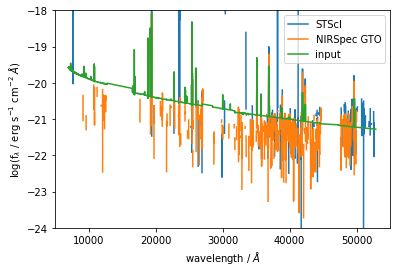

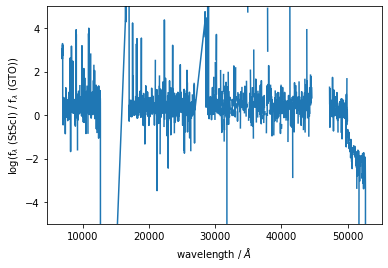

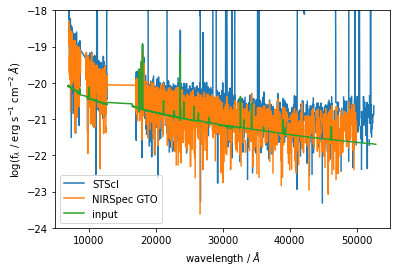

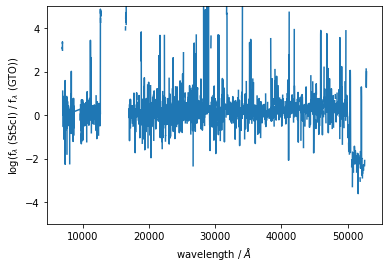

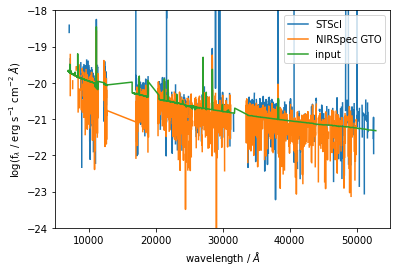

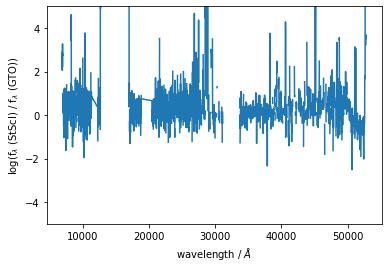

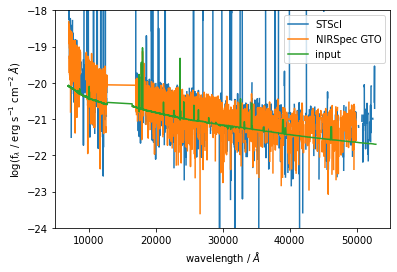

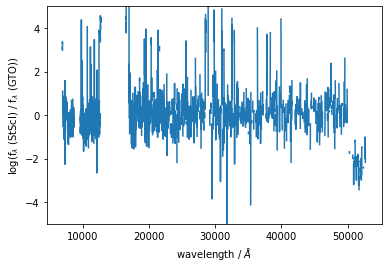

In [9]:
#Let's plot each of the centred sources. (Warning, we're just cycling through all 
#the spectra in the calwebb_spec3 output file.  There will be a lot of plots if you have
#changed the RunFull flag)
catFile = "inputs/SF_and_quiescent_catalogue_mags.fits"
GTOredFolder = "final_products/"
fileList = os.listdir(stage3OutDir)
for file in fileList:
    if 'combine1dstep' in file:
        print(file)
        results = plot_comparison(stage3OutDir+'/'+file, catFile, GTOredFolder, plot=True, silent=False, gratings=True)
        

Other resources:

**Acknowledgements:** ECL acknowledges the STFC Webb fellowship grant.  This work has been undertaken as part of the 30% contribution to community support.